<a href="https://colab.research.google.com/github/Bhanu-py/Sequential-Learning-NLP-BERT/blob/main/notebookba8394b608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install transformers

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
# import tensorflow_models as tfm
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from keras.utils import pad_sequences
from keras.utils import to_categorical
import keras
import time
import datetime

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 500)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.0 MB/s 
     |████████████████████████████████| 7.6 MB 59.5 MB/s 
     |████████████████████████████████| 182 kB 82.4 MB/s 


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# /content/model_save/pytorch_model.bin

Mounted at /content/drive


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
traindf = pd.read_csv('/content/drive/MyDrive/train.csv')
traindf

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...


In [ ]:
categories = ['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal']
traindf['labels'] = traindf.discourse_type.astype('category').cat.codes
traindf


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,labels
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,4
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,5
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,3
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,3
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,0
...,...,...,...,...,...,...,...,...,...
144288,4C471936CD75,1.618153e+12,2234.0,3203.0,if I'm not sure what college I want to attend...,Evidence,Evidence 2,386 387 388 389 390 391 392 393 394 395 396 39...,3
144289,4C471936CD75,1.618153e+12,3221.0,4509.0,seeking multiple opinions before making a har...,Evidence,Evidence 3,576 577 578 579 580 581 582 583 584 585 586 58...,3
144290,4C471936CD75,1.618025e+12,4510.0,4570.0,it is better to seek multiple opinions instead...,Position,Position 1,828 829 830 831 832 833 834 835 836 837 838,5
144291,4C471936CD75,1.618025e+12,4570.0,4922.0,The impact of asking people to help you make a...,Evidence,Evidence 4,839 840 841 842 843 844 845 846 847 848 849 85...,3


In [ ]:
sentences = traindf['discourse_text'].values
labels = traindf['labels'].values


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Original:  Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.
Tokenized:  ['modern', 'humans', 'today', 'are', 'always', 'on', 'their', 'phone', '.', 'they', 'are', 'always', 'on', 'their', 'phone', 'more', 'than', '5', 'hours', 'a', 'day', 'no', 'stop', '.', 'all', 'they', 'do', 'is', 'text', 'back', 'and', 'forward', 'and', 'just', 'have', 'group', 'chat', '##s', 'on', 'social', 'media', '.', 'they', 'even', 'do', 'it', 'while', 'driving', '.']
Token IDs:  [2715, 4286, 2651, 2024, 2467, 2006, 2037, 3042, 1012, 2027, 2024, 2467, 2006, 2037, 3042, 2062, 2084, 1019, 2847, 1037, 2154, 2053, 2644, 1012, 2035, 2027, 2079, 2003, 3793, 2067, 1998, 2830, 1998, 2074, 2031, 2177, 11834, 2015, 2006, 2591, 2865, 1012, 2027, 2130, 2079, 2009, 2096, 4439, 1012]


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in tqdm.tqdm(sentences):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'

        # This function also supports truncation and conversion
        # to pytorch tensors, but we need to do padding, so we
        # can't use these features :( .
#         max_length=512,          # Truncate all sentences.
#         truncation=True
        # return_tensors = 'pt',     # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


100%|██████████| 144293/144293 [02:27<00:00, 981.34it/s]

Original:  Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving.
Token IDs: [101, 2715, 4286, 2651, 2024, 2467, 2006, 2037, 3042, 1012, 2027, 2024, 2467, 2006, 2037, 3042, 2062, 2084, 1019, 2847, 1037, 2154, 2053, 2644, 1012, 2035, 2027, 2079, 2003, 3793, 2067, 1998, 2830, 1998, 2074, 2031, 2177, 11834, 2015, 2006, 2591, 2865, 1012, 2027, 2130, 2079, 2009, 2096, 4439, 1012, 102]


In [ ]:
sent_len = pd.Series([len(i.split(' ')) for i in traindf['discourse_text']])
print(sent_len.mean())
print(sent_len.median())

44.016937758588426
28.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


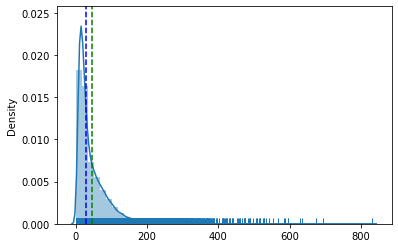

In [ ]:
# pd.Series([len(i.split(' ')) for i in traindf['discourse_text']]).hist(bins = 150)
sns.distplot(sent_len, kde=True, rug=True)
plt.axvline(np.median(sent_len),color='b', linestyle='--')
plt.axvline(np.mean(sent_len),color='green', linestyle='--')
# plt.axvline(np.mode(sent_len),color='r', linestyle='--')
plt.show()

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  913


In [ ]:
# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 80

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                          value=0, truncating="post", padding="post")

print('\nDone.')
print(input_ids[0])


Padding/truncating all sentences to 50 values...

Padding token: "[PAD]", ID: 0

Done.
[  101  2715  4286  2651  2024  2467  2006  2037  3042  1012  2027  2024
  2467  2006  2037  3042  2062  2084  1019  2847  1037  2154  2053  2644
  1012  2035  2027  2079  2003  3793  2067  1998  2830  1998  2074  2031
  2177 11834  2015  2006  2591  2865  1012  2027  2130  2079  2009  2096
  4439  1012]


In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in tqdm.tqdm(input_ids):
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]

    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)


100%|██████████| 144293/144293 [00:03<00:00, 38197.58it/s]


In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

train_labels = to_categorical(list(train_labels))
validation_labels = to_categorical(list(validation_labels))



# train_labels.shape
train_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

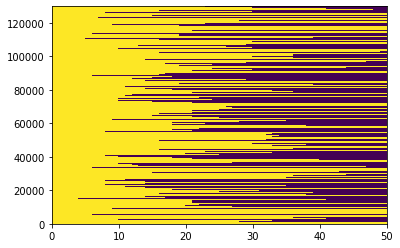

In [ ]:
plt.pcolormesh(train_masks)


In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels, train_masks))
valid = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_labels, validation_masks))

In [ ]:
next(iter(train))

(<tf.Tensor: shape=(50,), dtype=int64, numpy=
 array([  101,  1045,  2572,  1999,  5684,  1997,  1996,  6092,  2267,
         2138,  1997,  1996,  3056,  3012,  1997,  9560,  1998,  2022,
        27199,  2063,  1997,  1996,  2163,  1012,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)>,
 <tf.Tensor: shape=(50,), dtype=int64, numpy=
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])>)

In [ ]:
# #  The DataLoader needs to know our batch size for training, so we specify it
# # here.
# # For fine-tuning BERT on a specific task, the authors recommend a batch size of
# # 16 or 32.

batch_size = 32

# # Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# # Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
next(iter(validation_dataloader))

[tensor([[  101, 17174,  1024,  ...,  5920,  1998,  2000],
         [  101,  2029,  2003,  ...,  2013,  2122, 11450],
         [  101,  1996,  2832,  ...,     0,     0,     0],
         ...,
         [  101,  1045,  2228,  ...,     0,     0,     0],
         [  101,  1999,  7091,  ...,  1037, 15797,  2007],
         [  101,  2748,  1045,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0.],
         [0., 

In [ ]:
# import json

# bert_config_file = os.path.join("bert_config.json")
# config_dict = {'attention_probs_dropout_prob': 0.1,
#  'hidden_act': 'gelu',
#  'hidden_dropout_prob': 0.1,
#  'hidden_size': 768,
#  'initializer_range': 0.02,
#  'intermediate_size': 3072,
#  'max_position_embeddings': 512,
#  'num_attention_heads': 12,
#  'num_hidden_layers': 12,
#  'type_vocab_size': 2,
#  'vocab_size': 30522}
# config_dict

In [ ]:
# from transformers import BertConfig

# config = BertConfig.from_pretrained("bert-base-cased", num_classes=7)

In [ ]:
# from transformers import TFBertForSequenceClassification

# model = TFBertForSequenceClassification(config)
# # config.num_labels = 7
# config

In [ ]:
# optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy', dtype=tf.float32)]
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# model([[train., attention_mask]])

In [ ]:
# model.fit(train, validation_data=valid, epochs=4)

In [ ]:
# labels = torch.tensor([1]).unsqueeze(0)
# labels

In [ ]:
#  Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 7, # The number of output labels--7for Multi-class classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
#  Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr=2e-5,  # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps=1e-8  # args.adam_epsilon  - default is 1e-8.
                  )


In [ ]:
# # Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(logits, labels):
  regular_list = [list(np.argmax(i, axis=1)) for i in np.array(logits)]
  pred = [item for sublist in regular_list for item in sublist]
  regular_label_list = [list(np.argmax(i, axis=1)) for i in np.array(labels)]
  labels_flat = [item for sublist in regular_label_list for item in sublist]
  return np.mean(np.array(pred) == np.array(labels_flat))

def flat_accuracy_batch(logits, labels):
  regular_list = np.argmax(logits, axis=1)
  pred = [item for sublist in regular_list for item in sublist]
  regular_label_list = np.argmax(labels, axis=1)
  labels_flat = [item for sublist in regular_label_list for item in sublist]
  return np.mean(np.array(pred) == np.array(labels_flat))

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
next(iter(train_data))

(tensor([  101,  1045,  2572,  1999,  5684,  1997,  1996,  6092,  2267,  2138,
          1997,  1996,  3056,  3012,  1997,  9560,  1998,  2022, 27199,  2063,
          1997,  1996,  2163,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 tensor([0., 0., 0., 0., 0., 1., 0.]))

In [ ]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [ ]:
import random
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in tqdm.tqdm(range(0, epochs)):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in tqdm.tqdm(enumerate(train_dataloader)):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#         print(b_input_ids)
#         print(b_labels)
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in tqdm.tqdm(validation_dataloader):
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.cpu().numpy()
        label_ids = b_labels.cpu().numpy()
        
        # print(logits)
        # print(label_ids)
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy_batch(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        print(eval_accuracy)
        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

  0%|          | 0/3 [00:00<?, ?it/s]


======== Epoch 1 / 3 ========
Training...



0it [00:00, ?it/s]
1it [00:00,  2.90it/s]
2it [00:00,  3.21it/s]
3it [00:00,  3.32it/s]
4it [00:01,  3.29it/s]
5it [00:01,  3.32it/s]
6it [00:01,  3.37it/s]
7it [00:02,  3.37it/s]
8it [00:02,  3.34it/s]
9it [00:02,  3.36it/s]
10it [00:03,  3.37it/s]
11it [00:03,  3.36it/s]
12it [00:03,  3.36it/s]
13it [00:03,  3.37it/s]
14it [00:04,  3.36it/s]
15it [00:04,  3.34it/s]
16it [00:04,  3.34it/s]
17it [00:05,  3.34it/s]
18it [00:05,  3.33it/s]
19it [00:05,  3.33it/s]
20it [00:06,  3.34it/s]
21it [00:06,  3.34it/s]
22it [00:06,  3.33it/s]
23it [00:06,  3.33it/s]
24it [00:07,  3.32it/s]
25it [00:07,  3.31it/s]
26it [00:07,  3.31it/s]
27it [00:08,  3.32it/s]
28it [00:08,  3.32it/s]
29it [00:08,  3.31it/s]
30it [00:09,  3.30it/s]
31it [00:09,  3.30it/s]
32it [00:09,  3.29it/s]
33it [00:09,  3.28it/s]
34it [00:10,  3.28it/s]
35it [00:10,  3.29it/s]
36it [00:10,  3.28it/s]
37it [00:11,  3.28it/s]
38it [00:11,  3.29it/s]
39it [00:11,  3.28it/s]
40it [00:12,  3.28it/s]

  Batch    40  of  4,059.    Elapsed: 0:00:12.



41it [00:12,  3.27it/s]
42it [00:12,  3.27it/s]
43it [00:12,  3.27it/s]
44it [00:13,  3.26it/s]
45it [00:13,  3.26it/s]
46it [00:13,  3.26it/s]
47it [00:14,  3.28it/s]
48it [00:14,  3.30it/s]
49it [00:14,  3.28it/s]
50it [00:15,  3.27it/s]
51it [00:15,  3.28it/s]
52it [00:15,  3.29it/s]
53it [00:16,  3.29it/s]
54it [00:16,  3.27it/s]
55it [00:16,  3.28it/s]
56it [00:16,  3.30it/s]
57it [00:17,  3.30it/s]
58it [00:17,  3.29it/s]
59it [00:17,  3.30it/s]
60it [00:18,  3.30it/s]
61it [00:18,  3.30it/s]
62it [00:18,  3.30it/s]
63it [00:19,  3.31it/s]
64it [00:19,  3.31it/s]
65it [00:19,  3.31it/s]
66it [00:19,  3.31it/s]
67it [00:20,  3.32it/s]
68it [00:20,  3.32it/s]
69it [00:20,  3.32it/s]
70it [00:21,  3.32it/s]
71it [00:21,  3.33it/s]
72it [00:21,  3.33it/s]
73it [00:22,  3.32it/s]
74it [00:22,  3.32it/s]
75it [00:22,  3.33it/s]
76it [00:22,  3.33it/s]
77it [00:23,  3.35it/s]
78it [00:23,  3.37it/s]
79it [00:23,  3.36it/s]
80it [00:24,  3.37it/s]

  Batch    80  of  4,059.    Elapsed: 0:00:24.



81it [00:24,  3.37it/s]
82it [00:24,  3.37it/s]
83it [00:25,  3.38it/s]
84it [00:25,  3.38it/s]
85it [00:25,  3.39it/s]
86it [00:25,  3.38it/s]
87it [00:26,  3.39it/s]
88it [00:26,  3.38it/s]
89it [00:26,  3.37it/s]
90it [00:27,  3.39it/s]
91it [00:27,  3.39it/s]
92it [00:27,  3.40it/s]
93it [00:28,  3.39it/s]
94it [00:28,  3.38it/s]
95it [00:28,  3.39it/s]
96it [00:28,  3.39it/s]
97it [00:29,  3.40it/s]
98it [00:29,  3.40it/s]
99it [00:29,  3.39it/s]
100it [00:30,  3.40it/s]
101it [00:30,  3.39it/s]
102it [00:30,  3.40it/s]
103it [00:30,  3.39it/s]
104it [00:31,  3.40it/s]
105it [00:31,  3.41it/s]
106it [00:31,  3.42it/s]
107it [00:32,  3.42it/s]
108it [00:32,  3.42it/s]
109it [00:32,  3.43it/s]
110it [00:32,  3.42it/s]
111it [00:33,  3.42it/s]
112it [00:33,  3.41it/s]
113it [00:33,  3.43it/s]
114it [00:34,  3.43it/s]
115it [00:34,  3.44it/s]
116it [00:34,  3.44it/s]
117it [00:35,  3.42it/s]
118it [00:35,  3.41it/s]
119it [00:35,  3.42it/s]
120it [00:35,  3.42it/s]

  Batch   120  of  4,059.    Elapsed: 0:00:36.



121it [00:36,  3.42it/s]
122it [00:36,  3.43it/s]
123it [00:36,  3.43it/s]
124it [00:37,  3.41it/s]
125it [00:37,  3.43it/s]
126it [00:37,  3.40it/s]
127it [00:37,  3.39it/s]
128it [00:38,  3.35it/s]
129it [00:38,  3.35it/s]
130it [00:38,  3.28it/s]
131it [00:39,  3.37it/s]
132it [00:39,  3.41it/s]
133it [00:39,  3.43it/s]
134it [00:40,  3.41it/s]
135it [00:40,  3.43it/s]
136it [00:40,  3.43it/s]
137it [00:40,  3.41it/s]
138it [00:41,  3.43it/s]
139it [00:41,  3.45it/s]
140it [00:41,  3.45it/s]
141it [00:42,  3.42it/s]
142it [00:42,  3.36it/s]
143it [00:42,  3.37it/s]
144it [00:42,  3.40it/s]
145it [00:43,  3.42it/s]
146it [00:43,  3.43it/s]
147it [00:43,  3.45it/s]
148it [00:44,  3.48it/s]
149it [00:44,  3.47it/s]
150it [00:44,  3.48it/s]
151it [00:44,  3.49it/s]
152it [00:45,  3.49it/s]
153it [00:45,  3.50it/s]
154it [00:45,  3.48it/s]
155it [00:46,  3.49it/s]
156it [00:46,  3.49it/s]
157it [00:46,  3.48it/s]
158it [00:46,  3.48it/s]
159it [00:47,  3.49it/s]
160it [00:47,  3.49it/s]

  Batch   160  of  4,059.    Elapsed: 0:00:48.



161it [00:47,  3.49it/s]
162it [00:48,  3.49it/s]
163it [00:48,  3.50it/s]
164it [00:48,  3.50it/s]
165it [00:48,  3.49it/s]
166it [00:49,  3.49it/s]
167it [00:49,  3.49it/s]
168it [00:49,  3.48it/s]
169it [00:50,  3.50it/s]
170it [00:50,  3.50it/s]
171it [00:50,  3.49it/s]
172it [00:50,  3.49it/s]
173it [00:51,  3.49it/s]
174it [00:51,  3.50it/s]
175it [00:51,  3.49it/s]
176it [00:52,  3.49it/s]
177it [00:52,  3.50it/s]
178it [00:52,  3.50it/s]
179it [00:52,  3.51it/s]
180it [00:53,  3.52it/s]
181it [00:53,  3.51it/s]
182it [00:53,  3.51it/s]
183it [00:54,  3.51it/s]
184it [00:54,  3.53it/s]
185it [00:54,  3.52it/s]
186it [00:54,  3.52it/s]
187it [00:55,  3.52it/s]
188it [00:55,  3.52it/s]
189it [00:55,  3.52it/s]
190it [00:56,  3.51it/s]
191it [00:56,  3.51it/s]
192it [00:56,  3.51it/s]
193it [00:56,  3.51it/s]
194it [00:57,  3.52it/s]
195it [00:57,  3.52it/s]
196it [00:57,  3.53it/s]
197it [00:58,  3.52it/s]
198it [00:58,  3.52it/s]
199it [00:58,  3.52it/s]
200it [00:58,  3.52it/s]

  Batch   200  of  4,059.    Elapsed: 0:00:59.



201it [00:59,  3.51it/s]
202it [00:59,  3.52it/s]
203it [00:59,  3.52it/s]
204it [01:00,  3.52it/s]
205it [01:00,  3.51it/s]
206it [01:00,  3.52it/s]
207it [01:00,  3.52it/s]
208it [01:01,  3.52it/s]
209it [01:01,  3.52it/s]
210it [01:01,  3.52it/s]
211it [01:02,  3.52it/s]
212it [01:02,  3.52it/s]
213it [01:02,  3.52it/s]
214it [01:02,  3.53it/s]
215it [01:03,  3.52it/s]
216it [01:03,  3.51it/s]
217it [01:03,  3.51it/s]
218it [01:04,  3.52it/s]
219it [01:04,  3.51it/s]
220it [01:04,  3.51it/s]
221it [01:04,  3.51it/s]
222it [01:05,  3.52it/s]
223it [01:05,  3.51it/s]
224it [01:05,  3.53it/s]
225it [01:06,  3.52it/s]
226it [01:06,  3.51it/s]
227it [01:06,  3.51it/s]
228it [01:06,  3.52it/s]
229it [01:07,  3.52it/s]
230it [01:07,  3.52it/s]
231it [01:07,  3.52it/s]
232it [01:08,  3.53it/s]
233it [01:08,  3.52it/s]
234it [01:08,  3.51it/s]
235it [01:08,  3.50it/s]
236it [01:09,  3.50it/s]
237it [01:09,  3.51it/s]
238it [01:09,  3.51it/s]
239it [01:10,  3.50it/s]
240it [01:10,  3.51it/s]

  Batch   240  of  4,059.    Elapsed: 0:01:10.



241it [01:10,  3.49it/s]
242it [01:10,  3.49it/s]
243it [01:11,  3.49it/s]
244it [01:11,  3.50it/s]
245it [01:11,  3.50it/s]
246it [01:12,  3.50it/s]
247it [01:12,  3.51it/s]
248it [01:12,  3.50it/s]
249it [01:12,  3.50it/s]
250it [01:13,  3.51it/s]
251it [01:13,  3.51it/s]
252it [01:13,  3.47it/s]
253it [01:14,  3.48it/s]
254it [01:14,  3.49it/s]
255it [01:14,  3.49it/s]
256it [01:14,  3.50it/s]
257it [01:15,  3.49it/s]
258it [01:15,  3.50it/s]
259it [01:15,  3.48it/s]
260it [01:16,  3.36it/s]
261it [01:16,  3.37it/s]
262it [01:16,  3.39it/s]
263it [01:16,  3.40it/s]
264it [01:17,  3.40it/s]
265it [01:17,  3.40it/s]
266it [01:17,  3.43it/s]
267it [01:18,  3.44it/s]
268it [01:18,  3.45it/s]
269it [01:18,  3.44it/s]
270it [01:19,  3.45it/s]
271it [01:19,  3.47it/s]
272it [01:19,  3.48it/s]
273it [01:19,  3.48it/s]
274it [01:20,  3.48it/s]
275it [01:20,  3.49it/s]
276it [01:20,  3.48it/s]
277it [01:21,  3.47it/s]
278it [01:21,  3.47it/s]
279it [01:21,  3.47it/s]
280it [01:21,  3.47it/s]

  Batch   280  of  4,059.    Elapsed: 0:01:22.



281it [01:22,  3.46it/s]
282it [01:22,  3.48it/s]
283it [01:22,  3.48it/s]
284it [01:23,  3.48it/s]
285it [01:23,  3.45it/s]
286it [01:23,  3.46it/s]
287it [01:23,  3.46it/s]
288it [01:24,  3.45it/s]
289it [01:24,  3.46it/s]
290it [01:24,  3.46it/s]
291it [01:25,  3.45it/s]
292it [01:25,  3.45it/s]
293it [01:25,  3.45it/s]
294it [01:25,  3.46it/s]
295it [01:26,  3.44it/s]
296it [01:26,  3.46it/s]
297it [01:26,  3.46it/s]
298it [01:27,  3.46it/s]
299it [01:27,  3.45it/s]
300it [01:27,  3.45it/s]
301it [01:27,  3.46it/s]
302it [01:28,  3.46it/s]
303it [01:28,  3.44it/s]
304it [01:28,  3.45it/s]
305it [01:29,  3.45it/s]
306it [01:29,  3.44it/s]
307it [01:29,  3.45it/s]
308it [01:29,  3.44it/s]
309it [01:30,  3.44it/s]
310it [01:30,  3.44it/s]
311it [01:30,  3.43it/s]
312it [01:31,  3.43it/s]
313it [01:31,  3.43it/s]
314it [01:31,  3.43it/s]
315it [01:32,  3.44it/s]
316it [01:32,  3.44it/s]
317it [01:32,  3.44it/s]
318it [01:32,  3.43it/s]
319it [01:33,  3.43it/s]
320it [01:33,  3.42it/s]

  Batch   320  of  4,059.    Elapsed: 0:01:34.



321it [01:33,  3.42it/s]
322it [01:34,  3.43it/s]
323it [01:34,  3.43it/s]
324it [01:34,  3.42it/s]
325it [01:34,  3.42it/s]
326it [01:35,  3.43it/s]
327it [01:35,  3.44it/s]
328it [01:35,  3.43it/s]
329it [01:36,  3.43it/s]
330it [01:36,  3.44it/s]
331it [01:36,  3.43it/s]
332it [01:36,  3.43it/s]
333it [01:37,  3.43it/s]
334it [01:37,  3.44it/s]
335it [01:37,  3.43it/s]
336it [01:38,  3.44it/s]
337it [01:38,  3.44it/s]
338it [01:38,  3.42it/s]
339it [01:39,  3.42it/s]
340it [01:39,  3.43it/s]
341it [01:39,  3.43it/s]
342it [01:39,  3.43it/s]
343it [01:40,  3.43it/s]
344it [01:40,  3.43it/s]
345it [01:40,  3.42it/s]
346it [01:41,  3.43it/s]
347it [01:41,  3.44it/s]
348it [01:41,  3.43it/s]
349it [01:41,  3.43it/s]
350it [01:42,  3.42it/s]
351it [01:42,  3.43it/s]
352it [01:42,  3.42it/s]
353it [01:43,  3.42it/s]
354it [01:43,  3.42it/s]
355it [01:43,  3.42it/s]
356it [01:43,  3.42it/s]
357it [01:44,  3.40it/s]
358it [01:44,  3.42it/s]
359it [01:44,  3.42it/s]
360it [01:45,  3.43it/s]

  Batch   360  of  4,059.    Elapsed: 0:01:45.



361it [01:45,  3.44it/s]
362it [01:45,  3.44it/s]
363it [01:46,  3.44it/s]
364it [01:46,  3.44it/s]
365it [01:46,  3.43it/s]
366it [01:46,  3.44it/s]
367it [01:47,  3.44it/s]
368it [01:47,  3.44it/s]
369it [01:47,  3.43it/s]
370it [01:48,  3.44it/s]
371it [01:48,  3.44it/s]
372it [01:48,  3.44it/s]
373it [01:48,  3.44it/s]
374it [01:49,  3.44it/s]
375it [01:49,  3.43it/s]
376it [01:49,  3.43it/s]
377it [01:50,  3.42it/s]
378it [01:50,  3.43it/s]
379it [01:50,  3.42it/s]
380it [01:50,  3.43it/s]
381it [01:51,  3.44it/s]
382it [01:51,  3.43it/s]
383it [01:51,  3.43it/s]
384it [01:52,  3.41it/s]
385it [01:52,  3.43it/s]
386it [01:52,  3.43it/s]
387it [01:53,  3.42it/s]
388it [01:53,  3.43it/s]
389it [01:53,  3.42it/s]
390it [01:53,  3.43it/s]
391it [01:54,  3.43it/s]
392it [01:54,  3.43it/s]
393it [01:54,  3.43it/s]
394it [01:55,  3.43it/s]
395it [01:55,  3.45it/s]
396it [01:55,  3.43it/s]
397it [01:55,  3.44it/s]
398it [01:56,  3.43it/s]
399it [01:56,  3.43it/s]
400it [01:56,  3.42it/s]

  Batch   400  of  4,059.    Elapsed: 0:01:57.



401it [01:57,  3.43it/s]
402it [01:57,  3.43it/s]
403it [01:57,  3.44it/s]
404it [01:57,  3.44it/s]
405it [01:58,  3.45it/s]
406it [01:58,  3.44it/s]
407it [01:58,  3.44it/s]
408it [01:59,  3.46it/s]
409it [01:59,  3.45it/s]
410it [01:59,  3.44it/s]
411it [02:00,  3.45it/s]
412it [02:00,  3.45it/s]
413it [02:00,  3.45it/s]
414it [02:00,  3.45it/s]
415it [02:01,  3.45it/s]
416it [02:01,  3.46it/s]
417it [02:01,  3.46it/s]
418it [02:02,  3.47it/s]
419it [02:02,  3.46it/s]
420it [02:02,  3.44it/s]
421it [02:02,  3.45it/s]
422it [02:03,  3.46it/s]
423it [02:03,  3.46it/s]
424it [02:03,  3.44it/s]
425it [02:04,  3.44it/s]
426it [02:04,  3.45it/s]
427it [02:04,  3.45it/s]
428it [02:04,  3.43it/s]
429it [02:05,  3.44it/s]
430it [02:05,  3.45it/s]
431it [02:05,  3.45it/s]
432it [02:06,  3.45it/s]
433it [02:06,  3.47it/s]
434it [02:06,  3.44it/s]
435it [02:06,  3.44it/s]
436it [02:07,  3.46it/s]
437it [02:07,  3.47it/s]
438it [02:07,  3.45it/s]
439it [02:08,  3.46it/s]
440it [02:08,  3.46it/s]

  Batch   440  of  4,059.    Elapsed: 0:02:08.



441it [02:08,  3.47it/s]
442it [02:08,  3.46it/s]
443it [02:09,  3.46it/s]
444it [02:09,  3.46it/s]
445it [02:09,  3.47it/s]
446it [02:10,  3.47it/s]
447it [02:10,  3.46it/s]
448it [02:10,  3.45it/s]
449it [02:11,  3.46it/s]
450it [02:11,  3.48it/s]
451it [02:11,  3.47it/s]
452it [02:11,  3.46it/s]
453it [02:12,  3.46it/s]
454it [02:12,  3.46it/s]
455it [02:12,  3.47it/s]
456it [02:13,  3.45it/s]
457it [02:13,  3.47it/s]
458it [02:13,  3.48it/s]
459it [02:13,  3.47it/s]
460it [02:14,  3.48it/s]
461it [02:14,  3.47it/s]
462it [02:14,  3.47it/s]
463it [02:15,  3.45it/s]
464it [02:15,  3.45it/s]
465it [02:15,  3.45it/s]
466it [02:15,  3.46it/s]
467it [02:16,  3.45it/s]
468it [02:16,  3.45it/s]
469it [02:16,  3.46it/s]
470it [02:17,  3.46it/s]
471it [02:17,  3.47it/s]
472it [02:17,  3.48it/s]
473it [02:17,  3.48it/s]
474it [02:18,  3.47it/s]
475it [02:18,  3.46it/s]
476it [02:18,  3.46it/s]
477it [02:19,  3.47it/s]
478it [02:19,  3.47it/s]
479it [02:19,  3.47it/s]
480it [02:19,  3.46it/s]

  Batch   480  of  4,059.    Elapsed: 0:02:20.



481it [02:20,  3.47it/s]
482it [02:20,  3.48it/s]
483it [02:20,  3.49it/s]
484it [02:21,  3.49it/s]
485it [02:21,  3.48it/s]
486it [02:21,  3.47it/s]
487it [02:21,  3.48it/s]
488it [02:22,  3.47it/s]
489it [02:22,  3.48it/s]
490it [02:22,  3.49it/s]
491it [02:23,  3.48it/s]
492it [02:23,  3.47it/s]
493it [02:23,  3.46it/s]
494it [02:23,  3.46it/s]
495it [02:24,  3.47it/s]
496it [02:24,  3.46it/s]
497it [02:24,  3.47it/s]
498it [02:25,  3.47it/s]
499it [02:25,  3.46it/s]
500it [02:25,  3.47it/s]
501it [02:25,  3.48it/s]
502it [02:26,  3.48it/s]
503it [02:26,  3.47it/s]
504it [02:26,  3.48it/s]
505it [02:27,  3.48it/s]
506it [02:27,  3.47it/s]
507it [02:27,  3.46it/s]
508it [02:28,  3.47it/s]
509it [02:28,  3.48it/s]
510it [02:28,  3.41it/s]
511it [02:28,  3.38it/s]
512it [02:29,  3.34it/s]
513it [02:29,  3.37it/s]
514it [02:29,  3.41it/s]
515it [02:30,  3.20it/s]
516it [02:30,  3.27it/s]
517it [02:30,  3.31it/s]
518it [02:31,  3.36it/s]
519it [02:31,  3.40it/s]
520it [02:31,  3.43it/s]

  Batch   520  of  4,059.    Elapsed: 0:02:32.



521it [02:31,  3.41it/s]
522it [02:32,  3.43it/s]
523it [02:32,  3.45it/s]
524it [02:32,  3.44it/s]
525it [02:33,  3.47it/s]
526it [02:33,  3.48it/s]
527it [02:33,  3.48it/s]
528it [02:33,  3.46it/s]
529it [02:34,  3.46it/s]
530it [02:34,  3.47it/s]
531it [02:34,  3.46it/s]
532it [02:35,  3.46it/s]
533it [02:35,  3.47it/s]
534it [02:35,  3.47it/s]
535it [02:35,  3.47it/s]
536it [02:36,  3.46it/s]
537it [02:36,  3.47it/s]
538it [02:36,  3.46it/s]
539it [02:37,  3.46it/s]
540it [02:37,  3.47it/s]
541it [02:37,  3.48it/s]
542it [02:37,  3.46it/s]
543it [02:38,  3.47it/s]
544it [02:38,  3.48it/s]
545it [02:38,  3.47it/s]
546it [02:39,  3.47it/s]
547it [02:39,  3.47it/s]
548it [02:39,  3.49it/s]
549it [02:39,  3.47it/s]
550it [02:40,  3.46it/s]
551it [02:40,  3.47it/s]
552it [02:40,  3.47it/s]
553it [02:41,  3.46it/s]
554it [02:41,  3.46it/s]
555it [02:41,  3.46it/s]
556it [02:41,  3.47it/s]
557it [02:42,  3.47it/s]
558it [02:42,  3.47it/s]
559it [02:42,  3.47it/s]
560it [02:43,  3.48it/s]

  Batch   560  of  4,059.    Elapsed: 0:02:43.



561it [02:43,  3.48it/s]
562it [02:43,  3.47it/s]
563it [02:43,  3.47it/s]
564it [02:44,  3.46it/s]
565it [02:44,  3.47it/s]
566it [02:44,  3.46it/s]
567it [02:45,  3.47it/s]
568it [02:45,  3.47it/s]
569it [02:45,  3.46it/s]
570it [02:46,  3.47it/s]
571it [02:46,  3.46it/s]
572it [02:46,  3.47it/s]
573it [02:46,  3.45it/s]
574it [02:47,  3.46it/s]
575it [02:47,  3.47it/s]
576it [02:47,  3.47it/s]
577it [02:48,  3.48it/s]
578it [02:48,  3.46it/s]
579it [02:48,  3.47it/s]
580it [02:48,  3.47it/s]
581it [02:49,  3.47it/s]
582it [02:49,  3.46it/s]
583it [02:49,  3.46it/s]
584it [02:50,  3.47it/s]
585it [02:50,  3.47it/s]
586it [02:50,  3.47it/s]
587it [02:50,  3.47it/s]
588it [02:51,  3.47it/s]
589it [02:51,  3.46it/s]
590it [02:51,  3.45it/s]
591it [02:52,  3.47it/s]
592it [02:52,  3.45it/s]
593it [02:52,  3.45it/s]
594it [02:52,  3.45it/s]
595it [02:53,  3.46it/s]
596it [02:53,  3.45it/s]
597it [02:53,  3.45it/s]
598it [02:54,  3.45it/s]
599it [02:54,  3.45it/s]
600it [02:54,  3.45it/s]

  Batch   600  of  4,059.    Elapsed: 0:02:55.



601it [02:54,  3.46it/s]
602it [02:55,  3.47it/s]
603it [02:55,  3.48it/s]
604it [02:55,  3.47it/s]
605it [02:56,  3.47it/s]
606it [02:56,  3.47it/s]
607it [02:56,  3.45it/s]
608it [02:56,  3.45it/s]
609it [02:57,  3.47it/s]
610it [02:57,  3.46it/s]
611it [02:57,  3.45it/s]
612it [02:58,  3.45it/s]
613it [02:58,  3.47it/s]
614it [02:58,  3.47it/s]
615it [02:59,  3.47it/s]
616it [02:59,  3.46it/s]
617it [02:59,  3.47it/s]
618it [02:59,  3.46it/s]
619it [03:00,  3.45it/s]
620it [03:00,  3.46it/s]
621it [03:00,  3.46it/s]
622it [03:01,  3.45it/s]
623it [03:01,  3.45it/s]
624it [03:01,  3.45it/s]
625it [03:01,  3.45it/s]
626it [03:02,  3.45it/s]
627it [03:02,  3.46it/s]
628it [03:02,  3.45it/s]
629it [03:03,  3.46it/s]
630it [03:03,  3.43it/s]
631it [03:03,  3.40it/s]
632it [03:03,  3.37it/s]
633it [03:04,  3.38it/s]
634it [03:04,  3.40it/s]
635it [03:04,  3.42it/s]
636it [03:05,  3.43it/s]
637it [03:05,  3.42it/s]
638it [03:05,  3.43it/s]
639it [03:05,  3.45it/s]
640it [03:06,  3.44it/s]

  Batch   640  of  4,059.    Elapsed: 0:03:06.



641it [03:06,  3.45it/s]
642it [03:06,  3.46it/s]
643it [03:07,  3.45it/s]
644it [03:07,  3.44it/s]
645it [03:07,  3.46it/s]
646it [03:08,  3.47it/s]
647it [03:08,  3.45it/s]
648it [03:08,  3.45it/s]
649it [03:08,  3.47it/s]
650it [03:09,  3.47it/s]
651it [03:09,  3.44it/s]
652it [03:09,  3.46it/s]
653it [03:10,  3.46it/s]
654it [03:10,  3.44it/s]
655it [03:10,  3.44it/s]
656it [03:10,  3.45it/s]
657it [03:11,  3.45it/s]
658it [03:11,  3.44it/s]
659it [03:11,  3.45it/s]
660it [03:12,  3.46it/s]
661it [03:12,  3.45it/s]
662it [03:12,  3.44it/s]
663it [03:12,  3.46it/s]
664it [03:13,  3.46it/s]
665it [03:13,  3.44it/s]
666it [03:13,  3.46it/s]
667it [03:14,  3.45it/s]
668it [03:14,  3.45it/s]
669it [03:14,  3.45it/s]
670it [03:14,  3.47it/s]
671it [03:15,  3.47it/s]
672it [03:15,  3.47it/s]
673it [03:15,  3.46it/s]
674it [03:16,  3.46it/s]
675it [03:16,  3.47it/s]
676it [03:16,  3.46it/s]
677it [03:16,  3.45it/s]
678it [03:17,  3.45it/s]
679it [03:17,  3.45it/s]
680it [03:17,  3.45it/s]

  Batch   680  of  4,059.    Elapsed: 0:03:18.



681it [03:18,  3.45it/s]
682it [03:18,  3.45it/s]
683it [03:18,  3.46it/s]
684it [03:19,  3.46it/s]
685it [03:19,  3.46it/s]
686it [03:19,  3.45it/s]
687it [03:19,  3.45it/s]
688it [03:20,  3.44it/s]
689it [03:20,  3.44it/s]
690it [03:20,  3.44it/s]
691it [03:21,  3.45it/s]
692it [03:21,  3.44it/s]
693it [03:21,  3.44it/s]
694it [03:21,  3.44it/s]
695it [03:22,  3.43it/s]
696it [03:22,  3.43it/s]
697it [03:22,  3.44it/s]
698it [03:23,  3.44it/s]
699it [03:23,  3.44it/s]
700it [03:23,  3.43it/s]
701it [03:23,  3.42it/s]
702it [03:24,  3.43it/s]
703it [03:24,  3.44it/s]
704it [03:24,  3.44it/s]
705it [03:25,  3.45it/s]
706it [03:25,  3.44it/s]
707it [03:25,  3.44it/s]
708it [03:25,  3.44it/s]
709it [03:26,  3.44it/s]
710it [03:26,  3.46it/s]
711it [03:26,  3.45it/s]
712it [03:27,  3.46it/s]
713it [03:27,  3.46it/s]
714it [03:27,  3.46it/s]
715it [03:28,  3.46it/s]
716it [03:28,  3.45it/s]
717it [03:28,  3.44it/s]
718it [03:28,  3.44it/s]
719it [03:29,  3.46it/s]
720it [03:29,  3.45it/s]

  Batch   720  of  4,059.    Elapsed: 0:03:29.



721it [03:29,  3.45it/s]
722it [03:30,  3.45it/s]
723it [03:30,  3.44it/s]
724it [03:30,  3.44it/s]
725it [03:30,  3.45it/s]
726it [03:31,  3.44it/s]
727it [03:31,  3.43it/s]
728it [03:31,  3.45it/s]
729it [03:32,  3.45it/s]
730it [03:32,  3.46it/s]
731it [03:32,  3.45it/s]
732it [03:32,  3.46it/s]
733it [03:33,  3.46it/s]
734it [03:33,  3.44it/s]
735it [03:33,  3.45it/s]
736it [03:34,  3.44it/s]
737it [03:34,  3.45it/s]
738it [03:34,  3.46it/s]
739it [03:34,  3.46it/s]
740it [03:35,  3.46it/s]
741it [03:35,  3.46it/s]
742it [03:35,  3.46it/s]
743it [03:36,  3.46it/s]
744it [03:36,  3.44it/s]
745it [03:36,  3.44it/s]
746it [03:37,  3.44it/s]
747it [03:37,  3.45it/s]
748it [03:37,  3.44it/s]
749it [03:37,  3.46it/s]
750it [03:38,  3.47it/s]
751it [03:38,  3.44it/s]
752it [03:38,  3.45it/s]
753it [03:39,  3.45it/s]
754it [03:39,  3.46it/s]
755it [03:39,  3.44it/s]
756it [03:39,  3.45it/s]
757it [03:40,  3.45it/s]
758it [03:40,  3.44it/s]
759it [03:40,  3.44it/s]
760it [03:41,  3.46it/s]

  Batch   760  of  4,059.    Elapsed: 0:03:41.



761it [03:41,  3.45it/s]
762it [03:41,  3.45it/s]
763it [03:41,  3.45it/s]
764it [03:42,  3.46it/s]
765it [03:42,  3.45it/s]
766it [03:42,  3.44it/s]
767it [03:43,  3.44it/s]
768it [03:43,  3.44it/s]
769it [03:43,  3.44it/s]
770it [03:43,  3.45it/s]
771it [03:44,  3.46it/s]
772it [03:44,  3.44it/s]
773it [03:44,  3.44it/s]
774it [03:45,  3.46it/s]
775it [03:45,  3.45it/s]
776it [03:45,  3.43it/s]
777it [03:46,  3.42it/s]
778it [03:46,  3.39it/s]
779it [03:46,  3.40it/s]
780it [03:46,  3.37it/s]
781it [03:47,  3.41it/s]
782it [03:47,  3.38it/s]
783it [03:47,  3.42it/s]
784it [03:48,  3.42it/s]
785it [03:48,  3.43it/s]
786it [03:48,  3.43it/s]
787it [03:48,  3.45it/s]
788it [03:49,  3.43it/s]
789it [03:49,  3.43it/s]
790it [03:49,  3.44it/s]
791it [03:50,  3.45it/s]
792it [03:50,  3.45it/s]
793it [03:50,  3.45it/s]
794it [03:50,  3.44it/s]
795it [03:51,  3.43it/s]
796it [03:51,  3.45it/s]
797it [03:51,  3.46it/s]
798it [03:52,  3.45it/s]
799it [03:52,  3.45it/s]
800it [03:52,  3.46it/s]

  Batch   800  of  4,059.    Elapsed: 0:03:53.



801it [03:52,  3.45it/s]
802it [03:53,  3.44it/s]
803it [03:53,  3.46it/s]
804it [03:53,  3.46it/s]
805it [03:54,  3.46it/s]
806it [03:54,  3.45it/s]
807it [03:54,  3.45it/s]
808it [03:55,  3.44it/s]
809it [03:55,  3.46it/s]
810it [03:55,  3.45it/s]
811it [03:55,  3.44it/s]
812it [03:56,  3.45it/s]
813it [03:56,  3.45it/s]
814it [03:56,  3.45it/s]
815it [03:57,  3.44it/s]
816it [03:57,  3.46it/s]
817it [03:57,  3.46it/s]
818it [03:57,  3.45it/s]
819it [03:58,  3.45it/s]
820it [03:58,  3.46it/s]
821it [03:58,  3.46it/s]
822it [03:59,  3.45it/s]
823it [03:59,  3.45it/s]
824it [03:59,  3.47it/s]
825it [03:59,  3.45it/s]
826it [04:00,  3.45it/s]
827it [04:00,  3.44it/s]
828it [04:00,  3.44it/s]
829it [04:01,  3.45it/s]
830it [04:01,  3.46it/s]
831it [04:01,  3.46it/s]
832it [04:01,  3.44it/s]
833it [04:02,  3.45it/s]
834it [04:02,  3.46it/s]
835it [04:02,  3.44it/s]
836it [04:03,  3.44it/s]
837it [04:03,  3.44it/s]
838it [04:03,  3.46it/s]
839it [04:04,  3.46it/s]
840it [04:04,  3.45it/s]

  Batch   840  of  4,059.    Elapsed: 0:04:04.



841it [04:04,  3.45it/s]
842it [04:04,  3.47it/s]
843it [04:05,  3.47it/s]
844it [04:05,  3.45it/s]
845it [04:05,  3.46it/s]
846it [04:06,  3.46it/s]
847it [04:06,  3.45it/s]
848it [04:06,  3.45it/s]
849it [04:06,  3.46it/s]
850it [04:07,  3.45it/s]
851it [04:07,  3.44it/s]
852it [04:07,  3.46it/s]
853it [04:08,  3.44it/s]
854it [04:08,  3.44it/s]
855it [04:08,  3.45it/s]
856it [04:08,  3.46it/s]
857it [04:09,  3.45it/s]
858it [04:09,  3.45it/s]
859it [04:09,  3.46it/s]
860it [04:10,  3.45it/s]
861it [04:10,  3.45it/s]
862it [04:10,  3.44it/s]
863it [04:10,  3.45it/s]
864it [04:11,  3.45it/s]
865it [04:11,  3.45it/s]
866it [04:11,  3.45it/s]
867it [04:12,  3.44it/s]
868it [04:12,  3.45it/s]
869it [04:12,  3.46it/s]
870it [04:12,  3.44it/s]
871it [04:13,  3.45it/s]
872it [04:13,  3.44it/s]
873it [04:13,  3.45it/s]
874it [04:14,  3.46it/s]
875it [04:14,  3.47it/s]
876it [04:14,  3.47it/s]
877it [04:15,  3.46it/s]
878it [04:15,  3.45it/s]
879it [04:15,  3.47it/s]
880it [04:15,  3.46it/s]

  Batch   880  of  4,059.    Elapsed: 0:04:16.



881it [04:16,  3.45it/s]
882it [04:16,  3.45it/s]
883it [04:16,  3.46it/s]
884it [04:17,  3.44it/s]
885it [04:17,  3.44it/s]
886it [04:17,  3.46it/s]
887it [04:17,  3.46it/s]
888it [04:18,  3.44it/s]
889it [04:18,  3.45it/s]
890it [04:18,  3.45it/s]
891it [04:19,  3.45it/s]
892it [04:19,  3.44it/s]
893it [04:19,  3.45it/s]
894it [04:19,  3.46it/s]
895it [04:20,  3.45it/s]
896it [04:20,  3.45it/s]
897it [04:20,  3.45it/s]
898it [04:21,  3.44it/s]
899it [04:21,  3.44it/s]
900it [04:21,  3.46it/s]
901it [04:21,  3.46it/s]
902it [04:22,  3.46it/s]
903it [04:22,  3.45it/s]
904it [04:22,  3.46it/s]
905it [04:23,  3.45it/s]
906it [04:23,  3.45it/s]
907it [04:23,  3.46it/s]
908it [04:23,  3.46it/s]
909it [04:24,  3.45it/s]
910it [04:24,  3.45it/s]
911it [04:24,  3.47it/s]
912it [04:25,  3.47it/s]
913it [04:25,  3.47it/s]
914it [04:25,  3.46it/s]
915it [04:26,  3.46it/s]
916it [04:26,  3.45it/s]
917it [04:26,  3.44it/s]
918it [04:26,  3.44it/s]
919it [04:27,  3.45it/s]
920it [04:27,  3.46it/s]

  Batch   920  of  4,059.    Elapsed: 0:04:27.



921it [04:27,  3.46it/s]
922it [04:28,  3.44it/s]
923it [04:28,  3.44it/s]
924it [04:28,  3.44it/s]
925it [04:28,  3.44it/s]
926it [04:29,  3.43it/s]
927it [04:29,  3.44it/s]
928it [04:29,  3.44it/s]
929it [04:30,  3.43it/s]
930it [04:30,  3.44it/s]
931it [04:30,  3.45it/s]
932it [04:30,  3.45it/s]
933it [04:31,  3.44it/s]
934it [04:31,  3.46it/s]
935it [04:31,  3.47it/s]
936it [04:32,  3.46it/s]
937it [04:32,  3.45it/s]
938it [04:32,  3.45it/s]
939it [04:32,  3.46it/s]
940it [04:33,  3.44it/s]
941it [04:33,  3.45it/s]
942it [04:33,  3.46it/s]
943it [04:34,  3.45it/s]
944it [04:34,  3.45it/s]
945it [04:34,  3.46it/s]
946it [04:35,  3.47it/s]
947it [04:35,  3.46it/s]
948it [04:35,  3.46it/s]
949it [04:35,  3.47it/s]
950it [04:36,  3.47it/s]
951it [04:36,  3.46it/s]
952it [04:36,  3.46it/s]
953it [04:37,  3.46it/s]
954it [04:37,  3.46it/s]
955it [04:37,  3.45it/s]
956it [04:37,  3.46it/s]
957it [04:38,  3.45it/s]
958it [04:38,  3.44it/s]
959it [04:38,  3.44it/s]
960it [04:39,  3.44it/s]

  Batch   960  of  4,059.    Elapsed: 0:04:39.



961it [04:39,  3.44it/s]
962it [04:39,  3.43it/s]
963it [04:39,  3.46it/s]
964it [04:40,  3.45it/s]
965it [04:40,  3.44it/s]
966it [04:40,  3.45it/s]
967it [04:41,  3.44it/s]
968it [04:41,  3.44it/s]
969it [04:41,  3.44it/s]
970it [04:41,  3.45it/s]
971it [04:42,  3.44it/s]
972it [04:42,  3.44it/s]
973it [04:42,  3.44it/s]
974it [04:43,  3.43it/s]
975it [04:43,  3.45it/s]
976it [04:43,  3.44it/s]
977it [04:43,  3.44it/s]
978it [04:44,  3.46it/s]
979it [04:44,  3.46it/s]
980it [04:44,  3.45it/s]
981it [04:45,  3.45it/s]
982it [04:45,  3.45it/s]
983it [04:45,  3.46it/s]
984it [04:46,  3.46it/s]
985it [04:46,  3.45it/s]
986it [04:46,  3.44it/s]
987it [04:46,  3.44it/s]
988it [04:47,  3.45it/s]
989it [04:47,  3.45it/s]
990it [04:47,  3.44it/s]
991it [04:48,  3.44it/s]
992it [04:48,  3.45it/s]
993it [04:48,  3.46it/s]
994it [04:48,  3.46it/s]
995it [04:49,  3.46it/s]
996it [04:49,  3.45it/s]
997it [04:49,  3.44it/s]
998it [04:50,  3.46it/s]
999it [04:50,  3.45it/s]
1000it [04:50,  3.45it/s

  Batch 1,000  of  4,059.    Elapsed: 0:04:51.



1001it [04:50,  3.44it/s]
1002it [04:51,  3.45it/s]
1003it [04:51,  3.47it/s]
1004it [04:51,  3.47it/s]
1005it [04:52,  3.46it/s]
1006it [04:52,  3.45it/s]
1007it [04:52,  3.47it/s]
1008it [04:52,  3.48it/s]
1009it [04:53,  3.49it/s]
1010it [04:53,  3.46it/s]
1011it [04:53,  3.46it/s]
1012it [04:54,  3.46it/s]
1013it [04:54,  3.46it/s]
1014it [04:54,  3.46it/s]
1015it [04:54,  3.46it/s]
1016it [04:55,  3.46it/s]
1017it [04:55,  3.46it/s]
1018it [04:55,  3.47it/s]
1019it [04:56,  3.46it/s]
1020it [04:56,  3.46it/s]
1021it [04:56,  3.46it/s]
1022it [04:57,  3.46it/s]
1023it [04:57,  3.45it/s]
1024it [04:57,  3.44it/s]
1025it [04:57,  3.45it/s]
1026it [04:58,  3.45it/s]
1027it [04:58,  3.45it/s]
1028it [04:58,  3.45it/s]
1029it [04:59,  3.43it/s]
1030it [04:59,  3.44it/s]
1031it [04:59,  3.44it/s]
1032it [04:59,  3.45it/s]
1033it [05:00,  3.45it/s]
1034it [05:00,  3.45it/s]
1035it [05:00,  3.44it/s]
1036it [05:01,  3.44it/s]
1037it [05:01,  3.44it/s]
1038it [05:01,  3.44it/s]
1039it [05:

  Batch 1,040  of  4,059.    Elapsed: 0:05:02.



1041it [05:02,  3.45it/s]
1042it [05:02,  3.45it/s]
1043it [05:03,  3.44it/s]
1044it [05:03,  3.45it/s]
1045it [05:03,  3.46it/s]
1046it [05:03,  3.48it/s]
1047it [05:04,  3.46it/s]
1048it [05:04,  3.46it/s]
1049it [05:04,  3.47it/s]
1050it [05:05,  3.45it/s]
1051it [05:05,  3.45it/s]
1052it [05:05,  3.45it/s]
1053it [05:06,  3.46it/s]
1054it [05:06,  3.45it/s]
1055it [05:06,  3.45it/s]
1056it [05:06,  3.45it/s]
1057it [05:07,  3.46it/s]
1058it [05:07,  3.47it/s]
1059it [05:07,  3.46it/s]
1060it [05:08,  3.46it/s]
1061it [05:08,  3.46it/s]
1062it [05:08,  3.45it/s]
1063it [05:08,  3.44it/s]
1064it [05:09,  3.46it/s]
1065it [05:09,  3.46it/s]
1066it [05:09,  3.44it/s]
1067it [05:10,  3.45it/s]
1068it [05:10,  3.45it/s]
1069it [05:10,  3.45it/s]
1070it [05:10,  3.44it/s]
1071it [05:11,  3.44it/s]
1072it [05:11,  3.44it/s]
1073it [05:11,  3.45it/s]
1074it [05:12,  3.46it/s]
1075it [05:12,  3.46it/s]
1076it [05:12,  3.46it/s]
1077it [05:12,  3.46it/s]
1078it [05:13,  3.46it/s]
1079it [05:

  Batch 1,080  of  4,059.    Elapsed: 0:05:14.



1081it [05:14,  3.47it/s]
1082it [05:14,  3.47it/s]
1083it [05:14,  3.46it/s]
1084it [05:14,  3.46it/s]
1085it [05:15,  3.47it/s]
1086it [05:15,  3.45it/s]
1087it [05:15,  3.45it/s]
1088it [05:16,  3.45it/s]
1089it [05:16,  3.45it/s]
1090it [05:16,  3.44it/s]
1091it [05:17,  3.45it/s]
1092it [05:17,  3.46it/s]
1093it [05:17,  3.46it/s]
1094it [05:17,  3.47it/s]
1095it [05:18,  3.48it/s]
1096it [05:18,  3.46it/s]
1097it [05:18,  3.46it/s]
1098it [05:19,  3.46it/s]
1099it [05:19,  3.46it/s]
1100it [05:19,  3.46it/s]
1101it [05:19,  3.45it/s]
1102it [05:20,  3.44it/s]
1103it [05:20,  3.45it/s]
1104it [05:20,  3.46it/s]
1105it [05:21,  3.46it/s]
1106it [05:21,  3.47it/s]
1107it [05:21,  3.47it/s]
1108it [05:21,  3.48it/s]
1109it [05:22,  3.46it/s]
1110it [05:22,  3.47it/s]
1111it [05:22,  3.46it/s]
1112it [05:23,  3.46it/s]
1113it [05:23,  3.45it/s]
1114it [05:23,  3.46it/s]
1115it [05:23,  3.46it/s]
1116it [05:24,  3.45it/s]
1117it [05:24,  3.46it/s]
1118it [05:24,  3.46it/s]
1119it [05:

  Batch 1,120  of  4,059.    Elapsed: 0:05:25.



1121it [05:25,  3.46it/s]
1122it [05:25,  3.46it/s]
1123it [05:26,  3.46it/s]
1124it [05:26,  3.45it/s]
1125it [05:26,  3.45it/s]
1126it [05:27,  3.46it/s]
1127it [05:27,  3.47it/s]
1128it [05:27,  3.46it/s]
1129it [05:27,  3.44it/s]
1130it [05:28,  3.46it/s]
1131it [05:28,  3.46it/s]
1132it [05:28,  3.45it/s]
1133it [05:29,  3.46it/s]
1134it [05:29,  3.46it/s]
1135it [05:29,  3.47it/s]
1136it [05:30,  3.46it/s]
1137it [05:30,  3.45it/s]
1138it [05:30,  3.46it/s]
1139it [05:30,  3.46it/s]
1140it [05:31,  3.46it/s]
1141it [05:31,  3.46it/s]
1142it [05:31,  3.46it/s]
1143it [05:32,  3.46it/s]
1144it [05:32,  3.46it/s]
1145it [05:32,  3.46it/s]
1146it [05:32,  3.46it/s]
1147it [05:33,  3.46it/s]
1148it [05:33,  3.46it/s]
1149it [05:33,  3.46it/s]
1150it [05:34,  3.46it/s]
1151it [05:34,  3.47it/s]
1152it [05:34,  3.46it/s]
1153it [05:34,  3.45it/s]
1154it [05:35,  3.45it/s]
1155it [05:35,  3.45it/s]
1156it [05:35,  3.46it/s]
1157it [05:36,  3.46it/s]
1158it [05:36,  3.46it/s]
1159it [05:

  Batch 1,160  of  4,059.    Elapsed: 0:05:37.



1161it [05:37,  3.46it/s]
1162it [05:37,  3.45it/s]
1163it [05:37,  3.47it/s]
1164it [05:38,  3.47it/s]
1165it [05:38,  3.46it/s]
1166it [05:38,  3.44it/s]
1167it [05:38,  3.46it/s]
1168it [05:39,  3.46it/s]
1169it [05:39,  3.45it/s]
1170it [05:39,  3.45it/s]
1171it [05:40,  3.46it/s]
1172it [05:40,  3.46it/s]
1173it [05:40,  3.45it/s]
1174it [05:40,  3.47it/s]
1175it [05:41,  3.47it/s]
1176it [05:41,  3.46it/s]
1177it [05:41,  3.44it/s]
1178it [05:42,  3.46it/s]
1179it [05:42,  3.45it/s]
1180it [05:42,  3.45it/s]
1181it [05:43,  3.46it/s]
1182it [05:43,  3.47it/s]
1183it [05:43,  3.45it/s]
1184it [05:43,  3.45it/s]
1185it [05:44,  3.46it/s]
1186it [05:44,  3.46it/s]
1187it [05:44,  3.45it/s]
1188it [05:45,  3.46it/s]
1189it [05:45,  3.45it/s]
1190it [05:45,  3.46it/s]
1191it [05:45,  3.45it/s]
1192it [05:46,  3.47it/s]
1193it [05:46,  3.45it/s]
1194it [05:46,  3.45it/s]
1195it [05:47,  3.45it/s]
1196it [05:47,  3.46it/s]
1197it [05:47,  3.46it/s]
1198it [05:47,  3.46it/s]
1199it [05:

  Batch 1,200  of  4,059.    Elapsed: 0:05:49.



1201it [05:48,  3.45it/s]
1202it [05:49,  3.46it/s]
1203it [05:49,  3.47it/s]
1204it [05:49,  3.46it/s]
1205it [05:49,  3.46it/s]
1206it [05:50,  3.45it/s]
1207it [05:50,  3.47it/s]
1208it [05:50,  3.46it/s]
1209it [05:51,  3.46it/s]
1210it [05:51,  3.47it/s]
1211it [05:51,  3.46it/s]
1212it [05:51,  3.48it/s]
1213it [05:52,  3.48it/s]
1214it [05:52,  3.47it/s]
1215it [05:52,  3.46it/s]
1216it [05:53,  3.46it/s]
1217it [05:53,  3.46it/s]
1218it [05:53,  3.46it/s]
1219it [05:54,  3.46it/s]
1220it [05:54,  3.46it/s]
1221it [05:54,  3.45it/s]
1222it [05:54,  3.44it/s]
1223it [05:55,  3.45it/s]
1224it [05:55,  3.45it/s]
1225it [05:55,  3.44it/s]
1226it [05:56,  3.45it/s]
1227it [05:56,  3.45it/s]
1228it [05:56,  3.45it/s]
1229it [05:56,  3.45it/s]
1230it [05:57,  3.46it/s]
1231it [05:57,  3.45it/s]
1232it [05:57,  3.45it/s]
1233it [05:58,  3.47it/s]
1234it [05:58,  3.48it/s]
1235it [05:58,  3.46it/s]
1236it [05:58,  3.46it/s]
1237it [05:59,  3.46it/s]
1238it [05:59,  3.46it/s]
1239it [05:

  Batch 1,240  of  4,059.    Elapsed: 0:06:00.



1241it [06:00,  3.47it/s]
1242it [06:00,  3.46it/s]
1243it [06:00,  3.46it/s]
1244it [06:01,  3.45it/s]
1245it [06:01,  3.46it/s]
1246it [06:01,  3.47it/s]
1247it [06:02,  3.47it/s]
1248it [06:02,  3.47it/s]
1249it [06:02,  3.48it/s]
1250it [06:02,  3.48it/s]
1251it [06:03,  3.47it/s]
1252it [06:03,  3.47it/s]
1253it [06:03,  3.48it/s]
1254it [06:04,  3.47it/s]
1255it [06:04,  3.47it/s]
1256it [06:04,  3.48it/s]
1257it [06:04,  3.48it/s]
1258it [06:05,  3.47it/s]
1259it [06:05,  3.46it/s]
1260it [06:05,  3.47it/s]
1261it [06:06,  3.47it/s]
1262it [06:06,  3.46it/s]
1263it [06:06,  3.47it/s]
1264it [06:07,  3.47it/s]
1265it [06:07,  3.47it/s]
1266it [06:07,  3.47it/s]
1267it [06:07,  3.46it/s]
1268it [06:08,  3.46it/s]
1269it [06:08,  3.46it/s]
1270it [06:08,  3.46it/s]
1271it [06:09,  3.46it/s]
1272it [06:09,  3.45it/s]
1273it [06:09,  3.45it/s]
1274it [06:09,  3.45it/s]
1275it [06:10,  3.45it/s]
1276it [06:10,  3.45it/s]
1277it [06:10,  3.45it/s]
1278it [06:11,  3.46it/s]
1279it [06:

  Batch 1,280  of  4,059.    Elapsed: 0:06:12.



1281it [06:11,  3.46it/s]
1282it [06:12,  3.46it/s]
1283it [06:12,  3.46it/s]
1284it [06:12,  3.45it/s]
1285it [06:13,  3.45it/s]
1286it [06:13,  3.46it/s]
1287it [06:13,  3.46it/s]
1288it [06:13,  3.45it/s]
1289it [06:14,  3.44it/s]
1290it [06:14,  3.46it/s]
1291it [06:14,  3.47it/s]
1292it [06:15,  3.46it/s]
1293it [06:15,  3.46it/s]
1294it [06:15,  3.47it/s]
1295it [06:15,  3.47it/s]
1296it [06:16,  3.46it/s]
1297it [06:16,  3.46it/s]
1298it [06:16,  3.46it/s]
1299it [06:17,  3.45it/s]
1300it [06:17,  3.45it/s]
1301it [06:17,  3.45it/s]
1302it [06:17,  3.46it/s]
1303it [06:18,  3.46it/s]
1304it [06:18,  3.46it/s]
1305it [06:18,  3.47it/s]
1306it [06:19,  3.45it/s]
1307it [06:19,  3.46it/s]
1308it [06:19,  3.46it/s]
1309it [06:20,  3.46it/s]
1310it [06:20,  3.45it/s]
1311it [06:20,  3.46it/s]
1312it [06:20,  3.44it/s]
1313it [06:21,  3.44it/s]
1314it [06:21,  3.45it/s]
1315it [06:21,  3.46it/s]
1316it [06:22,  3.45it/s]
1317it [06:22,  3.44it/s]
1318it [06:22,  3.46it/s]
1319it [06:

  Batch 1,320  of  4,059.    Elapsed: 0:06:23.



1321it [06:23,  3.47it/s]
1322it [06:23,  3.46it/s]
1323it [06:24,  3.45it/s]
1324it [06:24,  3.45it/s]
1325it [06:24,  3.45it/s]
1326it [06:24,  3.44it/s]
1327it [06:25,  3.44it/s]
1328it [06:25,  3.44it/s]
1329it [06:25,  3.45it/s]
1330it [06:26,  3.46it/s]
1331it [06:26,  3.47it/s]
1332it [06:26,  3.46it/s]
1333it [06:26,  3.45it/s]
1334it [06:27,  3.46it/s]
1335it [06:27,  3.45it/s]
1336it [06:27,  3.46it/s]
1337it [06:28,  3.43it/s]
1338it [06:28,  3.43it/s]
1339it [06:28,  3.43it/s]
1340it [06:29,  3.44it/s]
1341it [06:29,  3.44it/s]
1342it [06:29,  3.44it/s]
1343it [06:29,  3.44it/s]
1344it [06:30,  3.45it/s]
1345it [06:30,  3.44it/s]
1346it [06:30,  3.45it/s]
1347it [06:31,  3.45it/s]
1348it [06:31,  3.43it/s]
1349it [06:31,  3.45it/s]
1350it [06:31,  3.45it/s]
1351it [06:32,  3.46it/s]
1352it [06:32,  3.45it/s]
1353it [06:32,  3.45it/s]
1354it [06:33,  3.46it/s]
1355it [06:33,  3.45it/s]
1356it [06:33,  3.45it/s]
1357it [06:33,  3.45it/s]
1358it [06:34,  3.46it/s]
1359it [06:

  Batch 1,360  of  4,059.    Elapsed: 0:06:35.



1361it [06:35,  3.47it/s]
1362it [06:35,  3.47it/s]
1363it [06:35,  3.48it/s]
1364it [06:35,  3.46it/s]
1365it [06:36,  3.46it/s]
1366it [06:36,  3.45it/s]
1367it [06:36,  3.45it/s]
1368it [06:37,  3.45it/s]
1369it [06:37,  3.46it/s]
1370it [06:37,  3.46it/s]
1371it [06:37,  3.45it/s]
1372it [06:38,  3.45it/s]
1373it [06:38,  3.46it/s]
1374it [06:38,  3.47it/s]
1375it [06:39,  3.45it/s]
1376it [06:39,  3.46it/s]
1377it [06:39,  3.46it/s]
1378it [06:40,  3.47it/s]
1379it [06:40,  3.45it/s]
1380it [06:40,  3.45it/s]
1381it [06:40,  3.46it/s]
1382it [06:41,  3.46it/s]
1383it [06:41,  3.45it/s]
1384it [06:41,  3.45it/s]
1385it [06:42,  3.47it/s]
1386it [06:42,  3.46it/s]
1387it [06:42,  3.45it/s]
1388it [06:42,  3.43it/s]
1389it [06:43,  3.44it/s]
1390it [06:43,  3.45it/s]
1391it [06:43,  3.46it/s]
1392it [06:44,  3.45it/s]
1393it [06:44,  3.44it/s]
1394it [06:44,  3.44it/s]
1395it [06:44,  3.43it/s]
1396it [06:45,  3.45it/s]
1397it [06:45,  3.45it/s]
1398it [06:45,  3.44it/s]
1399it [06:

  Batch 1,400  of  4,059.    Elapsed: 0:06:46.



1401it [06:46,  3.44it/s]
1402it [06:46,  3.44it/s]
1403it [06:47,  3.45it/s]
1404it [06:47,  3.45it/s]
1405it [06:47,  3.45it/s]
1406it [06:48,  3.46it/s]
1407it [06:48,  3.46it/s]
1408it [06:48,  3.44it/s]
1409it [06:49,  3.43it/s]
1410it [06:49,  3.44it/s]
1411it [06:49,  3.45it/s]
1412it [06:49,  3.45it/s]
1413it [06:50,  3.46it/s]
1414it [06:50,  3.46it/s]
1415it [06:50,  3.45it/s]
1416it [06:51,  3.46it/s]
1417it [06:51,  3.47it/s]
1418it [06:51,  3.47it/s]
1419it [06:51,  3.46it/s]
1420it [06:52,  3.46it/s]
1421it [06:52,  3.46it/s]
1422it [06:52,  3.46it/s]
1423it [06:53,  3.45it/s]
1424it [06:53,  3.46it/s]
1425it [06:53,  3.46it/s]
1426it [06:53,  3.44it/s]
1427it [06:54,  3.45it/s]
1428it [06:54,  3.45it/s]
1429it [06:54,  3.45it/s]
1430it [06:55,  3.44it/s]
1431it [06:55,  3.44it/s]
1432it [06:55,  3.45it/s]
1433it [06:55,  3.46it/s]
1434it [06:56,  3.46it/s]
1435it [06:56,  3.46it/s]
1436it [06:56,  3.45it/s]
1437it [06:57,  3.45it/s]
1438it [06:57,  3.45it/s]
1439it [06:

  Batch 1,440  of  4,059.    Elapsed: 0:06:58.



1441it [06:58,  3.45it/s]
1442it [06:58,  3.45it/s]
1443it [06:58,  3.45it/s]
1444it [06:59,  3.44it/s]
1445it [06:59,  3.44it/s]
1446it [06:59,  3.45it/s]
1447it [07:00,  3.45it/s]
1448it [07:00,  3.45it/s]
1449it [07:00,  3.45it/s]
1450it [07:00,  3.44it/s]
1451it [07:01,  3.44it/s]
1452it [07:01,  3.45it/s]
1453it [07:01,  3.45it/s]
1454it [07:02,  3.46it/s]
1455it [07:02,  3.47it/s]
1456it [07:02,  3.48it/s]
1457it [07:02,  3.45it/s]
1458it [07:03,  3.45it/s]
1459it [07:03,  3.45it/s]
1460it [07:03,  3.45it/s]
1461it [07:04,  3.44it/s]
1462it [07:04,  3.44it/s]
1463it [07:04,  3.44it/s]
1464it [07:04,  3.44it/s]
1465it [07:05,  3.46it/s]
1466it [07:05,  3.44it/s]
1467it [07:05,  3.44it/s]
1468it [07:06,  3.44it/s]
1469it [07:06,  3.45it/s]
1470it [07:06,  3.45it/s]
1471it [07:06,  3.46it/s]
1472it [07:07,  3.45it/s]
1473it [07:07,  3.45it/s]
1474it [07:07,  3.44it/s]
1475it [07:08,  3.45it/s]
1476it [07:08,  3.44it/s]
1477it [07:08,  3.44it/s]
1478it [07:08,  3.45it/s]
1479it [07:

  Batch 1,480  of  4,059.    Elapsed: 0:07:10.



1481it [07:09,  3.44it/s]
1482it [07:10,  3.45it/s]
1483it [07:10,  3.44it/s]
1484it [07:10,  3.43it/s]
1485it [07:11,  3.44it/s]
1486it [07:11,  3.45it/s]
1487it [07:11,  3.45it/s]
1488it [07:11,  3.43it/s]
1489it [07:12,  3.44it/s]
1490it [07:12,  3.44it/s]
1491it [07:12,  3.43it/s]
1492it [07:13,  3.44it/s]
1493it [07:13,  3.46it/s]
1494it [07:13,  3.46it/s]
1495it [07:13,  3.45it/s]
1496it [07:14,  3.46it/s]
1497it [07:14,  3.45it/s]
1498it [07:14,  3.45it/s]
1499it [07:15,  3.45it/s]
1500it [07:15,  3.45it/s]
1501it [07:15,  3.46it/s]
1502it [07:15,  3.44it/s]
1503it [07:16,  3.45it/s]
1504it [07:16,  3.46it/s]
1505it [07:16,  3.46it/s]
1506it [07:17,  3.46it/s]
1507it [07:17,  3.46it/s]
1508it [07:17,  3.46it/s]
1509it [07:17,  3.45it/s]
1510it [07:18,  3.45it/s]
1511it [07:18,  3.46it/s]
1512it [07:18,  3.45it/s]
1513it [07:19,  3.45it/s]
1514it [07:19,  3.45it/s]
1515it [07:19,  3.44it/s]
1516it [07:20,  3.44it/s]
1517it [07:20,  3.46it/s]
1518it [07:20,  3.45it/s]
1519it [07:

  Batch 1,520  of  4,059.    Elapsed: 0:07:21.



1521it [07:21,  3.45it/s]
1522it [07:21,  3.46it/s]
1523it [07:22,  3.45it/s]
1524it [07:22,  3.45it/s]
1525it [07:22,  3.46it/s]
1526it [07:22,  3.46it/s]
1527it [07:23,  3.46it/s]
1528it [07:23,  3.45it/s]
1529it [07:23,  3.46it/s]
1530it [07:24,  3.44it/s]
1531it [07:24,  3.44it/s]
1532it [07:24,  3.45it/s]
1533it [07:24,  3.44it/s]
1534it [07:25,  3.45it/s]
1535it [07:25,  3.44it/s]
1536it [07:25,  3.44it/s]
1537it [07:26,  3.44it/s]
1538it [07:26,  3.44it/s]
1539it [07:26,  3.43it/s]
1540it [07:26,  3.43it/s]
1541it [07:27,  3.43it/s]
1542it [07:27,  3.44it/s]
1543it [07:27,  3.44it/s]
1544it [07:28,  3.44it/s]
1545it [07:28,  3.42it/s]
1546it [07:28,  3.42it/s]
1547it [07:29,  3.42it/s]
1548it [07:29,  3.44it/s]
1549it [07:29,  3.43it/s]
1550it [07:29,  3.43it/s]
1551it [07:30,  3.45it/s]
1552it [07:30,  3.44it/s]
1553it [07:30,  3.43it/s]
1554it [07:31,  3.43it/s]
1555it [07:31,  3.44it/s]
1556it [07:31,  3.44it/s]
1557it [07:31,  3.43it/s]
1558it [07:32,  3.44it/s]
1559it [07:

  Batch 1,560  of  4,059.    Elapsed: 0:07:33.



1561it [07:33,  3.43it/s]
1562it [07:33,  3.44it/s]
1563it [07:33,  3.46it/s]
1564it [07:33,  3.44it/s]
1565it [07:34,  3.46it/s]
1566it [07:34,  3.47it/s]
1567it [07:34,  3.47it/s]
1568it [07:35,  3.45it/s]
1569it [07:35,  3.47it/s]
1570it [07:35,  3.46it/s]
1571it [07:35,  3.46it/s]
1572it [07:36,  3.46it/s]
1573it [07:36,  3.45it/s]
1574it [07:36,  3.46it/s]
1575it [07:37,  3.45it/s]
1576it [07:37,  3.45it/s]
1577it [07:37,  3.46it/s]
1578it [07:38,  3.46it/s]
1579it [07:38,  3.45it/s]
1580it [07:38,  3.45it/s]
1581it [07:38,  3.45it/s]
1582it [07:39,  3.46it/s]
1583it [07:39,  3.44it/s]
1584it [07:39,  3.44it/s]
1585it [07:40,  3.45it/s]
1586it [07:40,  3.46it/s]
1587it [07:40,  3.45it/s]
1588it [07:40,  3.45it/s]
1589it [07:41,  3.45it/s]
1590it [07:41,  3.44it/s]
1591it [07:41,  3.45it/s]
1592it [07:42,  3.45it/s]
1593it [07:42,  3.44it/s]
1594it [07:42,  3.43it/s]
1595it [07:42,  3.42it/s]
1596it [07:43,  3.43it/s]
1597it [07:43,  3.44it/s]
1598it [07:43,  3.45it/s]
1599it [07:

  Batch 1,600  of  4,059.    Elapsed: 0:07:44.



1601it [07:44,  3.44it/s]
1602it [07:44,  3.44it/s]
1603it [07:45,  3.44it/s]
1604it [07:45,  3.46it/s]
1605it [07:45,  3.45it/s]
1606it [07:46,  3.44it/s]
1607it [07:46,  3.45it/s]
1608it [07:46,  3.46it/s]
1609it [07:47,  3.46it/s]
1610it [07:47,  3.45it/s]
1611it [07:47,  3.46it/s]
1612it [07:47,  3.46it/s]
1613it [07:48,  3.45it/s]
1614it [07:48,  3.44it/s]
1615it [07:48,  3.45it/s]
1616it [07:49,  3.45it/s]
1617it [07:49,  3.44it/s]
1618it [07:49,  3.44it/s]
1619it [07:49,  3.46it/s]
1620it [07:50,  3.46it/s]
1621it [07:50,  3.45it/s]
1622it [07:50,  3.45it/s]
1623it [07:51,  3.45it/s]
1624it [07:51,  3.45it/s]
1625it [07:51,  3.45it/s]
1626it [07:51,  3.45it/s]
1627it [07:52,  3.46it/s]
1628it [07:52,  3.45it/s]
1629it [07:52,  3.46it/s]
1630it [07:53,  3.45it/s]
1631it [07:53,  3.44it/s]
1632it [07:53,  3.44it/s]
1633it [07:53,  3.44it/s]
1634it [07:54,  3.45it/s]
1635it [07:54,  3.44it/s]
1636it [07:54,  3.44it/s]
1637it [07:55,  3.45it/s]
1638it [07:55,  3.45it/s]
1639it [07:

  Batch 1,640  of  4,059.    Elapsed: 0:07:56.



1641it [07:56,  3.47it/s]
1642it [07:56,  3.46it/s]
1643it [07:56,  3.45it/s]
1644it [07:57,  3.46it/s]
1645it [07:57,  3.47it/s]
1646it [07:57,  3.46it/s]
1647it [07:58,  3.45it/s]
1648it [07:58,  3.46it/s]
1649it [07:58,  3.46it/s]
1650it [07:58,  3.46it/s]
1651it [07:59,  3.45it/s]
1652it [07:59,  3.46it/s]
1653it [07:59,  3.46it/s]
1654it [08:00,  3.46it/s]
1655it [08:00,  3.46it/s]
1656it [08:00,  3.46it/s]
1657it [08:00,  3.45it/s]
1658it [08:01,  3.45it/s]
1659it [08:01,  3.45it/s]
1660it [08:01,  3.45it/s]
1661it [08:02,  3.46it/s]
1662it [08:02,  3.45it/s]
1663it [08:02,  3.45it/s]
1664it [08:02,  3.45it/s]
1665it [08:03,  3.45it/s]
1666it [08:03,  3.45it/s]
1667it [08:03,  3.45it/s]
1668it [08:04,  3.45it/s]
1669it [08:04,  3.45it/s]
1670it [08:04,  3.46it/s]
1671it [08:04,  3.47it/s]
1672it [08:05,  3.45it/s]
1673it [08:05,  3.44it/s]
1674it [08:05,  3.45it/s]
1675it [08:06,  3.44it/s]
1676it [08:06,  3.45it/s]
1677it [08:06,  3.44it/s]
1678it [08:06,  3.46it/s]
1679it [08:

  Batch 1,680  of  4,059.    Elapsed: 0:08:08.



1681it [08:07,  3.46it/s]
1682it [08:08,  3.47it/s]
1683it [08:08,  3.46it/s]
1684it [08:08,  3.46it/s]
1685it [08:09,  3.46it/s]
1686it [08:09,  3.47it/s]
1687it [08:09,  3.46it/s]
1688it [08:09,  3.45it/s]
1689it [08:10,  3.46it/s]
1690it [08:10,  3.45it/s]
1691it [08:10,  3.46it/s]
1692it [08:11,  3.45it/s]
1693it [08:11,  3.46it/s]
1694it [08:11,  3.45it/s]
1695it [08:11,  3.45it/s]
1696it [08:12,  3.45it/s]
1697it [08:12,  3.46it/s]
1698it [08:12,  3.47it/s]
1699it [08:13,  3.45it/s]
1700it [08:13,  3.45it/s]
1701it [08:13,  3.47it/s]
1702it [08:13,  3.47it/s]
1703it [08:14,  3.46it/s]
1704it [08:14,  3.45it/s]
1705it [08:14,  3.46it/s]
1706it [08:15,  3.46it/s]
1707it [08:15,  3.45it/s]
1708it [08:15,  3.46it/s]
1709it [08:15,  3.47it/s]
1710it [08:16,  3.46it/s]
1711it [08:16,  3.46it/s]
1712it [08:16,  3.45it/s]
1713it [08:17,  3.46it/s]
1714it [08:17,  3.46it/s]
1715it [08:17,  3.46it/s]
1716it [08:17,  3.46it/s]
1717it [08:18,  3.45it/s]
1718it [08:18,  3.45it/s]
1719it [08:

  Batch 1,720  of  4,059.    Elapsed: 0:08:19.



1721it [08:19,  3.44it/s]
1722it [08:19,  3.44it/s]
1723it [08:20,  3.44it/s]
1724it [08:20,  3.44it/s]
1725it [08:20,  3.45it/s]
1726it [08:20,  3.45it/s]
1727it [08:21,  3.45it/s]
1728it [08:21,  3.45it/s]
1729it [08:21,  3.45it/s]
1730it [08:22,  3.46it/s]
1731it [08:22,  3.44it/s]
1732it [08:22,  3.44it/s]
1733it [08:22,  3.43it/s]
1734it [08:23,  3.43it/s]
1735it [08:23,  3.44it/s]
1736it [08:23,  3.44it/s]
1737it [08:24,  3.45it/s]
1738it [08:24,  3.45it/s]
1739it [08:24,  3.45it/s]
1740it [08:24,  3.46it/s]
1741it [08:25,  3.45it/s]
1742it [08:25,  3.46it/s]
1743it [08:25,  3.46it/s]
1744it [08:26,  3.46it/s]
1745it [08:26,  3.46it/s]
1746it [08:26,  3.46it/s]
1747it [08:26,  3.46it/s]
1748it [08:27,  3.45it/s]
1749it [08:27,  3.45it/s]
1750it [08:27,  3.46it/s]
1751it [08:28,  3.46it/s]
1752it [08:28,  3.45it/s]
1753it [08:28,  3.45it/s]
1754it [08:28,  3.45it/s]
1755it [08:29,  3.45it/s]
1756it [08:29,  3.46it/s]
1757it [08:29,  3.46it/s]
1758it [08:30,  3.45it/s]
1759it [08:

  Batch 1,760  of  4,059.    Elapsed: 0:08:31.



1761it [08:31,  3.47it/s]
1762it [08:31,  3.45it/s]
1763it [08:31,  3.46it/s]
1764it [08:31,  3.45it/s]
1765it [08:32,  3.46it/s]
1766it [08:32,  3.45it/s]
1767it [08:32,  3.46it/s]
1768it [08:33,  3.46it/s]
1769it [08:33,  3.46it/s]
1770it [08:33,  3.45it/s]
1771it [08:33,  3.45it/s]
1772it [08:34,  3.46it/s]
1773it [08:34,  3.47it/s]
1774it [08:34,  3.44it/s]
1775it [08:35,  3.46it/s]
1776it [08:35,  3.47it/s]
1777it [08:35,  3.47it/s]
1778it [08:35,  3.47it/s]
1779it [08:36,  3.46it/s]
1780it [08:36,  3.46it/s]
1781it [08:36,  3.46it/s]
1782it [08:37,  3.45it/s]
1783it [08:37,  3.45it/s]
1784it [08:37,  3.44it/s]
1785it [08:37,  3.45it/s]
1786it [08:38,  3.45it/s]
1787it [08:38,  3.46it/s]
1788it [08:38,  3.46it/s]
1789it [08:39,  3.47it/s]
1790it [08:39,  3.47it/s]
1791it [08:39,  3.46it/s]
1792it [08:39,  3.46it/s]
1793it [08:40,  3.46it/s]
1794it [08:40,  3.45it/s]
1795it [08:40,  3.46it/s]
1796it [08:41,  3.44it/s]
1797it [08:41,  3.44it/s]
1798it [08:41,  3.46it/s]
1799it [08:

  Batch 1,800  of  4,059.    Elapsed: 0:08:42.



1801it [08:42,  3.45it/s]
1802it [08:42,  3.44it/s]
1803it [08:43,  3.45it/s]
1804it [08:43,  3.45it/s]
1805it [08:43,  3.47it/s]
1806it [08:44,  3.46it/s]
1807it [08:44,  3.46it/s]
1808it [08:44,  3.47it/s]
1809it [08:44,  3.46it/s]
1810it [08:45,  3.46it/s]
1811it [08:45,  3.46it/s]
1812it [08:45,  3.46it/s]
1813it [08:46,  3.45it/s]
1814it [08:46,  3.45it/s]
1815it [08:46,  3.46it/s]
1816it [08:46,  3.46it/s]
1817it [08:47,  3.47it/s]
1818it [08:47,  3.47it/s]
1819it [08:47,  3.45it/s]
1820it [08:48,  3.45it/s]
1821it [08:48,  3.46it/s]
1822it [08:48,  3.47it/s]
1823it [08:48,  3.45it/s]
1824it [08:49,  3.46it/s]
1825it [08:49,  3.46it/s]
1826it [08:49,  3.46it/s]
1827it [08:50,  3.45it/s]
1828it [08:50,  3.45it/s]
1829it [08:50,  3.45it/s]
1830it [08:50,  3.44it/s]
1831it [08:51,  3.43it/s]
1832it [08:51,  3.44it/s]
1833it [08:51,  3.45it/s]
1834it [08:52,  3.45it/s]
1835it [08:52,  3.45it/s]
1836it [08:52,  3.46it/s]
1837it [08:53,  3.45it/s]
1838it [08:53,  3.44it/s]
1839it [08:

  Batch 1,840  of  4,059.    Elapsed: 0:08:54.



1841it [08:54,  3.46it/s]
1842it [08:54,  3.46it/s]
1843it [08:54,  3.47it/s]
1844it [08:55,  3.48it/s]
1845it [08:55,  3.47it/s]
1846it [08:55,  3.47it/s]
1847it [08:55,  3.46it/s]
1848it [08:56,  3.46it/s]
1849it [08:56,  3.45it/s]
1850it [08:56,  3.45it/s]
1851it [08:57,  3.44it/s]
1852it [08:57,  3.46it/s]
1853it [08:57,  3.45it/s]
1854it [08:57,  3.46it/s]
1855it [08:58,  3.46it/s]
1856it [08:58,  3.47it/s]
1857it [08:58,  3.47it/s]
1858it [08:59,  3.46it/s]
1859it [08:59,  3.47it/s]
1860it [08:59,  3.47it/s]
1861it [08:59,  3.48it/s]
1862it [09:00,  3.45it/s]
1863it [09:00,  3.45it/s]
1864it [09:00,  3.46it/s]
1865it [09:01,  3.45it/s]
1866it [09:01,  3.45it/s]
1867it [09:01,  3.45it/s]
1868it [09:01,  3.44it/s]
1869it [09:02,  3.45it/s]
1870it [09:02,  3.44it/s]
1871it [09:02,  3.46it/s]
1872it [09:03,  3.45it/s]
1873it [09:03,  3.46it/s]
1874it [09:03,  3.46it/s]
1875it [09:04,  3.46it/s]
1876it [09:04,  3.45it/s]
1877it [09:04,  3.45it/s]
1878it [09:04,  3.46it/s]
1879it [09:

  Batch 1,880  of  4,059.    Elapsed: 0:09:05.



1881it [09:05,  3.46it/s]
1882it [09:06,  3.46it/s]
1883it [09:06,  3.46it/s]
1884it [09:06,  3.46it/s]
1885it [09:06,  3.45it/s]
1886it [09:07,  3.46it/s]
1887it [09:07,  3.47it/s]
1888it [09:07,  3.48it/s]
1889it [09:08,  3.47it/s]
1890it [09:08,  3.46it/s]
1891it [09:08,  3.46it/s]
1892it [09:08,  3.45it/s]
1893it [09:09,  3.45it/s]
1894it [09:09,  3.46it/s]
1895it [09:09,  3.46it/s]
1896it [09:10,  3.48it/s]
1897it [09:10,  3.46it/s]
1898it [09:10,  3.46it/s]
1899it [09:10,  3.46it/s]
1900it [09:11,  3.45it/s]
1901it [09:11,  3.46it/s]
1902it [09:11,  3.47it/s]
1903it [09:12,  3.48it/s]
1904it [09:12,  3.47it/s]
1905it [09:12,  3.47it/s]
1906it [09:12,  3.47it/s]
1907it [09:13,  3.46it/s]
1908it [09:13,  3.47it/s]
1909it [09:13,  3.47it/s]
1910it [09:14,  3.48it/s]
1911it [09:14,  3.47it/s]
1912it [09:14,  3.46it/s]
1913it [09:14,  3.46it/s]
1914it [09:15,  3.45it/s]
1915it [09:15,  3.45it/s]
1916it [09:15,  3.45it/s]
1917it [09:16,  3.45it/s]
1918it [09:16,  3.44it/s]
1919it [09:

  Batch 1,920  of  4,059.    Elapsed: 0:09:17.



1921it [09:17,  3.48it/s]
1922it [09:17,  3.47it/s]
1923it [09:17,  3.47it/s]
1924it [09:18,  3.48it/s]
1925it [09:18,  3.46it/s]
1926it [09:18,  3.46it/s]
1927it [09:19,  3.46it/s]
1928it [09:19,  3.45it/s]
1929it [09:19,  3.45it/s]
1930it [09:19,  3.43it/s]
1931it [09:20,  3.44it/s]
1932it [09:20,  3.44it/s]
1933it [09:20,  3.44it/s]
1934it [09:21,  3.45it/s]
1935it [09:21,  3.46it/s]
1936it [09:21,  3.47it/s]
1937it [09:21,  3.46it/s]
1938it [09:22,  3.46it/s]
1939it [09:22,  3.46it/s]
1940it [09:22,  3.47it/s]
1941it [09:23,  3.47it/s]
1942it [09:23,  3.46it/s]
1943it [09:23,  3.45it/s]
1944it [09:23,  3.45it/s]
1945it [09:24,  3.45it/s]
1946it [09:24,  3.46it/s]
1947it [09:24,  3.47it/s]
1948it [09:25,  3.47it/s]
1949it [09:25,  3.46it/s]
1950it [09:25,  3.46it/s]
1951it [09:25,  3.46it/s]
1952it [09:26,  3.46it/s]
1953it [09:26,  3.45it/s]
1954it [09:26,  3.46it/s]
1955it [09:27,  3.47it/s]
1956it [09:27,  3.47it/s]
1957it [09:27,  3.48it/s]
1958it [09:27,  3.48it/s]
1959it [09:

  Batch 1,960  of  4,059.    Elapsed: 0:09:29.



1961it [09:28,  3.44it/s]
1962it [09:29,  3.45it/s]
1963it [09:29,  3.46it/s]
1964it [09:29,  3.47it/s]
1965it [09:30,  3.48it/s]
1966it [09:30,  3.47it/s]
1967it [09:30,  3.48it/s]
1968it [09:30,  3.48it/s]
1969it [09:31,  3.47it/s]
1970it [09:31,  3.47it/s]
1971it [09:31,  3.46it/s]
1972it [09:32,  3.46it/s]
1973it [09:32,  3.47it/s]
1974it [09:32,  3.48it/s]
1975it [09:32,  3.46it/s]
1976it [09:33,  3.45it/s]
1977it [09:33,  3.45it/s]
1978it [09:33,  3.46it/s]
1979it [09:34,  3.48it/s]
1980it [09:34,  3.46it/s]
1981it [09:34,  3.47it/s]
1982it [09:34,  3.47it/s]
1983it [09:35,  3.46it/s]
1984it [09:35,  3.46it/s]
1985it [09:35,  3.47it/s]
1986it [09:36,  3.47it/s]
1987it [09:36,  3.47it/s]
1988it [09:36,  3.46it/s]
1989it [09:36,  3.46it/s]
1990it [09:37,  3.46it/s]
1991it [09:37,  3.47it/s]
1992it [09:37,  3.47it/s]
1993it [09:38,  3.47it/s]
1994it [09:38,  3.46it/s]
1995it [09:38,  3.46it/s]
1996it [09:38,  3.46it/s]
1997it [09:39,  3.45it/s]
1998it [09:39,  3.45it/s]
1999it [09:

  Batch 2,000  of  4,059.    Elapsed: 0:09:40.



2001it [09:40,  3.46it/s]
2002it [09:40,  3.47it/s]
2003it [09:40,  3.46it/s]
2004it [09:41,  3.46it/s]
2005it [09:41,  3.46it/s]
2006it [09:41,  3.46it/s]
2007it [09:42,  3.47it/s]
2008it [09:42,  3.46it/s]
2009it [09:42,  3.46it/s]
2010it [09:43,  3.46it/s]
2011it [09:43,  3.47it/s]
2012it [09:43,  3.47it/s]
2013it [09:43,  3.46it/s]
2014it [09:44,  3.46it/s]
2015it [09:44,  3.46it/s]
2016it [09:44,  3.46it/s]
2017it [09:45,  3.46it/s]
2018it [09:45,  3.45it/s]
2019it [09:45,  3.45it/s]
2020it [09:45,  3.45it/s]
2021it [09:46,  3.46it/s]
2022it [09:46,  3.46it/s]
2023it [09:46,  3.46it/s]
2024it [09:47,  3.45it/s]
2025it [09:47,  3.45it/s]
2026it [09:47,  3.47it/s]
2027it [09:47,  3.48it/s]
2028it [09:48,  3.46it/s]
2029it [09:48,  3.46it/s]
2030it [09:48,  3.46it/s]
2031it [09:49,  3.46it/s]
2032it [09:49,  3.46it/s]
2033it [09:49,  3.46it/s]
2034it [09:49,  3.45it/s]
2035it [09:50,  3.45it/s]
2036it [09:50,  3.45it/s]
2037it [09:50,  3.44it/s]
2038it [09:51,  3.44it/s]
2039it [09:

  Batch 2,040  of  4,059.    Elapsed: 0:09:52.



2041it [09:51,  3.45it/s]
2042it [09:52,  3.46it/s]
2043it [09:52,  3.46it/s]
2044it [09:52,  3.45it/s]
2045it [09:53,  3.46it/s]
2046it [09:53,  3.46it/s]
2047it [09:53,  3.45it/s]
2048it [09:53,  3.46it/s]
2049it [09:54,  3.47it/s]
2050it [09:54,  3.47it/s]
2051it [09:54,  3.45it/s]
2052it [09:55,  3.46it/s]
2053it [09:55,  3.46it/s]
2054it [09:55,  3.47it/s]
2055it [09:56,  3.46it/s]
2056it [09:56,  3.45it/s]
2057it [09:56,  3.45it/s]
2058it [09:56,  3.45it/s]
2059it [09:57,  3.45it/s]
2060it [09:57,  3.46it/s]
2061it [09:57,  3.45it/s]
2062it [09:58,  3.44it/s]
2063it [09:58,  3.45it/s]
2064it [09:58,  3.45it/s]
2065it [09:58,  3.45it/s]
2066it [09:59,  3.44it/s]
2067it [09:59,  3.46it/s]
2068it [09:59,  3.46it/s]
2069it [10:00,  3.45it/s]
2070it [10:00,  3.43it/s]
2071it [10:00,  3.46it/s]
2072it [10:00,  3.46it/s]
2073it [10:01,  3.45it/s]
2074it [10:01,  3.46it/s]
2075it [10:01,  3.47it/s]
2076it [10:02,  3.49it/s]
2077it [10:02,  3.49it/s]
2078it [10:02,  3.48it/s]
2079it [10:

  Batch 2,080  of  4,059.    Elapsed: 0:10:03.



2081it [10:03,  3.47it/s]
2082it [10:03,  3.47it/s]
2083it [10:04,  3.46it/s]
2084it [10:04,  3.46it/s]
2085it [10:04,  3.47it/s]
2086it [10:04,  3.47it/s]
2087it [10:05,  3.45it/s]
2088it [10:05,  3.46it/s]
2089it [10:05,  3.46it/s]
2090it [10:06,  3.47it/s]
2091it [10:06,  3.45it/s]
2092it [10:06,  3.45it/s]
2093it [10:07,  3.45it/s]
2094it [10:07,  3.46it/s]
2095it [10:07,  3.46it/s]
2096it [10:07,  3.46it/s]
2097it [10:08,  3.46it/s]
2098it [10:08,  3.47it/s]
2099it [10:08,  3.48it/s]
2100it [10:09,  3.47it/s]
2101it [10:09,  3.46it/s]
2102it [10:09,  3.47it/s]
2103it [10:09,  3.47it/s]
2104it [10:10,  3.46it/s]
2105it [10:10,  3.46it/s]
2106it [10:10,  3.46it/s]
2107it [10:11,  3.46it/s]
2108it [10:11,  3.46it/s]
2109it [10:11,  3.46it/s]
2110it [10:11,  3.47it/s]
2111it [10:12,  3.46it/s]
2112it [10:12,  3.47it/s]
2113it [10:12,  3.48it/s]
2114it [10:13,  3.47it/s]
2115it [10:13,  3.46it/s]
2116it [10:13,  3.45it/s]
2117it [10:13,  3.48it/s]
2118it [10:14,  3.47it/s]
2119it [10:

  Batch 2,120  of  4,059.    Elapsed: 0:10:15.



2121it [10:15,  3.47it/s]
2122it [10:15,  3.47it/s]
2123it [10:15,  3.45it/s]
2124it [10:15,  3.46it/s]
2125it [10:16,  3.45it/s]
2126it [10:16,  3.44it/s]
2127it [10:16,  3.45it/s]
2128it [10:17,  3.45it/s]
2129it [10:17,  3.43it/s]
2130it [10:17,  3.44it/s]
2131it [10:17,  3.46it/s]
2132it [10:18,  3.47it/s]
2133it [10:18,  3.47it/s]
2134it [10:18,  3.46it/s]
2135it [10:19,  3.46it/s]
2136it [10:19,  3.46it/s]
2137it [10:19,  3.46it/s]
2138it [10:20,  3.46it/s]
2139it [10:20,  3.45it/s]
2140it [10:20,  3.46it/s]
2141it [10:20,  3.45it/s]
2142it [10:21,  3.45it/s]
2143it [10:21,  3.45it/s]
2144it [10:21,  3.46it/s]
2145it [10:22,  3.45it/s]
2146it [10:22,  3.44it/s]
2147it [10:22,  3.45it/s]
2148it [10:22,  3.44it/s]
2149it [10:23,  3.45it/s]
2150it [10:23,  3.43it/s]
2151it [10:23,  3.44it/s]
2152it [10:24,  3.44it/s]
2153it [10:24,  3.44it/s]
2154it [10:24,  3.45it/s]
2155it [10:24,  3.46it/s]
2156it [10:25,  3.45it/s]
2157it [10:25,  3.44it/s]
2158it [10:25,  3.45it/s]
2159it [10:

  Batch 2,160  of  4,059.    Elapsed: 0:10:26.



2161it [10:26,  3.46it/s]
2162it [10:26,  3.46it/s]
2163it [10:27,  3.47it/s]
2164it [10:27,  3.46it/s]
2165it [10:27,  3.47it/s]
2166it [10:28,  3.45it/s]
2167it [10:28,  3.45it/s]
2168it [10:28,  3.44it/s]
2169it [10:28,  3.44it/s]
2170it [10:29,  3.44it/s]
2171it [10:29,  3.44it/s]
2172it [10:29,  3.44it/s]
2173it [10:30,  3.45it/s]
2174it [10:30,  3.44it/s]
2175it [10:30,  3.45it/s]
2176it [10:31,  3.46it/s]
2177it [10:31,  3.47it/s]
2178it [10:31,  3.46it/s]
2179it [10:31,  3.46it/s]
2180it [10:32,  3.45it/s]
2181it [10:32,  3.45it/s]
2182it [10:32,  3.45it/s]
2183it [10:33,  3.46it/s]
2184it [10:33,  3.45it/s]
2185it [10:33,  3.45it/s]
2186it [10:33,  3.44it/s]
2187it [10:34,  3.44it/s]
2188it [10:34,  3.45it/s]
2189it [10:34,  3.45it/s]
2190it [10:35,  3.46it/s]
2191it [10:35,  3.46it/s]
2192it [10:35,  3.45it/s]
2193it [10:35,  3.46it/s]
2194it [10:36,  3.46it/s]
2195it [10:36,  3.46it/s]
2196it [10:36,  3.46it/s]
2197it [10:37,  3.45it/s]
2198it [10:37,  3.46it/s]
2199it [10:

  Batch 2,200  of  4,059.    Elapsed: 0:10:38.



2201it [10:38,  3.46it/s]
2202it [10:38,  3.45it/s]
2203it [10:38,  3.45it/s]
2204it [10:39,  3.43it/s]
2205it [10:39,  3.44it/s]
2206it [10:39,  3.44it/s]
2207it [10:40,  3.46it/s]
2208it [10:40,  3.47it/s]
2209it [10:40,  3.47it/s]
2210it [10:40,  3.46it/s]
2211it [10:41,  3.45it/s]
2212it [10:41,  3.47it/s]
2213it [10:41,  3.46it/s]
2214it [10:42,  3.46it/s]
2215it [10:42,  3.45it/s]
2216it [10:42,  3.45it/s]
2217it [10:42,  3.45it/s]
2218it [10:43,  3.44it/s]
2219it [10:43,  3.46it/s]
2220it [10:43,  3.47it/s]
2221it [10:44,  3.47it/s]
2222it [10:44,  3.45it/s]
2223it [10:44,  3.47it/s]
2224it [10:44,  3.46it/s]
2225it [10:45,  3.45it/s]
2226it [10:45,  3.44it/s]
2227it [10:45,  3.45it/s]
2228it [10:46,  3.44it/s]
2229it [10:46,  3.45it/s]
2230it [10:46,  3.45it/s]
2231it [10:46,  3.43it/s]
2232it [10:47,  3.43it/s]
2233it [10:47,  3.45it/s]
2234it [10:47,  3.45it/s]
2235it [10:48,  3.45it/s]
2236it [10:48,  3.45it/s]
2237it [10:48,  3.46it/s]
2238it [10:48,  3.44it/s]
2239it [10:

  Batch 2,240  of  4,059.    Elapsed: 0:10:50.



2241it [10:49,  3.46it/s]
2242it [10:50,  3.45it/s]
2243it [10:50,  3.45it/s]
2244it [10:50,  3.45it/s]
2245it [10:51,  3.45it/s]
2246it [10:51,  3.45it/s]
2247it [10:51,  3.45it/s]
2248it [10:51,  3.46it/s]
2249it [10:52,  3.44it/s]
2250it [10:52,  3.44it/s]
2251it [10:52,  3.44it/s]
2252it [10:53,  3.45it/s]
2253it [10:53,  3.46it/s]
2254it [10:53,  3.48it/s]
2255it [10:53,  3.47it/s]
2256it [10:54,  3.46it/s]
2257it [10:54,  3.46it/s]
2258it [10:54,  3.46it/s]
2259it [10:55,  3.46it/s]
2260it [10:55,  3.45it/s]
2261it [10:55,  3.46it/s]
2262it [10:55,  3.46it/s]
2263it [10:56,  3.46it/s]
2264it [10:56,  3.47it/s]
2265it [10:56,  3.46it/s]
2266it [10:57,  3.46it/s]
2267it [10:57,  3.44it/s]
2268it [10:57,  3.45it/s]
2269it [10:57,  3.47it/s]
2270it [10:58,  3.48it/s]
2271it [10:58,  3.47it/s]
2272it [10:58,  3.46it/s]
2273it [10:59,  3.47it/s]
2274it [10:59,  3.47it/s]
2275it [10:59,  3.46it/s]
2276it [10:59,  3.45it/s]
2277it [11:00,  3.46it/s]
2278it [11:00,  3.47it/s]
2279it [11:

  Batch 2,280  of  4,059.    Elapsed: 0:11:01.



2281it [11:01,  3.46it/s]
2282it [11:01,  3.45it/s]
2283it [11:01,  3.44it/s]
2284it [11:02,  3.45it/s]
2285it [11:02,  3.44it/s]
2286it [11:02,  3.45it/s]
2287it [11:03,  3.45it/s]
2288it [11:03,  3.46it/s]
2289it [11:03,  3.45it/s]
2290it [11:04,  3.45it/s]
2291it [11:04,  3.44it/s]
2292it [11:04,  3.46it/s]
2293it [11:04,  3.45it/s]
2294it [11:05,  3.44it/s]
2295it [11:05,  3.45it/s]
2296it [11:05,  3.44it/s]
2297it [11:06,  3.46it/s]
2298it [11:06,  3.45it/s]
2299it [11:06,  3.45it/s]
2300it [11:06,  3.45it/s]
2301it [11:07,  3.46it/s]
2302it [11:07,  3.46it/s]
2303it [11:07,  3.46it/s]
2304it [11:08,  3.46it/s]
2305it [11:08,  3.45it/s]
2306it [11:08,  3.46it/s]
2307it [11:08,  3.46it/s]
2308it [11:09,  3.46it/s]
2309it [11:09,  3.45it/s]
2310it [11:09,  3.45it/s]
2311it [11:10,  3.44it/s]
2312it [11:10,  3.45it/s]
2313it [11:10,  3.45it/s]
2314it [11:10,  3.45it/s]
2315it [11:11,  3.45it/s]
2316it [11:11,  3.45it/s]
2317it [11:11,  3.45it/s]
2318it [11:12,  3.46it/s]
2319it [11:

  Batch 2,320  of  4,059.    Elapsed: 0:11:13.



2321it [11:13,  3.45it/s]
2322it [11:13,  3.45it/s]
2323it [11:13,  3.45it/s]
2324it [11:13,  3.45it/s]
2325it [11:14,  3.46it/s]
2326it [11:14,  3.45it/s]
2327it [11:14,  3.45it/s]
2328it [11:15,  3.45it/s]
2329it [11:15,  3.44it/s]
2330it [11:15,  3.45it/s]
2331it [11:15,  3.46it/s]
2332it [11:16,  3.46it/s]
2333it [11:16,  3.46it/s]
2334it [11:16,  3.45it/s]
2335it [11:17,  3.45it/s]
2336it [11:17,  3.47it/s]
2337it [11:17,  3.46it/s]
2338it [11:17,  3.44it/s]
2339it [11:18,  3.45it/s]
2340it [11:18,  3.46it/s]
2341it [11:18,  3.46it/s]
2342it [11:19,  3.46it/s]
2343it [11:19,  3.46it/s]
2344it [11:19,  3.46it/s]
2345it [11:19,  3.46it/s]
2346it [11:20,  3.45it/s]
2347it [11:20,  3.47it/s]
2348it [11:20,  3.47it/s]
2349it [11:21,  3.48it/s]
2350it [11:21,  3.47it/s]
2351it [11:21,  3.46it/s]
2352it [11:21,  3.46it/s]
2353it [11:22,  3.46it/s]
2354it [11:22,  3.46it/s]
2355it [11:22,  3.46it/s]
2356it [11:23,  3.45it/s]
2357it [11:23,  3.47it/s]
2358it [11:23,  3.47it/s]
2359it [11:

  Batch 2,360  of  4,059.    Elapsed: 0:11:24.



2361it [11:24,  3.47it/s]
2362it [11:24,  3.46it/s]
2363it [11:25,  3.46it/s]
2364it [11:25,  3.45it/s]
2365it [11:25,  3.45it/s]
2366it [11:26,  3.44it/s]
2367it [11:26,  3.44it/s]
2368it [11:26,  3.45it/s]
2369it [11:26,  3.45it/s]
2370it [11:27,  3.44it/s]
2371it [11:27,  3.47it/s]
2372it [11:27,  3.47it/s]
2373it [11:28,  3.45it/s]
2374it [11:28,  3.44it/s]
2375it [11:28,  3.45it/s]
2376it [11:28,  3.45it/s]
2377it [11:29,  3.44it/s]
2378it [11:29,  3.43it/s]
2379it [11:29,  3.45it/s]
2380it [11:30,  3.45it/s]
2381it [11:30,  3.46it/s]
2382it [11:30,  3.45it/s]
2383it [11:30,  3.46it/s]
2384it [11:31,  3.45it/s]
2385it [11:31,  3.46it/s]
2386it [11:31,  3.45it/s]
2387it [11:32,  3.44it/s]
2388it [11:32,  3.45it/s]
2389it [11:32,  3.44it/s]
2390it [11:32,  3.44it/s]
2391it [11:33,  3.45it/s]
2392it [11:33,  3.45it/s]
2393it [11:33,  3.44it/s]
2394it [11:34,  3.45it/s]
2395it [11:34,  3.45it/s]
2396it [11:34,  3.45it/s]
2397it [11:35,  3.45it/s]
2398it [11:35,  3.45it/s]
2399it [11:

  Batch 2,400  of  4,059.    Elapsed: 0:11:36.



2401it [11:36,  3.45it/s]
2402it [11:36,  3.45it/s]
2403it [11:36,  3.45it/s]
2404it [11:37,  3.46it/s]
2405it [11:37,  3.46it/s]
2406it [11:37,  3.45it/s]
2407it [11:37,  3.46it/s]
2408it [11:38,  3.46it/s]
2409it [11:38,  3.45it/s]
2410it [11:38,  3.45it/s]
2411it [11:39,  3.44it/s]
2412it [11:39,  3.45it/s]
2413it [11:39,  3.44it/s]
2414it [11:39,  3.45it/s]
2415it [11:40,  3.44it/s]
2416it [11:40,  3.43it/s]
2417it [11:40,  3.44it/s]
2418it [11:41,  3.44it/s]
2419it [11:41,  3.44it/s]
2420it [11:41,  3.44it/s]
2421it [11:41,  3.44it/s]
2422it [11:42,  3.45it/s]
2423it [11:42,  3.45it/s]
2424it [11:42,  3.44it/s]
2425it [11:43,  3.44it/s]
2426it [11:43,  3.45it/s]
2427it [11:43,  3.46it/s]
2428it [11:43,  3.45it/s]
2429it [11:44,  3.44it/s]
2430it [11:44,  3.44it/s]
2431it [11:44,  3.45it/s]
2432it [11:45,  3.45it/s]
2433it [11:45,  3.45it/s]
2434it [11:45,  3.44it/s]
2435it [11:46,  3.46it/s]
2436it [11:46,  3.45it/s]
2437it [11:46,  3.47it/s]
2438it [11:46,  3.46it/s]
2439it [11:

  Batch 2,440  of  4,059.    Elapsed: 0:11:47.



2441it [11:47,  3.46it/s]
2442it [11:48,  3.46it/s]
2443it [11:48,  3.45it/s]
2444it [11:48,  3.46it/s]
2445it [11:48,  3.46it/s]
2446it [11:49,  3.46it/s]
2447it [11:49,  3.46it/s]
2448it [11:49,  3.47it/s]
2449it [11:50,  3.47it/s]
2450it [11:50,  3.45it/s]
2451it [11:50,  3.45it/s]
2452it [11:50,  3.46it/s]
2453it [11:51,  3.46it/s]
2454it [11:51,  3.45it/s]
2455it [11:51,  3.45it/s]
2456it [11:52,  3.46it/s]
2457it [11:52,  3.44it/s]
2458it [11:52,  3.44it/s]
2459it [11:52,  3.45it/s]
2460it [11:53,  3.45it/s]
2461it [11:53,  3.44it/s]
2462it [11:53,  3.45it/s]
2463it [11:54,  3.46it/s]
2464it [11:54,  3.44it/s]
2465it [11:54,  3.45it/s]
2466it [11:55,  3.45it/s]
2467it [11:55,  3.45it/s]
2468it [11:55,  3.45it/s]
2469it [11:55,  3.46it/s]
2470it [11:56,  3.45it/s]
2471it [11:56,  3.46it/s]
2472it [11:56,  3.46it/s]
2473it [11:57,  3.47it/s]
2474it [11:57,  3.46it/s]
2475it [11:57,  3.46it/s]
2476it [11:57,  3.46it/s]
2477it [11:58,  3.47it/s]
2478it [11:58,  3.46it/s]
2479it [11:

  Batch 2,480  of  4,059.    Elapsed: 0:11:59.



2481it [11:59,  3.43it/s]
2482it [11:59,  3.44it/s]
2483it [11:59,  3.43it/s]
2484it [12:00,  3.44it/s]
2485it [12:00,  3.43it/s]
2486it [12:00,  3.44it/s]
2487it [12:01,  3.44it/s]
2488it [12:01,  3.44it/s]
2489it [12:01,  3.44it/s]
2490it [12:01,  3.44it/s]
2491it [12:02,  3.44it/s]
2492it [12:02,  3.44it/s]
2493it [12:02,  3.45it/s]
2494it [12:03,  3.44it/s]
2495it [12:03,  3.44it/s]
2496it [12:03,  3.45it/s]
2497it [12:03,  3.44it/s]
2498it [12:04,  3.44it/s]
2499it [12:04,  3.44it/s]
2500it [12:04,  3.45it/s]
2501it [12:05,  3.46it/s]
2502it [12:05,  3.45it/s]
2503it [12:05,  3.46it/s]
2504it [12:06,  3.45it/s]
2505it [12:06,  3.46it/s]
2506it [12:06,  3.46it/s]
2507it [12:06,  3.45it/s]
2508it [12:07,  3.45it/s]
2509it [12:07,  3.46it/s]
2510it [12:07,  3.46it/s]
2511it [12:08,  3.45it/s]
2512it [12:08,  3.45it/s]
2513it [12:08,  3.45it/s]
2514it [12:08,  3.45it/s]
2515it [12:09,  3.44it/s]
2516it [12:09,  3.44it/s]
2517it [12:09,  3.44it/s]
2518it [12:10,  3.44it/s]
2519it [12:

  Batch 2,520  of  4,059.    Elapsed: 0:12:11.



2521it [12:10,  3.45it/s]
2522it [12:11,  3.45it/s]
2523it [12:11,  3.46it/s]
2524it [12:11,  3.46it/s]
2525it [12:12,  3.45it/s]
2526it [12:12,  3.45it/s]
2527it [12:12,  3.46it/s]
2528it [12:12,  3.44it/s]
2529it [12:13,  3.44it/s]
2530it [12:13,  3.45it/s]
2531it [12:13,  3.46it/s]
2532it [12:14,  3.45it/s]
2533it [12:14,  3.46it/s]
2534it [12:14,  3.47it/s]
2535it [12:14,  3.46it/s]
2536it [12:15,  3.44it/s]
2537it [12:15,  3.45it/s]
2538it [12:15,  3.45it/s]
2539it [12:16,  3.46it/s]
2540it [12:16,  3.44it/s]
2541it [12:16,  3.45it/s]
2542it [12:17,  3.46it/s]
2543it [12:17,  3.45it/s]
2544it [12:17,  3.46it/s]
2545it [12:17,  3.46it/s]
2546it [12:18,  3.46it/s]
2547it [12:18,  3.44it/s]
2548it [12:18,  3.43it/s]
2549it [12:19,  3.44it/s]
2550it [12:19,  3.43it/s]
2551it [12:19,  3.44it/s]
2552it [12:19,  3.44it/s]
2553it [12:20,  3.45it/s]
2554it [12:20,  3.45it/s]
2555it [12:20,  3.45it/s]
2556it [12:21,  3.45it/s]
2557it [12:21,  3.44it/s]
2558it [12:21,  3.44it/s]
2559it [12:

  Batch 2,560  of  4,059.    Elapsed: 0:12:22.



2561it [12:22,  3.46it/s]
2562it [12:22,  3.45it/s]
2563it [12:23,  3.45it/s]
2564it [12:23,  3.45it/s]
2565it [12:23,  3.44it/s]
2566it [12:23,  3.45it/s]
2567it [12:24,  3.44it/s]
2568it [12:24,  3.44it/s]
2569it [12:24,  3.45it/s]
2570it [12:25,  3.47it/s]
2571it [12:25,  3.46it/s]
2572it [12:25,  3.45it/s]
2573it [12:26,  3.44it/s]
2574it [12:26,  3.44it/s]
2575it [12:26,  3.45it/s]
2576it [12:26,  3.46it/s]
2577it [12:27,  3.46it/s]
2578it [12:27,  3.47it/s]
2579it [12:27,  3.46it/s]
2580it [12:28,  3.46it/s]
2581it [12:28,  3.45it/s]
2582it [12:28,  3.46it/s]
2583it [12:28,  3.45it/s]
2584it [12:29,  3.45it/s]
2585it [12:29,  3.45it/s]
2586it [12:29,  3.45it/s]
2587it [12:30,  3.44it/s]
2588it [12:30,  3.45it/s]
2589it [12:30,  3.46it/s]
2590it [12:30,  3.45it/s]
2591it [12:31,  3.45it/s]
2592it [12:31,  3.45it/s]
2593it [12:31,  3.45it/s]
2594it [12:32,  3.45it/s]
2595it [12:32,  3.46it/s]
2596it [12:32,  3.45it/s]
2597it [12:32,  3.44it/s]
2598it [12:33,  3.45it/s]
2599it [12:

  Batch 2,600  of  4,059.    Elapsed: 0:12:34.



2601it [12:34,  3.45it/s]
2602it [12:34,  3.46it/s]
2603it [12:34,  3.46it/s]
2604it [12:34,  3.45it/s]
2605it [12:35,  3.44it/s]
2606it [12:35,  3.45it/s]
2607it [12:35,  3.45it/s]
2608it [12:36,  3.45it/s]
2609it [12:36,  3.44it/s]
2610it [12:36,  3.45it/s]
2611it [12:37,  3.46it/s]
2612it [12:37,  3.46it/s]
2613it [12:37,  3.46it/s]
2614it [12:37,  3.46it/s]
2615it [12:38,  3.46it/s]
2616it [12:38,  3.47it/s]
2617it [12:38,  3.46it/s]
2618it [12:39,  3.46it/s]
2619it [12:39,  3.45it/s]
2620it [12:39,  3.45it/s]
2621it [12:39,  3.46it/s]
2622it [12:40,  3.45it/s]
2623it [12:40,  3.45it/s]
2624it [12:40,  3.46it/s]
2625it [12:41,  3.45it/s]
2626it [12:41,  3.46it/s]
2627it [12:41,  3.46it/s]
2628it [12:41,  3.47it/s]
2629it [12:42,  3.45it/s]
2630it [12:42,  3.45it/s]
2631it [12:42,  3.46it/s]
2632it [12:43,  3.48it/s]
2633it [12:43,  3.45it/s]
2634it [12:43,  3.46it/s]
2635it [12:43,  3.45it/s]
2636it [12:44,  3.46it/s]
2637it [12:44,  3.44it/s]
2638it [12:44,  3.45it/s]
2639it [12:

  Batch 2,640  of  4,059.    Elapsed: 0:12:45.



2641it [12:45,  3.46it/s]
2642it [12:45,  3.46it/s]
2643it [12:46,  3.48it/s]
2644it [12:46,  3.47it/s]
2645it [12:46,  3.46it/s]
2646it [12:47,  3.46it/s]
2647it [12:47,  3.46it/s]
2648it [12:47,  3.47it/s]
2649it [12:48,  3.46it/s]
2650it [12:48,  3.45it/s]
2651it [12:48,  3.47it/s]
2652it [12:48,  3.46it/s]
2653it [12:49,  3.45it/s]
2654it [12:49,  3.45it/s]
2655it [12:49,  3.47it/s]
2656it [12:50,  3.46it/s]
2657it [12:50,  3.45it/s]
2658it [12:50,  3.46it/s]
2659it [12:50,  3.46it/s]
2660it [12:51,  3.47it/s]
2661it [12:51,  3.46it/s]
2662it [12:51,  3.47it/s]
2663it [12:52,  3.47it/s]
2664it [12:52,  3.46it/s]
2665it [12:52,  3.46it/s]
2666it [12:52,  3.46it/s]
2667it [12:53,  3.45it/s]
2668it [12:53,  3.44it/s]
2669it [12:53,  3.45it/s]
2670it [12:54,  3.45it/s]
2671it [12:54,  3.45it/s]
2672it [12:54,  3.45it/s]
2673it [12:54,  3.45it/s]
2674it [12:55,  3.45it/s]
2675it [12:55,  3.44it/s]
2676it [12:55,  3.45it/s]
2677it [12:56,  3.46it/s]
2678it [12:56,  3.46it/s]
2679it [12:

  Batch 2,680  of  4,059.    Elapsed: 0:12:57.



2681it [12:57,  3.46it/s]
2682it [12:57,  3.45it/s]
2683it [12:57,  3.45it/s]
2684it [12:58,  3.47it/s]
2685it [12:58,  3.46it/s]
2686it [12:58,  3.45it/s]
2687it [12:59,  3.45it/s]
2688it [12:59,  3.47it/s]
2689it [12:59,  3.46it/s]
2690it [12:59,  3.46it/s]
2691it [13:00,  3.47it/s]
2692it [13:00,  3.46it/s]
2693it [13:00,  3.46it/s]
2694it [13:01,  3.45it/s]
2695it [13:01,  3.46it/s]
2696it [13:01,  3.45it/s]
2697it [13:01,  3.45it/s]
2698it [13:02,  3.45it/s]
2699it [13:02,  3.46it/s]
2700it [13:02,  3.46it/s]
2701it [13:03,  3.45it/s]
2702it [13:03,  3.46it/s]
2703it [13:03,  3.46it/s]
2704it [13:03,  3.46it/s]
2705it [13:04,  3.44it/s]
2706it [13:04,  3.40it/s]
2707it [13:04,  3.44it/s]
2708it [13:05,  3.44it/s]
2709it [13:05,  3.45it/s]
2710it [13:05,  3.44it/s]
2711it [13:06,  3.36it/s]
2712it [13:06,  3.36it/s]
2713it [13:06,  3.40it/s]
2714it [13:06,  3.42it/s]
2715it [13:07,  3.42it/s]
2716it [13:07,  3.43it/s]
2717it [13:07,  3.44it/s]
2718it [13:08,  3.41it/s]
2719it [13:

  Batch 2,720  of  4,059.    Elapsed: 0:13:09.



2721it [13:08,  3.45it/s]
2722it [13:09,  3.45it/s]
2723it [13:09,  3.46it/s]
2724it [13:09,  3.46it/s]
2725it [13:10,  3.45it/s]
2726it [13:10,  3.46it/s]
2727it [13:10,  3.47it/s]
2728it [13:10,  3.47it/s]
2729it [13:11,  3.47it/s]
2730it [13:11,  3.47it/s]
2731it [13:11,  3.46it/s]
2732it [13:12,  3.46it/s]
2733it [13:12,  3.46it/s]
2734it [13:12,  3.46it/s]
2735it [13:12,  3.46it/s]
2736it [13:13,  3.46it/s]
2737it [13:13,  3.41it/s]
2738it [13:13,  3.39it/s]
2739it [13:14,  3.39it/s]
2740it [13:14,  3.35it/s]
2741it [13:14,  3.36it/s]
2742it [13:15,  3.40it/s]
2743it [13:15,  3.43it/s]
2744it [13:15,  3.42it/s]
2745it [13:15,  3.44it/s]
2746it [13:16,  3.43it/s]
2747it [13:16,  3.44it/s]
2748it [13:16,  3.45it/s]
2749it [13:17,  3.46it/s]
2750it [13:17,  3.46it/s]
2751it [13:17,  3.45it/s]
2752it [13:17,  3.46it/s]
2753it [13:18,  3.46it/s]
2754it [13:18,  3.45it/s]
2755it [13:18,  3.46it/s]
2756it [13:19,  3.46it/s]
2757it [13:19,  3.45it/s]
2758it [13:19,  3.44it/s]
2759it [13:

  Batch 2,760  of  4,059.    Elapsed: 0:13:20.



2761it [13:20,  3.44it/s]
2762it [13:20,  3.44it/s]
2763it [13:21,  3.44it/s]
2764it [13:21,  3.44it/s]
2765it [13:21,  3.44it/s]
2766it [13:21,  3.45it/s]
2767it [13:22,  3.46it/s]
2768it [13:22,  3.45it/s]
2769it [13:22,  3.45it/s]
2770it [13:23,  3.46it/s]
2771it [13:23,  3.46it/s]
2772it [13:23,  3.45it/s]
2773it [13:23,  3.46it/s]
2774it [13:24,  3.46it/s]
2775it [13:24,  3.46it/s]
2776it [13:24,  3.46it/s]
2777it [13:25,  3.47it/s]
2778it [13:25,  3.47it/s]
2779it [13:25,  3.46it/s]
2780it [13:26,  3.47it/s]
2781it [13:26,  3.47it/s]
2782it [13:26,  3.45it/s]
2783it [13:26,  3.46it/s]
2784it [13:27,  3.46it/s]
2785it [13:27,  3.45it/s]
2786it [13:27,  3.46it/s]
2787it [13:28,  3.46it/s]
2788it [13:28,  3.45it/s]
2789it [13:28,  3.44it/s]
2790it [13:28,  3.45it/s]
2791it [13:29,  3.45it/s]
2792it [13:29,  3.44it/s]
2793it [13:29,  3.46it/s]
2794it [13:30,  3.47it/s]
2795it [13:30,  3.47it/s]
2796it [13:30,  3.45it/s]
2797it [13:30,  3.46it/s]
2798it [13:31,  3.47it/s]
2799it [13:

  Batch 2,800  of  4,059.    Elapsed: 0:13:32.



2801it [13:32,  3.45it/s]
2802it [13:32,  3.46it/s]
2803it [13:32,  3.45it/s]
2804it [13:32,  3.45it/s]
2805it [13:33,  3.46it/s]
2806it [13:33,  3.47it/s]
2807it [13:33,  3.46it/s]
2808it [13:34,  3.47it/s]
2809it [13:34,  3.46it/s]
2810it [13:34,  3.47it/s]
2811it [13:34,  3.47it/s]
2812it [13:35,  3.45it/s]
2813it [13:35,  3.45it/s]
2814it [13:35,  3.44it/s]
2815it [13:36,  3.45it/s]
2816it [13:36,  3.44it/s]
2817it [13:36,  3.44it/s]
2818it [13:37,  3.46it/s]
2819it [13:37,  3.47it/s]
2820it [13:37,  3.46it/s]
2821it [13:37,  3.46it/s]
2822it [13:38,  3.47it/s]
2823it [13:38,  3.45it/s]
2824it [13:38,  3.46it/s]
2825it [13:39,  3.45it/s]
2826it [13:39,  3.47it/s]
2827it [13:39,  3.47it/s]
2828it [13:39,  3.47it/s]
2829it [13:40,  3.47it/s]
2830it [13:40,  3.47it/s]
2831it [13:40,  3.46it/s]
2832it [13:41,  3.47it/s]
2833it [13:41,  3.46it/s]
2834it [13:41,  3.46it/s]
2835it [13:41,  3.44it/s]
2836it [13:42,  3.45it/s]
2837it [13:42,  3.46it/s]
2838it [13:42,  3.46it/s]
2839it [13:

  Batch 2,840  of  4,059.    Elapsed: 0:13:43.



2841it [13:43,  3.46it/s]
2842it [13:43,  3.45it/s]
2843it [13:44,  3.45it/s]
2844it [13:44,  3.45it/s]
2845it [13:44,  3.45it/s]
2846it [13:45,  3.45it/s]
2847it [13:45,  3.47it/s]
2848it [13:45,  3.46it/s]
2849it [13:45,  3.45it/s]
2850it [13:46,  3.45it/s]
2851it [13:46,  3.44it/s]
2852it [13:46,  3.44it/s]
2853it [13:47,  3.45it/s]
2854it [13:47,  3.46it/s]
2855it [13:47,  3.47it/s]
2856it [13:47,  3.47it/s]
2857it [13:48,  3.48it/s]
2858it [13:48,  3.48it/s]
2859it [13:48,  3.47it/s]
2860it [13:49,  3.47it/s]
2861it [13:49,  3.47it/s]
2862it [13:49,  3.45it/s]
2863it [13:50,  3.45it/s]
2864it [13:50,  3.45it/s]
2865it [13:50,  3.45it/s]
2866it [13:50,  3.44it/s]
2867it [13:51,  3.45it/s]
2868it [13:51,  3.47it/s]
2869it [13:51,  3.46it/s]
2870it [13:52,  3.46it/s]
2871it [13:52,  3.46it/s]
2872it [13:52,  3.47it/s]
2873it [13:52,  3.46it/s]
2874it [13:53,  3.46it/s]
2875it [13:53,  3.47it/s]
2876it [13:53,  3.47it/s]
2877it [13:54,  3.45it/s]
2878it [13:54,  3.46it/s]
2879it [13:

  Batch 2,880  of  4,059.    Elapsed: 0:13:55.



2881it [13:55,  3.45it/s]
2882it [13:55,  3.45it/s]
2883it [13:55,  3.44it/s]
2884it [13:56,  3.44it/s]
2885it [13:56,  3.45it/s]
2886it [13:56,  3.46it/s]
2887it [13:56,  3.45it/s]
2888it [13:57,  3.45it/s]
2889it [13:57,  3.45it/s]
2890it [13:57,  3.45it/s]
2891it [13:58,  3.44it/s]
2892it [13:58,  3.45it/s]
2893it [13:58,  3.46it/s]
2894it [13:58,  3.46it/s]
2895it [13:59,  3.46it/s]
2896it [13:59,  3.46it/s]
2897it [13:59,  3.47it/s]
2898it [14:00,  3.46it/s]
2899it [14:00,  3.45it/s]
2900it [14:00,  3.46it/s]
2901it [14:01,  3.47it/s]
2902it [14:01,  3.46it/s]
2903it [14:01,  3.47it/s]
2904it [14:01,  3.47it/s]
2905it [14:02,  3.47it/s]
2906it [14:02,  3.48it/s]
2907it [14:02,  3.49it/s]
2908it [14:03,  3.48it/s]
2909it [14:03,  3.47it/s]
2910it [14:03,  3.46it/s]
2911it [14:03,  3.46it/s]
2912it [14:04,  3.45it/s]
2913it [14:04,  3.46it/s]
2914it [14:04,  3.45it/s]
2915it [14:05,  3.45it/s]
2916it [14:05,  3.45it/s]
2917it [14:05,  3.45it/s]
2918it [14:05,  3.45it/s]
2919it [14:

  Batch 2,920  of  4,059.    Elapsed: 0:14:07.



2921it [14:06,  3.47it/s]
2922it [14:07,  3.46it/s]
2923it [14:07,  3.46it/s]
2924it [14:07,  3.45it/s]
2925it [14:07,  3.45it/s]
2926it [14:08,  3.44it/s]
2927it [14:08,  3.44it/s]
2928it [14:08,  3.45it/s]
2929it [14:09,  3.44it/s]
2930it [14:09,  3.44it/s]
2931it [14:09,  3.46it/s]
2932it [14:09,  3.47it/s]
2933it [14:10,  3.46it/s]
2934it [14:10,  3.46it/s]
2935it [14:10,  3.46it/s]
2936it [14:11,  3.47it/s]
2937it [14:11,  3.45it/s]
2938it [14:11,  3.46it/s]
2939it [14:11,  3.47it/s]
2940it [14:12,  3.46it/s]
2941it [14:12,  3.46it/s]
2942it [14:12,  3.46it/s]
2943it [14:13,  3.46it/s]
2944it [14:13,  3.46it/s]
2945it [14:13,  3.45it/s]
2946it [14:14,  3.46it/s]
2947it [14:14,  3.47it/s]
2948it [14:14,  3.47it/s]
2949it [14:14,  3.46it/s]
2950it [14:15,  3.46it/s]
2951it [14:15,  3.47it/s]
2952it [14:15,  3.46it/s]
2953it [14:16,  3.46it/s]
2954it [14:16,  3.46it/s]
2955it [14:16,  3.46it/s]
2956it [14:16,  3.46it/s]
2957it [14:17,  3.45it/s]
2958it [14:17,  3.46it/s]
2959it [14:

  Batch 2,960  of  4,059.    Elapsed: 0:14:18.



2961it [14:18,  3.47it/s]
2962it [14:18,  3.47it/s]
2963it [14:18,  3.47it/s]
2964it [14:19,  3.47it/s]
2965it [14:19,  3.48it/s]
2966it [14:19,  3.48it/s]
2967it [14:20,  3.49it/s]
2968it [14:20,  3.48it/s]
2969it [14:20,  3.47it/s]
2970it [14:20,  3.46it/s]
2971it [14:21,  3.47it/s]
2972it [14:21,  3.47it/s]
2973it [14:21,  3.47it/s]
2974it [14:22,  3.46it/s]
2975it [14:22,  3.46it/s]
2976it [14:22,  3.47it/s]
2977it [14:22,  3.45it/s]
2978it [14:23,  3.46it/s]
2979it [14:23,  3.47it/s]
2980it [14:23,  3.46it/s]
2981it [14:24,  3.45it/s]
2982it [14:24,  3.46it/s]
2983it [14:24,  3.47it/s]
2984it [14:24,  3.47it/s]
2985it [14:25,  3.45it/s]
2986it [14:25,  3.47it/s]
2987it [14:25,  3.47it/s]
2988it [14:26,  3.46it/s]
2989it [14:26,  3.46it/s]
2990it [14:26,  3.46it/s]
2991it [14:27,  3.46it/s]
2992it [14:27,  3.46it/s]
2993it [14:27,  3.46it/s]
2994it [14:27,  3.45it/s]
2995it [14:28,  3.46it/s]
2996it [14:28,  3.47it/s]
2997it [14:28,  3.47it/s]
2998it [14:29,  3.47it/s]
2999it [14:

  Batch 3,000  of  4,059.    Elapsed: 0:14:30.



3001it [14:29,  3.46it/s]
3002it [14:30,  3.46it/s]
3003it [14:30,  3.45it/s]
3004it [14:30,  3.48it/s]
3005it [14:31,  3.48it/s]
3006it [14:31,  3.47it/s]
3007it [14:31,  3.46it/s]
3008it [14:31,  3.46it/s]
3009it [14:32,  3.47it/s]
3010it [14:32,  3.47it/s]
3011it [14:32,  3.46it/s]
3012it [14:33,  3.46it/s]
3013it [14:33,  3.46it/s]
3014it [14:33,  3.45it/s]
3015it [14:33,  3.45it/s]
3016it [14:34,  3.45it/s]
3017it [14:34,  3.46it/s]
3018it [14:34,  3.46it/s]
3019it [14:35,  3.46it/s]
3020it [14:35,  3.46it/s]
3021it [14:35,  3.46it/s]
3022it [14:35,  3.46it/s]
3023it [14:36,  3.46it/s]
3024it [14:36,  3.47it/s]
3025it [14:36,  3.46it/s]
3026it [14:37,  3.46it/s]
3027it [14:37,  3.45it/s]
3028it [14:37,  3.45it/s]
3029it [14:37,  3.47it/s]
3030it [14:38,  3.47it/s]
3031it [14:38,  3.46it/s]
3032it [14:38,  3.46it/s]
3033it [14:39,  3.46it/s]
3034it [14:39,  3.47it/s]
3035it [14:39,  3.46it/s]
3036it [14:40,  3.45it/s]
3037it [14:40,  3.45it/s]
3038it [14:40,  3.47it/s]
3039it [14:

  Batch 3,040  of  4,059.    Elapsed: 0:14:41.



3041it [14:41,  3.45it/s]
3042it [14:41,  3.47it/s]
3043it [14:42,  3.46it/s]
3044it [14:42,  3.45it/s]
3045it [14:42,  3.45it/s]
3046it [14:42,  3.47it/s]
3047it [14:43,  3.45it/s]
3048it [14:43,  3.45it/s]
3049it [14:43,  3.45it/s]
3050it [14:44,  3.46it/s]
3051it [14:44,  3.46it/s]
3052it [14:44,  3.46it/s]
3053it [14:44,  3.47it/s]
3054it [14:45,  3.47it/s]
3055it [14:45,  3.47it/s]
3056it [14:45,  3.47it/s]
3057it [14:46,  3.47it/s]
3058it [14:46,  3.46it/s]
3059it [14:46,  3.46it/s]
3060it [14:46,  3.46it/s]
3061it [14:47,  3.45it/s]
3062it [14:47,  3.45it/s]
3063it [14:47,  3.46it/s]
3064it [14:48,  3.47it/s]
3065it [14:48,  3.46it/s]
3066it [14:48,  3.45it/s]
3067it [14:48,  3.47it/s]
3068it [14:49,  3.46it/s]
3069it [14:49,  3.45it/s]
3070it [14:49,  3.46it/s]
3071it [14:50,  3.47it/s]
3072it [14:50,  3.47it/s]
3073it [14:50,  3.46it/s]
3074it [14:50,  3.47it/s]
3075it [14:51,  3.46it/s]
3076it [14:51,  3.45it/s]
3077it [14:51,  3.46it/s]
3078it [14:52,  3.45it/s]
3079it [14:

  Batch 3,080  of  4,059.    Elapsed: 0:14:53.



3081it [14:53,  3.46it/s]
3082it [14:53,  3.45it/s]
3083it [14:53,  3.46it/s]
3084it [14:53,  3.45it/s]
3085it [14:54,  3.45it/s]
3086it [14:54,  3.45it/s]
3087it [14:54,  3.45it/s]
3088it [14:55,  3.45it/s]
3089it [14:55,  3.46it/s]
3090it [14:55,  3.47it/s]
3091it [14:55,  3.45it/s]
3092it [14:56,  3.45it/s]
3093it [14:56,  3.45it/s]
3094it [14:56,  3.45it/s]
3095it [14:57,  3.45it/s]
3096it [14:57,  3.45it/s]
3097it [14:57,  3.47it/s]
3098it [14:57,  3.48it/s]
3099it [14:58,  3.47it/s]
3100it [14:58,  3.46it/s]
3101it [14:58,  3.45it/s]
3102it [14:59,  3.47it/s]
3103it [14:59,  3.46it/s]
3104it [14:59,  3.46it/s]
3105it [14:59,  3.44it/s]
3106it [15:00,  3.45it/s]
3107it [15:00,  3.44it/s]
3108it [15:00,  3.44it/s]
3109it [15:01,  3.45it/s]
3110it [15:01,  3.45it/s]
3111it [15:01,  3.44it/s]
3112it [15:01,  3.45it/s]
3113it [15:02,  3.45it/s]
3114it [15:02,  3.45it/s]
3115it [15:02,  3.45it/s]
3116it [15:03,  3.45it/s]
3117it [15:03,  3.45it/s]
3118it [15:03,  3.44it/s]
3119it [15:

  Batch 3,120  of  4,059.    Elapsed: 0:15:04.



3121it [15:04,  3.43it/s]
3122it [15:04,  3.42it/s]
3123it [15:05,  3.45it/s]
3124it [15:05,  3.45it/s]
3125it [15:05,  3.44it/s]
3126it [15:06,  3.44it/s]
3127it [15:06,  3.46it/s]
3128it [15:06,  3.45it/s]
3129it [15:06,  3.45it/s]
3130it [15:07,  3.46it/s]
3131it [15:07,  3.45it/s]
3132it [15:07,  3.46it/s]
3133it [15:08,  3.46it/s]
3134it [15:08,  3.45it/s]
3135it [15:08,  3.45it/s]
3136it [15:08,  3.46it/s]
3137it [15:09,  3.46it/s]
3138it [15:09,  3.46it/s]
3139it [15:09,  3.46it/s]
3140it [15:10,  3.46it/s]
3141it [15:10,  3.45it/s]
3142it [15:10,  3.45it/s]
3143it [15:10,  3.46it/s]
3144it [15:11,  3.46it/s]
3145it [15:11,  3.45it/s]
3146it [15:11,  3.45it/s]
3147it [15:12,  3.46it/s]
3148it [15:12,  3.45it/s]
3149it [15:12,  3.45it/s]
3150it [15:12,  3.45it/s]
3151it [15:13,  3.45it/s]
3152it [15:13,  3.45it/s]
3153it [15:13,  3.46it/s]
3154it [15:14,  3.46it/s]
3155it [15:14,  3.46it/s]
3156it [15:14,  3.45it/s]
3157it [15:15,  3.45it/s]
3158it [15:15,  3.45it/s]
3159it [15:

  Batch 3,160  of  4,059.    Elapsed: 0:15:16.



3161it [15:16,  3.44it/s]
3162it [15:16,  3.44it/s]
3163it [15:16,  3.44it/s]
3164it [15:17,  3.44it/s]
3165it [15:17,  3.44it/s]
3166it [15:17,  3.44it/s]
3167it [15:17,  3.44it/s]
3168it [15:18,  3.45it/s]
3169it [15:18,  3.45it/s]
3170it [15:18,  3.44it/s]
3171it [15:19,  3.45it/s]
3172it [15:19,  3.47it/s]
3173it [15:19,  3.47it/s]
3174it [15:19,  3.45it/s]
3175it [15:20,  3.44it/s]
3176it [15:20,  3.46it/s]
3177it [15:20,  3.45it/s]
3178it [15:21,  3.45it/s]
3179it [15:21,  3.46it/s]
3180it [15:21,  3.47it/s]
3181it [15:21,  3.45it/s]
3182it [15:22,  3.46it/s]
3183it [15:22,  3.47it/s]
3184it [15:22,  3.47it/s]
3185it [15:23,  3.45it/s]
3186it [15:23,  3.45it/s]
3187it [15:23,  3.46it/s]
3188it [15:24,  3.46it/s]
3189it [15:24,  3.45it/s]
3190it [15:24,  3.45it/s]
3191it [15:24,  3.46it/s]
3192it [15:25,  3.45it/s]
3193it [15:25,  3.46it/s]
3194it [15:25,  3.44it/s]
3195it [15:26,  3.45it/s]
3196it [15:26,  3.45it/s]
3197it [15:26,  3.46it/s]
3198it [15:26,  3.45it/s]
3199it [15:

  Batch 3,200  of  4,059.    Elapsed: 0:15:27.



3201it [15:27,  3.46it/s]
3202it [15:28,  3.46it/s]
3203it [15:28,  3.46it/s]
3204it [15:28,  3.45it/s]
3205it [15:28,  3.46it/s]
3206it [15:29,  3.46it/s]
3207it [15:29,  3.46it/s]
3208it [15:29,  3.45it/s]
3209it [15:30,  3.44it/s]
3210it [15:30,  3.44it/s]
3211it [15:30,  3.45it/s]
3212it [15:30,  3.44it/s]
3213it [15:31,  3.45it/s]
3214it [15:31,  3.45it/s]
3215it [15:31,  3.46it/s]
3216it [15:32,  3.45it/s]
3217it [15:32,  3.44it/s]
3218it [15:32,  3.44it/s]
3219it [15:32,  3.45it/s]
3220it [15:33,  3.45it/s]
3221it [15:33,  3.45it/s]
3222it [15:33,  3.45it/s]
3223it [15:34,  3.45it/s]
3224it [15:34,  3.46it/s]
3225it [15:34,  3.47it/s]
3226it [15:35,  3.46it/s]
3227it [15:35,  3.47it/s]
3228it [15:35,  3.48it/s]
3229it [15:35,  3.46it/s]
3230it [15:36,  3.46it/s]
3231it [15:36,  3.45it/s]
3232it [15:36,  3.45it/s]
3233it [15:37,  3.46it/s]
3234it [15:37,  3.46it/s]
3235it [15:37,  3.46it/s]
3236it [15:37,  3.46it/s]
3237it [15:38,  3.47it/s]
3238it [15:38,  3.46it/s]
3239it [15:

  Batch 3,240  of  4,059.    Elapsed: 0:15:39.



3241it [15:39,  3.46it/s]
3242it [15:39,  3.46it/s]
3243it [15:39,  3.45it/s]
3244it [15:40,  3.45it/s]
3245it [15:40,  3.47it/s]
3246it [15:40,  3.45it/s]
3247it [15:41,  3.45it/s]
3248it [15:41,  3.44it/s]
3249it [15:41,  3.46it/s]
3250it [15:41,  3.46it/s]
3251it [15:42,  3.44it/s]
3252it [15:42,  3.44it/s]
3253it [15:42,  3.43it/s]
3254it [15:43,  3.43it/s]
3255it [15:43,  3.44it/s]
3256it [15:43,  3.44it/s]
3257it [15:43,  3.45it/s]
3258it [15:44,  3.45it/s]
3259it [15:44,  3.45it/s]
3260it [15:44,  3.46it/s]
3261it [15:45,  3.46it/s]
3262it [15:45,  3.45it/s]
3263it [15:45,  3.44it/s]
3264it [15:46,  3.45it/s]
3265it [15:46,  3.45it/s]
3266it [15:46,  3.45it/s]
3267it [15:46,  3.45it/s]
3268it [15:47,  3.45it/s]
3269it [15:47,  3.45it/s]
3270it [15:47,  3.44it/s]
3271it [15:48,  3.45it/s]
3272it [15:48,  3.45it/s]
3273it [15:48,  3.45it/s]
3274it [15:48,  3.45it/s]
3275it [15:49,  3.45it/s]
3276it [15:49,  3.45it/s]
3277it [15:49,  3.45it/s]
3278it [15:50,  3.45it/s]
3279it [15:

  Batch 3,280  of  4,059.    Elapsed: 0:15:51.



3281it [15:50,  3.44it/s]
3282it [15:51,  3.45it/s]
3283it [15:51,  3.45it/s]
3284it [15:51,  3.46it/s]
3285it [15:52,  3.45it/s]
3286it [15:52,  3.47it/s]
3287it [15:52,  3.46it/s]
3288it [15:52,  3.45it/s]
3289it [15:53,  3.45it/s]
3290it [15:53,  3.44it/s]
3291it [15:53,  3.44it/s]
3292it [15:54,  3.44it/s]
3293it [15:54,  3.46it/s]
3294it [15:54,  3.47it/s]
3295it [15:55,  3.45it/s]
3296it [15:55,  3.45it/s]
3297it [15:55,  3.46it/s]
3298it [15:55,  3.46it/s]
3299it [15:56,  3.46it/s]
3300it [15:56,  3.45it/s]
3301it [15:56,  3.46it/s]
3302it [15:57,  3.45it/s]
3303it [15:57,  3.45it/s]
3304it [15:57,  3.45it/s]
3305it [15:57,  3.45it/s]
3306it [15:58,  3.46it/s]
3307it [15:58,  3.46it/s]
3308it [15:58,  3.45it/s]
3309it [15:59,  3.45it/s]
3310it [15:59,  3.45it/s]
3311it [15:59,  3.46it/s]
3312it [15:59,  3.45it/s]
3313it [16:00,  3.44it/s]
3314it [16:00,  3.45it/s]
3315it [16:00,  3.45it/s]
3316it [16:01,  3.45it/s]
3317it [16:01,  3.46it/s]
3318it [16:01,  3.46it/s]
3319it [16:

  Batch 3,320  of  4,059.    Elapsed: 0:16:02.



3321it [16:02,  3.44it/s]
3322it [16:02,  3.45it/s]
3323it [16:03,  3.44it/s]
3324it [16:03,  3.44it/s]
3325it [16:03,  3.43it/s]
3326it [16:03,  3.46it/s]
3327it [16:04,  3.46it/s]
3328it [16:04,  3.46it/s]
3329it [16:04,  3.45it/s]
3330it [16:05,  3.45it/s]
3331it [16:05,  3.45it/s]
3332it [16:05,  3.45it/s]
3333it [16:06,  3.45it/s]
3334it [16:06,  3.46it/s]
3335it [16:06,  3.45it/s]
3336it [16:06,  3.44it/s]
3337it [16:07,  3.45it/s]
3338it [16:07,  3.45it/s]
3339it [16:07,  3.46it/s]
3340it [16:08,  3.44it/s]
3341it [16:08,  3.44it/s]
3342it [16:08,  3.44it/s]
3343it [16:08,  3.45it/s]
3344it [16:09,  3.45it/s]
3345it [16:09,  3.45it/s]
3346it [16:09,  3.46it/s]
3347it [16:10,  3.45it/s]
3348it [16:10,  3.45it/s]
3349it [16:10,  3.45it/s]
3350it [16:10,  3.46it/s]
3351it [16:11,  3.44it/s]
3352it [16:11,  3.44it/s]
3353it [16:11,  3.44it/s]
3354it [16:12,  3.45it/s]
3355it [16:12,  3.44it/s]
3356it [16:12,  3.44it/s]
3357it [16:12,  3.44it/s]
3358it [16:13,  3.46it/s]
3359it [16:

  Batch 3,360  of  4,059.    Elapsed: 0:16:14.



3361it [16:14,  3.47it/s]
3362it [16:14,  3.46it/s]
3363it [16:14,  3.46it/s]
3364it [16:14,  3.46it/s]
3365it [16:15,  3.46it/s]
3366it [16:15,  3.46it/s]
3367it [16:15,  3.47it/s]
3368it [16:16,  3.46it/s]
3369it [16:16,  3.47it/s]
3370it [16:16,  3.45it/s]
3371it [16:17,  3.48it/s]
3372it [16:17,  3.48it/s]
3373it [16:17,  3.48it/s]
3374it [16:17,  3.46it/s]
3375it [16:18,  3.46it/s]
3376it [16:18,  3.47it/s]
3377it [16:18,  3.47it/s]
3378it [16:19,  3.46it/s]
3379it [16:19,  3.46it/s]
3380it [16:19,  3.45it/s]
3381it [16:19,  3.44it/s]
3382it [16:20,  3.43it/s]
3383it [16:20,  3.45it/s]
3384it [16:20,  3.46it/s]
3385it [16:21,  3.45it/s]
3386it [16:21,  3.46it/s]
3387it [16:21,  3.47it/s]
3388it [16:21,  3.46it/s]
3389it [16:22,  3.46it/s]
3390it [16:22,  3.46it/s]
3391it [16:22,  3.46it/s]
3392it [16:23,  3.46it/s]
3393it [16:23,  3.45it/s]
3394it [16:23,  3.45it/s]
3395it [16:23,  3.44it/s]
3396it [16:24,  3.45it/s]
3397it [16:24,  3.47it/s]
3398it [16:24,  3.47it/s]
3399it [16:

  Batch 3,400  of  4,059.    Elapsed: 0:16:25.



3401it [16:25,  3.46it/s]
3402it [16:25,  3.46it/s]
3403it [16:26,  3.45it/s]
3404it [16:26,  3.45it/s]
3405it [16:26,  3.46it/s]
3406it [16:27,  3.46it/s]
3407it [16:27,  3.45it/s]
3408it [16:27,  3.45it/s]
3409it [16:28,  3.46it/s]
3410it [16:28,  3.45it/s]
3411it [16:28,  3.45it/s]
3412it [16:28,  3.45it/s]
3413it [16:29,  3.45it/s]
3414it [16:29,  3.47it/s]
3415it [16:29,  3.46it/s]
3416it [16:30,  3.46it/s]
3417it [16:30,  3.45it/s]
3418it [16:30,  3.47it/s]
3419it [16:30,  3.45it/s]
3420it [16:31,  3.46it/s]
3421it [16:31,  3.44it/s]
3422it [16:31,  3.44it/s]
3423it [16:32,  3.45it/s]
3424it [16:32,  3.46it/s]
3425it [16:32,  3.46it/s]
3426it [16:32,  3.45it/s]
3427it [16:33,  3.45it/s]
3428it [16:33,  3.47it/s]
3429it [16:33,  3.45it/s]
3430it [16:34,  3.46it/s]
3431it [16:34,  3.45it/s]
3432it [16:34,  3.47it/s]
3433it [16:34,  3.46it/s]
3434it [16:35,  3.45it/s]
3435it [16:35,  3.45it/s]
3436it [16:35,  3.46it/s]
3437it [16:36,  3.45it/s]
3438it [16:36,  3.45it/s]
3439it [16:

  Batch 3,440  of  4,059.    Elapsed: 0:16:37.



3441it [16:37,  3.43it/s]
3442it [16:37,  3.46it/s]
3443it [16:37,  3.46it/s]
3444it [16:38,  3.45it/s]
3445it [16:38,  3.44it/s]
3446it [16:38,  3.47it/s]
3447it [16:39,  3.47it/s]
3448it [16:39,  3.45it/s]
3449it [16:39,  3.46it/s]
3450it [16:39,  3.47it/s]
3451it [16:40,  3.44it/s]
3452it [16:40,  3.44it/s]
3453it [16:40,  3.46it/s]
3454it [16:41,  3.45it/s]
3455it [16:41,  3.44it/s]
3456it [16:41,  3.45it/s]
3457it [16:41,  3.45it/s]
3458it [16:42,  3.44it/s]
3459it [16:42,  3.45it/s]
3460it [16:42,  3.46it/s]
3461it [16:43,  3.46it/s]
3462it [16:43,  3.45it/s]
3463it [16:43,  3.44it/s]
3464it [16:43,  3.46it/s]
3465it [16:44,  3.45it/s]
3466it [16:44,  3.45it/s]
3467it [16:44,  3.45it/s]
3468it [16:45,  3.47it/s]
3469it [16:45,  3.45it/s]
3470it [16:45,  3.47it/s]
3471it [16:45,  3.46it/s]
3472it [16:46,  3.46it/s]
3473it [16:46,  3.45it/s]
3474it [16:46,  3.46it/s]
3475it [16:47,  3.45it/s]
3476it [16:47,  3.46it/s]
3477it [16:47,  3.45it/s]
3478it [16:47,  3.46it/s]
3479it [16:

  Batch 3,480  of  4,059.    Elapsed: 0:16:49.



3481it [16:48,  3.47it/s]
3482it [16:49,  3.46it/s]
3483it [16:49,  3.44it/s]
3484it [16:49,  3.45it/s]
3485it [16:50,  3.45it/s]
3486it [16:50,  3.46it/s]
3487it [16:50,  3.45it/s]
3488it [16:50,  3.47it/s]
3489it [16:51,  3.45it/s]
3490it [16:51,  3.46it/s]
3491it [16:51,  3.46it/s]
3492it [16:52,  3.47it/s]
3493it [16:52,  3.46it/s]
3494it [16:52,  3.44it/s]
3495it [16:52,  3.45it/s]
3496it [16:53,  3.45it/s]
3497it [16:53,  3.45it/s]
3498it [16:53,  3.44it/s]
3499it [16:54,  3.45it/s]
3500it [16:54,  3.46it/s]
3501it [16:54,  3.45it/s]
3502it [16:54,  3.44it/s]
3503it [16:55,  3.45it/s]
3504it [16:55,  3.44it/s]
3505it [16:55,  3.44it/s]
3506it [16:56,  3.45it/s]
3507it [16:56,  3.45it/s]
3508it [16:56,  3.45it/s]
3509it [16:56,  3.45it/s]
3510it [16:57,  3.47it/s]
3511it [16:57,  3.47it/s]
3512it [16:57,  3.45it/s]
3513it [16:58,  3.46it/s]
3514it [16:58,  3.47it/s]
3515it [16:58,  3.47it/s]
3516it [16:58,  3.44it/s]
3517it [16:59,  3.46it/s]
3518it [16:59,  3.46it/s]
3519it [16:

  Batch 3,520  of  4,059.    Elapsed: 0:17:00.



3521it [17:00,  3.45it/s]
3522it [17:00,  3.46it/s]
3523it [17:01,  3.46it/s]
3524it [17:01,  3.44it/s]
3525it [17:01,  3.44it/s]
3526it [17:01,  3.44it/s]
3527it [17:02,  3.45it/s]
3528it [17:02,  3.45it/s]
3529it [17:02,  3.45it/s]
3530it [17:03,  3.45it/s]
3531it [17:03,  3.46it/s]
3532it [17:03,  3.46it/s]
3533it [17:03,  3.46it/s]
3534it [17:04,  3.45it/s]
3535it [17:04,  3.46it/s]
3536it [17:04,  3.45it/s]
3537it [17:05,  3.46it/s]
3538it [17:05,  3.46it/s]
3539it [17:05,  3.45it/s]
3540it [17:05,  3.46it/s]
3541it [17:06,  3.45it/s]
3542it [17:06,  3.46it/s]
3543it [17:06,  3.45it/s]
3544it [17:07,  3.44it/s]
3545it [17:07,  3.44it/s]
3546it [17:07,  3.43it/s]
3547it [17:07,  3.46it/s]
3548it [17:08,  3.46it/s]
3549it [17:08,  3.46it/s]
3550it [17:08,  3.47it/s]
3551it [17:09,  3.47it/s]
3552it [17:09,  3.47it/s]
3553it [17:09,  3.46it/s]
3554it [17:09,  3.47it/s]
3555it [17:10,  3.46it/s]
3556it [17:10,  3.46it/s]
3557it [17:10,  3.45it/s]
3558it [17:11,  3.44it/s]
3559it [17:

  Batch 3,560  of  4,059.    Elapsed: 0:17:12.



3561it [17:12,  3.44it/s]
3562it [17:12,  3.44it/s]
3563it [17:12,  3.45it/s]
3564it [17:12,  3.46it/s]
3565it [17:13,  3.46it/s]
3566it [17:13,  3.46it/s]
3567it [17:13,  3.46it/s]
3568it [17:14,  3.45it/s]
3569it [17:14,  3.45it/s]
3570it [17:14,  3.45it/s]
3571it [17:14,  3.45it/s]
3572it [17:15,  3.46it/s]
3573it [17:15,  3.45it/s]
3574it [17:15,  3.44it/s]
3575it [17:16,  3.45it/s]
3576it [17:16,  3.46it/s]
3577it [17:16,  3.46it/s]
3578it [17:16,  3.46it/s]
3579it [17:17,  3.44it/s]
3580it [17:17,  3.44it/s]
3581it [17:17,  3.45it/s]
3582it [17:18,  3.46it/s]
3583it [17:18,  3.46it/s]
3584it [17:18,  3.47it/s]
3585it [17:18,  3.47it/s]
3586it [17:19,  3.46it/s]
3587it [17:19,  3.46it/s]
3588it [17:19,  3.47it/s]
3589it [17:20,  3.47it/s]
3590it [17:20,  3.47it/s]
3591it [17:20,  3.45it/s]
3592it [17:20,  3.46it/s]
3593it [17:21,  3.45it/s]
3594it [17:21,  3.46it/s]
3595it [17:21,  3.46it/s]
3596it [17:22,  3.46it/s]
3597it [17:22,  3.45it/s]
3598it [17:22,  3.45it/s]
3599it [17:

  Batch 3,600  of  4,059.    Elapsed: 0:17:23.



3601it [17:23,  3.44it/s]
3602it [17:23,  3.43it/s]
3603it [17:24,  3.42it/s]
3604it [17:24,  3.44it/s]
3605it [17:24,  3.43it/s]
3606it [17:25,  3.44it/s]
3607it [17:25,  3.46it/s]
3608it [17:25,  3.45it/s]
3609it [17:25,  3.42it/s]
3610it [17:26,  3.43it/s]
3611it [17:26,  3.44it/s]
3612it [17:26,  3.43it/s]
3613it [17:27,  3.45it/s]
3614it [17:27,  3.45it/s]
3615it [17:27,  3.46it/s]
3616it [17:27,  3.46it/s]
3617it [17:28,  3.46it/s]
3618it [17:28,  3.45it/s]
3619it [17:28,  3.44it/s]
3620it [17:29,  3.45it/s]
3621it [17:29,  3.46it/s]
3622it [17:29,  3.45it/s]
3623it [17:29,  3.45it/s]
3624it [17:30,  3.46it/s]
3625it [17:30,  3.46it/s]
3626it [17:30,  3.45it/s]
3627it [17:31,  3.46it/s]
3628it [17:31,  3.46it/s]
3629it [17:31,  3.47it/s]
3630it [17:32,  3.45it/s]
3631it [17:32,  3.45it/s]
3632it [17:32,  3.47it/s]
3633it [17:32,  3.47it/s]
3634it [17:33,  3.46it/s]
3635it [17:33,  3.46it/s]
3636it [17:33,  3.46it/s]
3637it [17:34,  3.48it/s]
3638it [17:34,  3.47it/s]
3639it [17:

  Batch 3,640  of  4,059.    Elapsed: 0:17:35.



3641it [17:35,  3.46it/s]
3642it [17:35,  3.47it/s]
3643it [17:35,  3.46it/s]
3644it [17:36,  3.45it/s]
3645it [17:36,  3.46it/s]
3646it [17:36,  3.45it/s]
3647it [17:36,  3.46it/s]
3648it [17:37,  3.45it/s]
3649it [17:37,  3.46it/s]
3650it [17:37,  3.45it/s]
3651it [17:38,  3.46it/s]
3652it [17:38,  3.46it/s]
3653it [17:38,  3.46it/s]
3654it [17:38,  3.46it/s]
3655it [17:39,  3.45it/s]
3656it [17:39,  3.46it/s]
3657it [17:39,  3.45it/s]
3658it [17:40,  3.45it/s]
3659it [17:40,  3.45it/s]
3660it [17:40,  3.45it/s]
3661it [17:40,  3.45it/s]
3662it [17:41,  3.45it/s]
3663it [17:41,  3.45it/s]
3664it [17:41,  3.45it/s]
3665it [17:42,  3.44it/s]
3666it [17:42,  3.46it/s]
3667it [17:42,  3.45it/s]
3668it [17:42,  3.45it/s]
3669it [17:43,  3.46it/s]
3670it [17:43,  3.46it/s]
3671it [17:43,  3.46it/s]
3672it [17:44,  3.44it/s]
3673it [17:44,  3.45it/s]
3674it [17:44,  3.44it/s]
3675it [17:45,  3.45it/s]
3676it [17:45,  3.45it/s]
3677it [17:45,  3.45it/s]
3678it [17:45,  3.45it/s]
3679it [17:

  Batch 3,680  of  4,059.    Elapsed: 0:17:46.



3681it [17:46,  3.44it/s]
3682it [17:47,  3.45it/s]
3683it [17:47,  3.45it/s]
3684it [17:47,  3.44it/s]
3685it [17:47,  3.44it/s]
3686it [17:48,  3.44it/s]
3687it [17:48,  3.44it/s]
3688it [17:48,  3.44it/s]
3689it [17:49,  3.43it/s]
3690it [17:49,  3.45it/s]
3691it [17:49,  3.46it/s]
3692it [17:49,  3.46it/s]
3693it [17:50,  3.46it/s]
3694it [17:50,  3.46it/s]
3695it [17:50,  3.46it/s]
3696it [17:51,  3.45it/s]
3697it [17:51,  3.45it/s]
3698it [17:51,  3.46it/s]
3699it [17:51,  3.45it/s]
3700it [17:52,  3.45it/s]
3701it [17:52,  3.46it/s]
3702it [17:52,  3.46it/s]
3703it [17:53,  3.44it/s]
3704it [17:53,  3.45it/s]
3705it [17:53,  3.46it/s]
3706it [17:54,  3.45it/s]
3707it [17:54,  3.45it/s]
3708it [17:54,  3.45it/s]
3709it [17:54,  3.45it/s]
3710it [17:55,  3.46it/s]
3711it [17:55,  3.44it/s]
3712it [17:55,  3.46it/s]
3713it [17:56,  3.47it/s]
3714it [17:56,  3.46it/s]
3715it [17:56,  3.45it/s]
3716it [17:56,  3.46it/s]
3717it [17:57,  3.44it/s]
3718it [17:57,  3.44it/s]
3719it [17:

  Batch 3,720  of  4,059.    Elapsed: 0:17:58.



3721it [17:58,  3.43it/s]
3722it [17:58,  3.44it/s]
3723it [17:58,  3.45it/s]
3724it [17:59,  3.45it/s]
3725it [17:59,  3.45it/s]
3726it [17:59,  3.44it/s]
3727it [18:00,  3.42it/s]
3728it [18:00,  3.44it/s]
3729it [18:00,  3.45it/s]
3730it [18:00,  3.45it/s]
3731it [18:01,  3.45it/s]
3732it [18:01,  3.44it/s]
3733it [18:01,  3.46it/s]
3734it [18:02,  3.47it/s]
3735it [18:02,  3.45it/s]
3736it [18:02,  3.45it/s]
3737it [18:02,  3.46it/s]
3738it [18:03,  3.46it/s]
3739it [18:03,  3.44it/s]
3740it [18:03,  3.44it/s]
3741it [18:04,  3.45it/s]
3742it [18:04,  3.44it/s]
3743it [18:04,  3.44it/s]
3744it [18:05,  3.44it/s]
3745it [18:05,  3.44it/s]
3746it [18:05,  3.45it/s]
3747it [18:05,  3.46it/s]
3748it [18:06,  3.45it/s]
3749it [18:06,  3.45it/s]
3750it [18:06,  3.44it/s]
3751it [18:07,  3.45it/s]
3752it [18:07,  3.46it/s]
3753it [18:07,  3.45it/s]
3754it [18:07,  3.45it/s]
3755it [18:08,  3.46it/s]
3756it [18:08,  3.46it/s]
3757it [18:08,  3.45it/s]
3758it [18:09,  3.44it/s]
3759it [18:

  Batch 3,760  of  4,059.    Elapsed: 0:18:10.



3761it [18:09,  3.45it/s]
3762it [18:10,  3.45it/s]
3763it [18:10,  3.45it/s]
3764it [18:10,  3.45it/s]
3765it [18:11,  3.46it/s]
3766it [18:11,  3.48it/s]
3767it [18:11,  3.49it/s]
3768it [18:11,  3.47it/s]
3769it [18:12,  3.46it/s]
3770it [18:12,  3.46it/s]
3771it [18:12,  3.47it/s]
3772it [18:13,  3.46it/s]
3773it [18:13,  3.45it/s]
3774it [18:13,  3.46it/s]
3775it [18:14,  3.46it/s]
3776it [18:14,  3.44it/s]
3777it [18:14,  3.45it/s]
3778it [18:14,  3.45it/s]
3779it [18:15,  3.45it/s]
3780it [18:15,  3.44it/s]
3781it [18:15,  3.44it/s]
3782it [18:16,  3.45it/s]
3783it [18:16,  3.45it/s]
3784it [18:16,  3.46it/s]
3785it [18:16,  3.45it/s]
3786it [18:17,  3.46it/s]
3787it [18:17,  3.46it/s]
3788it [18:17,  3.46it/s]
3789it [18:18,  3.45it/s]
3790it [18:18,  3.46it/s]
3791it [18:18,  3.47it/s]
3792it [18:18,  3.46it/s]
3793it [18:19,  3.45it/s]
3794it [18:19,  3.45it/s]
3795it [18:19,  3.46it/s]
3796it [18:20,  3.45it/s]
3797it [18:20,  3.45it/s]
3798it [18:20,  3.45it/s]
3799it [18:

  Batch 3,800  of  4,059.    Elapsed: 0:18:21.



3801it [18:21,  3.45it/s]
3802it [18:21,  3.44it/s]
3803it [18:22,  3.44it/s]
3804it [18:22,  3.45it/s]
3805it [18:22,  3.45it/s]
3806it [18:22,  3.44it/s]
3807it [18:23,  3.43it/s]
3808it [18:23,  3.45it/s]
3809it [18:23,  3.44it/s]
3810it [18:24,  3.44it/s]
3811it [18:24,  3.44it/s]
3812it [18:24,  3.45it/s]
3813it [18:25,  3.45it/s]
3814it [18:25,  3.45it/s]
3815it [18:25,  3.45it/s]
3816it [18:25,  3.46it/s]
3817it [18:26,  3.47it/s]
3818it [18:26,  3.47it/s]
3819it [18:26,  3.47it/s]
3820it [18:27,  3.46it/s]
3821it [18:27,  3.46it/s]
3822it [18:27,  3.45it/s]
3823it [18:27,  3.45it/s]
3824it [18:28,  3.45it/s]
3825it [18:28,  3.44it/s]
3826it [18:28,  3.44it/s]
3827it [18:29,  3.44it/s]
3828it [18:29,  3.45it/s]
3829it [18:29,  3.46it/s]
3830it [18:29,  3.46it/s]
3831it [18:30,  3.45it/s]
3832it [18:30,  3.44it/s]
3833it [18:30,  3.45it/s]
3834it [18:31,  3.44it/s]
3835it [18:31,  3.44it/s]
3836it [18:31,  3.45it/s]
3837it [18:31,  3.45it/s]
3838it [18:32,  3.44it/s]
3839it [18:

  Batch 3,840  of  4,059.    Elapsed: 0:18:33.



3841it [18:33,  3.45it/s]
3842it [18:33,  3.45it/s]
3843it [18:33,  3.44it/s]
3844it [18:33,  3.45it/s]
3845it [18:34,  3.45it/s]
3846it [18:34,  3.45it/s]
3847it [18:34,  3.45it/s]
3848it [18:35,  3.43it/s]
3849it [18:35,  3.43it/s]
3850it [18:35,  3.45it/s]
3851it [18:36,  3.45it/s]
3852it [18:36,  3.44it/s]
3853it [18:36,  3.44it/s]
3854it [18:36,  3.44it/s]
3855it [18:37,  3.45it/s]
3856it [18:37,  3.44it/s]
3857it [18:37,  3.45it/s]
3858it [18:38,  3.46it/s]
3859it [18:38,  3.46it/s]
3860it [18:38,  3.45it/s]
3861it [18:38,  3.45it/s]
3862it [18:39,  3.45it/s]
3863it [18:39,  3.44it/s]
3864it [18:39,  3.44it/s]
3865it [18:40,  3.44it/s]
3866it [18:40,  3.44it/s]
3867it [18:40,  3.45it/s]
3868it [18:40,  3.45it/s]
3869it [18:41,  3.46it/s]
3870it [18:41,  3.45it/s]
3871it [18:41,  3.44it/s]
3872it [18:42,  3.44it/s]
3873it [18:42,  3.45it/s]
3874it [18:42,  3.44it/s]
3875it [18:42,  3.45it/s]
3876it [18:43,  3.44it/s]
3877it [18:43,  3.44it/s]
3878it [18:43,  3.44it/s]
3879it [18:

  Batch 3,880  of  4,059.    Elapsed: 0:18:44.



3881it [18:44,  3.45it/s]
3882it [18:45,  3.45it/s]
3883it [18:45,  3.45it/s]
3884it [18:45,  3.45it/s]
3885it [18:45,  3.45it/s]
3886it [18:46,  3.46it/s]
3887it [18:46,  3.45it/s]
3888it [18:46,  3.46it/s]
3889it [18:47,  3.45it/s]
3890it [18:47,  3.45it/s]
3891it [18:47,  3.45it/s]
3892it [18:47,  3.46it/s]
3893it [18:48,  3.47it/s]
3894it [18:48,  3.45it/s]
3895it [18:48,  3.45it/s]
3896it [18:49,  3.47it/s]
3897it [18:49,  3.47it/s]
3898it [18:49,  3.45it/s]
3899it [18:49,  3.45it/s]
3900it [18:50,  3.47it/s]
3901it [18:50,  3.48it/s]
3902it [18:50,  3.45it/s]
3903it [18:51,  3.46it/s]
3904it [18:51,  3.47it/s]
3905it [18:51,  3.47it/s]
3906it [18:51,  3.45it/s]
3907it [18:52,  3.47it/s]
3908it [18:52,  3.48it/s]
3909it [18:52,  3.46it/s]
3910it [18:53,  3.44it/s]
3911it [18:53,  3.45it/s]
3912it [18:53,  3.46it/s]
3913it [18:53,  3.46it/s]
3914it [18:54,  3.45it/s]
3915it [18:54,  3.45it/s]
3916it [18:54,  3.45it/s]
3917it [18:55,  3.44it/s]
3918it [18:55,  3.44it/s]
3919it [18:

  Batch 3,920  of  4,059.    Elapsed: 0:18:56.



3921it [18:56,  3.45it/s]
3922it [18:56,  3.45it/s]
3923it [18:56,  3.45it/s]
3924it [18:57,  3.45it/s]
3925it [18:57,  3.44it/s]
3926it [18:57,  3.46it/s]
3927it [18:58,  3.46it/s]
3928it [18:58,  3.46it/s]
3929it [18:58,  3.45it/s]
3930it [18:58,  3.46it/s]
3931it [18:59,  3.45it/s]
3932it [18:59,  3.45it/s]
3933it [18:59,  3.46it/s]
3934it [19:00,  3.46it/s]
3935it [19:00,  3.46it/s]
3936it [19:00,  3.46it/s]
3937it [19:00,  3.45it/s]
3938it [19:01,  3.45it/s]
3939it [19:01,  3.46it/s]
3940it [19:01,  3.46it/s]
3941it [19:02,  3.46it/s]
3942it [19:02,  3.45it/s]
3943it [19:02,  3.45it/s]
3944it [19:02,  3.46it/s]
3945it [19:03,  3.46it/s]
3946it [19:03,  3.45it/s]
3947it [19:03,  3.46it/s]
3948it [19:04,  3.46it/s]
3949it [19:04,  3.45it/s]
3950it [19:04,  3.47it/s]
3951it [19:04,  3.46it/s]
3952it [19:05,  3.45it/s]
3953it [19:05,  3.46it/s]
3954it [19:05,  3.47it/s]
3955it [19:06,  3.46it/s]
3956it [19:06,  3.46it/s]
3957it [19:06,  3.46it/s]
3958it [19:07,  3.46it/s]
3959it [19:

  Batch 3,960  of  4,059.    Elapsed: 0:19:08.



3961it [19:07,  3.48it/s]
3962it [19:08,  3.47it/s]
3963it [19:08,  3.47it/s]
3964it [19:08,  3.48it/s]
3965it [19:09,  3.47it/s]
3966it [19:09,  3.46it/s]
3967it [19:09,  3.46it/s]
3968it [19:09,  3.46it/s]
3969it [19:10,  3.45it/s]
3970it [19:10,  3.46it/s]
3971it [19:10,  3.46it/s]
3972it [19:11,  3.45it/s]
3973it [19:11,  3.44it/s]
3974it [19:11,  3.45it/s]
3975it [19:11,  3.45it/s]
3976it [19:12,  3.45it/s]
3977it [19:12,  3.45it/s]
3978it [19:12,  3.46it/s]
3979it [19:13,  3.45it/s]
3980it [19:13,  3.45it/s]
3981it [19:13,  3.45it/s]
3982it [19:13,  3.47it/s]
3983it [19:14,  3.46it/s]
3984it [19:14,  3.46it/s]
3985it [19:14,  3.46it/s]
3986it [19:15,  3.45it/s]
3987it [19:15,  3.45it/s]
3988it [19:15,  3.44it/s]
3989it [19:15,  3.44it/s]
3990it [19:16,  3.45it/s]
3991it [19:16,  3.45it/s]
3992it [19:16,  3.46it/s]
3993it [19:17,  3.45it/s]
3994it [19:17,  3.45it/s]
3995it [19:17,  3.45it/s]
3996it [19:18,  3.46it/s]
3997it [19:18,  3.47it/s]
3998it [19:18,  3.45it/s]
3999it [19:

  Batch 4,000  of  4,059.    Elapsed: 0:19:19.



4001it [19:19,  3.46it/s]
4002it [19:19,  3.45it/s]
4003it [19:20,  3.45it/s]
4004it [19:20,  3.46it/s]
4005it [19:20,  3.46it/s]
4006it [19:20,  3.44it/s]
4007it [19:21,  3.45it/s]
4008it [19:21,  3.45it/s]
4009it [19:21,  3.45it/s]
4010it [19:22,  3.46it/s]
4011it [19:22,  3.47it/s]
4012it [19:22,  3.46it/s]
4013it [19:22,  3.45it/s]
4014it [19:23,  3.44it/s]
4015it [19:23,  3.45it/s]
4016it [19:23,  3.45it/s]
4017it [19:24,  3.46it/s]
4018it [19:24,  3.46it/s]
4019it [19:24,  3.45it/s]
4020it [19:24,  3.45it/s]
4021it [19:25,  3.45it/s]
4022it [19:25,  3.46it/s]
4023it [19:25,  3.46it/s]
4024it [19:26,  3.46it/s]
4025it [19:26,  3.47it/s]
4026it [19:26,  3.46it/s]
4027it [19:26,  3.44it/s]
4028it [19:27,  3.45it/s]
4029it [19:27,  3.45it/s]
4030it [19:27,  3.46it/s]
4031it [19:28,  3.45it/s]
4032it [19:28,  3.45it/s]
4033it [19:28,  3.46it/s]
4034it [19:29,  3.46it/s]
4035it [19:29,  3.46it/s]
4036it [19:29,  3.46it/s]
4037it [19:29,  3.46it/s]
4038it [19:30,  3.46it/s]
4039it [19:

  Batch 4,040  of  4,059.    Elapsed: 0:19:31.



4041it [19:31,  3.47it/s]
4042it [19:31,  3.48it/s]
4043it [19:31,  3.47it/s]
4044it [19:31,  3.47it/s]
4045it [19:32,  3.46it/s]
4046it [19:32,  3.48it/s]
4047it [19:32,  3.48it/s]
4048it [19:33,  3.47it/s]
4049it [19:33,  3.45it/s]
4050it [19:33,  3.46it/s]
4051it [19:33,  3.45it/s]
4052it [19:34,  3.46it/s]
4053it [19:34,  3.46it/s]
4054it [19:34,  3.45it/s]
4055it [19:35,  3.44it/s]
4056it [19:35,  3.45it/s]
4057it [19:35,  3.46it/s]
4058it [19:35,  3.46it/s]
4059it [19:36,  3.45it/s]


Streaming output truncated to the last 5000 lines.
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
[[ 3.007624   -4.7721252  -6.8829737  -4.222161   -6.728913   -3.1536198
  -4.116898  ]
 [ 5.323498   -6.561142   -5.9442225  -6.294957   -6.9500103  -5.840115
  -6.4779754 ]
 [-5.535991   -1.320716   -7.564523    1.5157803  -4.1624813  -6.819125
  -5.3558755 ]
 [ 3.782307   -5.4426923  -6.4628606  -5.5531263  -4.2760453  -4.4485087
  -6.56152   ]
 [-4.196024   -4.6993537   3.3214111  -4.592956   -5.6435866  -5.4573116
  -4.9234915 ]
 [ 5.8050566  -6.2418294  -6.1298585  -6.3760514  -6.468226   -6.3191037
  -6.3592505 ]
 [-6.3754106  -5.6862807  -6.546452    4.941932   -5.981491   -6.4907994
  -6.4773383 ]
 [ 0.78387195 -4.453392   -5.3619685  -2.529181   -4.76215    -1.605574
  -3.970314  ]
 [-5.2309537  -6.9399133  -6.5599647   4.1428432  -5.17

 33%|███▎      | 1/3 [20:17<40:34, 1217.46s/it]

[[ 3.6519496  -6.8137937  -6.8228097  -4.585039   -5.3677464  -4.7236776
  -7.22302   ]
 [-0.9069935  -4.4170103  -0.17075482 -3.3636532  -1.5473462  -5.0491676
  -3.5165145 ]
 [ 2.5273774  -7.107359   -5.242673   -2.1418161  -7.3522167  -7.46891
  -5.060699  ]
 [-5.7989273  -5.869209   -7.0469427   4.6600294  -6.6024675  -6.5428333
  -5.786983  ]
 [-6.318238   -5.710238   -6.577041    4.810834   -6.281274   -6.676192
  -5.8539834 ]
 [-4.7458053  -7.239305   -6.0456314   3.808121   -5.3657484  -7.272584
  -6.1131105 ]
 [-5.647957    4.1214356  -5.966001   -5.280366   -5.0907536  -4.8710413
  -5.8523164 ]
 [-5.9925256  -6.01574    -5.659638    4.733154   -6.0837183  -5.922716
  -5.9743285 ]
 [-6.6176167  -5.3712945  -6.976604    4.2944264  -5.181209   -7.1131477
  -6.4192915 ]
 [ 0.37035906 -4.7093835  -6.442003   -3.2921891  -4.015173   -0.8698677
  -8.021197  ]
 [ 5.234845   -6.4231133  -5.306331   -5.98997    -6.633523   -6.215724
  -6.7563663 ]
 [ 4.1665783  -6.204365   -6.2152934  


0it [00:00, ?it/s]
1it [00:00,  3.65it/s]
2it [00:00,  3.49it/s]
3it [00:00,  3.45it/s]
4it [00:01,  3.44it/s]
5it [00:01,  3.37it/s]
6it [00:01,  3.33it/s]
7it [00:02,  3.41it/s]
8it [00:02,  3.43it/s]
9it [00:02,  3.44it/s]
10it [00:02,  3.43it/s]
11it [00:03,  3.37it/s]
12it [00:03,  3.40it/s]
13it [00:03,  3.38it/s]
14it [00:04,  3.42it/s]
15it [00:04,  3.43it/s]
16it [00:04,  3.42it/s]
17it [00:04,  3.40it/s]
18it [00:05,  3.34it/s]
19it [00:05,  3.28it/s]
20it [00:05,  3.29it/s]
21it [00:06,  3.31it/s]
22it [00:06,  3.35it/s]
23it [00:06,  3.37it/s]
24it [00:07,  3.40it/s]
25it [00:07,  3.41it/s]
26it [00:07,  3.38it/s]
27it [00:07,  3.40it/s]
28it [00:08,  3.40it/s]
29it [00:08,  3.39it/s]
30it [00:08,  3.41it/s]
31it [00:09,  3.41it/s]
32it [00:09,  3.42it/s]
33it [00:09,  3.41it/s]
34it [00:10,  3.41it/s]
35it [00:10,  3.39it/s]
36it [00:10,  3.40it/s]
37it [00:10,  3.43it/s]
38it [00:11,  3.45it/s]
39it [00:11,  3.44it/s]
40it [00:11,  3.41it/s]

  Batch    40  of  4,059.    Elapsed: 0:00:12.



41it [00:12,  3.40it/s]
42it [00:12,  3.42it/s]
43it [00:12,  3.36it/s]
44it [00:13,  3.25it/s]
45it [00:13,  3.14it/s]
46it [00:13,  3.07it/s]
47it [00:14,  2.98it/s]
48it [00:14,  3.08it/s]
49it [00:14,  3.13it/s]
50it [00:14,  3.24it/s]
51it [00:15,  3.24it/s]
52it [00:15,  3.29it/s]
53it [00:15,  3.31it/s]
54it [00:16,  3.35it/s]
55it [00:16,  3.39it/s]
56it [00:16,  3.39it/s]
57it [00:17,  3.35it/s]
58it [00:17,  3.34it/s]
59it [00:17,  3.36it/s]
60it [00:17,  3.39it/s]
61it [00:18,  3.42it/s]
62it [00:18,  3.42it/s]
63it [00:18,  3.41it/s]
64it [00:19,  3.43it/s]
65it [00:19,  3.42it/s]
66it [00:19,  3.40it/s]
67it [00:19,  3.39it/s]
68it [00:20,  3.40it/s]
69it [00:20,  3.41it/s]
70it [00:20,  3.37it/s]
71it [00:21,  3.34it/s]
72it [00:21,  3.38it/s]
73it [00:21,  3.38it/s]
74it [00:22,  3.41it/s]
75it [00:22,  3.42it/s]
76it [00:22,  3.44it/s]
77it [00:22,  3.44it/s]
78it [00:23,  3.43it/s]
79it [00:23,  3.44it/s]
80it [00:23,  3.45it/s]

  Batch    80  of  4,059.    Elapsed: 0:00:24.



81it [00:24,  3.44it/s]
82it [00:24,  3.44it/s]
83it [00:24,  3.43it/s]
84it [00:24,  3.44it/s]
85it [00:25,  3.45it/s]
86it [00:25,  3.44it/s]
87it [00:25,  3.44it/s]
88it [00:26,  3.44it/s]
89it [00:26,  3.44it/s]
90it [00:26,  3.45it/s]
91it [00:26,  3.45it/s]
92it [00:27,  3.46it/s]
93it [00:27,  3.44it/s]
94it [00:27,  3.45it/s]
95it [00:28,  3.46it/s]
96it [00:28,  3.45it/s]
97it [00:28,  3.45it/s]
98it [00:28,  3.45it/s]
99it [00:29,  3.46it/s]
100it [00:29,  3.45it/s]
101it [00:29,  3.47it/s]
102it [00:30,  3.47it/s]
103it [00:30,  3.47it/s]
104it [00:30,  3.46it/s]
105it [00:30,  3.45it/s]
106it [00:31,  3.45it/s]
107it [00:31,  3.45it/s]
108it [00:31,  3.45it/s]
109it [00:32,  3.45it/s]
110it [00:32,  3.45it/s]
111it [00:32,  3.44it/s]
112it [00:33,  3.44it/s]
113it [00:33,  3.45it/s]
114it [00:33,  3.45it/s]
115it [00:33,  3.45it/s]
116it [00:34,  3.45it/s]
117it [00:34,  3.45it/s]
118it [00:34,  3.45it/s]
119it [00:35,  3.46it/s]
120it [00:35,  3.45it/s]

  Batch   120  of  4,059.    Elapsed: 0:00:35.



121it [00:35,  3.43it/s]
122it [00:35,  3.44it/s]
123it [00:36,  3.44it/s]
124it [00:36,  3.43it/s]
125it [00:36,  3.44it/s]
126it [00:37,  3.44it/s]
127it [00:37,  3.44it/s]
128it [00:37,  3.45it/s]
129it [00:37,  3.45it/s]
130it [00:38,  3.46it/s]
131it [00:38,  3.45it/s]
132it [00:38,  3.45it/s]
133it [00:39,  3.45it/s]
134it [00:39,  3.45it/s]
135it [00:39,  3.45it/s]
136it [00:39,  3.45it/s]
137it [00:40,  3.45it/s]
138it [00:40,  3.47it/s]
139it [00:40,  3.46it/s]
140it [00:41,  3.46it/s]
141it [00:41,  3.45it/s]
142it [00:41,  3.46it/s]
143it [00:42,  3.45it/s]
144it [00:42,  3.46it/s]
145it [00:42,  3.45it/s]
146it [00:42,  3.46it/s]
147it [00:43,  3.45it/s]
148it [00:43,  3.46it/s]
149it [00:43,  3.44it/s]
150it [00:44,  3.44it/s]
151it [00:44,  3.44it/s]
152it [00:44,  3.44it/s]
153it [00:44,  3.44it/s]
154it [00:45,  3.44it/s]
155it [00:45,  3.44it/s]
156it [00:45,  3.45it/s]
157it [00:46,  3.45it/s]
158it [00:46,  3.44it/s]
159it [00:46,  3.44it/s]
160it [00:46,  3.46it/s]

  Batch   160  of  4,059.    Elapsed: 0:00:47.



161it [00:47,  3.45it/s]
162it [00:47,  3.45it/s]
163it [00:47,  3.47it/s]
164it [00:48,  3.46it/s]
165it [00:48,  3.45it/s]
166it [00:48,  3.46it/s]
167it [00:48,  3.45it/s]
168it [00:49,  3.45it/s]
169it [00:49,  3.46it/s]
170it [00:49,  3.46it/s]
171it [00:50,  3.45it/s]
172it [00:50,  3.45it/s]
173it [00:50,  3.45it/s]
174it [00:50,  3.45it/s]
175it [00:51,  3.44it/s]
176it [00:51,  3.44it/s]
177it [00:51,  3.45it/s]
178it [00:52,  3.45it/s]
179it [00:52,  3.46it/s]
180it [00:52,  3.45it/s]
181it [00:53,  3.46it/s]
182it [00:53,  3.46it/s]
183it [00:53,  3.45it/s]
184it [00:53,  3.45it/s]
185it [00:54,  3.45it/s]
186it [00:54,  3.46it/s]
187it [00:54,  3.45it/s]
188it [00:55,  3.46it/s]
189it [00:55,  3.45it/s]
190it [00:55,  3.46it/s]
191it [00:55,  3.46it/s]
192it [00:56,  3.45it/s]
193it [00:56,  3.44it/s]
194it [00:56,  3.45it/s]
195it [00:57,  3.44it/s]
196it [00:57,  3.45it/s]
197it [00:57,  3.45it/s]
198it [00:57,  3.45it/s]
199it [00:58,  3.45it/s]
200it [00:58,  3.45it/s]

  Batch   200  of  4,059.    Elapsed: 0:00:59.



201it [00:58,  3.45it/s]
202it [00:59,  3.45it/s]
203it [00:59,  3.45it/s]
204it [00:59,  3.45it/s]
205it [00:59,  3.45it/s]
206it [01:00,  3.45it/s]
207it [01:00,  3.45it/s]
208it [01:00,  3.44it/s]
209it [01:01,  3.44it/s]
210it [01:01,  3.44it/s]
211it [01:01,  3.45it/s]
212it [01:02,  3.45it/s]
213it [01:02,  3.45it/s]
214it [01:02,  3.45it/s]
215it [01:02,  3.46it/s]
216it [01:03,  3.46it/s]
217it [01:03,  3.45it/s]
218it [01:03,  3.45it/s]
219it [01:04,  3.46it/s]
220it [01:04,  3.46it/s]
221it [01:04,  3.47it/s]
222it [01:04,  3.47it/s]
223it [01:05,  3.46it/s]
224it [01:05,  3.46it/s]
225it [01:05,  3.46it/s]
226it [01:06,  3.46it/s]
227it [01:06,  3.45it/s]
228it [01:06,  3.45it/s]
229it [01:06,  3.45it/s]
230it [01:07,  3.44it/s]
231it [01:07,  3.45it/s]
232it [01:07,  3.45it/s]
233it [01:08,  3.44it/s]
234it [01:08,  3.44it/s]
235it [01:08,  3.43it/s]
236it [01:08,  3.44it/s]
237it [01:09,  3.45it/s]
238it [01:09,  3.45it/s]
239it [01:09,  3.44it/s]
240it [01:10,  3.45it/s]

  Batch   240  of  4,059.    Elapsed: 0:01:10.



241it [01:10,  3.46it/s]
242it [01:10,  3.44it/s]
243it [01:10,  3.46it/s]
244it [01:11,  3.45it/s]
245it [01:11,  3.44it/s]
246it [01:11,  3.45it/s]
247it [01:12,  3.43it/s]
248it [01:12,  3.44it/s]
249it [01:12,  3.44it/s]
250it [01:13,  3.46it/s]
251it [01:13,  3.45it/s]
252it [01:13,  3.44it/s]
253it [01:13,  3.45it/s]
254it [01:14,  3.44it/s]
255it [01:14,  3.45it/s]
256it [01:14,  3.44it/s]
257it [01:15,  3.45it/s]
258it [01:15,  3.44it/s]
259it [01:15,  3.44it/s]
260it [01:15,  3.44it/s]
261it [01:16,  3.44it/s]
262it [01:16,  3.44it/s]
263it [01:16,  3.44it/s]
264it [01:17,  3.45it/s]
265it [01:17,  3.44it/s]
266it [01:17,  3.44it/s]
267it [01:17,  3.45it/s]
268it [01:18,  3.44it/s]
269it [01:18,  3.44it/s]
270it [01:18,  3.43it/s]
271it [01:19,  3.45it/s]
272it [01:19,  3.44it/s]
273it [01:19,  3.45it/s]
274it [01:20,  3.43it/s]
275it [01:20,  3.41it/s]
276it [01:20,  3.39it/s]
277it [01:20,  3.37it/s]
278it [01:21,  3.41it/s]
279it [01:21,  3.39it/s]
280it [01:21,  3.40it/s]

  Batch   280  of  4,059.    Elapsed: 0:01:22.



281it [01:22,  3.39it/s]
282it [01:22,  3.40it/s]
283it [01:22,  3.40it/s]
284it [01:22,  3.41it/s]
285it [01:23,  3.43it/s]
286it [01:23,  3.41it/s]
287it [01:23,  3.43it/s]
288it [01:24,  3.44it/s]
289it [01:24,  3.41it/s]
290it [01:24,  3.42it/s]
291it [01:24,  3.41it/s]
292it [01:25,  3.42it/s]
293it [01:25,  3.42it/s]
294it [01:25,  3.41it/s]
295it [01:26,  3.40it/s]
296it [01:26,  3.42it/s]
297it [01:26,  3.44it/s]
298it [01:27,  3.45it/s]
299it [01:27,  3.44it/s]
300it [01:27,  3.44it/s]
301it [01:27,  3.46it/s]
302it [01:28,  3.45it/s]
303it [01:28,  3.44it/s]
304it [01:28,  3.45it/s]
305it [01:29,  3.45it/s]
306it [01:29,  3.46it/s]
307it [01:29,  3.46it/s]
308it [01:29,  3.46it/s]
309it [01:30,  3.46it/s]
310it [01:30,  3.45it/s]
311it [01:30,  3.46it/s]
312it [01:31,  3.46it/s]
313it [01:31,  3.45it/s]
314it [01:31,  3.45it/s]
315it [01:31,  3.44it/s]
316it [01:32,  3.45it/s]
317it [01:32,  3.44it/s]
318it [01:32,  3.45it/s]
319it [01:33,  3.45it/s]
320it [01:33,  3.44it/s]

  Batch   320  of  4,059.    Elapsed: 0:01:33.



321it [01:33,  3.43it/s]
322it [01:33,  3.43it/s]
323it [01:34,  3.44it/s]
324it [01:34,  3.44it/s]
325it [01:34,  3.45it/s]
326it [01:35,  3.45it/s]
327it [01:35,  3.45it/s]
328it [01:35,  3.46it/s]
329it [01:36,  3.44it/s]
330it [01:36,  3.44it/s]
331it [01:36,  3.44it/s]
332it [01:36,  3.43it/s]
333it [01:37,  3.44it/s]
334it [01:37,  3.45it/s]
335it [01:37,  3.44it/s]
336it [01:38,  3.44it/s]
337it [01:38,  3.44it/s]
338it [01:38,  3.44it/s]
339it [01:38,  3.45it/s]
340it [01:39,  3.44it/s]
341it [01:39,  3.44it/s]
342it [01:39,  3.43it/s]
343it [01:40,  3.44it/s]
344it [01:40,  3.44it/s]
345it [01:40,  3.44it/s]
346it [01:40,  3.44it/s]
347it [01:41,  3.43it/s]
348it [01:41,  3.44it/s]
349it [01:41,  3.45it/s]
350it [01:42,  3.44it/s]
351it [01:42,  3.44it/s]
352it [01:42,  3.45it/s]
353it [01:42,  3.46it/s]
354it [01:43,  3.45it/s]
355it [01:43,  3.44it/s]
356it [01:43,  3.43it/s]
357it [01:44,  3.44it/s]
358it [01:44,  3.45it/s]
359it [01:44,  3.45it/s]
360it [01:45,  3.45it/s]

  Batch   360  of  4,059.    Elapsed: 0:01:45.



361it [01:45,  3.45it/s]
362it [01:45,  3.45it/s]
363it [01:45,  3.45it/s]
364it [01:46,  3.45it/s]
365it [01:46,  3.46it/s]
366it [01:46,  3.44it/s]
367it [01:47,  3.43it/s]
368it [01:47,  3.44it/s]
369it [01:47,  3.44it/s]
370it [01:47,  3.45it/s]
371it [01:48,  3.46it/s]
372it [01:48,  3.45it/s]
373it [01:48,  3.45it/s]
374it [01:49,  3.45it/s]
375it [01:49,  3.45it/s]
376it [01:49,  3.46it/s]
377it [01:49,  3.45it/s]
378it [01:50,  3.45it/s]
379it [01:50,  3.44it/s]
380it [01:50,  3.45it/s]
381it [01:51,  3.44it/s]
382it [01:51,  3.44it/s]
383it [01:51,  3.46it/s]
384it [01:51,  3.45it/s]
385it [01:52,  3.45it/s]
386it [01:52,  3.43it/s]
387it [01:52,  3.43it/s]
388it [01:53,  3.43it/s]
389it [01:53,  3.44it/s]
390it [01:53,  3.45it/s]
391it [01:54,  3.46it/s]
392it [01:54,  3.46it/s]
393it [01:54,  3.44it/s]
394it [01:54,  3.44it/s]
395it [01:55,  3.44it/s]
396it [01:55,  3.45it/s]
397it [01:55,  3.45it/s]
398it [01:56,  3.45it/s]
399it [01:56,  3.45it/s]
400it [01:56,  3.44it/s]

  Batch   400  of  4,059.    Elapsed: 0:01:57.



401it [01:56,  3.45it/s]
402it [01:57,  3.44it/s]
403it [01:57,  3.43it/s]
404it [01:57,  3.44it/s]
405it [01:58,  3.44it/s]
406it [01:58,  3.44it/s]
407it [01:58,  3.43it/s]
408it [01:58,  3.42it/s]
409it [01:59,  3.43it/s]
410it [01:59,  3.44it/s]
411it [01:59,  3.43it/s]
412it [02:00,  3.44it/s]
413it [02:00,  3.45it/s]
414it [02:00,  3.45it/s]
415it [02:00,  3.45it/s]
416it [02:01,  3.45it/s]
417it [02:01,  3.46it/s]
418it [02:01,  3.45it/s]
419it [02:02,  3.45it/s]
420it [02:02,  3.44it/s]
421it [02:02,  3.43it/s]
422it [02:03,  3.44it/s]
423it [02:03,  3.44it/s]
424it [02:03,  3.44it/s]
425it [02:03,  3.44it/s]
426it [02:04,  3.45it/s]
427it [02:04,  3.45it/s]
428it [02:04,  3.44it/s]
429it [02:05,  3.45it/s]
430it [02:05,  3.45it/s]
431it [02:05,  3.45it/s]
432it [02:05,  3.45it/s]
433it [02:06,  3.44it/s]
434it [02:06,  3.41it/s]
435it [02:06,  3.43it/s]
436it [02:07,  3.41it/s]
437it [02:07,  3.41it/s]
438it [02:07,  3.42it/s]
439it [02:07,  3.43it/s]
440it [02:08,  3.44it/s]

  Batch   440  of  4,059.    Elapsed: 0:02:08.



441it [02:08,  3.44it/s]
442it [02:08,  3.43it/s]
443it [02:09,  3.45it/s]
444it [02:09,  3.43it/s]
445it [02:09,  3.43it/s]
446it [02:10,  3.44it/s]
447it [02:10,  3.45it/s]
448it [02:10,  3.46it/s]
449it [02:10,  3.46it/s]
450it [02:11,  3.45it/s]
451it [02:11,  3.45it/s]
452it [02:11,  3.45it/s]
453it [02:12,  3.44it/s]
454it [02:12,  3.44it/s]
455it [02:12,  3.45it/s]
456it [02:12,  3.45it/s]
457it [02:13,  3.45it/s]
458it [02:13,  3.44it/s]
459it [02:13,  3.43it/s]
460it [02:14,  3.43it/s]
461it [02:14,  3.44it/s]
462it [02:14,  3.45it/s]
463it [02:14,  3.44it/s]
464it [02:15,  3.45it/s]
465it [02:15,  3.45it/s]
466it [02:15,  3.44it/s]
467it [02:16,  3.43it/s]
468it [02:16,  3.46it/s]
469it [02:16,  3.47it/s]
470it [02:16,  3.46it/s]
471it [02:17,  3.44it/s]
472it [02:17,  3.46it/s]
473it [02:17,  3.47it/s]
474it [02:18,  3.46it/s]
475it [02:18,  3.45it/s]
476it [02:18,  3.46it/s]
477it [02:18,  3.45it/s]
478it [02:19,  3.45it/s]
479it [02:19,  3.43it/s]
480it [02:19,  3.45it/s]

  Batch   480  of  4,059.    Elapsed: 0:02:20.



481it [02:20,  3.40it/s]
482it [02:20,  3.38it/s]
483it [02:20,  3.37it/s]
484it [02:21,  3.33it/s]
485it [02:21,  3.22it/s]
486it [02:21,  3.25it/s]
487it [02:22,  3.27it/s]
488it [02:22,  3.37it/s]
489it [02:22,  3.31it/s]
490it [02:22,  3.18it/s]
491it [02:23,  3.19it/s]
492it [02:23,  3.17it/s]
493it [02:23,  3.19it/s]
494it [02:24,  3.23it/s]
495it [02:24,  3.27it/s]
496it [02:24,  3.29it/s]
497it [02:25,  3.30it/s]
498it [02:25,  3.34it/s]
499it [02:25,  3.38it/s]
500it [02:25,  3.38it/s]
501it [02:26,  3.39it/s]
502it [02:26,  3.41it/s]
503it [02:26,  3.40it/s]
504it [02:27,  3.41it/s]
505it [02:27,  3.41it/s]
506it [02:27,  3.42it/s]
507it [02:28,  3.41it/s]
508it [02:28,  3.42it/s]
509it [02:28,  3.42it/s]
510it [02:28,  3.40it/s]
511it [02:29,  3.39it/s]
512it [02:29,  3.42it/s]
513it [02:29,  3.43it/s]
514it [02:30,  3.41it/s]
515it [02:30,  3.42it/s]
516it [02:30,  3.41it/s]
517it [02:30,  3.41it/s]
518it [02:31,  3.41it/s]
519it [02:31,  3.40it/s]
520it [02:31,  3.36it/s]

  Batch   520  of  4,059.    Elapsed: 0:02:32.



521it [02:32,  3.32it/s]
522it [02:32,  3.34it/s]
523it [02:32,  3.38it/s]
524it [02:33,  3.40it/s]
525it [02:33,  3.40it/s]
526it [02:33,  3.42it/s]
527it [02:33,  3.43it/s]
528it [02:34,  3.43it/s]
529it [02:34,  3.45it/s]
530it [02:34,  3.44it/s]
531it [02:35,  3.45it/s]
532it [02:35,  3.45it/s]
533it [02:35,  3.46it/s]
534it [02:35,  3.45it/s]
535it [02:36,  3.46it/s]
536it [02:36,  3.46it/s]
537it [02:36,  3.47it/s]
538it [02:37,  3.45it/s]
539it [02:37,  3.44it/s]
540it [02:37,  3.46it/s]
541it [02:37,  3.46it/s]
542it [02:38,  3.44it/s]
543it [02:38,  3.45it/s]
544it [02:38,  3.46it/s]
545it [02:39,  3.46it/s]
546it [02:39,  3.46it/s]
547it [02:39,  3.46it/s]
548it [02:39,  3.47it/s]
549it [02:40,  3.46it/s]
550it [02:40,  3.46it/s]
551it [02:40,  3.46it/s]
552it [02:41,  3.47it/s]
553it [02:41,  3.45it/s]
554it [02:41,  3.45it/s]
555it [02:41,  3.47it/s]
556it [02:42,  3.46it/s]
557it [02:42,  3.46it/s]
558it [02:42,  3.47it/s]
559it [02:43,  3.46it/s]
560it [02:43,  3.46it/s]

  Batch   560  of  4,059.    Elapsed: 0:02:43.



561it [02:43,  3.44it/s]
562it [02:44,  3.45it/s]
563it [02:44,  3.46it/s]
564it [02:44,  3.45it/s]
565it [02:44,  3.46it/s]
566it [02:45,  3.45it/s]
567it [02:45,  3.45it/s]
568it [02:45,  3.46it/s]
569it [02:46,  3.45it/s]
570it [02:46,  3.46it/s]
571it [02:46,  3.45it/s]
572it [02:46,  3.45it/s]
573it [02:47,  3.44it/s]
574it [02:47,  3.45it/s]
575it [02:47,  3.46it/s]
576it [02:48,  3.45it/s]
577it [02:48,  3.45it/s]
578it [02:48,  3.44it/s]
579it [02:48,  3.44it/s]
580it [02:49,  3.44it/s]
581it [02:49,  3.44it/s]
582it [02:49,  3.45it/s]
583it [02:50,  3.46it/s]
584it [02:50,  3.45it/s]
585it [02:50,  3.46it/s]
586it [02:50,  3.45it/s]
587it [02:51,  3.46it/s]
588it [02:51,  3.46it/s]
589it [02:51,  3.46it/s]
590it [02:52,  3.45it/s]
591it [02:52,  3.45it/s]
592it [02:52,  3.45it/s]
593it [02:52,  3.45it/s]
594it [02:53,  3.45it/s]
595it [02:53,  3.44it/s]
596it [02:53,  3.44it/s]
597it [02:54,  3.45it/s]
598it [02:54,  3.45it/s]
599it [02:54,  3.44it/s]
600it [02:55,  3.44it/s]

  Batch   600  of  4,059.    Elapsed: 0:02:55.



601it [02:55,  3.45it/s]
602it [02:55,  3.46it/s]
603it [02:55,  3.45it/s]
604it [02:56,  3.46it/s]
605it [02:56,  3.44it/s]
606it [02:56,  3.44it/s]
607it [02:57,  3.46it/s]
608it [02:57,  3.46it/s]
609it [02:57,  3.45it/s]
610it [02:57,  3.46it/s]
611it [02:58,  3.47it/s]
612it [02:58,  3.48it/s]
613it [02:58,  3.46it/s]
614it [02:59,  3.44it/s]
615it [02:59,  3.45it/s]
616it [02:59,  3.44it/s]
617it [02:59,  3.44it/s]
618it [03:00,  3.45it/s]
619it [03:00,  3.45it/s]
620it [03:00,  3.44it/s]
621it [03:01,  3.44it/s]
622it [03:01,  3.44it/s]
623it [03:01,  3.44it/s]
624it [03:01,  3.45it/s]
625it [03:02,  3.45it/s]
626it [03:02,  3.45it/s]
627it [03:02,  3.46it/s]
628it [03:03,  3.46it/s]
629it [03:03,  3.46it/s]
630it [03:03,  3.45it/s]
631it [03:04,  3.45it/s]
632it [03:04,  3.46it/s]
633it [03:04,  3.44it/s]
634it [03:04,  3.44it/s]
635it [03:05,  3.46it/s]
636it [03:05,  3.46it/s]
637it [03:05,  3.44it/s]
638it [03:06,  3.45it/s]
639it [03:06,  3.45it/s]
640it [03:06,  3.44it/s]

  Batch   640  of  4,059.    Elapsed: 0:03:07.



641it [03:06,  3.45it/s]
642it [03:07,  3.46it/s]
643it [03:07,  3.46it/s]
644it [03:07,  3.45it/s]
645it [03:08,  3.45it/s]
646it [03:08,  3.46it/s]
647it [03:08,  3.45it/s]
648it [03:08,  3.44it/s]
649it [03:09,  3.45it/s]
650it [03:09,  3.45it/s]
651it [03:09,  3.45it/s]
652it [03:10,  3.45it/s]
653it [03:10,  3.45it/s]
654it [03:10,  3.45it/s]
655it [03:10,  3.45it/s]
656it [03:11,  3.45it/s]
657it [03:11,  3.44it/s]
658it [03:11,  3.45it/s]
659it [03:12,  3.45it/s]
660it [03:12,  3.45it/s]
661it [03:12,  3.45it/s]
662it [03:12,  3.46it/s]
663it [03:13,  3.45it/s]
664it [03:13,  3.44it/s]
665it [03:13,  3.45it/s]
666it [03:14,  3.45it/s]
667it [03:14,  3.45it/s]
668it [03:14,  3.45it/s]
669it [03:15,  3.46it/s]
670it [03:15,  3.46it/s]
671it [03:15,  3.45it/s]
672it [03:15,  3.45it/s]
673it [03:16,  3.46it/s]
674it [03:16,  3.45it/s]
675it [03:16,  3.46it/s]
676it [03:17,  3.45it/s]
677it [03:17,  3.46it/s]
678it [03:17,  3.46it/s]
679it [03:17,  3.46it/s]
680it [03:18,  3.45it/s]

  Batch   680  of  4,059.    Elapsed: 0:03:18.



681it [03:18,  3.46it/s]
682it [03:18,  3.46it/s]
683it [03:19,  3.45it/s]
684it [03:19,  3.46it/s]
685it [03:19,  3.46it/s]
686it [03:19,  3.47it/s]
687it [03:20,  3.46it/s]
688it [03:20,  3.46it/s]
689it [03:20,  3.45it/s]
690it [03:21,  3.47it/s]
691it [03:21,  3.44it/s]
692it [03:21,  3.45it/s]
693it [03:21,  3.46it/s]
694it [03:22,  3.47it/s]
695it [03:22,  3.45it/s]
696it [03:22,  3.46it/s]
697it [03:23,  3.44it/s]
698it [03:23,  3.45it/s]
699it [03:23,  3.45it/s]
700it [03:23,  3.46it/s]
701it [03:24,  3.45it/s]
702it [03:24,  3.46it/s]
703it [03:24,  3.45it/s]
704it [03:25,  3.44it/s]
705it [03:25,  3.44it/s]
706it [03:25,  3.44it/s]
707it [03:26,  3.44it/s]
708it [03:26,  3.45it/s]
709it [03:26,  3.44it/s]
710it [03:26,  3.44it/s]
711it [03:27,  3.45it/s]
712it [03:27,  3.46it/s]
713it [03:27,  3.44it/s]
714it [03:28,  3.44it/s]
715it [03:28,  3.45it/s]
716it [03:28,  3.44it/s]
717it [03:28,  3.44it/s]
718it [03:29,  3.46it/s]
719it [03:29,  3.45it/s]
720it [03:29,  3.44it/s]

  Batch   720  of  4,059.    Elapsed: 0:03:30.



721it [03:30,  3.46it/s]
722it [03:30,  3.46it/s]
723it [03:30,  3.45it/s]
724it [03:30,  3.45it/s]
725it [03:31,  3.45it/s]
726it [03:31,  3.46it/s]
727it [03:31,  3.44it/s]
728it [03:32,  3.44it/s]
729it [03:32,  3.45it/s]
730it [03:32,  3.44it/s]
731it [03:32,  3.44it/s]
732it [03:33,  3.46it/s]
733it [03:33,  3.47it/s]
734it [03:33,  3.45it/s]
735it [03:34,  3.45it/s]
736it [03:34,  3.45it/s]
737it [03:34,  3.45it/s]
738it [03:35,  3.44it/s]
739it [03:35,  3.44it/s]
740it [03:35,  3.44it/s]
741it [03:35,  3.44it/s]
742it [03:36,  3.45it/s]
743it [03:36,  3.44it/s]
744it [03:36,  3.44it/s]
745it [03:37,  3.43it/s]
746it [03:37,  3.44it/s]
747it [03:37,  3.45it/s]
748it [03:37,  3.45it/s]
749it [03:38,  3.46it/s]
750it [03:38,  3.45it/s]
751it [03:38,  3.46it/s]
752it [03:39,  3.45it/s]
753it [03:39,  3.45it/s]
754it [03:39,  3.46it/s]
755it [03:39,  3.45it/s]
756it [03:40,  3.46it/s]
757it [03:40,  3.46it/s]
758it [03:40,  3.46it/s]
759it [03:41,  3.47it/s]
760it [03:41,  3.48it/s]

  Batch   760  of  4,059.    Elapsed: 0:03:41.



761it [03:41,  3.48it/s]
762it [03:41,  3.47it/s]
763it [03:42,  3.46it/s]
764it [03:42,  3.45it/s]
765it [03:42,  3.46it/s]
766it [03:43,  3.45it/s]
767it [03:43,  3.45it/s]
768it [03:43,  3.46it/s]
769it [03:43,  3.46it/s]
770it [03:44,  3.45it/s]
771it [03:44,  3.45it/s]
772it [03:44,  3.45it/s]
773it [03:45,  3.44it/s]
774it [03:45,  3.45it/s]
775it [03:45,  3.45it/s]
776it [03:46,  3.44it/s]
777it [03:46,  3.44it/s]
778it [03:46,  3.46it/s]
779it [03:46,  3.45it/s]
780it [03:47,  3.46it/s]
781it [03:47,  3.45it/s]
782it [03:47,  3.46it/s]
783it [03:48,  3.45it/s]
784it [03:48,  3.44it/s]
785it [03:48,  3.45it/s]
786it [03:48,  3.46it/s]
787it [03:49,  3.45it/s]
788it [03:49,  3.44it/s]
789it [03:49,  3.44it/s]
790it [03:50,  3.44it/s]
791it [03:50,  3.44it/s]
792it [03:50,  3.44it/s]
793it [03:50,  3.45it/s]
794it [03:51,  3.45it/s]
795it [03:51,  3.45it/s]
796it [03:51,  3.44it/s]
797it [03:52,  3.45it/s]
798it [03:52,  3.45it/s]
799it [03:52,  3.45it/s]
800it [03:52,  3.45it/s]

  Batch   800  of  4,059.    Elapsed: 0:03:53.



801it [03:53,  3.45it/s]
802it [03:53,  3.46it/s]
803it [03:53,  3.45it/s]
804it [03:54,  3.45it/s]
805it [03:54,  3.45it/s]
806it [03:54,  3.44it/s]
807it [03:55,  3.44it/s]
808it [03:55,  3.45it/s]
809it [03:55,  3.44it/s]
810it [03:55,  3.43it/s]
811it [03:56,  3.44it/s]
812it [03:56,  3.45it/s]
813it [03:56,  3.44it/s]
814it [03:57,  3.44it/s]
815it [03:57,  3.45it/s]
816it [03:57,  3.44it/s]
817it [03:57,  3.46it/s]
818it [03:58,  3.44it/s]
819it [03:58,  3.43it/s]
820it [03:58,  3.45it/s]
821it [03:59,  3.44it/s]
822it [03:59,  3.45it/s]
823it [03:59,  3.45it/s]
824it [03:59,  3.45it/s]
825it [04:00,  3.44it/s]
826it [04:00,  3.46it/s]
827it [04:00,  3.46it/s]
828it [04:01,  3.45it/s]
829it [04:01,  3.44it/s]
830it [04:01,  3.45it/s]
831it [04:01,  3.44it/s]
832it [04:02,  3.44it/s]
833it [04:02,  3.44it/s]
834it [04:02,  3.45it/s]
835it [04:03,  3.45it/s]
836it [04:03,  3.44it/s]
837it [04:03,  3.44it/s]
838it [04:04,  3.44it/s]
839it [04:04,  3.45it/s]
840it [04:04,  3.45it/s]

  Batch   840  of  4,059.    Elapsed: 0:04:05.



841it [04:04,  3.45it/s]
842it [04:05,  3.44it/s]
843it [04:05,  3.43it/s]
844it [04:05,  3.44it/s]
845it [04:06,  3.45it/s]
846it [04:06,  3.44it/s]
847it [04:06,  3.44it/s]
848it [04:06,  3.45it/s]
849it [04:07,  3.44it/s]
850it [04:07,  3.44it/s]
851it [04:07,  3.43it/s]
852it [04:08,  3.45it/s]
853it [04:08,  3.44it/s]
854it [04:08,  3.45it/s]
855it [04:08,  3.44it/s]
856it [04:09,  3.44it/s]
857it [04:09,  3.44it/s]
858it [04:09,  3.44it/s]
859it [04:10,  3.44it/s]
860it [04:10,  3.45it/s]
861it [04:10,  3.44it/s]
862it [04:10,  3.44it/s]
863it [04:11,  3.44it/s]
864it [04:11,  3.44it/s]
865it [04:11,  3.44it/s]
866it [04:12,  3.45it/s]
867it [04:12,  3.45it/s]
868it [04:12,  3.44it/s]
869it [04:13,  3.45it/s]
870it [04:13,  3.44it/s]
871it [04:13,  3.45it/s]
872it [04:13,  3.45it/s]
873it [04:14,  3.46it/s]
874it [04:14,  3.44it/s]
875it [04:14,  3.44it/s]
876it [04:15,  3.46it/s]
877it [04:15,  3.45it/s]
878it [04:15,  3.44it/s]
879it [04:15,  3.45it/s]
880it [04:16,  3.45it/s]

  Batch   880  of  4,059.    Elapsed: 0:04:16.



881it [04:16,  3.45it/s]
882it [04:16,  3.45it/s]
883it [04:17,  3.47it/s]
884it [04:17,  3.45it/s]
885it [04:17,  3.44it/s]
886it [04:17,  3.45it/s]
887it [04:18,  3.46it/s]
888it [04:18,  3.45it/s]
889it [04:18,  3.45it/s]
890it [04:19,  3.45it/s]
891it [04:19,  3.45it/s]
892it [04:19,  3.44it/s]
893it [04:19,  3.44it/s]
894it [04:20,  3.44it/s]
895it [04:20,  3.44it/s]
896it [04:20,  3.44it/s]
897it [04:21,  3.45it/s]
898it [04:21,  3.44it/s]
899it [04:21,  3.44it/s]
900it [04:22,  3.44it/s]
901it [04:22,  3.45it/s]
902it [04:22,  3.44it/s]
903it [04:22,  3.43it/s]
904it [04:23,  3.45it/s]
905it [04:23,  3.46it/s]
906it [04:23,  3.45it/s]
907it [04:24,  3.45it/s]
908it [04:24,  3.45it/s]
909it [04:24,  3.47it/s]
910it [04:24,  3.47it/s]
911it [04:25,  3.47it/s]
912it [04:25,  3.46it/s]
913it [04:25,  3.45it/s]
914it [04:26,  3.46it/s]
915it [04:26,  3.44it/s]
916it [04:26,  3.45it/s]
917it [04:26,  3.44it/s]
918it [04:27,  3.43it/s]
919it [04:27,  3.43it/s]
920it [04:27,  3.44it/s]

  Batch   920  of  4,059.    Elapsed: 0:04:28.



921it [04:28,  3.43it/s]
922it [04:28,  3.43it/s]
923it [04:28,  3.44it/s]
924it [04:28,  3.44it/s]
925it [04:29,  3.43it/s]
926it [04:29,  3.45it/s]
927it [04:29,  3.45it/s]
928it [04:30,  3.45it/s]
929it [04:30,  3.44it/s]
930it [04:30,  3.44it/s]
931it [04:31,  3.44it/s]
932it [04:31,  3.44it/s]
933it [04:31,  3.46it/s]
934it [04:31,  3.46it/s]
935it [04:32,  3.45it/s]
936it [04:32,  3.45it/s]
937it [04:32,  3.45it/s]
938it [04:33,  3.46it/s]
939it [04:33,  3.44it/s]
940it [04:33,  3.45it/s]
941it [04:33,  3.47it/s]
942it [04:34,  3.45it/s]
943it [04:34,  3.45it/s]
944it [04:34,  3.45it/s]
945it [04:35,  3.46it/s]
946it [04:35,  3.44it/s]
947it [04:35,  3.46it/s]
948it [04:35,  3.46it/s]
949it [04:36,  3.44it/s]
950it [04:36,  3.43it/s]
951it [04:36,  3.42it/s]
952it [04:37,  3.44it/s]
953it [04:37,  3.44it/s]
954it [04:37,  3.44it/s]
955it [04:37,  3.44it/s]
956it [04:38,  3.45it/s]
957it [04:38,  3.45it/s]
958it [04:38,  3.44it/s]
959it [04:39,  3.44it/s]
960it [04:39,  3.42it/s]

  Batch   960  of  4,059.    Elapsed: 0:04:39.



961it [04:39,  3.43it/s]
962it [04:40,  3.44it/s]
963it [04:40,  3.43it/s]
964it [04:40,  3.44it/s]
965it [04:40,  3.43it/s]
966it [04:41,  3.45it/s]
967it [04:41,  3.44it/s]
968it [04:41,  3.44it/s]
969it [04:42,  3.45it/s]
970it [04:42,  3.44it/s]
971it [04:42,  3.46it/s]
972it [04:42,  3.46it/s]
973it [04:43,  3.46it/s]
974it [04:43,  3.45it/s]
975it [04:43,  3.44it/s]
976it [04:44,  3.45it/s]
977it [04:44,  3.45it/s]
978it [04:44,  3.44it/s]
979it [04:44,  3.45it/s]
980it [04:45,  3.43it/s]
981it [04:45,  3.43it/s]
982it [04:45,  3.45it/s]
983it [04:46,  3.45it/s]
984it [04:46,  3.44it/s]
985it [04:46,  3.44it/s]
986it [04:46,  3.45it/s]
987it [04:47,  3.44it/s]
988it [04:47,  3.45it/s]
989it [04:47,  3.44it/s]
990it [04:48,  3.46it/s]
991it [04:48,  3.44it/s]
992it [04:48,  3.44it/s]
993it [04:49,  3.44it/s]
994it [04:49,  3.43it/s]
995it [04:49,  3.44it/s]
996it [04:49,  3.44it/s]
997it [04:50,  3.44it/s]
998it [04:50,  3.45it/s]
999it [04:50,  3.45it/s]
1000it [04:51,  3.45it/s

  Batch 1,000  of  4,059.    Elapsed: 0:04:51.



1001it [04:51,  3.45it/s]
1002it [04:51,  3.45it/s]
1003it [04:51,  3.45it/s]
1004it [04:52,  3.44it/s]
1005it [04:52,  3.44it/s]
1006it [04:52,  3.45it/s]
1007it [04:53,  3.45it/s]
1008it [04:53,  3.44it/s]
1009it [04:53,  3.44it/s]
1010it [04:53,  3.44it/s]
1011it [04:54,  3.44it/s]
1012it [04:54,  3.44it/s]
1013it [04:54,  3.45it/s]
1014it [04:55,  3.46it/s]
1015it [04:55,  3.46it/s]
1016it [04:55,  3.45it/s]
1017it [04:55,  3.45it/s]
1018it [04:56,  3.44it/s]
1019it [04:56,  3.45it/s]
1020it [04:56,  3.43it/s]
1021it [04:57,  3.44it/s]
1022it [04:57,  3.44it/s]
1023it [04:57,  3.44it/s]
1024it [04:58,  3.44it/s]
1025it [04:58,  3.45it/s]
1026it [04:58,  3.45it/s]
1027it [04:58,  3.44it/s]
1028it [04:59,  3.44it/s]
1029it [04:59,  3.45it/s]
1030it [04:59,  3.45it/s]
1031it [05:00,  3.45it/s]
1032it [05:00,  3.45it/s]
1033it [05:00,  3.45it/s]
1034it [05:00,  3.47it/s]
1035it [05:01,  3.47it/s]
1036it [05:01,  3.46it/s]
1037it [05:01,  3.45it/s]
1038it [05:02,  3.46it/s]
1039it [05:

  Batch 1,040  of  4,059.    Elapsed: 0:05:03.



1041it [05:02,  3.44it/s]
1042it [05:03,  3.45it/s]
1043it [05:03,  3.45it/s]
1044it [05:03,  3.45it/s]
1045it [05:04,  3.46it/s]
1046it [05:04,  3.44it/s]
1047it [05:04,  3.45it/s]
1048it [05:04,  3.45it/s]
1049it [05:05,  3.44it/s]
1050it [05:05,  3.44it/s]
1051it [05:05,  3.43it/s]
1052it [05:06,  3.43it/s]
1053it [05:06,  3.42it/s]
1054it [05:06,  3.42it/s]
1055it [05:06,  3.43it/s]
1056it [05:07,  3.43it/s]
1057it [05:07,  3.42it/s]
1058it [05:07,  3.43it/s]
1059it [05:08,  3.44it/s]
1060it [05:08,  3.44it/s]
1061it [05:08,  3.44it/s]
1062it [05:09,  3.45it/s]
1063it [05:09,  3.45it/s]
1064it [05:09,  3.44it/s]
1065it [05:09,  3.43it/s]
1066it [05:10,  3.44it/s]
1067it [05:10,  3.44it/s]
1068it [05:10,  3.44it/s]
1069it [05:11,  3.44it/s]
1070it [05:11,  3.43it/s]
1071it [05:11,  3.44it/s]
1072it [05:11,  3.42it/s]
1073it [05:12,  3.43it/s]
1074it [05:12,  3.45it/s]
1075it [05:12,  3.44it/s]
1076it [05:13,  3.44it/s]
1077it [05:13,  3.44it/s]
1078it [05:13,  3.43it/s]
1079it [05:

  Batch 1,080  of  4,059.    Elapsed: 0:05:14.



1081it [05:14,  3.44it/s]
1082it [05:14,  3.44it/s]
1083it [05:15,  3.45it/s]
1084it [05:15,  3.46it/s]
1085it [05:15,  3.46it/s]
1086it [05:16,  3.45it/s]
1087it [05:16,  3.45it/s]
1088it [05:16,  3.44it/s]
1089it [05:16,  3.44it/s]
1090it [05:17,  3.44it/s]
1091it [05:17,  3.44it/s]
1092it [05:17,  3.44it/s]
1093it [05:18,  3.44it/s]
1094it [05:18,  3.44it/s]
1095it [05:18,  3.45it/s]
1096it [05:18,  3.46it/s]
1097it [05:19,  3.45it/s]
1098it [05:19,  3.45it/s]
1099it [05:19,  3.45it/s]
1100it [05:20,  3.45it/s]
1101it [05:20,  3.45it/s]
1102it [05:20,  3.44it/s]
1103it [05:20,  3.46it/s]
1104it [05:21,  3.45it/s]
1105it [05:21,  3.46it/s]
1106it [05:21,  3.45it/s]
1107it [05:22,  3.45it/s]
1108it [05:22,  3.43it/s]
1109it [05:22,  3.44it/s]
1110it [05:22,  3.45it/s]
1111it [05:23,  3.44it/s]
1112it [05:23,  3.44it/s]
1113it [05:23,  3.44it/s]
1114it [05:24,  3.44it/s]
1115it [05:24,  3.45it/s]
1116it [05:24,  3.45it/s]
1117it [05:25,  3.44it/s]
1118it [05:25,  3.43it/s]
1119it [05:

  Batch 1,120  of  4,059.    Elapsed: 0:05:26.



1121it [05:26,  3.43it/s]
1122it [05:26,  3.44it/s]
1123it [05:26,  3.44it/s]
1124it [05:27,  3.43it/s]
1125it [05:27,  3.43it/s]
1126it [05:27,  3.43it/s]
1127it [05:27,  3.45it/s]
1128it [05:28,  3.45it/s]
1129it [05:28,  3.44it/s]
1130it [05:28,  3.45it/s]
1131it [05:29,  3.47it/s]
1132it [05:29,  3.46it/s]
1133it [05:29,  3.45it/s]
1134it [05:29,  3.45it/s]
1135it [05:30,  3.46it/s]
1136it [05:30,  3.45it/s]
1137it [05:30,  3.44it/s]
1138it [05:31,  3.45it/s]
1139it [05:31,  3.46it/s]
1140it [05:31,  3.44it/s]
1141it [05:31,  3.45it/s]
1142it [05:32,  3.44it/s]
1143it [05:32,  3.45it/s]
1144it [05:32,  3.45it/s]
1145it [05:33,  3.45it/s]
1146it [05:33,  3.44it/s]
1147it [05:33,  3.42it/s]
1148it [05:34,  3.45it/s]
1149it [05:34,  3.46it/s]
1150it [05:34,  3.45it/s]
1151it [05:34,  3.45it/s]
1152it [05:35,  3.45it/s]
1153it [05:35,  3.47it/s]
1154it [05:35,  3.46it/s]
1155it [05:36,  3.45it/s]
1156it [05:36,  3.45it/s]
1157it [05:36,  3.44it/s]
1158it [05:36,  3.44it/s]
1159it [05:

  Batch 1,160  of  4,059.    Elapsed: 0:05:37.



1161it [05:37,  3.44it/s]
1162it [05:38,  3.44it/s]
1163it [05:38,  3.46it/s]
1164it [05:38,  3.47it/s]
1165it [05:38,  3.46it/s]
1166it [05:39,  3.45it/s]
1167it [05:39,  3.47it/s]
1168it [05:39,  3.46it/s]
1169it [05:40,  3.46it/s]
1170it [05:40,  3.45it/s]
1171it [05:40,  3.46it/s]
1172it [05:40,  3.45it/s]
1173it [05:41,  3.45it/s]
1174it [05:41,  3.45it/s]
1175it [05:41,  3.45it/s]
1176it [05:42,  3.46it/s]
1177it [05:42,  3.46it/s]
1178it [05:42,  3.45it/s]
1179it [05:42,  3.44it/s]
1180it [05:43,  3.44it/s]
1181it [05:43,  3.44it/s]
1182it [05:43,  3.45it/s]
1183it [05:44,  3.46it/s]
1184it [05:44,  3.46it/s]
1185it [05:44,  3.45it/s]
1186it [05:45,  3.46it/s]
1187it [05:45,  3.47it/s]
1188it [05:45,  3.46it/s]
1189it [05:45,  3.45it/s]
1190it [05:46,  3.46it/s]
1191it [05:46,  3.45it/s]
1192it [05:46,  3.44it/s]
1193it [05:47,  3.46it/s]
1194it [05:47,  3.46it/s]
1195it [05:47,  3.46it/s]
1196it [05:47,  3.45it/s]
1197it [05:48,  3.44it/s]
1198it [05:48,  3.45it/s]
1199it [05:

  Batch 1,200  of  4,059.    Elapsed: 0:05:49.



1201it [05:49,  3.44it/s]
1202it [05:49,  3.42it/s]
1203it [05:49,  3.44it/s]
1204it [05:50,  3.43it/s]
1205it [05:50,  3.44it/s]
1206it [05:50,  3.42it/s]
1207it [05:51,  3.44it/s]
1208it [05:51,  3.44it/s]
1209it [05:51,  3.43it/s]
1210it [05:51,  3.43it/s]
1211it [05:52,  3.44it/s]
1212it [05:52,  3.44it/s]
1213it [05:52,  3.44it/s]
1214it [05:53,  3.45it/s]
1215it [05:53,  3.45it/s]
1216it [05:53,  3.43it/s]
1217it [05:54,  3.43it/s]
1218it [05:54,  3.43it/s]
1219it [05:54,  3.43it/s]
1220it [05:54,  3.45it/s]
1221it [05:55,  3.43it/s]
1222it [05:55,  3.44it/s]
1223it [05:55,  3.44it/s]
1224it [05:56,  3.44it/s]
1225it [05:56,  3.44it/s]
1226it [05:56,  3.43it/s]
1227it [05:56,  3.43it/s]
1228it [05:57,  3.42it/s]
1229it [05:57,  3.43it/s]
1230it [05:57,  3.43it/s]
1231it [05:58,  3.43it/s]
1232it [05:58,  3.43it/s]
1233it [05:58,  3.43it/s]
1234it [05:58,  3.43it/s]
1235it [05:59,  3.43it/s]
1236it [05:59,  3.44it/s]
1237it [05:59,  3.44it/s]
1238it [06:00,  3.43it/s]
1239it [06:

  Batch 1,240  of  4,059.    Elapsed: 0:06:01.



1241it [06:00,  3.44it/s]
1242it [06:01,  3.43it/s]
1243it [06:01,  3.43it/s]
1244it [06:01,  3.44it/s]
1245it [06:02,  3.44it/s]
1246it [06:02,  3.44it/s]
1247it [06:02,  3.44it/s]
1248it [06:03,  3.44it/s]
1249it [06:03,  3.44it/s]
1250it [06:03,  3.44it/s]
1251it [06:03,  3.45it/s]
1252it [06:04,  3.45it/s]
1253it [06:04,  3.44it/s]
1254it [06:04,  3.43it/s]
1255it [06:05,  3.43it/s]
1256it [06:05,  3.43it/s]
1257it [06:05,  3.45it/s]
1258it [06:05,  3.45it/s]
1259it [06:06,  3.45it/s]
1260it [06:06,  3.45it/s]
1261it [06:06,  3.45it/s]
1262it [06:07,  3.46it/s]
1263it [06:07,  3.46it/s]
1264it [06:07,  3.46it/s]
1265it [06:07,  3.46it/s]
1266it [06:08,  3.45it/s]
1267it [06:08,  3.46it/s]
1268it [06:08,  3.46it/s]
1269it [06:09,  3.47it/s]
1270it [06:09,  3.46it/s]
1271it [06:09,  3.45it/s]
1272it [06:09,  3.45it/s]
1273it [06:10,  3.45it/s]
1274it [06:10,  3.45it/s]
1275it [06:10,  3.45it/s]
1276it [06:11,  3.46it/s]
1277it [06:11,  3.46it/s]
1278it [06:11,  3.45it/s]
1279it [06:

  Batch 1,280  of  4,059.    Elapsed: 0:06:12.



1281it [06:12,  3.45it/s]
1282it [06:12,  3.44it/s]
1283it [06:13,  3.45it/s]
1284it [06:13,  3.45it/s]
1285it [06:13,  3.44it/s]
1286it [06:14,  3.44it/s]
1287it [06:14,  3.43it/s]
1288it [06:14,  3.43it/s]
1289it [06:14,  3.43it/s]
1290it [06:15,  3.44it/s]
1291it [06:15,  3.44it/s]
1292it [06:15,  3.44it/s]
1293it [06:16,  3.44it/s]
1294it [06:16,  3.45it/s]
1295it [06:16,  3.44it/s]
1296it [06:16,  3.44it/s]
1297it [06:17,  3.45it/s]
1298it [06:17,  3.44it/s]
1299it [06:17,  3.44it/s]
1300it [06:18,  3.44it/s]
1301it [06:18,  3.45it/s]
1302it [06:18,  3.44it/s]
1303it [06:18,  3.45it/s]
1304it [06:19,  3.45it/s]
1305it [06:19,  3.44it/s]
1306it [06:19,  3.45it/s]
1307it [06:20,  3.45it/s]
1308it [06:20,  3.45it/s]
1309it [06:20,  3.43it/s]
1310it [06:21,  3.43it/s]
1311it [06:21,  3.43it/s]
1312it [06:21,  3.43it/s]
1313it [06:21,  3.44it/s]
1314it [06:22,  3.44it/s]
1315it [06:22,  3.44it/s]
1316it [06:22,  3.44it/s]
1317it [06:23,  3.44it/s]
1318it [06:23,  3.44it/s]
1319it [06:

  Batch 1,320  of  4,059.    Elapsed: 0:06:24.



1321it [06:24,  3.46it/s]
1322it [06:24,  3.45it/s]
1323it [06:24,  3.45it/s]
1324it [06:25,  3.45it/s]
1325it [06:25,  3.45it/s]
1326it [06:25,  3.46it/s]
1327it [06:25,  3.46it/s]
1328it [06:26,  3.45it/s]
1329it [06:26,  3.44it/s]
1330it [06:26,  3.45it/s]
1331it [06:27,  3.45it/s]
1332it [06:27,  3.44it/s]
1333it [06:27,  3.46it/s]
1334it [06:27,  3.46it/s]
1335it [06:28,  3.45it/s]
1336it [06:28,  3.45it/s]
1337it [06:28,  3.45it/s]
1338it [06:29,  3.45it/s]
1339it [06:29,  3.46it/s]
1340it [06:29,  3.45it/s]
1341it [06:30,  3.45it/s]
1342it [06:30,  3.45it/s]
1343it [06:30,  3.45it/s]
1344it [06:30,  3.44it/s]
1345it [06:31,  3.44it/s]
1346it [06:31,  3.44it/s]
1347it [06:31,  3.45it/s]
1348it [06:32,  3.45it/s]
1349it [06:32,  3.44it/s]
1350it [06:32,  3.43it/s]
1351it [06:32,  3.44it/s]
1352it [06:33,  3.45it/s]
1353it [06:33,  3.45it/s]
1354it [06:33,  3.45it/s]
1355it [06:34,  3.45it/s]
1356it [06:34,  3.47it/s]
1357it [06:34,  3.46it/s]
1358it [06:34,  3.46it/s]
1359it [06:

  Batch 1,360  of  4,059.    Elapsed: 0:06:36.



1361it [06:35,  3.45it/s]
1362it [06:36,  3.45it/s]
1363it [06:36,  3.45it/s]
1364it [06:36,  3.45it/s]
1365it [06:36,  3.45it/s]
1366it [06:37,  3.45it/s]
1367it [06:37,  3.45it/s]
1368it [06:37,  3.43it/s]
1369it [06:38,  3.43it/s]
1370it [06:38,  3.43it/s]
1371it [06:38,  3.44it/s]
1372it [06:39,  3.43it/s]
1373it [06:39,  3.44it/s]
1374it [06:39,  3.45it/s]
1375it [06:39,  3.45it/s]
1376it [06:40,  3.44it/s]
1377it [06:40,  3.44it/s]
1378it [06:40,  3.43it/s]
1379it [06:41,  3.45it/s]
1380it [06:41,  3.46it/s]
1381it [06:41,  3.46it/s]
1382it [06:41,  3.46it/s]
1383it [06:42,  3.47it/s]
1384it [06:42,  3.46it/s]
1385it [06:42,  3.45it/s]
1386it [06:43,  3.45it/s]
1387it [06:43,  3.44it/s]
1388it [06:43,  3.45it/s]
1389it [06:43,  3.44it/s]
1390it [06:44,  3.44it/s]
1391it [06:44,  3.45it/s]
1392it [06:44,  3.45it/s]
1393it [06:45,  3.45it/s]
1394it [06:45,  3.45it/s]
1395it [06:45,  3.45it/s]
1396it [06:45,  3.45it/s]
1397it [06:46,  3.45it/s]
1398it [06:46,  3.45it/s]
1399it [06:

  Batch 1,400  of  4,059.    Elapsed: 0:06:47.



1401it [06:47,  3.46it/s]
1402it [06:47,  3.47it/s]
1403it [06:47,  3.46it/s]
1404it [06:48,  3.44it/s]
1405it [06:48,  3.44it/s]
1406it [06:48,  3.44it/s]
1407it [06:49,  3.44it/s]
1408it [06:49,  3.45it/s]
1409it [06:49,  3.46it/s]
1410it [06:50,  3.47it/s]
1411it [06:50,  3.44it/s]
1412it [06:50,  3.45it/s]
1413it [06:50,  3.46it/s]
1414it [06:51,  3.46it/s]
1415it [06:51,  3.45it/s]
1416it [06:51,  3.45it/s]
1417it [06:52,  3.46it/s]
1418it [06:52,  3.46it/s]
1419it [06:52,  3.47it/s]
1420it [06:52,  3.46it/s]
1421it [06:53,  3.46it/s]
1422it [06:53,  3.45it/s]
1423it [06:53,  3.45it/s]
1424it [06:54,  3.46it/s]
1425it [06:54,  3.47it/s]
1426it [06:54,  3.46it/s]
1427it [06:54,  3.45it/s]
1428it [06:55,  3.45it/s]
1429it [06:55,  3.45it/s]
1430it [06:55,  3.43it/s]
1431it [06:56,  3.44it/s]
1432it [06:56,  3.44it/s]
1433it [06:56,  3.46it/s]
1434it [06:56,  3.46it/s]
1435it [06:57,  3.46it/s]
1436it [06:57,  3.46it/s]
1437it [06:57,  3.45it/s]
1438it [06:58,  3.45it/s]
1439it [06:

  Batch 1,440  of  4,059.    Elapsed: 0:06:59.



1441it [06:59,  3.45it/s]
1442it [06:59,  3.45it/s]
1443it [06:59,  3.45it/s]
1444it [06:59,  3.45it/s]
1445it [07:00,  3.45it/s]
1446it [07:00,  3.43it/s]
1447it [07:00,  3.42it/s]
1448it [07:01,  3.43it/s]
1449it [07:01,  3.41it/s]
1450it [07:01,  3.42it/s]
1451it [07:01,  3.44it/s]
1452it [07:02,  3.44it/s]
1453it [07:02,  3.45it/s]
1454it [07:02,  3.44it/s]
1455it [07:03,  3.46it/s]
1456it [07:03,  3.45it/s]
1457it [07:03,  3.46it/s]
1458it [07:03,  3.45it/s]
1459it [07:04,  3.45it/s]
1460it [07:04,  3.45it/s]
1461it [07:04,  3.44it/s]
1462it [07:05,  3.44it/s]
1463it [07:05,  3.45it/s]
1464it [07:05,  3.45it/s]
1465it [07:05,  3.46it/s]
1466it [07:06,  3.46it/s]
1467it [07:06,  3.45it/s]
1468it [07:06,  3.45it/s]
1469it [07:07,  3.46it/s]
1470it [07:07,  3.47it/s]
1471it [07:07,  3.46it/s]
1472it [07:07,  3.45it/s]
1473it [07:08,  3.46it/s]
1474it [07:08,  3.46it/s]
1475it [07:08,  3.45it/s]
1476it [07:09,  3.45it/s]
1477it [07:09,  3.44it/s]
1478it [07:09,  3.44it/s]
1479it [07:

  Batch 1,480  of  4,059.    Elapsed: 0:07:10.



1481it [07:10,  3.45it/s]
1482it [07:10,  3.45it/s]
1483it [07:11,  3.45it/s]
1484it [07:11,  3.45it/s]
1485it [07:11,  3.45it/s]
1486it [07:12,  3.45it/s]
1487it [07:12,  3.47it/s]
1488it [07:12,  3.47it/s]
1489it [07:12,  3.46it/s]
1490it [07:13,  3.47it/s]
1491it [07:13,  3.46it/s]
1492it [07:13,  3.45it/s]
1493it [07:14,  3.45it/s]
1494it [07:14,  3.44it/s]
1495it [07:14,  3.45it/s]
1496it [07:14,  3.44it/s]
1497it [07:15,  3.45it/s]
1498it [07:15,  3.46it/s]
1499it [07:15,  3.46it/s]
1500it [07:16,  3.46it/s]
1501it [07:16,  3.47it/s]
1502it [07:16,  3.46it/s]
1503it [07:16,  3.45it/s]
1504it [07:17,  3.45it/s]
1505it [07:17,  3.46it/s]
1506it [07:17,  3.46it/s]
1507it [07:18,  3.46it/s]
1508it [07:18,  3.46it/s]
1509it [07:18,  3.46it/s]
1510it [07:18,  3.47it/s]
1511it [07:19,  3.47it/s]
1512it [07:19,  3.47it/s]
1513it [07:19,  3.45it/s]
1514it [07:20,  3.46it/s]
1515it [07:20,  3.47it/s]
1516it [07:20,  3.45it/s]
1517it [07:21,  3.46it/s]
1518it [07:21,  3.46it/s]
1519it [07:

  Batch 1,520  of  4,059.    Elapsed: 0:07:22.



1521it [07:22,  3.45it/s]
1522it [07:22,  3.46it/s]
1523it [07:22,  3.45it/s]
1524it [07:23,  3.46it/s]
1525it [07:23,  3.46it/s]
1526it [07:23,  3.46it/s]
1527it [07:23,  3.46it/s]
1528it [07:24,  3.45it/s]
1529it [07:24,  3.46it/s]
1530it [07:24,  3.45it/s]
1531it [07:25,  3.45it/s]
1532it [07:25,  3.45it/s]
1533it [07:25,  3.46it/s]
1534it [07:25,  3.45it/s]
1535it [07:26,  3.45it/s]
1536it [07:26,  3.46it/s]
1537it [07:26,  3.46it/s]
1538it [07:27,  3.45it/s]
1539it [07:27,  3.46it/s]
1540it [07:27,  3.45it/s]
1541it [07:27,  3.45it/s]
1542it [07:28,  3.45it/s]
1543it [07:28,  3.46it/s]
1544it [07:28,  3.45it/s]
1545it [07:29,  3.46it/s]
1546it [07:29,  3.46it/s]
1547it [07:29,  3.47it/s]
1548it [07:29,  3.44it/s]
1549it [07:30,  3.44it/s]
1550it [07:30,  3.45it/s]
1551it [07:30,  3.45it/s]
1552it [07:31,  3.44it/s]
1553it [07:31,  3.45it/s]
1554it [07:31,  3.46it/s]
1555it [07:32,  3.46it/s]
1556it [07:32,  3.46it/s]
1557it [07:32,  3.46it/s]
1558it [07:32,  3.45it/s]
1559it [07:

  Batch 1,560  of  4,059.    Elapsed: 0:07:33.



1561it [07:33,  3.46it/s]
1562it [07:34,  3.46it/s]
1563it [07:34,  3.45it/s]
1564it [07:34,  3.45it/s]
1565it [07:34,  3.45it/s]
1566it [07:35,  3.45it/s]
1567it [07:35,  3.45it/s]
1568it [07:35,  3.46it/s]
1569it [07:36,  3.46it/s]
1570it [07:36,  3.46it/s]
1571it [07:36,  3.44it/s]
1572it [07:36,  3.45it/s]
1573it [07:37,  3.45it/s]
1574it [07:37,  3.44it/s]
1575it [07:37,  3.45it/s]
1576it [07:38,  3.44it/s]
1577it [07:38,  3.42it/s]
1578it [07:38,  3.42it/s]
1579it [07:38,  3.43it/s]
1580it [07:39,  3.44it/s]
1581it [07:39,  3.45it/s]
1582it [07:39,  3.45it/s]
1583it [07:40,  3.46it/s]
1584it [07:40,  3.45it/s]
1585it [07:40,  3.44it/s]
1586it [07:41,  3.44it/s]
1587it [07:41,  3.45it/s]
1588it [07:41,  3.45it/s]
1589it [07:41,  3.45it/s]
1590it [07:42,  3.45it/s]
1591it [07:42,  3.45it/s]
1592it [07:42,  3.45it/s]
1593it [07:43,  3.44it/s]
1594it [07:43,  3.43it/s]
1595it [07:43,  3.44it/s]
1596it [07:43,  3.44it/s]
1597it [07:44,  3.45it/s]
1598it [07:44,  3.45it/s]
1599it [07:

  Batch 1,600  of  4,059.    Elapsed: 0:07:45.



1601it [07:45,  3.44it/s]
1602it [07:45,  3.45it/s]
1603it [07:45,  3.46it/s]
1604it [07:46,  3.45it/s]
1605it [07:46,  3.46it/s]
1606it [07:46,  3.45it/s]
1607it [07:47,  3.45it/s]
1608it [07:47,  3.45it/s]
1609it [07:47,  3.44it/s]
1610it [07:47,  3.46it/s]
1611it [07:48,  3.46it/s]
1612it [07:48,  3.47it/s]
1613it [07:48,  3.45it/s]
1614it [07:49,  3.45it/s]
1615it [07:49,  3.46it/s]
1616it [07:49,  3.47it/s]
1617it [07:49,  3.46it/s]
1618it [07:50,  3.46it/s]
1619it [07:50,  3.45it/s]
1620it [07:50,  3.46it/s]
1621it [07:51,  3.45it/s]
1622it [07:51,  3.45it/s]
1623it [07:51,  3.45it/s]
1624it [07:52,  3.46it/s]
1625it [07:52,  3.46it/s]
1626it [07:52,  3.45it/s]
1627it [07:52,  3.45it/s]
1628it [07:53,  3.46it/s]
1629it [07:53,  3.46it/s]
1630it [07:53,  3.45it/s]
1631it [07:54,  3.45it/s]
1632it [07:54,  3.46it/s]
1633it [07:54,  3.45it/s]
1634it [07:54,  3.45it/s]
1635it [07:55,  3.44it/s]
1636it [07:55,  3.45it/s]
1637it [07:55,  3.44it/s]
1638it [07:56,  3.45it/s]
1639it [07:

  Batch 1,640  of  4,059.    Elapsed: 0:07:57.



1641it [07:56,  3.46it/s]
1642it [07:57,  3.47it/s]
1643it [07:57,  3.46it/s]
1644it [07:57,  3.45it/s]
1645it [07:58,  3.46it/s]
1646it [07:58,  3.46it/s]
1647it [07:58,  3.45it/s]
1648it [07:58,  3.44it/s]
1649it [07:59,  3.43it/s]
1650it [07:59,  3.44it/s]
1651it [07:59,  3.44it/s]
1652it [08:00,  3.45it/s]
1653it [08:00,  3.46it/s]
1654it [08:00,  3.45it/s]
1655it [08:00,  3.44it/s]
1656it [08:01,  3.44it/s]
1657it [08:01,  3.46it/s]
1658it [08:01,  3.44it/s]
1659it [08:02,  3.44it/s]
1660it [08:02,  3.45it/s]
1661it [08:02,  3.45it/s]
1662it [08:03,  3.45it/s]
1663it [08:03,  3.44it/s]
1664it [08:03,  3.45it/s]
1665it [08:03,  3.45it/s]
1666it [08:04,  3.45it/s]
1667it [08:04,  3.45it/s]
1668it [08:04,  3.46it/s]
1669it [08:05,  3.45it/s]
1670it [08:05,  3.46it/s]
1671it [08:05,  3.47it/s]
1672it [08:05,  3.46it/s]
1673it [08:06,  3.46it/s]
1674it [08:06,  3.46it/s]
1675it [08:06,  3.47it/s]
1676it [08:07,  3.45it/s]
1677it [08:07,  3.45it/s]
1678it [08:07,  3.46it/s]
1679it [08:

  Batch 1,680  of  4,059.    Elapsed: 0:08:08.



1681it [08:08,  3.45it/s]
1682it [08:08,  3.46it/s]
1683it [08:09,  3.45it/s]
1684it [08:09,  3.45it/s]
1685it [08:09,  3.46it/s]
1686it [08:09,  3.48it/s]
1687it [08:10,  3.48it/s]
1688it [08:10,  3.46it/s]
1689it [08:10,  3.47it/s]
1690it [08:11,  3.46it/s]
1691it [08:11,  3.46it/s]
1692it [08:11,  3.45it/s]
1693it [08:11,  3.45it/s]
1694it [08:12,  3.46it/s]
1695it [08:12,  3.46it/s]
1696it [08:12,  3.47it/s]
1697it [08:13,  3.45it/s]
1698it [08:13,  3.46it/s]
1699it [08:13,  3.44it/s]
1700it [08:14,  3.45it/s]
1701it [08:14,  3.45it/s]
1702it [08:14,  3.44it/s]
1703it [08:14,  3.44it/s]
1704it [08:15,  3.44it/s]
1705it [08:15,  3.44it/s]
1706it [08:15,  3.44it/s]
1707it [08:16,  3.44it/s]
1708it [08:16,  3.44it/s]
1709it [08:16,  3.45it/s]
1710it [08:16,  3.45it/s]
1711it [08:17,  3.45it/s]
1712it [08:17,  3.45it/s]
1713it [08:17,  3.45it/s]
1714it [08:18,  3.45it/s]
1715it [08:18,  3.46it/s]
1716it [08:18,  3.45it/s]
1717it [08:18,  3.46it/s]
1718it [08:19,  3.46it/s]
1719it [08:

  Batch 1,720  of  4,059.    Elapsed: 0:08:20.



1721it [08:20,  3.46it/s]
1722it [08:20,  3.46it/s]
1723it [08:20,  3.47it/s]
1724it [08:20,  3.46it/s]
1725it [08:21,  3.46it/s]
1726it [08:21,  3.46it/s]
1727it [08:21,  3.46it/s]
1728it [08:22,  3.46it/s]
1729it [08:22,  3.46it/s]
1730it [08:22,  3.45it/s]
1731it [08:23,  3.45it/s]
1732it [08:23,  3.45it/s]
1733it [08:23,  3.45it/s]
1734it [08:23,  3.45it/s]
1735it [08:24,  3.46it/s]
1736it [08:24,  3.46it/s]
1737it [08:24,  3.46it/s]
1738it [08:25,  3.46it/s]
1739it [08:25,  3.46it/s]
1740it [08:25,  3.45it/s]
1741it [08:25,  3.45it/s]
1742it [08:26,  3.46it/s]
1743it [08:26,  3.46it/s]
1744it [08:26,  3.45it/s]
1745it [08:27,  3.45it/s]
1746it [08:27,  3.46it/s]
1747it [08:27,  3.46it/s]
1748it [08:27,  3.45it/s]
1749it [08:28,  3.45it/s]
1750it [08:28,  3.45it/s]
1751it [08:28,  3.44it/s]
1752it [08:29,  3.44it/s]
1753it [08:29,  3.45it/s]
1754it [08:29,  3.46it/s]
1755it [08:29,  3.44it/s]
1756it [08:30,  3.45it/s]
1757it [08:30,  3.46it/s]
1758it [08:30,  3.45it/s]
1759it [08:

  Batch 1,760  of  4,059.    Elapsed: 0:08:31.



1761it [08:31,  3.46it/s]
1762it [08:31,  3.45it/s]
1763it [08:32,  3.45it/s]
1764it [08:32,  3.47it/s]
1765it [08:32,  3.46it/s]
1766it [08:33,  3.45it/s]
1767it [08:33,  3.45it/s]
1768it [08:33,  3.46it/s]
1769it [08:34,  3.44it/s]
1770it [08:34,  3.44it/s]
1771it [08:34,  3.45it/s]
1772it [08:34,  3.45it/s]
1773it [08:35,  3.44it/s]
1774it [08:35,  3.44it/s]
1775it [08:35,  3.45it/s]
1776it [08:36,  3.43it/s]
1777it [08:36,  3.43it/s]
1778it [08:36,  3.44it/s]
1779it [08:36,  3.44it/s]
1780it [08:37,  3.43it/s]
1781it [08:37,  3.44it/s]
1782it [08:37,  3.44it/s]
1783it [08:38,  3.44it/s]
1784it [08:38,  3.45it/s]
1785it [08:38,  3.46it/s]
1786it [08:38,  3.45it/s]
1787it [08:39,  3.45it/s]
1788it [08:39,  3.44it/s]
1789it [08:39,  3.45it/s]
1790it [08:40,  3.46it/s]
1791it [08:40,  3.44it/s]
1792it [08:40,  3.45it/s]
1793it [08:40,  3.46it/s]
1794it [08:41,  3.45it/s]
1795it [08:41,  3.46it/s]
1796it [08:41,  3.45it/s]
1797it [08:42,  3.46it/s]
1798it [08:42,  3.45it/s]
1799it [08:

  Batch 1,800  of  4,059.    Elapsed: 0:08:43.



1801it [08:43,  3.44it/s]
1802it [08:43,  3.45it/s]
1803it [08:43,  3.44it/s]
1804it [08:44,  3.45it/s]
1805it [08:44,  3.46it/s]
1806it [08:44,  3.45it/s]
1807it [08:45,  3.45it/s]
1808it [08:45,  3.45it/s]
1809it [08:45,  3.44it/s]
1810it [08:45,  3.43it/s]
1811it [08:46,  3.44it/s]
1812it [08:46,  3.45it/s]
1813it [08:46,  3.44it/s]
1814it [08:47,  3.44it/s]
1815it [08:47,  3.44it/s]
1816it [08:47,  3.44it/s]
1817it [08:47,  3.44it/s]
1818it [08:48,  3.45it/s]
1819it [08:48,  3.45it/s]
1820it [08:48,  3.45it/s]
1821it [08:49,  3.45it/s]
1822it [08:49,  3.45it/s]
1823it [08:49,  3.45it/s]
1824it [08:49,  3.45it/s]
1825it [08:50,  3.45it/s]
1826it [08:50,  3.44it/s]
1827it [08:50,  3.44it/s]
1828it [08:51,  3.44it/s]
1829it [08:51,  3.45it/s]
1830it [08:51,  3.46it/s]
1831it [08:51,  3.45it/s]
1832it [08:52,  3.45it/s]
1833it [08:52,  3.44it/s]
1834it [08:52,  3.44it/s]
1835it [08:53,  3.45it/s]
1836it [08:53,  3.43it/s]
1837it [08:53,  3.44it/s]
1838it [08:54,  3.44it/s]
1839it [08:

  Batch 1,840  of  4,059.    Elapsed: 0:08:55.



1841it [08:54,  3.45it/s]
1842it [08:55,  3.46it/s]
1843it [08:55,  3.45it/s]
1844it [08:55,  3.45it/s]
1845it [08:56,  3.45it/s]
1846it [08:56,  3.45it/s]
1847it [08:56,  3.44it/s]
1848it [08:56,  3.45it/s]
1849it [08:57,  3.46it/s]
1850it [08:57,  3.45it/s]
1851it [08:57,  3.45it/s]
1852it [08:58,  3.45it/s]
1853it [08:58,  3.45it/s]
1854it [08:58,  3.45it/s]
1855it [08:58,  3.45it/s]
1856it [08:59,  3.44it/s]
1857it [08:59,  3.44it/s]
1858it [08:59,  3.44it/s]
1859it [09:00,  3.45it/s]
1860it [09:00,  3.46it/s]
1861it [09:00,  3.45it/s]
1862it [09:00,  3.45it/s]
1863it [09:01,  3.46it/s]
1864it [09:01,  3.45it/s]
1865it [09:01,  3.45it/s]
1866it [09:02,  3.46it/s]
1867it [09:02,  3.44it/s]
1868it [09:02,  3.44it/s]
1869it [09:03,  3.43it/s]
1870it [09:03,  3.45it/s]
1871it [09:03,  3.45it/s]
1872it [09:03,  3.45it/s]
1873it [09:04,  3.45it/s]
1874it [09:04,  3.45it/s]
1875it [09:04,  3.44it/s]
1876it [09:05,  3.43it/s]
1877it [09:05,  3.45it/s]
1878it [09:05,  3.46it/s]
1879it [09:

  Batch 1,880  of  4,059.    Elapsed: 0:09:06.



1881it [09:06,  3.45it/s]
1882it [09:06,  3.44it/s]
1883it [09:07,  3.44it/s]
1884it [09:07,  3.45it/s]
1885it [09:07,  3.46it/s]
1886it [09:07,  3.45it/s]
1887it [09:08,  3.44it/s]
1888it [09:08,  3.45it/s]
1889it [09:08,  3.45it/s]
1890it [09:09,  3.44it/s]
1891it [09:09,  3.44it/s]
1892it [09:09,  3.45it/s]
1893it [09:09,  3.45it/s]
1894it [09:10,  3.44it/s]
1895it [09:10,  3.44it/s]
1896it [09:10,  3.44it/s]
1897it [09:11,  3.44it/s]
1898it [09:11,  3.44it/s]
1899it [09:11,  3.44it/s]
1900it [09:12,  3.44it/s]
1901it [09:12,  3.44it/s]
1902it [09:12,  3.46it/s]
1903it [09:12,  3.46it/s]
1904it [09:13,  3.46it/s]
1905it [09:13,  3.45it/s]
1906it [09:13,  3.46it/s]
1907it [09:14,  3.46it/s]
1908it [09:14,  3.45it/s]
1909it [09:14,  3.45it/s]
1910it [09:14,  3.45it/s]
1911it [09:15,  3.44it/s]
1912it [09:15,  3.43it/s]
1913it [09:15,  3.44it/s]
1914it [09:16,  3.44it/s]
1915it [09:16,  3.44it/s]
1916it [09:16,  3.43it/s]
1917it [09:16,  3.44it/s]
1918it [09:17,  3.43it/s]
1919it [09:

  Batch 1,920  of  4,059.    Elapsed: 0:09:18.



1921it [09:18,  3.45it/s]
1922it [09:18,  3.44it/s]
1923it [09:18,  3.45it/s]
1924it [09:18,  3.45it/s]
1925it [09:19,  3.44it/s]
1926it [09:19,  3.44it/s]
1927it [09:19,  3.43it/s]
1928it [09:20,  3.44it/s]
1929it [09:20,  3.44it/s]
1930it [09:20,  3.44it/s]
1931it [09:21,  3.43it/s]
1932it [09:21,  3.44it/s]
1933it [09:21,  3.45it/s]
1934it [09:21,  3.45it/s]
1935it [09:22,  3.45it/s]
1936it [09:22,  3.45it/s]
1937it [09:22,  3.44it/s]
1938it [09:23,  3.43it/s]
1939it [09:23,  3.44it/s]
1940it [09:23,  3.44it/s]
1941it [09:23,  3.45it/s]
1942it [09:24,  3.44it/s]
1943it [09:24,  3.45it/s]
1944it [09:24,  3.46it/s]
1945it [09:25,  3.45it/s]
1946it [09:25,  3.45it/s]
1947it [09:25,  3.45it/s]
1948it [09:25,  3.44it/s]
1949it [09:26,  3.44it/s]
1950it [09:26,  3.45it/s]
1951it [09:26,  3.45it/s]
1952it [09:27,  3.47it/s]
1953it [09:27,  3.46it/s]
1954it [09:27,  3.45it/s]
1955it [09:27,  3.45it/s]
1956it [09:28,  3.45it/s]
1957it [09:28,  3.44it/s]
1958it [09:28,  3.44it/s]
1959it [09:

  Batch 1,960  of  4,059.    Elapsed: 0:09:29.



1961it [09:29,  3.44it/s]
1962it [09:30,  3.45it/s]
1963it [09:30,  3.44it/s]
1964it [09:30,  3.45it/s]
1965it [09:30,  3.43it/s]
1966it [09:31,  3.44it/s]
1967it [09:31,  3.44it/s]
1968it [09:31,  3.44it/s]
1969it [09:32,  3.44it/s]
1970it [09:32,  3.44it/s]
1971it [09:32,  3.44it/s]
1972it [09:32,  3.44it/s]
1973it [09:33,  3.45it/s]
1974it [09:33,  3.44it/s]
1975it [09:33,  3.44it/s]
1976it [09:34,  3.44it/s]
1977it [09:34,  3.44it/s]
1978it [09:34,  3.44it/s]
1979it [09:34,  3.44it/s]
1980it [09:35,  3.44it/s]
1981it [09:35,  3.44it/s]
1982it [09:35,  3.44it/s]
1983it [09:36,  3.43it/s]
1984it [09:36,  3.44it/s]
1985it [09:36,  3.44it/s]
1986it [09:36,  3.44it/s]
1987it [09:37,  3.43it/s]
1988it [09:37,  3.44it/s]
1989it [09:37,  3.46it/s]
1990it [09:38,  3.45it/s]
1991it [09:38,  3.44it/s]
1992it [09:38,  3.45it/s]
1993it [09:39,  3.45it/s]
1994it [09:39,  3.45it/s]
1995it [09:39,  3.44it/s]
1996it [09:39,  3.45it/s]
1997it [09:40,  3.43it/s]
1998it [09:40,  3.44it/s]
1999it [09:

  Batch 2,000  of  4,059.    Elapsed: 0:09:41.



2001it [09:41,  3.45it/s]
2002it [09:41,  3.45it/s]
2003it [09:41,  3.43it/s]
2004it [09:42,  3.43it/s]
2005it [09:42,  3.44it/s]
2006it [09:42,  3.44it/s]
2007it [09:43,  3.43it/s]
2008it [09:43,  3.43it/s]
2009it [09:43,  3.44it/s]
2010it [09:43,  3.44it/s]
2011it [09:44,  3.44it/s]
2012it [09:44,  3.44it/s]
2013it [09:44,  3.43it/s]
2014it [09:45,  3.42it/s]
2015it [09:45,  3.41it/s]
2016it [09:45,  3.43it/s]
2017it [09:46,  3.44it/s]
2018it [09:46,  3.43it/s]
2019it [09:46,  3.44it/s]
2020it [09:46,  3.44it/s]
2021it [09:47,  3.44it/s]
2022it [09:47,  3.44it/s]
2023it [09:47,  3.44it/s]
2024it [09:48,  3.44it/s]
2025it [09:48,  3.44it/s]
2026it [09:48,  3.43it/s]
2027it [09:48,  3.44it/s]
2028it [09:49,  3.45it/s]
2029it [09:49,  3.45it/s]
2030it [09:49,  3.44it/s]
2031it [09:50,  3.45it/s]
2032it [09:50,  3.46it/s]
2033it [09:50,  3.46it/s]
2034it [09:50,  3.46it/s]
2035it [09:51,  3.45it/s]
2036it [09:51,  3.44it/s]
2037it [09:51,  3.44it/s]
2038it [09:52,  3.45it/s]
2039it [09:

  Batch 2,040  of  4,059.    Elapsed: 0:09:53.



2041it [09:52,  3.44it/s]
2042it [09:53,  3.44it/s]
2043it [09:53,  3.44it/s]
2044it [09:53,  3.44it/s]
2045it [09:54,  3.45it/s]
2046it [09:54,  3.44it/s]
2047it [09:54,  3.44it/s]
2048it [09:55,  3.44it/s]
2049it [09:55,  3.44it/s]
2050it [09:55,  3.45it/s]
2051it [09:55,  3.44it/s]
2052it [09:56,  3.44it/s]
2053it [09:56,  3.44it/s]
2054it [09:56,  3.45it/s]
2055it [09:57,  3.45it/s]
2056it [09:57,  3.45it/s]
2057it [09:57,  3.45it/s]
2058it [09:57,  3.44it/s]
2059it [09:58,  3.44it/s]
2060it [09:58,  3.44it/s]
2061it [09:58,  3.44it/s]
2062it [09:59,  3.44it/s]
2063it [09:59,  3.43it/s]
2064it [09:59,  3.45it/s]
2065it [09:59,  3.45it/s]
2066it [10:00,  3.46it/s]
2067it [10:00,  3.46it/s]
2068it [10:00,  3.45it/s]
2069it [10:01,  3.45it/s]
2070it [10:01,  3.44it/s]
2071it [10:01,  3.46it/s]
2072it [10:01,  3.47it/s]
2073it [10:02,  3.45it/s]
2074it [10:02,  3.44it/s]
2075it [10:02,  3.44it/s]
2076it [10:03,  3.43it/s]
2077it [10:03,  3.44it/s]
2078it [10:03,  3.44it/s]
2079it [10:

  Batch 2,080  of  4,059.    Elapsed: 0:10:04.



2081it [10:04,  3.44it/s]
2082it [10:04,  3.44it/s]
2083it [10:05,  3.44it/s]
2084it [10:05,  3.44it/s]
2085it [10:05,  3.44it/s]
2086it [10:06,  3.44it/s]
2087it [10:06,  3.45it/s]
2088it [10:06,  3.44it/s]
2089it [10:06,  3.43it/s]
2090it [10:07,  3.45it/s]
2091it [10:07,  3.44it/s]
2092it [10:07,  3.44it/s]
2093it [10:08,  3.44it/s]
2094it [10:08,  3.45it/s]
2095it [10:08,  3.45it/s]
2096it [10:08,  3.44it/s]
2097it [10:09,  3.43it/s]
2098it [10:09,  3.43it/s]
2099it [10:09,  3.44it/s]
2100it [10:10,  3.44it/s]
2101it [10:10,  3.44it/s]
2102it [10:10,  3.43it/s]
2103it [10:10,  3.44it/s]
2104it [10:11,  3.44it/s]
2105it [10:11,  3.45it/s]
2106it [10:11,  3.46it/s]
2107it [10:12,  3.46it/s]
2108it [10:12,  3.44it/s]
2109it [10:12,  3.44it/s]
2110it [10:13,  3.45it/s]
2111it [10:13,  3.44it/s]
2112it [10:13,  3.43it/s]
2113it [10:13,  3.45it/s]
2114it [10:14,  3.45it/s]
2115it [10:14,  3.44it/s]
2116it [10:14,  3.45it/s]
2117it [10:15,  3.44it/s]
2118it [10:15,  3.43it/s]
2119it [10:

  Batch 2,120  of  4,059.    Elapsed: 0:10:16.



2121it [10:16,  3.44it/s]
2122it [10:16,  3.44it/s]
2123it [10:16,  3.43it/s]
2124it [10:17,  3.44it/s]
2125it [10:17,  3.43it/s]
2126it [10:17,  3.43it/s]
2127it [10:17,  3.43it/s]
2128it [10:18,  3.43it/s]
2129it [10:18,  3.42it/s]
2130it [10:18,  3.43it/s]
2131it [10:19,  3.44it/s]
2132it [10:19,  3.43it/s]
2133it [10:19,  3.43it/s]
2134it [10:19,  3.44it/s]
2135it [10:20,  3.43it/s]
2136it [10:20,  3.44it/s]
2137it [10:20,  3.44it/s]
2138it [10:21,  3.44it/s]
2139it [10:21,  3.44it/s]
2140it [10:21,  3.44it/s]
2141it [10:22,  3.44it/s]
2142it [10:22,  3.44it/s]
2143it [10:22,  3.44it/s]
2144it [10:22,  3.43it/s]
2145it [10:23,  3.45it/s]
2146it [10:23,  3.43it/s]
2147it [10:23,  3.44it/s]
2148it [10:24,  3.44it/s]
2149it [10:24,  3.44it/s]
2150it [10:24,  3.44it/s]
2151it [10:24,  3.45it/s]
2152it [10:25,  3.44it/s]
2153it [10:25,  3.45it/s]
2154it [10:25,  3.46it/s]
2155it [10:26,  3.45it/s]
2156it [10:26,  3.45it/s]
2157it [10:26,  3.45it/s]
2158it [10:26,  3.43it/s]
2159it [10:

  Batch 2,160  of  4,059.    Elapsed: 0:10:28.



2161it [10:27,  3.45it/s]
2162it [10:28,  3.44it/s]
2163it [10:28,  3.46it/s]
2164it [10:28,  3.45it/s]
2165it [10:29,  3.44it/s]
2166it [10:29,  3.44it/s]
2167it [10:29,  3.45it/s]
2168it [10:29,  3.44it/s]
2169it [10:30,  3.45it/s]
2170it [10:30,  3.46it/s]
2171it [10:30,  3.46it/s]
2172it [10:31,  3.45it/s]
2173it [10:31,  3.45it/s]
2174it [10:31,  3.45it/s]
2175it [10:31,  3.45it/s]
2176it [10:32,  3.44it/s]
2177it [10:32,  3.45it/s]
2178it [10:32,  3.44it/s]
2179it [10:33,  3.45it/s]
2180it [10:33,  3.46it/s]
2181it [10:33,  3.46it/s]
2182it [10:33,  3.45it/s]
2183it [10:34,  3.45it/s]
2184it [10:34,  3.45it/s]
2185it [10:34,  3.44it/s]
2186it [10:35,  3.43it/s]
2187it [10:35,  3.43it/s]
2188it [10:35,  3.44it/s]
2189it [10:35,  3.45it/s]
2190it [10:36,  3.44it/s]
2191it [10:36,  3.45it/s]
2192it [10:36,  3.43it/s]
2193it [10:37,  3.44it/s]
2194it [10:37,  3.44it/s]
2195it [10:37,  3.42it/s]
2196it [10:38,  3.43it/s]
2197it [10:38,  3.43it/s]
2198it [10:38,  3.45it/s]
2199it [10:

  Batch 2,200  of  4,059.    Elapsed: 0:10:39.



2201it [10:39,  3.44it/s]
2202it [10:39,  3.44it/s]
2203it [10:40,  3.43it/s]
2204it [10:40,  3.44it/s]
2205it [10:40,  3.44it/s]
2206it [10:40,  3.44it/s]
2207it [10:41,  3.44it/s]
2208it [10:41,  3.43it/s]
2209it [10:41,  3.45it/s]
2210it [10:42,  3.44it/s]
2211it [10:42,  3.44it/s]
2212it [10:42,  3.44it/s]
2213it [10:42,  3.44it/s]
2214it [10:43,  3.44it/s]
2215it [10:43,  3.44it/s]
2216it [10:43,  3.44it/s]
2217it [10:44,  3.43it/s]
2218it [10:44,  3.44it/s]
2219it [10:44,  3.44it/s]
2220it [10:44,  3.45it/s]
2221it [10:45,  3.44it/s]
2222it [10:45,  3.45it/s]
2223it [10:45,  3.44it/s]
2224it [10:46,  3.44it/s]
2225it [10:46,  3.44it/s]
2226it [10:46,  3.44it/s]
2227it [10:47,  3.45it/s]
2228it [10:47,  3.44it/s]
2229it [10:47,  3.43it/s]
2230it [10:47,  3.44it/s]
2231it [10:48,  3.43it/s]
2232it [10:48,  3.43it/s]
2233it [10:48,  3.43it/s]
2234it [10:49,  3.43it/s]
2235it [10:49,  3.44it/s]
2236it [10:49,  3.45it/s]
2237it [10:49,  3.45it/s]
2238it [10:50,  3.45it/s]
2239it [10:

  Batch 2,240  of  4,059.    Elapsed: 0:10:51.



2241it [10:51,  3.44it/s]
2242it [10:51,  3.44it/s]
2243it [10:51,  3.46it/s]
2244it [10:51,  3.46it/s]
2245it [10:52,  3.45it/s]
2246it [10:52,  3.45it/s]
2247it [10:52,  3.46it/s]
2248it [10:53,  3.46it/s]
2249it [10:53,  3.45it/s]
2250it [10:53,  3.46it/s]
2251it [10:53,  3.44it/s]
2252it [10:54,  3.44it/s]
2253it [10:54,  3.44it/s]
2254it [10:54,  3.44it/s]
2255it [10:55,  3.44it/s]
2256it [10:55,  3.45it/s]
2257it [10:55,  3.45it/s]
2258it [10:56,  3.44it/s]
2259it [10:56,  3.46it/s]
2260it [10:56,  3.46it/s]
2261it [10:56,  3.45it/s]
2262it [10:57,  3.45it/s]
2263it [10:57,  3.45it/s]
2264it [10:57,  3.44it/s]
2265it [10:58,  3.44it/s]
2266it [10:58,  3.44it/s]
2267it [10:58,  3.44it/s]
2268it [10:58,  3.44it/s]
2269it [10:59,  3.43it/s]
2270it [10:59,  3.44it/s]
2271it [10:59,  3.44it/s]
2272it [11:00,  3.44it/s]
2273it [11:00,  3.44it/s]
2274it [11:00,  3.44it/s]
2275it [11:00,  3.45it/s]
2276it [11:01,  3.44it/s]
2277it [11:01,  3.45it/s]
2278it [11:01,  3.45it/s]
2279it [11:

  Batch 2,280  of  4,059.    Elapsed: 0:11:02.



2281it [11:02,  3.44it/s]
2282it [11:02,  3.45it/s]
2283it [11:03,  3.45it/s]
2284it [11:03,  3.44it/s]
2285it [11:03,  3.45it/s]
2286it [11:04,  3.44it/s]
2287it [11:04,  3.44it/s]
2288it [11:04,  3.44it/s]
2289it [11:05,  3.45it/s]
2290it [11:05,  3.45it/s]
2291it [11:05,  3.45it/s]
2292it [11:05,  3.44it/s]
2293it [11:06,  3.44it/s]
2294it [11:06,  3.45it/s]
2295it [11:06,  3.45it/s]
2296it [11:07,  3.45it/s]
2297it [11:07,  3.45it/s]
2298it [11:07,  3.46it/s]
2299it [11:07,  3.45it/s]
2300it [11:08,  3.45it/s]
2301it [11:08,  3.45it/s]
2302it [11:08,  3.44it/s]
2303it [11:09,  3.44it/s]
2304it [11:09,  3.45it/s]
2305it [11:09,  3.45it/s]
2306it [11:09,  3.45it/s]
2307it [11:10,  3.44it/s]
2308it [11:10,  3.47it/s]
2309it [11:10,  3.46it/s]
2310it [11:11,  3.45it/s]
2311it [11:11,  3.45it/s]
2312it [11:11,  3.46it/s]
2313it [11:11,  3.46it/s]
2314it [11:12,  3.46it/s]
2315it [11:12,  3.46it/s]
2316it [11:12,  3.46it/s]
2317it [11:13,  3.44it/s]
2318it [11:13,  3.44it/s]
2319it [11:

  Batch 2,320  of  4,059.    Elapsed: 0:11:14.



2321it [11:14,  3.43it/s]
2322it [11:14,  3.44it/s]
2323it [11:14,  3.43it/s]
2324it [11:15,  3.44it/s]
2325it [11:15,  3.44it/s]
2326it [11:15,  3.44it/s]
2327it [11:16,  3.44it/s]
2328it [11:16,  3.44it/s]
2329it [11:16,  3.44it/s]
2330it [11:16,  3.45it/s]
2331it [11:17,  3.45it/s]
2332it [11:17,  3.45it/s]
2333it [11:17,  3.45it/s]
2334it [11:18,  3.46it/s]
2335it [11:18,  3.45it/s]
2336it [11:18,  3.45it/s]
2337it [11:18,  3.46it/s]
2338it [11:19,  3.45it/s]
2339it [11:19,  3.45it/s]
2340it [11:19,  3.45it/s]
2341it [11:20,  3.44it/s]
2342it [11:20,  3.43it/s]
2343it [11:20,  3.44it/s]
2344it [11:20,  3.46it/s]
2345it [11:21,  3.46it/s]
2346it [11:21,  3.45it/s]
2347it [11:21,  3.45it/s]
2348it [11:22,  3.44it/s]
2349it [11:22,  3.44it/s]
2350it [11:22,  3.45it/s]
2351it [11:22,  3.46it/s]
2352it [11:23,  3.45it/s]
2353it [11:23,  3.44it/s]
2354it [11:23,  3.46it/s]
2355it [11:24,  3.46it/s]
2356it [11:24,  3.45it/s]
2357it [11:24,  3.45it/s]
2358it [11:25,  3.46it/s]
2359it [11:

  Batch 2,360  of  4,059.    Elapsed: 0:11:26.



2361it [11:25,  3.46it/s]
2362it [11:26,  3.47it/s]
2363it [11:26,  3.47it/s]
2364it [11:26,  3.46it/s]
2365it [11:27,  3.46it/s]
2366it [11:27,  3.46it/s]
2367it [11:27,  3.45it/s]
2368it [11:27,  3.46it/s]
2369it [11:28,  3.45it/s]
2370it [11:28,  3.44it/s]
2371it [11:28,  3.44it/s]
2372it [11:29,  3.46it/s]
2373it [11:29,  3.46it/s]
2374it [11:29,  3.44it/s]
2375it [11:29,  3.45it/s]
2376it [11:30,  3.47it/s]
2377it [11:30,  3.44it/s]
2378it [11:30,  3.44it/s]
2379it [11:31,  3.46it/s]
2380it [11:31,  3.46it/s]
2381it [11:31,  3.45it/s]
2382it [11:31,  3.45it/s]
2383it [11:32,  3.46it/s]
2384it [11:32,  3.44it/s]
2385it [11:32,  3.45it/s]
2386it [11:33,  3.46it/s]
2387it [11:33,  3.45it/s]
2388it [11:33,  3.44it/s]
2389it [11:34,  3.44it/s]
2390it [11:34,  3.43it/s]
2391it [11:34,  3.43it/s]
2392it [11:34,  3.44it/s]
2393it [11:35,  3.45it/s]
2394it [11:35,  3.45it/s]
2395it [11:35,  3.45it/s]
2396it [11:36,  3.46it/s]
2397it [11:36,  3.45it/s]
2398it [11:36,  3.45it/s]
2399it [11:

  Batch 2,400  of  4,059.    Elapsed: 0:11:37.



2401it [11:37,  3.45it/s]
2402it [11:37,  3.44it/s]
2403it [11:38,  3.44it/s]
2404it [11:38,  3.44it/s]
2405it [11:38,  3.44it/s]
2406it [11:38,  3.45it/s]
2407it [11:39,  3.44it/s]
2408it [11:39,  3.44it/s]
2409it [11:39,  3.45it/s]
2410it [11:40,  3.44it/s]
2411it [11:40,  3.45it/s]
2412it [11:40,  3.45it/s]
2413it [11:40,  3.45it/s]
2414it [11:41,  3.45it/s]
2415it [11:41,  3.45it/s]
2416it [11:41,  3.45it/s]
2417it [11:42,  3.44it/s]
2418it [11:42,  3.44it/s]
2419it [11:42,  3.44it/s]
2420it [11:42,  3.45it/s]
2421it [11:43,  3.46it/s]
2422it [11:43,  3.45it/s]
2423it [11:43,  3.46it/s]
2424it [11:44,  3.45it/s]
2425it [11:44,  3.46it/s]
2426it [11:44,  3.45it/s]
2427it [11:45,  3.45it/s]
2428it [11:45,  3.46it/s]
2429it [11:45,  3.46it/s]
2430it [11:45,  3.45it/s]
2431it [11:46,  3.45it/s]
2432it [11:46,  3.46it/s]
2433it [11:46,  3.45it/s]
2434it [11:47,  3.46it/s]
2435it [11:47,  3.46it/s]
2436it [11:47,  3.46it/s]
2437it [11:47,  3.45it/s]
2438it [11:48,  3.45it/s]
2439it [11:

  Batch 2,440  of  4,059.    Elapsed: 0:11:49.



2441it [11:49,  3.45it/s]
2442it [11:49,  3.45it/s]
2443it [11:49,  3.46it/s]
2444it [11:49,  3.45it/s]
2445it [11:50,  3.45it/s]
2446it [11:50,  3.46it/s]
2447it [11:50,  3.45it/s]
2448it [11:51,  3.46it/s]
2449it [11:51,  3.46it/s]
2450it [11:51,  3.46it/s]
2451it [11:51,  3.45it/s]
2452it [11:52,  3.44it/s]
2453it [11:52,  3.45it/s]
2454it [11:52,  3.45it/s]
2455it [11:53,  3.44it/s]
2456it [11:53,  3.46it/s]
2457it [11:53,  3.47it/s]
2458it [11:53,  3.46it/s]
2459it [11:54,  3.45it/s]
2460it [11:54,  3.47it/s]
2461it [11:54,  3.45it/s]
2462it [11:55,  3.44it/s]
2463it [11:55,  3.44it/s]
2464it [11:55,  3.44it/s]
2465it [11:56,  3.44it/s]
2466it [11:56,  3.45it/s]
2467it [11:56,  3.44it/s]
2468it [11:56,  3.43it/s]
2469it [11:57,  3.43it/s]
2470it [11:57,  3.44it/s]
2471it [11:57,  3.44it/s]
2472it [11:58,  3.44it/s]
2473it [11:58,  3.44it/s]
2474it [11:58,  3.45it/s]
2475it [11:58,  3.44it/s]
2476it [11:59,  3.44it/s]
2477it [11:59,  3.44it/s]
2478it [11:59,  3.44it/s]
2479it [12:

  Batch 2,480  of  4,059.    Elapsed: 0:12:00.



2481it [12:00,  3.44it/s]
2482it [12:00,  3.44it/s]
2483it [12:01,  3.45it/s]
2484it [12:01,  3.46it/s]
2485it [12:01,  3.46it/s]
2486it [12:02,  3.45it/s]
2487it [12:02,  3.45it/s]
2488it [12:02,  3.46it/s]
2489it [12:02,  3.46it/s]
2490it [12:03,  3.45it/s]
2491it [12:03,  3.45it/s]
2492it [12:03,  3.45it/s]
2493it [12:04,  3.44it/s]
2494it [12:04,  3.44it/s]
2495it [12:04,  3.44it/s]
2496it [12:05,  3.45it/s]
2497it [12:05,  3.44it/s]
2498it [12:05,  3.44it/s]
2499it [12:05,  3.45it/s]
2500it [12:06,  3.44it/s]
2501it [12:06,  3.45it/s]
2502it [12:06,  3.44it/s]
2503it [12:07,  3.45it/s]
2504it [12:07,  3.45it/s]
2505it [12:07,  3.45it/s]
2506it [12:07,  3.45it/s]
2507it [12:08,  3.44it/s]
2508it [12:08,  3.44it/s]
2509it [12:08,  3.45it/s]
2510it [12:09,  3.44it/s]
2511it [12:09,  3.45it/s]
2512it [12:09,  3.45it/s]
2513it [12:09,  3.45it/s]
2514it [12:10,  3.45it/s]
2515it [12:10,  3.45it/s]
2516it [12:10,  3.44it/s]
2517it [12:11,  3.43it/s]
2518it [12:11,  3.44it/s]
2519it [12:

  Batch 2,520  of  4,059.    Elapsed: 0:12:12.



2521it [12:12,  3.45it/s]
2522it [12:12,  3.46it/s]
2523it [12:12,  3.45it/s]
2524it [12:13,  3.45it/s]
2525it [12:13,  3.45it/s]
2526it [12:13,  3.46it/s]
2527it [12:14,  3.46it/s]
2528it [12:14,  3.47it/s]
2529it [12:14,  3.47it/s]
2530it [12:14,  3.46it/s]
2531it [12:15,  3.46it/s]
2532it [12:15,  3.46it/s]
2533it [12:15,  3.45it/s]
2534it [12:16,  3.44it/s]
2535it [12:16,  3.46it/s]
2536it [12:16,  3.46it/s]
2537it [12:16,  3.44it/s]
2538it [12:17,  3.45it/s]
2539it [12:17,  3.46it/s]
2540it [12:17,  3.46it/s]
2541it [12:18,  3.45it/s]
2542it [12:18,  3.45it/s]
2543it [12:18,  3.47it/s]
2544it [12:18,  3.47it/s]
2545it [12:19,  3.44it/s]
2546it [12:19,  3.45it/s]
2547it [12:19,  3.46it/s]
2548it [12:20,  3.45it/s]
2549it [12:20,  3.45it/s]
2550it [12:20,  3.46it/s]
2551it [12:20,  3.46it/s]
2552it [12:21,  3.45it/s]
2553it [12:21,  3.45it/s]
2554it [12:21,  3.44it/s]
2555it [12:22,  3.45it/s]
2556it [12:22,  3.44it/s]
2557it [12:22,  3.46it/s]
2558it [12:22,  3.46it/s]
2559it [12:

  Batch 2,560  of  4,059.    Elapsed: 0:12:24.



2561it [12:23,  3.45it/s]
2562it [12:24,  3.44it/s]
2563it [12:24,  3.44it/s]
2564it [12:24,  3.46it/s]
2565it [12:25,  3.46it/s]
2566it [12:25,  3.47it/s]
2567it [12:25,  3.47it/s]
2568it [12:25,  3.45it/s]
2569it [12:26,  3.45it/s]
2570it [12:26,  3.45it/s]
2571it [12:26,  3.46it/s]
2572it [12:27,  3.45it/s]
2573it [12:27,  3.45it/s]
2574it [12:27,  3.46it/s]
2575it [12:27,  3.45it/s]
2576it [12:28,  3.44it/s]
2577it [12:28,  3.46it/s]
2578it [12:28,  3.45it/s]
2579it [12:29,  3.45it/s]
2580it [12:29,  3.44it/s]
2581it [12:29,  3.44it/s]
2582it [12:29,  3.45it/s]
2583it [12:30,  3.43it/s]
2584it [12:30,  3.43it/s]
2585it [12:30,  3.43it/s]
2586it [12:31,  3.45it/s]
2587it [12:31,  3.43it/s]
2588it [12:31,  3.44it/s]
2589it [12:31,  3.44it/s]
2590it [12:32,  3.45it/s]
2591it [12:32,  3.45it/s]
2592it [12:32,  3.44it/s]
2593it [12:33,  3.44it/s]
2594it [12:33,  3.44it/s]
2595it [12:33,  3.45it/s]
2596it [12:34,  3.45it/s]
2597it [12:34,  3.45it/s]
2598it [12:34,  3.46it/s]
2599it [12:

  Batch 2,600  of  4,059.    Elapsed: 0:12:35.



2601it [12:35,  3.44it/s]
2602it [12:35,  3.44it/s]
2603it [12:36,  3.44it/s]
2604it [12:36,  3.46it/s]
2605it [12:36,  3.45it/s]
2606it [12:36,  3.45it/s]
2607it [12:37,  3.45it/s]
2608it [12:37,  3.47it/s]
2609it [12:37,  3.45it/s]
2610it [12:38,  3.43it/s]
2611it [12:38,  3.45it/s]
2612it [12:38,  3.46it/s]
2613it [12:38,  3.46it/s]
2614it [12:39,  3.45it/s]
2615it [12:39,  3.46it/s]
2616it [12:39,  3.46it/s]
2617it [12:40,  3.45it/s]
2618it [12:40,  3.46it/s]
2619it [12:40,  3.46it/s]
2620it [12:40,  3.47it/s]
2621it [12:41,  3.45it/s]
2622it [12:41,  3.46it/s]
2623it [12:41,  3.46it/s]
2624it [12:42,  3.46it/s]
2625it [12:42,  3.45it/s]
2626it [12:42,  3.45it/s]
2627it [12:42,  3.45it/s]
2628it [12:43,  3.46it/s]
2629it [12:43,  3.45it/s]
2630it [12:43,  3.45it/s]
2631it [12:44,  3.45it/s]
2632it [12:44,  3.45it/s]
2633it [12:44,  3.45it/s]
2634it [12:45,  3.44it/s]
2635it [12:45,  3.43it/s]
2636it [12:45,  3.44it/s]
2637it [12:45,  3.46it/s]
2638it [12:46,  3.46it/s]
2639it [12:

  Batch 2,640  of  4,059.    Elapsed: 0:12:47.



2641it [12:47,  3.45it/s]
2642it [12:47,  3.46it/s]
2643it [12:47,  3.46it/s]
2644it [12:47,  3.47it/s]
2645it [12:48,  3.46it/s]
2646it [12:48,  3.46it/s]
2647it [12:48,  3.45it/s]
2648it [12:49,  3.46it/s]
2649it [12:49,  3.45it/s]
2650it [12:49,  3.45it/s]
2651it [12:49,  3.45it/s]
2652it [12:50,  3.46it/s]
2653it [12:50,  3.44it/s]
2654it [12:50,  3.44it/s]
2655it [12:51,  3.46it/s]
2656it [12:51,  3.45it/s]
2657it [12:51,  3.45it/s]
2658it [12:51,  3.45it/s]
2659it [12:52,  3.45it/s]
2660it [12:52,  3.45it/s]
2661it [12:52,  3.44it/s]
2662it [12:53,  3.45it/s]
2663it [12:53,  3.45it/s]
2664it [12:53,  3.45it/s]
2665it [12:54,  3.45it/s]
2666it [12:54,  3.45it/s]
2667it [12:54,  3.45it/s]
2668it [12:54,  3.44it/s]
2669it [12:55,  3.45it/s]
2670it [12:55,  3.45it/s]
2671it [12:55,  3.46it/s]
2672it [12:56,  3.46it/s]
2673it [12:56,  3.45it/s]
2674it [12:56,  3.45it/s]
2675it [12:56,  3.46it/s]
2676it [12:57,  3.46it/s]
2677it [12:57,  3.46it/s]
2678it [12:57,  3.47it/s]
2679it [12:

  Batch 2,680  of  4,059.    Elapsed: 0:12:58.



2681it [12:58,  3.46it/s]
2682it [12:58,  3.46it/s]
2683it [12:59,  3.46it/s]
2684it [12:59,  3.44it/s]
2685it [12:59,  3.45it/s]
2686it [13:00,  3.45it/s]
2687it [13:00,  3.45it/s]
2688it [13:00,  3.45it/s]
2689it [13:00,  3.44it/s]
2690it [13:01,  3.45it/s]
2691it [13:01,  3.45it/s]
2692it [13:01,  3.44it/s]
2693it [13:02,  3.46it/s]
2694it [13:02,  3.46it/s]
2695it [13:02,  3.45it/s]
2696it [13:02,  3.44it/s]
2697it [13:03,  3.46it/s]
2698it [13:03,  3.44it/s]
2699it [13:03,  3.44it/s]
2700it [13:04,  3.45it/s]
2701it [13:04,  3.46it/s]
2702it [13:04,  3.46it/s]
2703it [13:05,  3.46it/s]
2704it [13:05,  3.47it/s]
2705it [13:05,  3.46it/s]
2706it [13:05,  3.45it/s]
2707it [13:06,  3.46it/s]
2708it [13:06,  3.47it/s]
2709it [13:06,  3.48it/s]
2710it [13:07,  3.48it/s]
2711it [13:07,  3.47it/s]
2712it [13:07,  3.48it/s]
2713it [13:07,  3.47it/s]
2714it [13:08,  3.47it/s]
2715it [13:08,  3.47it/s]
2716it [13:08,  3.45it/s]
2717it [13:09,  3.45it/s]
2718it [13:09,  3.45it/s]
2719it [13:

  Batch 2,720  of  4,059.    Elapsed: 0:13:10.



2721it [13:10,  3.45it/s]
2722it [13:10,  3.45it/s]
2723it [13:10,  3.45it/s]
2724it [13:11,  3.44it/s]
2725it [13:11,  3.44it/s]
2726it [13:11,  3.45it/s]
2727it [13:11,  3.45it/s]
2728it [13:12,  3.46it/s]
2729it [13:12,  3.45it/s]
2730it [13:12,  3.46it/s]
2731it [13:13,  3.45it/s]
2732it [13:13,  3.45it/s]
2733it [13:13,  3.44it/s]
2734it [13:13,  3.45it/s]
2735it [13:14,  3.46it/s]
2736it [13:14,  3.46it/s]
2737it [13:14,  3.45it/s]
2738it [13:15,  3.45it/s]
2739it [13:15,  3.45it/s]
2740it [13:15,  3.45it/s]
2741it [13:16,  3.45it/s]
2742it [13:16,  3.46it/s]
2743it [13:16,  3.45it/s]
2744it [13:16,  3.45it/s]
2745it [13:17,  3.45it/s]
2746it [13:17,  3.46it/s]
2747it [13:17,  3.45it/s]
2748it [13:18,  3.45it/s]
2749it [13:18,  3.46it/s]
2750it [13:18,  3.45it/s]
2751it [13:18,  3.44it/s]
2752it [13:19,  3.44it/s]
2753it [13:19,  3.45it/s]
2754it [13:19,  3.44it/s]
2755it [13:20,  3.46it/s]
2756it [13:20,  3.46it/s]
2757it [13:20,  3.45it/s]
2758it [13:20,  3.46it/s]
2759it [13:

  Batch 2,760  of  4,059.    Elapsed: 0:13:22.



2761it [13:21,  3.45it/s]
2762it [13:22,  3.46it/s]
2763it [13:22,  3.46it/s]
2764it [13:22,  3.44it/s]
2765it [13:22,  3.45it/s]
2766it [13:23,  3.46it/s]
2767it [13:23,  3.47it/s]
2768it [13:23,  3.45it/s]
2769it [13:24,  3.46it/s]
2770it [13:24,  3.47it/s]
2771it [13:24,  3.46it/s]
2772it [13:24,  3.46it/s]
2773it [13:25,  3.46it/s]
2774it [13:25,  3.45it/s]
2775it [13:25,  3.45it/s]
2776it [13:26,  3.45it/s]
2777it [13:26,  3.46it/s]
2778it [13:26,  3.46it/s]
2779it [13:26,  3.47it/s]
2780it [13:27,  3.47it/s]
2781it [13:27,  3.46it/s]
2782it [13:27,  3.46it/s]
2783it [13:28,  3.46it/s]
2784it [13:28,  3.47it/s]
2785it [13:28,  3.45it/s]
2786it [13:29,  3.45it/s]
2787it [13:29,  3.45it/s]
2788it [13:29,  3.45it/s]
2789it [13:29,  3.44it/s]
2790it [13:30,  3.44it/s]
2791it [13:30,  3.46it/s]
2792it [13:30,  3.45it/s]
2793it [13:31,  3.44it/s]
2794it [13:31,  3.44it/s]
2795it [13:31,  3.44it/s]
2796it [13:31,  3.44it/s]
2797it [13:32,  3.44it/s]
2798it [13:32,  3.45it/s]
2799it [13:

  Batch 2,800  of  4,059.    Elapsed: 0:13:33.



2801it [13:33,  3.43it/s]
2802it [13:33,  3.43it/s]
2803it [13:33,  3.44it/s]
2804it [13:34,  3.44it/s]
2805it [13:34,  3.44it/s]
2806it [13:34,  3.44it/s]
2807it [13:35,  3.44it/s]
2808it [13:35,  3.43it/s]
2809it [13:35,  3.43it/s]
2810it [13:36,  3.44it/s]
2811it [13:36,  3.44it/s]
2812it [13:36,  3.44it/s]
2813it [13:36,  3.43it/s]
2814it [13:37,  3.44it/s]
2815it [13:37,  3.45it/s]
2816it [13:37,  3.45it/s]
2817it [13:38,  3.44it/s]
2818it [13:38,  3.45it/s]
2819it [13:38,  3.45it/s]
2820it [13:38,  3.44it/s]
2821it [13:39,  3.44it/s]
2822it [13:39,  3.42it/s]
2823it [13:39,  3.43it/s]
2824it [13:40,  3.44it/s]
2825it [13:40,  3.43it/s]
2826it [13:40,  3.44it/s]
2827it [13:40,  3.46it/s]
2828it [13:41,  3.46it/s]
2829it [13:41,  3.45it/s]
2830it [13:41,  3.45it/s]
2831it [13:42,  3.45it/s]
2832it [13:42,  3.45it/s]
2833it [13:42,  3.45it/s]
2834it [13:42,  3.46it/s]
2835it [13:43,  3.46it/s]
2836it [13:43,  3.44it/s]
2837it [13:43,  3.44it/s]
2838it [13:44,  3.45it/s]
2839it [13:

  Batch 2,840  of  4,059.    Elapsed: 0:13:45.



2841it [13:44,  3.45it/s]
2842it [13:45,  3.44it/s]
2843it [13:45,  3.44it/s]
2844it [13:45,  3.44it/s]
2845it [13:46,  3.44it/s]
2846it [13:46,  3.44it/s]
2847it [13:46,  3.43it/s]
2848it [13:47,  3.44it/s]
2849it [13:47,  3.45it/s]
2850it [13:47,  3.46it/s]
2851it [13:47,  3.46it/s]
2852it [13:48,  3.46it/s]
2853it [13:48,  3.46it/s]
2854it [13:48,  3.45it/s]
2855it [13:49,  3.46it/s]
2856it [13:49,  3.45it/s]
2857it [13:49,  3.46it/s]
2858it [13:49,  3.45it/s]
2859it [13:50,  3.45it/s]
2860it [13:50,  3.45it/s]
2861it [13:50,  3.44it/s]
2862it [13:51,  3.44it/s]
2863it [13:51,  3.44it/s]
2864it [13:51,  3.45it/s]
2865it [13:51,  3.43it/s]
2866it [13:52,  3.44it/s]
2867it [13:52,  3.45it/s]
2868it [13:52,  3.45it/s]
2869it [13:53,  3.43it/s]
2870it [13:53,  3.45it/s]
2871it [13:53,  3.43it/s]
2872it [13:53,  3.44it/s]
2873it [13:54,  3.44it/s]
2874it [13:54,  3.44it/s]
2875it [13:54,  3.45it/s]
2876it [13:55,  3.46it/s]
2877it [13:55,  3.46it/s]
2878it [13:55,  3.45it/s]
2879it [13:

  Batch 2,880  of  4,059.    Elapsed: 0:13:56.



2881it [13:56,  3.44it/s]
2882it [13:56,  3.44it/s]
2883it [13:57,  3.45it/s]
2884it [13:57,  3.45it/s]
2885it [13:57,  3.44it/s]
2886it [13:58,  3.45it/s]
2887it [13:58,  3.46it/s]
2888it [13:58,  3.44it/s]
2889it [13:58,  3.43it/s]
2890it [13:59,  3.44it/s]
2891it [13:59,  3.44it/s]
2892it [13:59,  3.44it/s]
2893it [14:00,  3.44it/s]
2894it [14:00,  3.45it/s]
2895it [14:00,  3.44it/s]
2896it [14:00,  3.44it/s]
2897it [14:01,  3.45it/s]
2898it [14:01,  3.44it/s]
2899it [14:01,  3.44it/s]
2900it [14:02,  3.45it/s]
2901it [14:02,  3.44it/s]
2902it [14:02,  3.44it/s]
2903it [14:02,  3.44it/s]
2904it [14:03,  3.44it/s]
2905it [14:03,  3.43it/s]
2906it [14:03,  3.44it/s]
2907it [14:04,  3.44it/s]
2908it [14:04,  3.43it/s]
2909it [14:04,  3.44it/s]
2910it [14:05,  3.44it/s]
2911it [14:05,  3.44it/s]
2912it [14:05,  3.44it/s]
2913it [14:05,  3.44it/s]
2914it [14:06,  3.44it/s]
2915it [14:06,  3.45it/s]
2916it [14:06,  3.43it/s]
2917it [14:07,  3.45it/s]
2918it [14:07,  3.45it/s]
2919it [14:

  Batch 2,920  of  4,059.    Elapsed: 0:14:08.



2921it [14:08,  3.45it/s]
2922it [14:08,  3.44it/s]
2923it [14:08,  3.45it/s]
2924it [14:09,  3.44it/s]
2925it [14:09,  3.45it/s]
2926it [14:09,  3.43it/s]
2927it [14:09,  3.44it/s]
2928it [14:10,  3.44it/s]
2929it [14:10,  3.44it/s]
2930it [14:10,  3.46it/s]
2931it [14:11,  3.44it/s]
2932it [14:11,  3.45it/s]
2933it [14:11,  3.44it/s]
2934it [14:11,  3.44it/s]
2935it [14:12,  3.44it/s]
2936it [14:12,  3.44it/s]
2937it [14:12,  3.44it/s]
2938it [14:13,  3.43it/s]
2939it [14:13,  3.44it/s]
2940it [14:13,  3.45it/s]
2941it [14:14,  3.43it/s]
2942it [14:14,  3.45it/s]
2943it [14:14,  3.46it/s]
2944it [14:14,  3.46it/s]
2945it [14:15,  3.44it/s]
2946it [14:15,  3.45it/s]
2947it [14:15,  3.46it/s]
2948it [14:16,  3.44it/s]
2949it [14:16,  3.44it/s]
2950it [14:16,  3.44it/s]
2951it [14:16,  3.44it/s]
2952it [14:17,  3.44it/s]
2953it [14:17,  3.44it/s]
2954it [14:17,  3.45it/s]
2955it [14:18,  3.44it/s]
2956it [14:18,  3.44it/s]
2957it [14:18,  3.45it/s]
2958it [14:18,  3.44it/s]
2959it [14:

  Batch 2,960  of  4,059.    Elapsed: 0:14:20.



2961it [14:19,  3.44it/s]
2962it [14:20,  3.44it/s]
2963it [14:20,  3.44it/s]
2964it [14:20,  3.44it/s]
2965it [14:21,  3.45it/s]
2966it [14:21,  3.45it/s]
2967it [14:21,  3.45it/s]
2968it [14:21,  3.44it/s]
2969it [14:22,  3.44it/s]
2970it [14:22,  3.44it/s]
2971it [14:22,  3.44it/s]
2972it [14:23,  3.43it/s]
2973it [14:23,  3.43it/s]
2974it [14:23,  3.44it/s]
2975it [14:23,  3.44it/s]
2976it [14:24,  3.45it/s]
2977it [14:24,  3.44it/s]
2978it [14:24,  3.44it/s]
2979it [14:25,  3.44it/s]
2980it [14:25,  3.44it/s]
2981it [14:25,  3.44it/s]
2982it [14:25,  3.44it/s]
2983it [14:26,  3.43it/s]
2984it [14:26,  3.42it/s]
2985it [14:26,  3.43it/s]
2986it [14:27,  3.43it/s]
2987it [14:27,  3.44it/s]
2988it [14:27,  3.44it/s]
2989it [14:27,  3.45it/s]
2990it [14:28,  3.44it/s]
2991it [14:28,  3.44it/s]
2992it [14:28,  3.43it/s]
2993it [14:29,  3.43it/s]
2994it [14:29,  3.44it/s]
2995it [14:29,  3.44it/s]
2996it [14:30,  3.42it/s]
2997it [14:30,  3.42it/s]
2998it [14:30,  3.42it/s]
2999it [14:

  Batch 3,000  of  4,059.    Elapsed: 0:14:31.



3001it [14:31,  3.43it/s]
3002it [14:31,  3.43it/s]
3003it [14:32,  3.44it/s]
3004it [14:32,  3.44it/s]
3005it [14:32,  3.46it/s]
3006it [14:32,  3.47it/s]
3007it [14:33,  3.45it/s]
3008it [14:33,  3.45it/s]
3009it [14:33,  3.45it/s]
3010it [14:34,  3.48it/s]
3011it [14:34,  3.45it/s]
3012it [14:34,  3.45it/s]
3013it [14:34,  3.45it/s]
3014it [14:35,  3.45it/s]
3015it [14:35,  3.43it/s]
3016it [14:35,  3.44it/s]
3017it [14:36,  3.45it/s]
3018it [14:36,  3.44it/s]
3019it [14:36,  3.45it/s]
3020it [14:36,  3.45it/s]
3021it [14:37,  3.44it/s]
3022it [14:37,  3.45it/s]
3023it [14:37,  3.45it/s]
3024it [14:38,  3.43it/s]
3025it [14:38,  3.44it/s]
3026it [14:38,  3.43it/s]
3027it [14:39,  3.44it/s]
3028it [14:39,  3.43it/s]
3029it [14:39,  3.44it/s]
3030it [14:39,  3.44it/s]
3031it [14:40,  3.44it/s]
3032it [14:40,  3.43it/s]
3033it [14:40,  3.45it/s]
3034it [14:41,  3.46it/s]
3035it [14:41,  3.44it/s]
3036it [14:41,  3.45it/s]
3037it [14:41,  3.46it/s]
3038it [14:42,  3.46it/s]
3039it [14:

  Batch 3,040  of  4,059.    Elapsed: 0:14:43.



3041it [14:43,  3.45it/s]
3042it [14:43,  3.44it/s]
3043it [14:43,  3.45it/s]
3044it [14:43,  3.45it/s]
3045it [14:44,  3.45it/s]
3046it [14:44,  3.44it/s]
3047it [14:44,  3.44it/s]
3048it [14:45,  3.44it/s]
3049it [14:45,  3.43it/s]
3050it [14:45,  3.43it/s]
3051it [14:45,  3.42it/s]
3052it [14:46,  3.44it/s]
3053it [14:46,  3.43it/s]
3054it [14:46,  3.43it/s]
3055it [14:47,  3.44it/s]
3056it [14:47,  3.43it/s]
3057it [14:47,  3.44it/s]
3058it [14:48,  3.44it/s]
3059it [14:48,  3.44it/s]
3060it [14:48,  3.44it/s]
3061it [14:48,  3.44it/s]
3062it [14:49,  3.44it/s]
3063it [14:49,  3.45it/s]
3064it [14:49,  3.43it/s]
3065it [14:50,  3.42it/s]
3066it [14:50,  3.43it/s]
3067it [14:50,  3.43it/s]
3068it [14:50,  3.43it/s]
3069it [14:51,  3.42it/s]
3070it [14:51,  3.43it/s]
3071it [14:51,  3.43it/s]
3072it [14:52,  3.43it/s]
3073it [14:52,  3.43it/s]
3074it [14:52,  3.44it/s]
3075it [14:52,  3.43it/s]
3076it [14:53,  3.44it/s]
3077it [14:53,  3.45it/s]
3078it [14:53,  3.45it/s]
3079it [14:

  Batch 3,080  of  4,059.    Elapsed: 0:14:54.



3081it [14:54,  3.44it/s]
3082it [14:55,  3.44it/s]
3083it [14:55,  3.44it/s]
3084it [14:55,  3.45it/s]
3085it [14:55,  3.44it/s]
3086it [14:56,  3.45it/s]
3087it [14:56,  3.45it/s]
3088it [14:56,  3.44it/s]
3089it [14:57,  3.45it/s]
3090it [14:57,  3.44it/s]
3091it [14:57,  3.44it/s]
3092it [14:57,  3.45it/s]
3093it [14:58,  3.45it/s]
3094it [14:58,  3.44it/s]
3095it [14:58,  3.44it/s]
3096it [14:59,  3.45it/s]
3097it [14:59,  3.45it/s]
3098it [14:59,  3.45it/s]
3099it [14:59,  3.45it/s]
3100it [15:00,  3.44it/s]
3101it [15:00,  3.44it/s]
3102it [15:00,  3.46it/s]
3103it [15:01,  3.46it/s]
3104it [15:01,  3.44it/s]
3105it [15:01,  3.44it/s]
3106it [15:01,  3.46it/s]
3107it [15:02,  3.45it/s]
3108it [15:02,  3.45it/s]
3109it [15:02,  3.46it/s]
3110it [15:03,  3.45it/s]
3111it [15:03,  3.44it/s]
3112it [15:03,  3.45it/s]
3113it [15:04,  3.45it/s]
3114it [15:04,  3.45it/s]
3115it [15:04,  3.44it/s]
3116it [15:04,  3.45it/s]
3117it [15:05,  3.45it/s]
3118it [15:05,  3.43it/s]
3119it [15:

  Batch 3,120  of  4,059.    Elapsed: 0:15:06.



3121it [15:06,  3.43it/s]
3122it [15:06,  3.43it/s]
3123it [15:06,  3.43it/s]
3124it [15:07,  3.44it/s]
3125it [15:07,  3.43it/s]
3126it [15:07,  3.44it/s]
3127it [15:08,  3.45it/s]
3128it [15:08,  3.44it/s]
3129it [15:08,  3.44it/s]
3130it [15:08,  3.45it/s]
3131it [15:09,  3.45it/s]
3132it [15:09,  3.43it/s]
3133it [15:09,  3.44it/s]
3134it [15:10,  3.44it/s]
3135it [15:10,  3.44it/s]
3136it [15:10,  3.43it/s]
3137it [15:10,  3.43it/s]
3138it [15:11,  3.44it/s]
3139it [15:11,  3.43it/s]
3140it [15:11,  3.45it/s]
3141it [15:12,  3.44it/s]
3142it [15:12,  3.45it/s]
3143it [15:12,  3.44it/s]
3144it [15:13,  3.44it/s]
3145it [15:13,  3.44it/s]
3146it [15:13,  3.44it/s]
3147it [15:13,  3.42it/s]
3148it [15:14,  3.42it/s]
3149it [15:14,  3.43it/s]
3150it [15:14,  3.44it/s]
3151it [15:15,  3.45it/s]
3152it [15:15,  3.44it/s]
3153it [15:15,  3.45it/s]
3154it [15:15,  3.46it/s]
3155it [15:16,  3.45it/s]
3156it [15:16,  3.43it/s]
3157it [15:16,  3.44it/s]
3158it [15:17,  3.43it/s]
3159it [15:

  Batch 3,160  of  4,059.    Elapsed: 0:15:18.



3161it [15:17,  3.45it/s]
3162it [15:18,  3.44it/s]
3163it [15:18,  3.44it/s]
3164it [15:18,  3.44it/s]
3165it [15:19,  3.43it/s]
3166it [15:19,  3.44it/s]
3167it [15:19,  3.44it/s]
3168it [15:20,  3.44it/s]
3169it [15:20,  3.43it/s]
3170it [15:20,  3.44it/s]
3171it [15:20,  3.45it/s]
3172it [15:21,  3.44it/s]
3173it [15:21,  3.44it/s]
3174it [15:21,  3.44it/s]
3175it [15:22,  3.43it/s]
3176it [15:22,  3.42it/s]
3177it [15:22,  3.43it/s]
3178it [15:22,  3.43it/s]
3179it [15:23,  3.44it/s]
3180it [15:23,  3.44it/s]
3181it [15:23,  3.43it/s]
3182it [15:24,  3.43it/s]
3183it [15:24,  3.44it/s]
3184it [15:24,  3.45it/s]
3185it [15:24,  3.46it/s]
3186it [15:25,  3.44it/s]
3187it [15:25,  3.43it/s]
3188it [15:25,  3.44it/s]
3189it [15:26,  3.43it/s]
3190it [15:26,  3.43it/s]
3191it [15:26,  3.44it/s]
3192it [15:26,  3.44it/s]
3193it [15:27,  3.44it/s]
3194it [15:27,  3.46it/s]
3195it [15:27,  3.45it/s]
3196it [15:28,  3.45it/s]
3197it [15:28,  3.45it/s]
3198it [15:28,  3.45it/s]
3199it [15:

  Batch 3,200  of  4,059.    Elapsed: 0:15:29.



3201it [15:29,  3.45it/s]
3202it [15:29,  3.45it/s]
3203it [15:30,  3.44it/s]
3204it [15:30,  3.44it/s]
3205it [15:30,  3.45it/s]
3206it [15:31,  3.45it/s]
3207it [15:31,  3.45it/s]
3208it [15:31,  3.45it/s]
3209it [15:31,  3.45it/s]
3210it [15:32,  3.45it/s]
3211it [15:32,  3.43it/s]
3212it [15:32,  3.43it/s]
3213it [15:33,  3.44it/s]
3214it [15:33,  3.44it/s]
3215it [15:33,  3.45it/s]
3216it [15:33,  3.44it/s]
3217it [15:34,  3.43it/s]
3218it [15:34,  3.43it/s]
3219it [15:34,  3.42it/s]
3220it [15:35,  3.42it/s]
3221it [15:35,  3.42it/s]
3222it [15:35,  3.43it/s]
3223it [15:35,  3.44it/s]
3224it [15:36,  3.45it/s]
3225it [15:36,  3.44it/s]
3226it [15:36,  3.43it/s]
3227it [15:37,  3.45it/s]
3228it [15:37,  3.46it/s]
3229it [15:37,  3.46it/s]
3230it [15:38,  3.45it/s]
3231it [15:38,  3.46it/s]
3232it [15:38,  3.46it/s]
3233it [15:38,  3.44it/s]
3234it [15:39,  3.45it/s]
3235it [15:39,  3.45it/s]
3236it [15:39,  3.45it/s]
3237it [15:40,  3.44it/s]
3238it [15:40,  3.44it/s]
3239it [15:

  Batch 3,240  of  4,059.    Elapsed: 0:15:41.



3241it [15:41,  3.45it/s]
3242it [15:41,  3.44it/s]
3243it [15:41,  3.44it/s]
3244it [15:42,  3.45it/s]
3245it [15:42,  3.45it/s]
3246it [15:42,  3.44it/s]
3247it [15:42,  3.45it/s]
3248it [15:43,  3.47it/s]
3249it [15:43,  3.46it/s]
3250it [15:43,  3.44it/s]
3251it [15:44,  3.43it/s]
3252it [15:44,  3.44it/s]
3253it [15:44,  3.45it/s]
3254it [15:44,  3.43it/s]
3255it [15:45,  3.43it/s]
3256it [15:45,  3.44it/s]
3257it [15:45,  3.44it/s]
3258it [15:46,  3.45it/s]
3259it [15:46,  3.45it/s]
3260it [15:46,  3.45it/s]
3261it [15:47,  3.45it/s]
3262it [15:47,  3.44it/s]
3263it [15:47,  3.45it/s]
3264it [15:47,  3.46it/s]
3265it [15:48,  3.47it/s]
3266it [15:48,  3.46it/s]
3267it [15:48,  3.46it/s]
3268it [15:49,  3.45it/s]
3269it [15:49,  3.46it/s]
3270it [15:49,  3.46it/s]
3271it [15:49,  3.46it/s]
3272it [15:50,  3.45it/s]
3273it [15:50,  3.44it/s]
3274it [15:50,  3.44it/s]
3275it [15:51,  3.44it/s]
3276it [15:51,  3.43it/s]
3277it [15:51,  3.44it/s]
3278it [15:51,  3.44it/s]
3279it [15:

  Batch 3,280  of  4,059.    Elapsed: 0:15:53.



3281it [15:52,  3.45it/s]
3282it [15:53,  3.45it/s]
3283it [15:53,  3.46it/s]
3284it [15:53,  3.45it/s]
3285it [15:53,  3.44it/s]
3286it [15:54,  3.44it/s]
3287it [15:54,  3.45it/s]
3288it [15:54,  3.44it/s]
3289it [15:55,  3.44it/s]
3290it [15:55,  3.45it/s]
3291it [15:55,  3.45it/s]
3292it [15:56,  3.44it/s]
3293it [15:56,  3.43it/s]
3294it [15:56,  3.45it/s]
3295it [15:56,  3.45it/s]
3296it [15:57,  3.44it/s]
3297it [15:57,  3.44it/s]
3298it [15:57,  3.44it/s]
3299it [15:58,  3.44it/s]
3300it [15:58,  3.44it/s]
3301it [15:58,  3.44it/s]
3302it [15:58,  3.45it/s]
3303it [15:59,  3.45it/s]
3304it [15:59,  3.46it/s]
3305it [15:59,  3.46it/s]
3306it [16:00,  3.46it/s]
3307it [16:00,  3.45it/s]
3308it [16:00,  3.45it/s]
3309it [16:00,  3.44it/s]
3310it [16:01,  3.43it/s]
3311it [16:01,  3.43it/s]
3312it [16:01,  3.44it/s]
3313it [16:02,  3.44it/s]
3314it [16:02,  3.44it/s]
3315it [16:02,  3.45it/s]
3316it [16:02,  3.45it/s]
3317it [16:03,  3.44it/s]
3318it [16:03,  3.44it/s]
3319it [16:

  Batch 3,320  of  4,059.    Elapsed: 0:16:04.



3321it [16:04,  3.45it/s]
3322it [16:04,  3.46it/s]
3323it [16:05,  3.46it/s]
3324it [16:05,  3.45it/s]
3325it [16:05,  3.45it/s]
3326it [16:05,  3.45it/s]
3327it [16:06,  3.44it/s]
3328it [16:06,  3.44it/s]
3329it [16:06,  3.45it/s]
3330it [16:07,  3.45it/s]
3331it [16:07,  3.45it/s]
3332it [16:07,  3.44it/s]
3333it [16:07,  3.45it/s]
3334it [16:08,  3.45it/s]
3335it [16:08,  3.46it/s]
3336it [16:08,  3.46it/s]
3337it [16:09,  3.46it/s]
3338it [16:09,  3.46it/s]
3339it [16:09,  3.46it/s]
3340it [16:09,  3.46it/s]
3341it [16:10,  3.46it/s]
3342it [16:10,  3.45it/s]
3343it [16:10,  3.44it/s]
3344it [16:11,  3.45it/s]
3345it [16:11,  3.44it/s]
3346it [16:11,  3.44it/s]
3347it [16:11,  3.46it/s]
3348it [16:12,  3.44it/s]
3349it [16:12,  3.44it/s]
3350it [16:12,  3.44it/s]
3351it [16:13,  3.45it/s]
3352it [16:13,  3.43it/s]
3353it [16:13,  3.45it/s]
3354it [16:13,  3.44it/s]
3355it [16:14,  3.44it/s]
3356it [16:14,  3.43it/s]
3357it [16:14,  3.44it/s]
3358it [16:15,  3.43it/s]
3359it [16:

  Batch 3,360  of  4,059.    Elapsed: 0:16:16.



3361it [16:16,  3.45it/s]
3362it [16:16,  3.44it/s]
3363it [16:16,  3.44it/s]
3364it [16:16,  3.45it/s]
3365it [16:17,  3.43it/s]
3366it [16:17,  3.44it/s]
3367it [16:17,  3.44it/s]
3368it [16:18,  3.44it/s]
3369it [16:18,  3.44it/s]
3370it [16:18,  3.45it/s]
3371it [16:18,  3.45it/s]
3372it [16:19,  3.43it/s]
3373it [16:19,  3.44it/s]
3374it [16:19,  3.44it/s]
3375it [16:20,  3.44it/s]
3376it [16:20,  3.44it/s]
3377it [16:20,  3.44it/s]
3378it [16:20,  3.45it/s]
3379it [16:21,  3.44it/s]
3380it [16:21,  3.44it/s]
3381it [16:21,  3.44it/s]
3382it [16:22,  3.44it/s]
3383it [16:22,  3.44it/s]
3384it [16:22,  3.45it/s]
3385it [16:23,  3.45it/s]
3386it [16:23,  3.44it/s]
3387it [16:23,  3.46it/s]
3388it [16:23,  3.45it/s]
3389it [16:24,  3.44it/s]
3390it [16:24,  3.45it/s]
3391it [16:24,  3.46it/s]
3392it [16:25,  3.46it/s]
3393it [16:25,  3.45it/s]
3394it [16:25,  3.46it/s]
3395it [16:25,  3.45it/s]
3396it [16:26,  3.45it/s]
3397it [16:26,  3.45it/s]
3398it [16:26,  3.47it/s]
3399it [16:

  Batch 3,400  of  4,059.    Elapsed: 0:16:27.



3401it [16:27,  3.46it/s]
3402it [16:27,  3.46it/s]
3403it [16:28,  3.44it/s]
3404it [16:28,  3.45it/s]
3405it [16:28,  3.47it/s]
3406it [16:29,  3.48it/s]
3407it [16:29,  3.46it/s]
3408it [16:29,  3.45it/s]
3409it [16:29,  3.44it/s]
3410it [16:30,  3.44it/s]
3411it [16:30,  3.44it/s]
3412it [16:30,  3.45it/s]
3413it [16:31,  3.45it/s]
3414it [16:31,  3.43it/s]
3415it [16:31,  3.44it/s]
3416it [16:31,  3.45it/s]
3417it [16:32,  3.44it/s]
3418it [16:32,  3.44it/s]
3419it [16:32,  3.43it/s]
3420it [16:33,  3.44it/s]
3421it [16:33,  3.45it/s]
3422it [16:33,  3.45it/s]
3423it [16:34,  3.45it/s]
3424it [16:34,  3.46it/s]
3425it [16:34,  3.46it/s]
3426it [16:34,  3.45it/s]
3427it [16:35,  3.45it/s]
3428it [16:35,  3.46it/s]
3429it [16:35,  3.46it/s]
3430it [16:36,  3.45it/s]
3431it [16:36,  3.44it/s]
3432it [16:36,  3.45it/s]
3433it [16:36,  3.44it/s]
3434it [16:37,  3.46it/s]
3435it [16:37,  3.46it/s]
3436it [16:37,  3.46it/s]
3437it [16:38,  3.46it/s]
3438it [16:38,  3.46it/s]
3439it [16:

  Batch 3,440  of  4,059.    Elapsed: 0:16:39.



3441it [16:39,  3.45it/s]
3442it [16:39,  3.44it/s]
3443it [16:39,  3.44it/s]
3444it [16:40,  3.44it/s]
3445it [16:40,  3.46it/s]
3446it [16:40,  3.45it/s]
3447it [16:40,  3.45it/s]
3448it [16:41,  3.46it/s]
3449it [16:41,  3.47it/s]
3450it [16:41,  3.48it/s]
3451it [16:42,  3.46it/s]
3452it [16:42,  3.47it/s]
3453it [16:42,  3.47it/s]
3454it [16:42,  3.47it/s]
3455it [16:43,  3.46it/s]
3456it [16:43,  3.45it/s]
3457it [16:43,  3.46it/s]
3458it [16:44,  3.46it/s]
3459it [16:44,  3.45it/s]
3460it [16:44,  3.46it/s]
3461it [16:45,  3.45it/s]
3462it [16:45,  3.45it/s]
3463it [16:45,  3.43it/s]
3464it [16:45,  3.45it/s]
3465it [16:46,  3.47it/s]
3466it [16:46,  3.48it/s]
3467it [16:46,  3.47it/s]
3468it [16:47,  3.46it/s]
3469it [16:47,  3.45it/s]
3470it [16:47,  3.47it/s]
3471it [16:47,  3.47it/s]
3472it [16:48,  3.45it/s]
3473it [16:48,  3.46it/s]
3474it [16:48,  3.47it/s]
3475it [16:49,  3.46it/s]
3476it [16:49,  3.45it/s]
3477it [16:49,  3.46it/s]
3478it [16:49,  3.46it/s]
3479it [16:

  Batch 3,480  of  4,059.    Elapsed: 0:16:51.



3481it [16:50,  3.46it/s]
3482it [16:51,  3.44it/s]
3483it [16:51,  3.44it/s]
3484it [16:51,  3.44it/s]
3485it [16:51,  3.45it/s]
3486it [16:52,  3.45it/s]
3487it [16:52,  3.46it/s]
3488it [16:52,  3.45it/s]
3489it [16:53,  3.46it/s]
3490it [16:53,  3.46it/s]
3491it [16:53,  3.45it/s]
3492it [16:53,  3.45it/s]
3493it [16:54,  3.46it/s]
3494it [16:54,  3.45it/s]
3495it [16:54,  3.46it/s]
3496it [16:55,  3.44it/s]
3497it [16:55,  3.45it/s]
3498it [16:55,  3.44it/s]
3499it [16:56,  3.43it/s]
3500it [16:56,  3.43it/s]
3501it [16:56,  3.44it/s]
3502it [16:56,  3.44it/s]
3503it [16:57,  3.46it/s]
3504it [16:57,  3.46it/s]
3505it [16:57,  3.46it/s]
3506it [16:58,  3.45it/s]
3507it [16:58,  3.44it/s]
3508it [16:58,  3.43it/s]
3509it [16:58,  3.45it/s]
3510it [16:59,  3.45it/s]
3511it [16:59,  3.45it/s]
3512it [16:59,  3.45it/s]
3513it [17:00,  3.44it/s]
3514it [17:00,  3.45it/s]
3515it [17:00,  3.46it/s]
3516it [17:00,  3.46it/s]
3517it [17:01,  3.45it/s]
3518it [17:01,  3.47it/s]
3519it [17:

  Batch 3,520  of  4,059.    Elapsed: 0:17:02.



3521it [17:02,  3.46it/s]
3522it [17:02,  3.45it/s]
3523it [17:02,  3.44it/s]
3524it [17:03,  3.44it/s]
3525it [17:03,  3.46it/s]
3526it [17:03,  3.45it/s]
3527it [17:04,  3.44it/s]
3528it [17:04,  3.44it/s]
3529it [17:04,  3.45it/s]
3530it [17:05,  3.44it/s]
3531it [17:05,  3.44it/s]
3532it [17:05,  3.45it/s]
3533it [17:05,  3.45it/s]
3534it [17:06,  3.45it/s]
3535it [17:06,  3.46it/s]
3536it [17:06,  3.46it/s]
3537it [17:07,  3.46it/s]
3538it [17:07,  3.46it/s]
3539it [17:07,  3.47it/s]
3540it [17:07,  3.47it/s]
3541it [17:08,  3.46it/s]
3542it [17:08,  3.45it/s]
3543it [17:08,  3.46it/s]
3544it [17:09,  3.46it/s]
3545it [17:09,  3.45it/s]
3546it [17:09,  3.46it/s]
3547it [17:09,  3.46it/s]
3548it [17:10,  3.46it/s]
3549it [17:10,  3.45it/s]
3550it [17:10,  3.45it/s]
3551it [17:11,  3.47it/s]
3552it [17:11,  3.45it/s]
3553it [17:11,  3.46it/s]
3554it [17:11,  3.46it/s]
3555it [17:12,  3.46it/s]
3556it [17:12,  3.46it/s]
3557it [17:12,  3.45it/s]
3558it [17:13,  3.45it/s]
3559it [17:

  Batch 3,560  of  4,059.    Elapsed: 0:17:14.



3561it [17:13,  3.45it/s]
3562it [17:14,  3.46it/s]
3563it [17:14,  3.45it/s]
3564it [17:14,  3.45it/s]
3565it [17:15,  3.45it/s]
3566it [17:15,  3.45it/s]
3567it [17:15,  3.44it/s]
3568it [17:16,  3.43it/s]
3569it [17:16,  3.44it/s]
3570it [17:16,  3.44it/s]
3571it [17:16,  3.45it/s]
3572it [17:17,  3.44it/s]
3573it [17:17,  3.44it/s]
3574it [17:17,  3.45it/s]
3575it [17:18,  3.46it/s]
3576it [17:18,  3.44it/s]
3577it [17:18,  3.44it/s]
3578it [17:18,  3.44it/s]
3579it [17:19,  3.43it/s]
3580it [17:19,  3.44it/s]
3581it [17:19,  3.45it/s]
3582it [17:20,  3.45it/s]
3583it [17:20,  3.45it/s]
3584it [17:20,  3.45it/s]
3585it [17:20,  3.45it/s]
3586it [17:21,  3.45it/s]
3587it [17:21,  3.46it/s]
3588it [17:21,  3.46it/s]
3589it [17:22,  3.46it/s]
3590it [17:22,  3.45it/s]
3591it [17:22,  3.45it/s]
3592it [17:22,  3.46it/s]
3593it [17:23,  3.45it/s]
3594it [17:23,  3.45it/s]
3595it [17:23,  3.46it/s]
3596it [17:24,  3.46it/s]
3597it [17:24,  3.44it/s]
3598it [17:24,  3.46it/s]
3599it [17:

  Batch 3,600  of  4,059.    Elapsed: 0:17:25.



3601it [17:25,  3.45it/s]
3602it [17:25,  3.45it/s]
3603it [17:26,  3.45it/s]
3604it [17:26,  3.46it/s]
3605it [17:26,  3.44it/s]
3606it [17:27,  3.45it/s]
3607it [17:27,  3.43it/s]
3608it [17:27,  3.43it/s]
3609it [17:27,  3.44it/s]
3610it [17:28,  3.44it/s]
3611it [17:28,  3.44it/s]
3612it [17:28,  3.44it/s]
3613it [17:29,  3.44it/s]
3614it [17:29,  3.44it/s]
3615it [17:29,  3.44it/s]
3616it [17:29,  3.45it/s]
3617it [17:30,  3.44it/s]
3618it [17:30,  3.45it/s]
3619it [17:30,  3.45it/s]
3620it [17:31,  3.45it/s]
3621it [17:31,  3.45it/s]
3622it [17:31,  3.46it/s]
3623it [17:31,  3.45it/s]
3624it [17:32,  3.44it/s]
3625it [17:32,  3.45it/s]
3626it [17:32,  3.46it/s]
3627it [17:33,  3.45it/s]
3628it [17:33,  3.45it/s]
3629it [17:33,  3.45it/s]
3630it [17:33,  3.44it/s]
3631it [17:34,  3.45it/s]
3632it [17:34,  3.45it/s]
3633it [17:34,  3.44it/s]
3634it [17:35,  3.43it/s]
3635it [17:35,  3.45it/s]
3636it [17:35,  3.45it/s]
3637it [17:36,  3.45it/s]
3638it [17:36,  3.44it/s]
3639it [17:

  Batch 3,640  of  4,059.    Elapsed: 0:17:37.



3641it [17:37,  3.44it/s]
3642it [17:37,  3.44it/s]
3643it [17:37,  3.44it/s]
3644it [17:38,  3.44it/s]
3645it [17:38,  3.45it/s]
3646it [17:38,  3.45it/s]
3647it [17:38,  3.46it/s]
3648it [17:39,  3.45it/s]
3649it [17:39,  3.46it/s]
3650it [17:39,  3.46it/s]
3651it [17:40,  3.46it/s]
3652it [17:40,  3.45it/s]
3653it [17:40,  3.45it/s]
3654it [17:40,  3.45it/s]
3655it [17:41,  3.45it/s]
3656it [17:41,  3.44it/s]
3657it [17:41,  3.44it/s]
3658it [17:42,  3.44it/s]
3659it [17:42,  3.43it/s]
3660it [17:42,  3.47it/s]
3661it [17:42,  3.48it/s]
3662it [17:43,  3.47it/s]
3663it [17:43,  3.44it/s]
3664it [17:43,  3.45it/s]
3665it [17:44,  3.46it/s]
3666it [17:44,  3.46it/s]
3667it [17:44,  3.46it/s]
3668it [17:44,  3.46it/s]
3669it [17:45,  3.46it/s]
3670it [17:45,  3.45it/s]
3671it [17:45,  3.46it/s]
3672it [17:46,  3.46it/s]
3673it [17:46,  3.45it/s]
3674it [17:46,  3.45it/s]
3675it [17:47,  3.44it/s]
3676it [17:47,  3.45it/s]
3677it [17:47,  3.44it/s]
3678it [17:47,  3.45it/s]
3679it [17:

  Batch 3,680  of  4,059.    Elapsed: 0:17:48.



3681it [17:48,  3.44it/s]
3682it [17:49,  3.44it/s]
3683it [17:49,  3.45it/s]
3684it [17:49,  3.44it/s]
3685it [17:49,  3.44it/s]
3686it [17:50,  3.44it/s]
3687it [17:50,  3.43it/s]
3688it [17:50,  3.43it/s]
3689it [17:51,  3.44it/s]
3690it [17:51,  3.43it/s]
3691it [17:51,  3.44it/s]
3692it [17:51,  3.44it/s]
3693it [17:52,  3.44it/s]
3694it [17:52,  3.44it/s]
3695it [17:52,  3.42it/s]
3696it [17:53,  3.43it/s]
3697it [17:53,  3.43it/s]
3698it [17:53,  3.45it/s]
3699it [17:54,  3.45it/s]
3700it [17:54,  3.44it/s]
3701it [17:54,  3.44it/s]
3702it [17:54,  3.43it/s]
3703it [17:55,  3.44it/s]
3704it [17:55,  3.44it/s]
3705it [17:55,  3.44it/s]
3706it [17:56,  3.45it/s]
3707it [17:56,  3.44it/s]
3708it [17:56,  3.44it/s]
3709it [17:56,  3.45it/s]
3710it [17:57,  3.45it/s]
3711it [17:57,  3.43it/s]
3712it [17:57,  3.44it/s]
3713it [17:58,  3.44it/s]
3714it [17:58,  3.44it/s]
3715it [17:58,  3.44it/s]
3716it [17:58,  3.45it/s]
3717it [17:59,  3.44it/s]
3718it [17:59,  3.44it/s]
3719it [17:

  Batch 3,720  of  4,059.    Elapsed: 0:18:00.



3721it [18:00,  3.44it/s]
3722it [18:00,  3.43it/s]
3723it [18:00,  3.44it/s]
3724it [18:01,  3.44it/s]
3725it [18:01,  3.45it/s]
3726it [18:01,  3.45it/s]
3727it [18:02,  3.45it/s]
3728it [18:02,  3.43it/s]
3729it [18:02,  3.43it/s]
3730it [18:03,  3.43it/s]
3731it [18:03,  3.44it/s]
3732it [18:03,  3.44it/s]
3733it [18:03,  3.45it/s]
3734it [18:04,  3.45it/s]
3735it [18:04,  3.45it/s]
3736it [18:04,  3.44it/s]
3737it [18:05,  3.44it/s]
3738it [18:05,  3.43it/s]
3739it [18:05,  3.43it/s]
3740it [18:05,  3.43it/s]
3741it [18:06,  3.45it/s]
3742it [18:06,  3.45it/s]
3743it [18:06,  3.45it/s]
3744it [18:07,  3.45it/s]
3745it [18:07,  3.44it/s]
3746it [18:07,  3.44it/s]
3747it [18:07,  3.44it/s]
3748it [18:08,  3.44it/s]
3749it [18:08,  3.44it/s]
3750it [18:08,  3.45it/s]
3751it [18:09,  3.44it/s]
3752it [18:09,  3.44it/s]
3753it [18:09,  3.45it/s]
3754it [18:09,  3.45it/s]
3755it [18:10,  3.44it/s]
3756it [18:10,  3.44it/s]
3757it [18:10,  3.44it/s]
3758it [18:11,  3.44it/s]
3759it [18:

  Batch 3,760  of  4,059.    Elapsed: 0:18:12.



3761it [18:12,  3.44it/s]
3762it [18:12,  3.44it/s]
3763it [18:12,  3.44it/s]
3764it [18:12,  3.44it/s]
3765it [18:13,  3.45it/s]
3766it [18:13,  3.45it/s]
3767it [18:13,  3.44it/s]
3768it [18:14,  3.44it/s]
3769it [18:14,  3.43it/s]
3770it [18:14,  3.44it/s]
3771it [18:14,  3.43it/s]
3772it [18:15,  3.42it/s]
3773it [18:15,  3.43it/s]
3774it [18:15,  3.44it/s]
3775it [18:16,  3.44it/s]
3776it [18:16,  3.43it/s]
3777it [18:16,  3.43it/s]
3778it [18:16,  3.43it/s]
3779it [18:17,  3.41it/s]
3780it [18:17,  3.42it/s]
3781it [18:17,  3.43it/s]
3782it [18:18,  3.43it/s]
3783it [18:18,  3.43it/s]
3784it [18:18,  3.44it/s]
3785it [18:18,  3.45it/s]
3786it [18:19,  3.44it/s]
3787it [18:19,  3.44it/s]
3788it [18:19,  3.44it/s]
3789it [18:20,  3.43it/s]
3790it [18:20,  3.45it/s]
3791it [18:20,  3.45it/s]
3792it [18:21,  3.45it/s]
3793it [18:21,  3.44it/s]
3794it [18:21,  3.44it/s]
3795it [18:21,  3.45it/s]
3796it [18:22,  3.45it/s]
3797it [18:22,  3.45it/s]
3798it [18:22,  3.44it/s]
3799it [18:

  Batch 3,800  of  4,059.    Elapsed: 0:18:23.



3801it [18:23,  3.45it/s]
3802it [18:23,  3.45it/s]
3803it [18:24,  3.45it/s]
3804it [18:24,  3.45it/s]
3805it [18:24,  3.46it/s]
3806it [18:25,  3.44it/s]
3807it [18:25,  3.45it/s]
3808it [18:25,  3.45it/s]
3809it [18:25,  3.44it/s]
3810it [18:26,  3.44it/s]
3811it [18:26,  3.45it/s]
3812it [18:26,  3.45it/s]
3813it [18:27,  3.44it/s]
3814it [18:27,  3.44it/s]
3815it [18:27,  3.44it/s]
3816it [18:28,  3.44it/s]
3817it [18:28,  3.43it/s]
3818it [18:28,  3.43it/s]
3819it [18:28,  3.44it/s]
3820it [18:29,  3.44it/s]
3821it [18:29,  3.43it/s]
3822it [18:29,  3.43it/s]
3823it [18:30,  3.44it/s]
3824it [18:30,  3.44it/s]
3825it [18:30,  3.44it/s]
3826it [18:30,  3.44it/s]
3827it [18:31,  3.44it/s]
3828it [18:31,  3.43it/s]
3829it [18:31,  3.46it/s]
3830it [18:32,  3.46it/s]
3831it [18:32,  3.45it/s]
3832it [18:32,  3.44it/s]
3833it [18:32,  3.44it/s]
3834it [18:33,  3.45it/s]
3835it [18:33,  3.44it/s]
3836it [18:33,  3.45it/s]
3837it [18:34,  3.44it/s]
3838it [18:34,  3.44it/s]
3839it [18:

  Batch 3,840  of  4,059.    Elapsed: 0:18:35.



3841it [18:35,  3.44it/s]
3842it [18:35,  3.45it/s]
3843it [18:35,  3.45it/s]
3844it [18:36,  3.44it/s]
3845it [18:36,  3.43it/s]
3846it [18:36,  3.44it/s]
3847it [18:37,  3.44it/s]
3848it [18:37,  3.44it/s]
3849it [18:37,  3.43it/s]
3850it [18:37,  3.44it/s]
3851it [18:38,  3.43it/s]
3852it [18:38,  3.43it/s]
3853it [18:38,  3.44it/s]
3854it [18:39,  3.44it/s]
3855it [18:39,  3.43it/s]
3856it [18:39,  3.43it/s]
3857it [18:39,  3.43it/s]
3858it [18:40,  3.43it/s]
3859it [18:40,  3.43it/s]
3860it [18:40,  3.44it/s]
3861it [18:41,  3.43it/s]
3862it [18:41,  3.45it/s]
3863it [18:41,  3.43it/s]
3864it [18:41,  3.44it/s]
3865it [18:42,  3.46it/s]
3866it [18:42,  3.44it/s]
3867it [18:42,  3.44it/s]
3868it [18:43,  3.43it/s]
3869it [18:43,  3.44it/s]
3870it [18:43,  3.43it/s]
3871it [18:43,  3.44it/s]
3872it [18:44,  3.43it/s]
3873it [18:44,  3.45it/s]
3874it [18:44,  3.44it/s]
3875it [18:45,  3.44it/s]
3876it [18:45,  3.44it/s]
3877it [18:45,  3.44it/s]
3878it [18:46,  3.45it/s]
3879it [18:

  Batch 3,880  of  4,059.    Elapsed: 0:18:47.



3881it [18:46,  3.45it/s]
3882it [18:47,  3.45it/s]
3883it [18:47,  3.45it/s]
3884it [18:47,  3.46it/s]
3885it [18:48,  3.46it/s]
3886it [18:48,  3.45it/s]
3887it [18:48,  3.45it/s]
3888it [18:48,  3.44it/s]
3889it [18:49,  3.44it/s]
3890it [18:49,  3.45it/s]
3891it [18:49,  3.46it/s]
3892it [18:50,  3.45it/s]
3893it [18:50,  3.44it/s]
3894it [18:50,  3.45it/s]
3895it [18:50,  3.45it/s]
3896it [18:51,  3.45it/s]
3897it [18:51,  3.45it/s]
3898it [18:51,  3.44it/s]
3899it [18:52,  3.44it/s]
3900it [18:52,  3.44it/s]
3901it [18:52,  3.44it/s]
3902it [18:52,  3.45it/s]
3903it [18:53,  3.46it/s]
3904it [18:53,  3.46it/s]
3905it [18:53,  3.47it/s]
3906it [18:54,  3.46it/s]
3907it [18:54,  3.44it/s]
3908it [18:54,  3.45it/s]
3909it [18:55,  3.46it/s]
3910it [18:55,  3.44it/s]
3911it [18:55,  3.45it/s]
3912it [18:55,  3.45it/s]
3913it [18:56,  3.45it/s]
3914it [18:56,  3.44it/s]
3915it [18:56,  3.44it/s]
3916it [18:57,  3.44it/s]
3917it [18:57,  3.44it/s]
3918it [18:57,  3.44it/s]
3919it [18:

  Batch 3,920  of  4,059.    Elapsed: 0:18:58.



3921it [18:58,  3.45it/s]
3922it [18:58,  3.44it/s]
3923it [18:59,  3.43it/s]
3924it [18:59,  3.44it/s]
3925it [18:59,  3.44it/s]
3926it [18:59,  3.44it/s]
3927it [19:00,  3.45it/s]
3928it [19:00,  3.45it/s]
3929it [19:00,  3.45it/s]
3930it [19:01,  3.44it/s]
3931it [19:01,  3.46it/s]
3932it [19:01,  3.45it/s]
3933it [19:01,  3.45it/s]
3934it [19:02,  3.45it/s]
3935it [19:02,  3.45it/s]
3936it [19:02,  3.45it/s]
3937it [19:03,  3.45it/s]
3938it [19:03,  3.45it/s]
3939it [19:03,  3.45it/s]
3940it [19:04,  3.44it/s]
3941it [19:04,  3.44it/s]
3942it [19:04,  3.45it/s]
3943it [19:04,  3.44it/s]
3944it [19:05,  3.45it/s]
3945it [19:05,  3.45it/s]
3946it [19:05,  3.46it/s]
3947it [19:06,  3.44it/s]
3948it [19:06,  3.44it/s]
3949it [19:06,  3.46it/s]
3950it [19:06,  3.45it/s]
3951it [19:07,  3.45it/s]
3952it [19:07,  3.44it/s]
3953it [19:07,  3.44it/s]
3954it [19:08,  3.43it/s]
3955it [19:08,  3.44it/s]
3956it [19:08,  3.44it/s]
3957it [19:08,  3.43it/s]
3958it [19:09,  3.44it/s]
3959it [19:

  Batch 3,960  of  4,059.    Elapsed: 0:19:10.



3961it [19:10,  3.45it/s]
3962it [19:10,  3.46it/s]
3963it [19:10,  3.47it/s]
3964it [19:10,  3.45it/s]
3965it [19:11,  3.44it/s]
3966it [19:11,  3.46it/s]
3967it [19:11,  3.47it/s]
3968it [19:12,  3.44it/s]
3969it [19:12,  3.45it/s]
3970it [19:12,  3.47it/s]
3971it [19:12,  3.47it/s]
3972it [19:13,  3.45it/s]
3973it [19:13,  3.45it/s]
3974it [19:13,  3.43it/s]
3975it [19:14,  3.44it/s]
3976it [19:14,  3.44it/s]
3977it [19:14,  3.45it/s]
3978it [19:15,  3.45it/s]
3979it [19:15,  3.45it/s]
3980it [19:15,  3.45it/s]
3981it [19:15,  3.46it/s]
3982it [19:16,  3.44it/s]
3983it [19:16,  3.45it/s]
3984it [19:16,  3.46it/s]
3985it [19:17,  3.47it/s]
3986it [19:17,  3.44it/s]
3987it [19:17,  3.45it/s]
3988it [19:17,  3.45it/s]
3989it [19:18,  3.44it/s]
3990it [19:18,  3.43it/s]
3991it [19:18,  3.43it/s]
3992it [19:19,  3.44it/s]
3993it [19:19,  3.44it/s]
3994it [19:19,  3.43it/s]
3995it [19:19,  3.44it/s]
3996it [19:20,  3.44it/s]
3997it [19:20,  3.44it/s]
3998it [19:20,  3.44it/s]
3999it [19:

  Batch 4,000  of  4,059.    Elapsed: 0:19:21.



4001it [19:21,  3.43it/s]
4002it [19:22,  3.44it/s]
4003it [19:22,  3.44it/s]
4004it [19:22,  3.43it/s]
4005it [19:22,  3.43it/s]
4006it [19:23,  3.43it/s]
4007it [19:23,  3.43it/s]
4008it [19:23,  3.45it/s]
4009it [19:24,  3.45it/s]
4010it [19:24,  3.45it/s]
4011it [19:24,  3.44it/s]
4012it [19:24,  3.45it/s]
4013it [19:25,  3.45it/s]
4014it [19:25,  3.44it/s]
4015it [19:25,  3.45it/s]
4016it [19:26,  3.46it/s]
4017it [19:26,  3.47it/s]
4018it [19:26,  3.46it/s]
4019it [19:26,  3.46it/s]
4020it [19:27,  3.45it/s]
4021it [19:27,  3.46it/s]
4022it [19:27,  3.45it/s]
4023it [19:28,  3.46it/s]
4024it [19:28,  3.45it/s]
4025it [19:28,  3.46it/s]
4026it [19:28,  3.46it/s]
4027it [19:29,  3.45it/s]
4028it [19:29,  3.46it/s]
4029it [19:29,  3.45it/s]
4030it [19:30,  3.44it/s]
4031it [19:30,  3.44it/s]
4032it [19:30,  3.45it/s]
4033it [19:30,  3.45it/s]
4034it [19:31,  3.44it/s]
4035it [19:31,  3.44it/s]
4036it [19:31,  3.45it/s]
4037it [19:32,  3.46it/s]
4038it [19:32,  3.44it/s]
4039it [19:

  Batch 4,040  of  4,059.    Elapsed: 0:19:33.



4041it [19:33,  3.45it/s]
4042it [19:33,  3.45it/s]
4043it [19:33,  3.45it/s]
4044it [19:34,  3.45it/s]
4045it [19:34,  3.46it/s]
4046it [19:34,  3.46it/s]
4047it [19:35,  3.46it/s]
4048it [19:35,  3.45it/s]
4049it [19:35,  3.48it/s]
4050it [19:35,  3.46it/s]
4051it [19:36,  3.45it/s]
4052it [19:36,  3.45it/s]
4053it [19:36,  3.47it/s]
4054it [19:37,  3.46it/s]
4055it [19:37,  3.45it/s]
4056it [19:37,  3.45it/s]
4057it [19:37,  3.46it/s]
4058it [19:38,  3.45it/s]
4059it [19:38,  3.44it/s]


Streaming output truncated to the last 5000 lines.
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[ 5.6495643  -6.355486   -6.280002   -5.946554   -6.5304904  -6.4917417
  -6.425732  ]
 [-4.934524   -4.329053   -5.2041545  -5.165925    4.1367254  -5.460496
  -5.5418105 ]
 [ 3.4008534  -6.252091   -4.741709   -3.5497365  -6.1822925  -4.901367
  -6.874123  ]
 [-4.3600364  -0.2518371  -5.485578   -3.4019778  -5.7640696  -2.8262753
  -0.04146209]
 [-6.294335   -5.897142   -6.359697    4.982672   -6.116313   -6.81425
  -6.0196996 ]
 [ 0.81660724 -5.3519387  -5.998422   -4.639509   -6.36194    -0.298692
  -6.887202  ]
 [-5.1423283  -5.44979    -4.733859   -4.5176125  -5.5741134   0.42448223
   0.53296494]
 [ 3.1215396  -4.9798813  -6.1317096  -3.278753   -7.3038583  -4.532937
  -4.4180884 ]
 [-0.96106845 -2.395525   -6.886856   -0.37619293 -4.4397

 67%|██████▋   | 2/3 [40:37<20:18, 1218.78s/it]

[[ 0.15437764 -7.0975547  -5.865107    0.07658861 -6.5160594  -6.3190107
  -6.8919687 ]
 [-6.7279916  -5.157573   -6.1438503   1.1084684  -1.3346816  -6.997492
  -6.5392733 ]
 [-4.921454    0.42930853 -6.902832   -5.118928   -7.0494823  -0.08430485
  -4.606506  ]
 [-5.61727    -2.8959823  -6.364414    3.0282977  -5.2314553  -7.5091686
  -4.520948  ]
 [-5.942193   -6.108153   -6.553824    4.9769173  -5.9852     -6.8533297
  -6.165482  ]
 [ 1.2762187  -7.620028   -5.6110697  -1.537839   -7.787446   -7.3331113
  -6.026525  ]
 [ 5.763783   -6.308697   -5.9663963  -6.070926   -6.3828363  -6.5883923
  -6.442191  ]
 [-4.6688967  -6.8579216  -5.6222224   4.252287   -6.833035   -7.3834105
  -5.921978  ]
 [ 5.783199   -6.2859898  -5.911701   -6.068742   -6.1824336  -6.198537
  -6.4529    ]
 [-3.8227232  -6.6803727  -5.7756453  -1.9039978   1.1532654  -6.7076945
  -6.023891  ]
 [ 2.3458903  -4.8541446  -3.628848   -4.026696   -6.971432   -5.2759933
  -5.395489  ]
 [-5.234526   -4.8162723  -4.3057


0it [00:00, ?it/s]
1it [00:00,  3.59it/s]
2it [00:00,  3.49it/s]
3it [00:00,  3.47it/s]
4it [00:01,  3.45it/s]
5it [00:01,  3.47it/s]
6it [00:01,  3.46it/s]
7it [00:02,  3.44it/s]
8it [00:02,  3.46it/s]
9it [00:02,  3.45it/s]
10it [00:02,  3.44it/s]
11it [00:03,  3.44it/s]
12it [00:03,  3.45it/s]
13it [00:03,  3.44it/s]
14it [00:04,  3.44it/s]
15it [00:04,  3.45it/s]
16it [00:04,  3.46it/s]
17it [00:04,  3.45it/s]
18it [00:05,  3.45it/s]
19it [00:05,  3.45it/s]
20it [00:05,  3.45it/s]
21it [00:06,  3.43it/s]
22it [00:06,  3.44it/s]
23it [00:06,  3.46it/s]
24it [00:06,  3.43it/s]
25it [00:07,  3.43it/s]
26it [00:07,  3.44it/s]
27it [00:07,  3.45it/s]
28it [00:08,  3.46it/s]
29it [00:08,  3.46it/s]
30it [00:08,  3.46it/s]
31it [00:08,  3.46it/s]
32it [00:09,  3.46it/s]
33it [00:09,  3.46it/s]
34it [00:09,  3.46it/s]
35it [00:10,  3.45it/s]
36it [00:10,  3.44it/s]
37it [00:10,  3.45it/s]
38it [00:11,  3.46it/s]
39it [00:11,  3.45it/s]
40it [00:11,  3.45it/s]

  Batch    40  of  4,059.    Elapsed: 0:00:12.



41it [00:11,  3.45it/s]
42it [00:12,  3.45it/s]
43it [00:12,  3.44it/s]
44it [00:12,  3.45it/s]
45it [00:13,  3.45it/s]
46it [00:13,  3.45it/s]
47it [00:13,  3.45it/s]
48it [00:13,  3.46it/s]
49it [00:14,  3.46it/s]
50it [00:14,  3.46it/s]
51it [00:14,  3.47it/s]
52it [00:15,  3.47it/s]
53it [00:15,  3.46it/s]
54it [00:15,  3.46it/s]
55it [00:15,  3.46it/s]
56it [00:16,  3.45it/s]
57it [00:16,  3.46it/s]
58it [00:16,  3.44it/s]
59it [00:17,  3.44it/s]
60it [00:17,  3.44it/s]
61it [00:17,  3.45it/s]
62it [00:17,  3.45it/s]
63it [00:18,  3.45it/s]
64it [00:18,  3.44it/s]
65it [00:18,  3.45it/s]
66it [00:19,  3.45it/s]
67it [00:19,  3.44it/s]
68it [00:19,  3.44it/s]
69it [00:19,  3.44it/s]
70it [00:20,  3.44it/s]
71it [00:20,  3.45it/s]
72it [00:20,  3.45it/s]
73it [00:21,  3.45it/s]
74it [00:21,  3.45it/s]
75it [00:21,  3.45it/s]
76it [00:22,  3.45it/s]
77it [00:22,  3.46it/s]
78it [00:22,  3.47it/s]
79it [00:22,  3.48it/s]
80it [00:23,  3.47it/s]

  Batch    80  of  4,059.    Elapsed: 0:00:23.



81it [00:23,  3.47it/s]
82it [00:23,  3.47it/s]
83it [00:24,  3.46it/s]
84it [00:24,  3.45it/s]
85it [00:24,  3.45it/s]
86it [00:24,  3.46it/s]
87it [00:25,  3.45it/s]
88it [00:25,  3.45it/s]
89it [00:25,  3.44it/s]
90it [00:26,  3.45it/s]
91it [00:26,  3.44it/s]
92it [00:26,  3.46it/s]
93it [00:26,  3.45it/s]
94it [00:27,  3.46it/s]
95it [00:27,  3.45it/s]
96it [00:27,  3.44it/s]
97it [00:28,  3.44it/s]
98it [00:28,  3.44it/s]
99it [00:28,  3.44it/s]
100it [00:28,  3.45it/s]
101it [00:29,  3.46it/s]
102it [00:29,  3.46it/s]
103it [00:29,  3.47it/s]
104it [00:30,  3.47it/s]
105it [00:30,  3.48it/s]
106it [00:30,  3.46it/s]
107it [00:30,  3.45it/s]
108it [00:31,  3.45it/s]
109it [00:31,  3.45it/s]
110it [00:31,  3.45it/s]
111it [00:32,  3.47it/s]
112it [00:32,  3.47it/s]
113it [00:32,  3.45it/s]
114it [00:33,  3.45it/s]
115it [00:33,  3.46it/s]
116it [00:33,  3.46it/s]
117it [00:33,  3.44it/s]
118it [00:34,  3.46it/s]
119it [00:34,  3.47it/s]
120it [00:34,  3.47it/s]

  Batch   120  of  4,059.    Elapsed: 0:00:35.



121it [00:35,  3.46it/s]
122it [00:35,  3.46it/s]
123it [00:35,  3.47it/s]
124it [00:35,  3.45it/s]
125it [00:36,  3.45it/s]
126it [00:36,  3.45it/s]
127it [00:36,  3.46it/s]
128it [00:37,  3.46it/s]
129it [00:37,  3.47it/s]
130it [00:37,  3.46it/s]
131it [00:37,  3.45it/s]
132it [00:38,  3.45it/s]
133it [00:38,  3.46it/s]
134it [00:38,  3.46it/s]
135it [00:39,  3.45it/s]
136it [00:39,  3.45it/s]
137it [00:39,  3.45it/s]
138it [00:39,  3.45it/s]
139it [00:40,  3.45it/s]
140it [00:40,  3.46it/s]
141it [00:40,  3.46it/s]
142it [00:41,  3.45it/s]
143it [00:41,  3.46it/s]
144it [00:41,  3.46it/s]
145it [00:41,  3.46it/s]
146it [00:42,  3.45it/s]
147it [00:42,  3.45it/s]
148it [00:42,  3.46it/s]
149it [00:43,  3.46it/s]
150it [00:43,  3.45it/s]
151it [00:43,  3.45it/s]
152it [00:44,  3.46it/s]
153it [00:44,  3.47it/s]
154it [00:44,  3.46it/s]
155it [00:44,  3.45it/s]
156it [00:45,  3.44it/s]
157it [00:45,  3.44it/s]
158it [00:45,  3.43it/s]
159it [00:46,  3.43it/s]
160it [00:46,  3.44it/s]

  Batch   160  of  4,059.    Elapsed: 0:00:46.



161it [00:46,  3.44it/s]
162it [00:46,  3.46it/s]
163it [00:47,  3.45it/s]
164it [00:47,  3.45it/s]
165it [00:47,  3.44it/s]
166it [00:48,  3.45it/s]
167it [00:48,  3.44it/s]
168it [00:48,  3.44it/s]
169it [00:48,  3.47it/s]
170it [00:49,  3.46it/s]
171it [00:49,  3.45it/s]
172it [00:49,  3.45it/s]
173it [00:50,  3.46it/s]
174it [00:50,  3.45it/s]
175it [00:50,  3.43it/s]
176it [00:50,  3.46it/s]
177it [00:51,  3.47it/s]
178it [00:51,  3.46it/s]
179it [00:51,  3.45it/s]
180it [00:52,  3.45it/s]
181it [00:52,  3.45it/s]
182it [00:52,  3.44it/s]
183it [00:53,  3.45it/s]
184it [00:53,  3.45it/s]
185it [00:53,  3.44it/s]
186it [00:53,  3.45it/s]
187it [00:54,  3.45it/s]
188it [00:54,  3.45it/s]
189it [00:54,  3.45it/s]
190it [00:55,  3.45it/s]
191it [00:55,  3.46it/s]
192it [00:55,  3.46it/s]
193it [00:55,  3.45it/s]
194it [00:56,  3.46it/s]
195it [00:56,  3.47it/s]
196it [00:56,  3.45it/s]
197it [00:57,  3.45it/s]
198it [00:57,  3.47it/s]
199it [00:57,  3.47it/s]
200it [00:57,  3.47it/s]

  Batch   200  of  4,059.    Elapsed: 0:00:58.



201it [00:58,  3.47it/s]
202it [00:58,  3.47it/s]
203it [00:58,  3.46it/s]
204it [00:59,  3.47it/s]
205it [00:59,  3.46it/s]
206it [00:59,  3.46it/s]
207it [00:59,  3.45it/s]
208it [01:00,  3.45it/s]
209it [01:00,  3.45it/s]
210it [01:00,  3.44it/s]
211it [01:01,  3.44it/s]
212it [01:01,  3.44it/s]
213it [01:01,  3.44it/s]
214it [01:01,  3.44it/s]
215it [01:02,  3.44it/s]
216it [01:02,  3.45it/s]
217it [01:02,  3.44it/s]
218it [01:03,  3.44it/s]
219it [01:03,  3.45it/s]
220it [01:03,  3.45it/s]
221it [01:04,  3.45it/s]
222it [01:04,  3.45it/s]
223it [01:04,  3.45it/s]
224it [01:04,  3.44it/s]
225it [01:05,  3.46it/s]
226it [01:05,  3.46it/s]
227it [01:05,  3.45it/s]
228it [01:06,  3.46it/s]
229it [01:06,  3.45it/s]
230it [01:06,  3.43it/s]
231it [01:06,  3.44it/s]
232it [01:07,  3.44it/s]
233it [01:07,  3.45it/s]
234it [01:07,  3.45it/s]
235it [01:08,  3.45it/s]
236it [01:08,  3.45it/s]
237it [01:08,  3.44it/s]
238it [01:08,  3.45it/s]
239it [01:09,  3.45it/s]
240it [01:09,  3.45it/s]

  Batch   240  of  4,059.    Elapsed: 0:01:10.



241it [01:09,  3.44it/s]
242it [01:10,  3.45it/s]
243it [01:10,  3.44it/s]
244it [01:10,  3.43it/s]
245it [01:10,  3.44it/s]
246it [01:11,  3.45it/s]
247it [01:11,  3.45it/s]
248it [01:11,  3.45it/s]
249it [01:12,  3.46it/s]
250it [01:12,  3.46it/s]
251it [01:12,  3.45it/s]
252it [01:12,  3.45it/s]
253it [01:13,  3.46it/s]
254it [01:13,  3.46it/s]
255it [01:13,  3.46it/s]
256it [01:14,  3.45it/s]
257it [01:14,  3.47it/s]
258it [01:14,  3.46it/s]
259it [01:15,  3.45it/s]
260it [01:15,  3.44it/s]
261it [01:15,  3.44it/s]
262it [01:15,  3.45it/s]
263it [01:16,  3.45it/s]
264it [01:16,  3.45it/s]
265it [01:16,  3.44it/s]
266it [01:17,  3.46it/s]
267it [01:17,  3.46it/s]
268it [01:17,  3.45it/s]
269it [01:17,  3.45it/s]
270it [01:18,  3.46it/s]
271it [01:18,  3.46it/s]
272it [01:18,  3.45it/s]
273it [01:19,  3.45it/s]
274it [01:19,  3.45it/s]
275it [01:19,  3.45it/s]
276it [01:19,  3.44it/s]
277it [01:20,  3.43it/s]
278it [01:20,  3.44it/s]
279it [01:20,  3.45it/s]
280it [01:21,  3.44it/s]

  Batch   280  of  4,059.    Elapsed: 0:01:21.



281it [01:21,  3.44it/s]
282it [01:21,  3.44it/s]
283it [01:21,  3.44it/s]
284it [01:22,  3.45it/s]
285it [01:22,  3.45it/s]
286it [01:22,  3.46it/s]
287it [01:23,  3.46it/s]
288it [01:23,  3.44it/s]
289it [01:23,  3.46it/s]
290it [01:24,  3.46it/s]
291it [01:24,  3.46it/s]
292it [01:24,  3.45it/s]
293it [01:24,  3.46it/s]
294it [01:25,  3.44it/s]
295it [01:25,  3.43it/s]
296it [01:25,  3.45it/s]
297it [01:26,  3.45it/s]
298it [01:26,  3.44it/s]
299it [01:26,  3.44it/s]
300it [01:26,  3.43it/s]
301it [01:27,  3.44it/s]
302it [01:27,  3.45it/s]
303it [01:27,  3.45it/s]
304it [01:28,  3.45it/s]
305it [01:28,  3.46it/s]
306it [01:28,  3.45it/s]
307it [01:28,  3.45it/s]
308it [01:29,  3.45it/s]
309it [01:29,  3.44it/s]
310it [01:29,  3.44it/s]
311it [01:30,  3.43it/s]
312it [01:30,  3.44it/s]
313it [01:30,  3.44it/s]
314it [01:30,  3.45it/s]
315it [01:31,  3.45it/s]
316it [01:31,  3.44it/s]
317it [01:31,  3.46it/s]
318it [01:32,  3.44it/s]
319it [01:32,  3.44it/s]
320it [01:32,  3.43it/s]

  Batch   320  of  4,059.    Elapsed: 0:01:33.



321it [01:33,  3.44it/s]
322it [01:33,  3.43it/s]
323it [01:33,  3.43it/s]
324it [01:33,  3.44it/s]
325it [01:34,  3.45it/s]
326it [01:34,  3.45it/s]
327it [01:34,  3.45it/s]
328it [01:35,  3.45it/s]
329it [01:35,  3.44it/s]
330it [01:35,  3.45it/s]
331it [01:35,  3.45it/s]
332it [01:36,  3.45it/s]
333it [01:36,  3.46it/s]
334it [01:36,  3.45it/s]
335it [01:37,  3.45it/s]
336it [01:37,  3.45it/s]
337it [01:37,  3.45it/s]
338it [01:37,  3.44it/s]
339it [01:38,  3.45it/s]
340it [01:38,  3.47it/s]
341it [01:38,  3.47it/s]
342it [01:39,  3.45it/s]
343it [01:39,  3.44it/s]
344it [01:39,  3.47it/s]
345it [01:39,  3.46it/s]
346it [01:40,  3.45it/s]
347it [01:40,  3.45it/s]
348it [01:40,  3.46it/s]
349it [01:41,  3.46it/s]
350it [01:41,  3.44it/s]
351it [01:41,  3.45it/s]
352it [01:41,  3.45it/s]
353it [01:42,  3.45it/s]
354it [01:42,  3.46it/s]
355it [01:42,  3.47it/s]
356it [01:43,  3.45it/s]
357it [01:43,  3.45it/s]
358it [01:43,  3.47it/s]
359it [01:44,  3.47it/s]
360it [01:44,  3.46it/s]

  Batch   360  of  4,059.    Elapsed: 0:01:44.



361it [01:44,  3.45it/s]
362it [01:44,  3.46it/s]
363it [01:45,  3.45it/s]
364it [01:45,  3.45it/s]
365it [01:45,  3.44it/s]
366it [01:46,  3.45it/s]
367it [01:46,  3.43it/s]
368it [01:46,  3.44it/s]
369it [01:46,  3.44it/s]
370it [01:47,  3.44it/s]
371it [01:47,  3.44it/s]
372it [01:47,  3.45it/s]
373it [01:48,  3.45it/s]
374it [01:48,  3.44it/s]
375it [01:48,  3.44it/s]
376it [01:48,  3.43it/s]
377it [01:49,  3.42it/s]
378it [01:49,  3.42it/s]
379it [01:49,  3.44it/s]
380it [01:50,  3.43it/s]
381it [01:50,  3.42it/s]
382it [01:50,  3.44it/s]
383it [01:50,  3.43it/s]
384it [01:51,  3.43it/s]
385it [01:51,  3.44it/s]
386it [01:51,  3.44it/s]
387it [01:52,  3.43it/s]
388it [01:52,  3.45it/s]
389it [01:52,  3.44it/s]
390it [01:53,  3.46it/s]
391it [01:53,  3.45it/s]
392it [01:53,  3.44it/s]
393it [01:53,  3.44it/s]
394it [01:54,  3.43it/s]
395it [01:54,  3.43it/s]
396it [01:54,  3.45it/s]
397it [01:55,  3.44it/s]
398it [01:55,  3.44it/s]
399it [01:55,  3.45it/s]
400it [01:55,  3.45it/s]

  Batch   400  of  4,059.    Elapsed: 0:01:56.



401it [01:56,  3.43it/s]
402it [01:56,  3.44it/s]
403it [01:56,  3.44it/s]
404it [01:57,  3.44it/s]
405it [01:57,  3.43it/s]
406it [01:57,  3.43it/s]
407it [01:57,  3.43it/s]
408it [01:58,  3.44it/s]
409it [01:58,  3.42it/s]
410it [01:58,  3.43it/s]
411it [01:59,  3.42it/s]
412it [01:59,  3.43it/s]
413it [01:59,  3.43it/s]
414it [02:00,  3.45it/s]
415it [02:00,  3.45it/s]
416it [02:00,  3.44it/s]
417it [02:00,  3.44it/s]
418it [02:01,  3.45it/s]
419it [02:01,  3.44it/s]
420it [02:01,  3.44it/s]
421it [02:02,  3.42it/s]
422it [02:02,  3.43it/s]
423it [02:02,  3.43it/s]
424it [02:02,  3.42it/s]
425it [02:03,  3.43it/s]
426it [02:03,  3.43it/s]
427it [02:03,  3.43it/s]
428it [02:04,  3.44it/s]
429it [02:04,  3.44it/s]
430it [02:04,  3.44it/s]
431it [02:04,  3.43it/s]
432it [02:05,  3.43it/s]
433it [02:05,  3.44it/s]
434it [02:05,  3.43it/s]
435it [02:06,  3.44it/s]
436it [02:06,  3.44it/s]
437it [02:06,  3.44it/s]
438it [02:06,  3.43it/s]
439it [02:07,  3.43it/s]
440it [02:07,  3.44it/s]

  Batch   440  of  4,059.    Elapsed: 0:02:08.



441it [02:07,  3.45it/s]
442it [02:08,  3.46it/s]
443it [02:08,  3.45it/s]
444it [02:08,  3.44it/s]
445it [02:09,  3.44it/s]
446it [02:09,  3.44it/s]
447it [02:09,  3.44it/s]
448it [02:09,  3.43it/s]
449it [02:10,  3.44it/s]
450it [02:10,  3.44it/s]
451it [02:10,  3.42it/s]
452it [02:11,  3.43it/s]
453it [02:11,  3.43it/s]
454it [02:11,  3.44it/s]
455it [02:11,  3.43it/s]
456it [02:12,  3.44it/s]
457it [02:12,  3.45it/s]
458it [02:12,  3.45it/s]
459it [02:13,  3.45it/s]
460it [02:13,  3.44it/s]
461it [02:13,  3.44it/s]
462it [02:13,  3.44it/s]
463it [02:14,  3.43it/s]
464it [02:14,  3.44it/s]
465it [02:14,  3.44it/s]
466it [02:15,  3.44it/s]
467it [02:15,  3.42it/s]
468it [02:15,  3.42it/s]
469it [02:16,  3.44it/s]
470it [02:16,  3.42it/s]
471it [02:16,  3.42it/s]
472it [02:16,  3.42it/s]
473it [02:17,  3.43it/s]
474it [02:17,  3.44it/s]
475it [02:17,  3.44it/s]
476it [02:18,  3.44it/s]
477it [02:18,  3.45it/s]
478it [02:18,  3.46it/s]
479it [02:18,  3.44it/s]
480it [02:19,  3.44it/s]

  Batch   480  of  4,059.    Elapsed: 0:02:19.



481it [02:19,  3.44it/s]
482it [02:19,  3.45it/s]
483it [02:20,  3.45it/s]
484it [02:20,  3.44it/s]
485it [02:20,  3.45it/s]
486it [02:20,  3.46it/s]
487it [02:21,  3.44it/s]
488it [02:21,  3.45it/s]
489it [02:21,  3.45it/s]
490it [02:22,  3.45it/s]
491it [02:22,  3.45it/s]
492it [02:22,  3.45it/s]
493it [02:22,  3.45it/s]
494it [02:23,  3.45it/s]
495it [02:23,  3.45it/s]
496it [02:23,  3.45it/s]
497it [02:24,  3.45it/s]
498it [02:24,  3.45it/s]
499it [02:24,  3.44it/s]
500it [02:25,  3.45it/s]
501it [02:25,  3.44it/s]
502it [02:25,  3.44it/s]
503it [02:25,  3.44it/s]
504it [02:26,  3.44it/s]
505it [02:26,  3.44it/s]
506it [02:26,  3.44it/s]
507it [02:27,  3.44it/s]
508it [02:27,  3.44it/s]
509it [02:27,  3.44it/s]
510it [02:27,  3.45it/s]
511it [02:28,  3.43it/s]
512it [02:28,  3.44it/s]
513it [02:28,  3.44it/s]
514it [02:29,  3.43it/s]
515it [02:29,  3.43it/s]
516it [02:29,  3.43it/s]
517it [02:29,  3.43it/s]
518it [02:30,  3.44it/s]
519it [02:30,  3.44it/s]
520it [02:30,  3.45it/s]

  Batch   520  of  4,059.    Elapsed: 0:02:31.



521it [02:31,  3.45it/s]
522it [02:31,  3.44it/s]
523it [02:31,  3.45it/s]
524it [02:31,  3.46it/s]
525it [02:32,  3.46it/s]
526it [02:32,  3.46it/s]
527it [02:32,  3.44it/s]
528it [02:33,  3.45it/s]
529it [02:33,  3.45it/s]
530it [02:33,  3.45it/s]
531it [02:34,  3.44it/s]
532it [02:34,  3.43it/s]
533it [02:34,  3.43it/s]
534it [02:34,  3.43it/s]
535it [02:35,  3.43it/s]
536it [02:35,  3.45it/s]
537it [02:35,  3.44it/s]
538it [02:36,  3.44it/s]
539it [02:36,  3.44it/s]
540it [02:36,  3.45it/s]
541it [02:36,  3.45it/s]
542it [02:37,  3.46it/s]
543it [02:37,  3.45it/s]
544it [02:37,  3.45it/s]
545it [02:38,  3.44it/s]
546it [02:38,  3.45it/s]
547it [02:38,  3.46it/s]
548it [02:38,  3.46it/s]
549it [02:39,  3.45it/s]
550it [02:39,  3.44it/s]
551it [02:39,  3.43it/s]
552it [02:40,  3.43it/s]
553it [02:40,  3.44it/s]
554it [02:40,  3.43it/s]
555it [02:40,  3.43it/s]
556it [02:41,  3.44it/s]
557it [02:41,  3.44it/s]
558it [02:41,  3.44it/s]
559it [02:42,  3.45it/s]
560it [02:42,  3.45it/s]

  Batch   560  of  4,059.    Elapsed: 0:02:42.



561it [02:42,  3.45it/s]
562it [02:43,  3.44it/s]
563it [02:43,  3.44it/s]
564it [02:43,  3.43it/s]
565it [02:43,  3.43it/s]
566it [02:44,  3.43it/s]
567it [02:44,  3.45it/s]
568it [02:44,  3.45it/s]
569it [02:45,  3.45it/s]
570it [02:45,  3.46it/s]
571it [02:45,  3.45it/s]
572it [02:45,  3.46it/s]
573it [02:46,  3.47it/s]
574it [02:46,  3.45it/s]
575it [02:46,  3.45it/s]
576it [02:47,  3.45it/s]
577it [02:47,  3.44it/s]
578it [02:47,  3.45it/s]
579it [02:47,  3.44it/s]
580it [02:48,  3.45it/s]
581it [02:48,  3.46it/s]
582it [02:48,  3.47it/s]
583it [02:49,  3.46it/s]
584it [02:49,  3.44it/s]
585it [02:49,  3.45it/s]
586it [02:49,  3.44it/s]
587it [02:50,  3.44it/s]
588it [02:50,  3.44it/s]
589it [02:50,  3.45it/s]
590it [02:51,  3.44it/s]
591it [02:51,  3.43it/s]
592it [02:51,  3.44it/s]
593it [02:52,  3.43it/s]
594it [02:52,  3.45it/s]
595it [02:52,  3.45it/s]
596it [02:52,  3.44it/s]
597it [02:53,  3.44it/s]
598it [02:53,  3.46it/s]
599it [02:53,  3.46it/s]
600it [02:54,  3.46it/s]

  Batch   600  of  4,059.    Elapsed: 0:02:54.



601it [02:54,  3.46it/s]
602it [02:54,  3.46it/s]
603it [02:54,  3.45it/s]
604it [02:55,  3.45it/s]
605it [02:55,  3.45it/s]
606it [02:55,  3.46it/s]
607it [02:56,  3.45it/s]
608it [02:56,  3.45it/s]
609it [02:56,  3.45it/s]
610it [02:56,  3.45it/s]
611it [02:57,  3.45it/s]
612it [02:57,  3.46it/s]
613it [02:57,  3.45it/s]
614it [02:58,  3.45it/s]
615it [02:58,  3.45it/s]
616it [02:58,  3.45it/s]
617it [02:58,  3.45it/s]
618it [02:59,  3.44it/s]
619it [02:59,  3.44it/s]
620it [02:59,  3.44it/s]
621it [03:00,  3.45it/s]
622it [03:00,  3.46it/s]
623it [03:00,  3.45it/s]
624it [03:00,  3.45it/s]
625it [03:01,  3.44it/s]
626it [03:01,  3.45it/s]
627it [03:01,  3.44it/s]
628it [03:02,  3.45it/s]
629it [03:02,  3.45it/s]
630it [03:02,  3.46it/s]
631it [03:03,  3.45it/s]
632it [03:03,  3.43it/s]
633it [03:03,  3.45it/s]
634it [03:03,  3.45it/s]
635it [03:04,  3.43it/s]
636it [03:04,  3.44it/s]
637it [03:04,  3.45it/s]
638it [03:05,  3.46it/s]
639it [03:05,  3.47it/s]
640it [03:05,  3.46it/s]

  Batch   640  of  4,059.    Elapsed: 0:03:06.



641it [03:05,  3.46it/s]
642it [03:06,  3.46it/s]
643it [03:06,  3.45it/s]
644it [03:06,  3.44it/s]
645it [03:07,  3.46it/s]
646it [03:07,  3.46it/s]
647it [03:07,  3.45it/s]
648it [03:07,  3.45it/s]
649it [03:08,  3.44it/s]
650it [03:08,  3.44it/s]
651it [03:08,  3.44it/s]
652it [03:09,  3.45it/s]
653it [03:09,  3.45it/s]
654it [03:09,  3.45it/s]
655it [03:09,  3.45it/s]
656it [03:10,  3.46it/s]
657it [03:10,  3.47it/s]
658it [03:10,  3.44it/s]
659it [03:11,  3.46it/s]
660it [03:11,  3.46it/s]
661it [03:11,  3.45it/s]
662it [03:12,  3.45it/s]
663it [03:12,  3.45it/s]
664it [03:12,  3.46it/s]
665it [03:12,  3.44it/s]
666it [03:13,  3.45it/s]
667it [03:13,  3.44it/s]
668it [03:13,  3.44it/s]
669it [03:14,  3.44it/s]
670it [03:14,  3.45it/s]
671it [03:14,  3.45it/s]
672it [03:14,  3.45it/s]
673it [03:15,  3.45it/s]
674it [03:15,  3.44it/s]
675it [03:15,  3.44it/s]
676it [03:16,  3.45it/s]
677it [03:16,  3.44it/s]
678it [03:16,  3.44it/s]
679it [03:16,  3.43it/s]
680it [03:17,  3.44it/s]

  Batch   680  of  4,059.    Elapsed: 0:03:17.



681it [03:17,  3.43it/s]
682it [03:17,  3.44it/s]
683it [03:18,  3.44it/s]
684it [03:18,  3.45it/s]
685it [03:18,  3.45it/s]
686it [03:18,  3.45it/s]
687it [03:19,  3.46it/s]
688it [03:19,  3.44it/s]
689it [03:19,  3.44it/s]
690it [03:20,  3.46it/s]
691it [03:20,  3.47it/s]
692it [03:20,  3.47it/s]
693it [03:21,  3.45it/s]
694it [03:21,  3.47it/s]
695it [03:21,  3.47it/s]
696it [03:21,  3.46it/s]
697it [03:22,  3.46it/s]
698it [03:22,  3.47it/s]
699it [03:22,  3.46it/s]
700it [03:23,  3.46it/s]
701it [03:23,  3.46it/s]
702it [03:23,  3.46it/s]
703it [03:23,  3.46it/s]
704it [03:24,  3.45it/s]
705it [03:24,  3.45it/s]
706it [03:24,  3.46it/s]
707it [03:25,  3.46it/s]
708it [03:25,  3.45it/s]
709it [03:25,  3.44it/s]
710it [03:25,  3.43it/s]
711it [03:26,  3.44it/s]
712it [03:26,  3.44it/s]
713it [03:26,  3.44it/s]
714it [03:27,  3.45it/s]
715it [03:27,  3.45it/s]
716it [03:27,  3.45it/s]
717it [03:27,  3.45it/s]
718it [03:28,  3.44it/s]
719it [03:28,  3.44it/s]
720it [03:28,  3.45it/s]

  Batch   720  of  4,059.    Elapsed: 0:03:29.



721it [03:29,  3.45it/s]
722it [03:29,  3.44it/s]
723it [03:29,  3.45it/s]
724it [03:29,  3.46it/s]
725it [03:30,  3.47it/s]
726it [03:30,  3.45it/s]
727it [03:30,  3.45it/s]
728it [03:31,  3.46it/s]
729it [03:31,  3.46it/s]
730it [03:31,  3.46it/s]
731it [03:32,  3.45it/s]
732it [03:32,  3.46it/s]
733it [03:32,  3.45it/s]
734it [03:32,  3.45it/s]
735it [03:33,  3.45it/s]
736it [03:33,  3.45it/s]
737it [03:33,  3.45it/s]
738it [03:34,  3.45it/s]
739it [03:34,  3.44it/s]
740it [03:34,  3.46it/s]
741it [03:34,  3.47it/s]
742it [03:35,  3.47it/s]
743it [03:35,  3.45it/s]
744it [03:35,  3.46it/s]
745it [03:36,  3.45it/s]
746it [03:36,  3.44it/s]
747it [03:36,  3.45it/s]
748it [03:36,  3.46it/s]
749it [03:37,  3.47it/s]
750it [03:37,  3.45it/s]
751it [03:37,  3.45it/s]
752it [03:38,  3.44it/s]
753it [03:38,  3.44it/s]
754it [03:38,  3.44it/s]
755it [03:38,  3.45it/s]
756it [03:39,  3.46it/s]
757it [03:39,  3.44it/s]
758it [03:39,  3.44it/s]
759it [03:40,  3.45it/s]
760it [03:40,  3.45it/s]

  Batch   760  of  4,059.    Elapsed: 0:03:40.



761it [03:40,  3.44it/s]
762it [03:40,  3.46it/s]
763it [03:41,  3.44it/s]
764it [03:41,  3.44it/s]
765it [03:41,  3.45it/s]
766it [03:42,  3.45it/s]
767it [03:42,  3.44it/s]
768it [03:42,  3.46it/s]
769it [03:43,  3.46it/s]
770it [03:43,  3.45it/s]
771it [03:43,  3.45it/s]
772it [03:43,  3.45it/s]
773it [03:44,  3.45it/s]
774it [03:44,  3.44it/s]
775it [03:44,  3.44it/s]
776it [03:45,  3.45it/s]
777it [03:45,  3.44it/s]
778it [03:45,  3.43it/s]
779it [03:45,  3.43it/s]
780it [03:46,  3.44it/s]
781it [03:46,  3.44it/s]
782it [03:46,  3.45it/s]
783it [03:47,  3.45it/s]
784it [03:47,  3.45it/s]
785it [03:47,  3.44it/s]
786it [03:47,  3.45it/s]
787it [03:48,  3.46it/s]
788it [03:48,  3.47it/s]
789it [03:48,  3.46it/s]
790it [03:49,  3.47it/s]
791it [03:49,  3.46it/s]
792it [03:49,  3.47it/s]
793it [03:49,  3.46it/s]
794it [03:50,  3.46it/s]
795it [03:50,  3.46it/s]
796it [03:50,  3.47it/s]
797it [03:51,  3.46it/s]
798it [03:51,  3.46it/s]
799it [03:51,  3.46it/s]
800it [03:51,  3.47it/s]

  Batch   800  of  4,059.    Elapsed: 0:03:52.



801it [03:52,  3.46it/s]
802it [03:52,  3.46it/s]
803it [03:52,  3.46it/s]
804it [03:53,  3.46it/s]
805it [03:53,  3.45it/s]
806it [03:53,  3.45it/s]
807it [03:54,  3.45it/s]
808it [03:54,  3.46it/s]
809it [03:54,  3.46it/s]
810it [03:54,  3.45it/s]
811it [03:55,  3.45it/s]
812it [03:55,  3.45it/s]
813it [03:55,  3.44it/s]
814it [03:56,  3.45it/s]
815it [03:56,  3.45it/s]
816it [03:56,  3.46it/s]
817it [03:56,  3.46it/s]
818it [03:57,  3.47it/s]
819it [03:57,  3.47it/s]
820it [03:57,  3.46it/s]
821it [03:58,  3.45it/s]
822it [03:58,  3.45it/s]
823it [03:58,  3.44it/s]
824it [03:58,  3.44it/s]
825it [03:59,  3.44it/s]
826it [03:59,  3.44it/s]
827it [03:59,  3.43it/s]
828it [04:00,  3.44it/s]
829it [04:00,  3.45it/s]
830it [04:00,  3.44it/s]
831it [04:00,  3.44it/s]
832it [04:01,  3.45it/s]
833it [04:01,  3.44it/s]
834it [04:01,  3.45it/s]
835it [04:02,  3.44it/s]
836it [04:02,  3.44it/s]
837it [04:02,  3.45it/s]
838it [04:03,  3.45it/s]
839it [04:03,  3.45it/s]
840it [04:03,  3.45it/s]

  Batch   840  of  4,059.    Elapsed: 0:04:04.



841it [04:03,  3.44it/s]
842it [04:04,  3.45it/s]
843it [04:04,  3.45it/s]
844it [04:04,  3.45it/s]
845it [04:05,  3.45it/s]
846it [04:05,  3.45it/s]
847it [04:05,  3.45it/s]
848it [04:05,  3.44it/s]
849it [04:06,  3.45it/s]
850it [04:06,  3.45it/s]
851it [04:06,  3.45it/s]
852it [04:07,  3.45it/s]
853it [04:07,  3.46it/s]
854it [04:07,  3.46it/s]
855it [04:07,  3.46it/s]
856it [04:08,  3.45it/s]
857it [04:08,  3.46it/s]
858it [04:08,  3.45it/s]
859it [04:09,  3.43it/s]
860it [04:09,  3.44it/s]
861it [04:09,  3.45it/s]
862it [04:09,  3.44it/s]
863it [04:10,  3.45it/s]
864it [04:10,  3.45it/s]
865it [04:10,  3.45it/s]
866it [04:11,  3.44it/s]
867it [04:11,  3.44it/s]
868it [04:11,  3.44it/s]
869it [04:12,  3.45it/s]
870it [04:12,  3.45it/s]
871it [04:12,  3.44it/s]
872it [04:12,  3.46it/s]
873it [04:13,  3.46it/s]
874it [04:13,  3.45it/s]
875it [04:13,  3.46it/s]
876it [04:14,  3.46it/s]
877it [04:14,  3.46it/s]
878it [04:14,  3.45it/s]
879it [04:14,  3.44it/s]
880it [04:15,  3.46it/s]

  Batch   880  of  4,059.    Elapsed: 0:04:15.



881it [04:15,  3.46it/s]
882it [04:15,  3.45it/s]
883it [04:16,  3.42it/s]
884it [04:16,  3.44it/s]
885it [04:16,  3.45it/s]
886it [04:16,  3.44it/s]
887it [04:17,  3.45it/s]
888it [04:17,  3.44it/s]
889it [04:17,  3.44it/s]
890it [04:18,  3.44it/s]
891it [04:18,  3.44it/s]
892it [04:18,  3.45it/s]
893it [04:18,  3.45it/s]
894it [04:19,  3.45it/s]
895it [04:19,  3.45it/s]
896it [04:19,  3.45it/s]
897it [04:20,  3.44it/s]
898it [04:20,  3.45it/s]
899it [04:20,  3.45it/s]
900it [04:20,  3.45it/s]
901it [04:21,  3.45it/s]
902it [04:21,  3.45it/s]
903it [04:21,  3.46it/s]
904it [04:22,  3.47it/s]
905it [04:22,  3.46it/s]
906it [04:22,  3.46it/s]
907it [04:23,  3.46it/s]
908it [04:23,  3.47it/s]
909it [04:23,  3.45it/s]
910it [04:23,  3.46it/s]
911it [04:24,  3.46it/s]
912it [04:24,  3.47it/s]
913it [04:24,  3.45it/s]
914it [04:25,  3.45it/s]
915it [04:25,  3.46it/s]
916it [04:25,  3.44it/s]
917it [04:25,  3.44it/s]
918it [04:26,  3.44it/s]
919it [04:26,  3.46it/s]
920it [04:26,  3.45it/s]

  Batch   920  of  4,059.    Elapsed: 0:04:27.



921it [04:27,  3.45it/s]
922it [04:27,  3.46it/s]
923it [04:27,  3.45it/s]
924it [04:27,  3.46it/s]
925it [04:28,  3.45it/s]
926it [04:28,  3.46it/s]
927it [04:28,  3.44it/s]
928it [04:29,  3.44it/s]
929it [04:29,  3.45it/s]
930it [04:29,  3.44it/s]
931it [04:29,  3.46it/s]
932it [04:30,  3.46it/s]
933it [04:30,  3.45it/s]
934it [04:30,  3.45it/s]
935it [04:31,  3.44it/s]
936it [04:31,  3.45it/s]
937it [04:31,  3.45it/s]
938it [04:31,  3.45it/s]
939it [04:32,  3.45it/s]
940it [04:32,  3.45it/s]
941it [04:32,  3.45it/s]
942it [04:33,  3.44it/s]
943it [04:33,  3.43it/s]
944it [04:33,  3.43it/s]
945it [04:34,  3.43it/s]
946it [04:34,  3.43it/s]
947it [04:34,  3.44it/s]
948it [04:34,  3.45it/s]
949it [04:35,  3.44it/s]
950it [04:35,  3.44it/s]
951it [04:35,  3.44it/s]
952it [04:36,  3.44it/s]
953it [04:36,  3.44it/s]
954it [04:36,  3.45it/s]
955it [04:36,  3.45it/s]
956it [04:37,  3.46it/s]
957it [04:37,  3.45it/s]
958it [04:37,  3.45it/s]
959it [04:38,  3.44it/s]
960it [04:38,  3.45it/s]

  Batch   960  of  4,059.    Elapsed: 0:04:38.



961it [04:38,  3.44it/s]
962it [04:38,  3.44it/s]
963it [04:39,  3.44it/s]
964it [04:39,  3.45it/s]
965it [04:39,  3.46it/s]
966it [04:40,  3.45it/s]
967it [04:40,  3.46it/s]
968it [04:40,  3.46it/s]
969it [04:40,  3.44it/s]
970it [04:41,  3.45it/s]
971it [04:41,  3.45it/s]
972it [04:41,  3.45it/s]
973it [04:42,  3.45it/s]
974it [04:42,  3.45it/s]
975it [04:42,  3.45it/s]
976it [04:43,  3.45it/s]
977it [04:43,  3.45it/s]
978it [04:43,  3.44it/s]
979it [04:43,  3.45it/s]
980it [04:44,  3.45it/s]
981it [04:44,  3.44it/s]
982it [04:44,  3.43it/s]
983it [04:45,  3.44it/s]
984it [04:45,  3.45it/s]
985it [04:45,  3.44it/s]
986it [04:45,  3.44it/s]
987it [04:46,  3.43it/s]
988it [04:46,  3.44it/s]
989it [04:46,  3.44it/s]
990it [04:47,  3.44it/s]
991it [04:47,  3.44it/s]
992it [04:47,  3.44it/s]
993it [04:47,  3.44it/s]
994it [04:48,  3.44it/s]
995it [04:48,  3.45it/s]
996it [04:48,  3.45it/s]
997it [04:49,  3.44it/s]
998it [04:49,  3.47it/s]
999it [04:49,  3.46it/s]
1000it [04:49,  3.45it/s

  Batch 1,000  of  4,059.    Elapsed: 0:04:50.



1001it [04:50,  3.45it/s]
1002it [04:50,  3.45it/s]
1003it [04:50,  3.44it/s]
1004it [04:51,  3.44it/s]
1005it [04:51,  3.44it/s]
1006it [04:51,  3.44it/s]
1007it [04:52,  3.44it/s]
1008it [04:52,  3.44it/s]
1009it [04:52,  3.45it/s]
1010it [04:52,  3.45it/s]
1011it [04:53,  3.45it/s]
1012it [04:53,  3.44it/s]
1013it [04:53,  3.44it/s]
1014it [04:54,  3.44it/s]
1015it [04:54,  3.43it/s]
1016it [04:54,  3.43it/s]
1017it [04:54,  3.43it/s]
1018it [04:55,  3.44it/s]
1019it [04:55,  3.44it/s]
1020it [04:55,  3.43it/s]
1021it [04:56,  3.45it/s]
1022it [04:56,  3.45it/s]
1023it [04:56,  3.44it/s]
1024it [04:56,  3.44it/s]
1025it [04:57,  3.45it/s]
1026it [04:57,  3.45it/s]
1027it [04:57,  3.46it/s]
1028it [04:58,  3.45it/s]
1029it [04:58,  3.44it/s]
1030it [04:58,  3.45it/s]
1031it [04:58,  3.44it/s]
1032it [04:59,  3.44it/s]
1033it [04:59,  3.45it/s]
1034it [04:59,  3.44it/s]
1035it [05:00,  3.45it/s]
1036it [05:00,  3.44it/s]
1037it [05:00,  3.44it/s]
1038it [05:01,  3.43it/s]
1039it [05:

  Batch 1,040  of  4,059.    Elapsed: 0:05:02.



1041it [05:01,  3.45it/s]
1042it [05:02,  3.44it/s]
1043it [05:02,  3.44it/s]
1044it [05:02,  3.43it/s]
1045it [05:03,  3.42it/s]
1046it [05:03,  3.41it/s]
1047it [05:03,  3.42it/s]
1048it [05:03,  3.43it/s]
1049it [05:04,  3.44it/s]
1050it [05:04,  3.43it/s]
1051it [05:04,  3.44it/s]
1052it [05:05,  3.44it/s]
1053it [05:05,  3.44it/s]
1054it [05:05,  3.45it/s]
1055it [05:05,  3.46it/s]
1056it [05:06,  3.44it/s]
1057it [05:06,  3.45it/s]
1058it [05:06,  3.45it/s]
1059it [05:07,  3.45it/s]
1060it [05:07,  3.45it/s]
1061it [05:07,  3.45it/s]
1062it [05:08,  3.46it/s]
1063it [05:08,  3.45it/s]
1064it [05:08,  3.44it/s]
1065it [05:08,  3.45it/s]
1066it [05:09,  3.45it/s]
1067it [05:09,  3.44it/s]
1068it [05:09,  3.43it/s]
1069it [05:10,  3.44it/s]
1070it [05:10,  3.45it/s]
1071it [05:10,  3.44it/s]
1072it [05:10,  3.44it/s]
1073it [05:11,  3.45it/s]
1074it [05:11,  3.44it/s]
1075it [05:11,  3.44it/s]
1076it [05:12,  3.45it/s]
1077it [05:12,  3.45it/s]
1078it [05:12,  3.44it/s]
1079it [05:

  Batch 1,080  of  4,059.    Elapsed: 0:05:13.



1081it [05:13,  3.44it/s]
1082it [05:13,  3.44it/s]
1083it [05:14,  3.44it/s]
1084it [05:14,  3.44it/s]
1085it [05:14,  3.45it/s]
1086it [05:14,  3.46it/s]
1087it [05:15,  3.46it/s]
1088it [05:15,  3.45it/s]
1089it [05:15,  3.45it/s]
1090it [05:16,  3.44it/s]
1091it [05:16,  3.45it/s]
1092it [05:16,  3.44it/s]
1093it [05:17,  3.45it/s]
1094it [05:17,  3.46it/s]
1095it [05:17,  3.46it/s]
1096it [05:17,  3.45it/s]
1097it [05:18,  3.45it/s]
1098it [05:18,  3.45it/s]
1099it [05:18,  3.44it/s]
1100it [05:19,  3.44it/s]
1101it [05:19,  3.45it/s]
1102it [05:19,  3.45it/s]
1103it [05:19,  3.45it/s]
1104it [05:20,  3.44it/s]
1105it [05:20,  3.43it/s]
1106it [05:20,  3.44it/s]
1107it [05:21,  3.44it/s]
1108it [05:21,  3.44it/s]
1109it [05:21,  3.43it/s]
1110it [05:21,  3.43it/s]
1111it [05:22,  3.43it/s]
1112it [05:22,  3.43it/s]
1113it [05:22,  3.43it/s]
1114it [05:23,  3.43it/s]
1115it [05:23,  3.44it/s]
1116it [05:23,  3.42it/s]
1117it [05:23,  3.43it/s]
1118it [05:24,  3.43it/s]
1119it [05:

  Batch 1,120  of  4,059.    Elapsed: 0:05:25.



1121it [05:25,  3.43it/s]
1122it [05:25,  3.44it/s]
1123it [05:25,  3.42it/s]
1124it [05:26,  3.44it/s]
1125it [05:26,  3.44it/s]
1126it [05:26,  3.45it/s]
1127it [05:26,  3.43it/s]
1128it [05:27,  3.43it/s]
1129it [05:27,  3.44it/s]
1130it [05:27,  3.42it/s]
1131it [05:28,  3.43it/s]
1132it [05:28,  3.45it/s]
1133it [05:28,  3.43it/s]
1134it [05:28,  3.44it/s]
1135it [05:29,  3.44it/s]
1136it [05:29,  3.44it/s]
1137it [05:29,  3.43it/s]
1138it [05:30,  3.44it/s]
1139it [05:30,  3.43it/s]
1140it [05:30,  3.44it/s]
1141it [05:30,  3.45it/s]
1142it [05:31,  3.43it/s]
1143it [05:31,  3.43it/s]
1144it [05:31,  3.44it/s]
1145it [05:32,  3.43it/s]
1146it [05:32,  3.44it/s]
1147it [05:32,  3.44it/s]
1148it [05:33,  3.44it/s]
1149it [05:33,  3.45it/s]
1150it [05:33,  3.45it/s]
1151it [05:33,  3.44it/s]
1152it [05:34,  3.43it/s]
1153it [05:34,  3.43it/s]
1154it [05:34,  3.43it/s]
1155it [05:35,  3.42it/s]
1156it [05:35,  3.44it/s]
1157it [05:35,  3.42it/s]
1158it [05:35,  3.44it/s]
1159it [05:

  Batch 1,160  of  4,059.    Elapsed: 0:05:37.



1161it [05:36,  3.43it/s]
1162it [05:37,  3.43it/s]
1163it [05:37,  3.44it/s]
1164it [05:37,  3.43it/s]
1165it [05:37,  3.43it/s]
1166it [05:38,  3.44it/s]
1167it [05:38,  3.43it/s]
1168it [05:38,  3.43it/s]
1169it [05:39,  3.43it/s]
1170it [05:39,  3.45it/s]
1171it [05:39,  3.44it/s]
1172it [05:40,  3.43it/s]
1173it [05:40,  3.45it/s]
1174it [05:40,  3.44it/s]
1175it [05:40,  3.45it/s]
1176it [05:41,  3.44it/s]
1177it [05:41,  3.45it/s]
1178it [05:41,  3.44it/s]
1179it [05:42,  3.44it/s]
1180it [05:42,  3.44it/s]
1181it [05:42,  3.44it/s]
1182it [05:42,  3.44it/s]
1183it [05:43,  3.43it/s]
1184it [05:43,  3.43it/s]
1185it [05:43,  3.43it/s]
1186it [05:44,  3.43it/s]
1187it [05:44,  3.44it/s]
1188it [05:44,  3.45it/s]
1189it [05:44,  3.45it/s]
1190it [05:45,  3.44it/s]
1191it [05:45,  3.43it/s]
1192it [05:45,  3.43it/s]
1193it [05:46,  3.42it/s]
1194it [05:46,  3.43it/s]
1195it [05:46,  3.42it/s]
1196it [05:46,  3.44it/s]
1197it [05:47,  3.43it/s]
1198it [05:47,  3.44it/s]
1199it [05:

  Batch 1,200  of  4,059.    Elapsed: 0:05:48.



1201it [05:48,  3.44it/s]
1202it [05:48,  3.43it/s]
1203it [05:49,  3.44it/s]
1204it [05:49,  3.45it/s]
1205it [05:49,  3.44it/s]
1206it [05:49,  3.44it/s]
1207it [05:50,  3.43it/s]
1208it [05:50,  3.43it/s]
1209it [05:50,  3.43it/s]
1210it [05:51,  3.44it/s]
1211it [05:51,  3.45it/s]
1212it [05:51,  3.44it/s]
1213it [05:51,  3.44it/s]
1214it [05:52,  3.45it/s]
1215it [05:52,  3.45it/s]
1216it [05:52,  3.44it/s]
1217it [05:53,  3.44it/s]
1218it [05:53,  3.44it/s]
1219it [05:53,  3.45it/s]
1220it [05:53,  3.46it/s]
1221it [05:54,  3.45it/s]
1222it [05:54,  3.45it/s]
1223it [05:54,  3.44it/s]
1224it [05:55,  3.44it/s]
1225it [05:55,  3.45it/s]
1226it [05:55,  3.44it/s]
1227it [05:55,  3.45it/s]
1228it [05:56,  3.44it/s]
1229it [05:56,  3.45it/s]
1230it [05:56,  3.44it/s]
1231it [05:57,  3.43it/s]
1232it [05:57,  3.44it/s]
1233it [05:57,  3.44it/s]
1234it [05:58,  3.44it/s]
1235it [05:58,  3.44it/s]
1236it [05:58,  3.45it/s]
1237it [05:58,  3.44it/s]
1238it [05:59,  3.45it/s]
1239it [05:

  Batch 1,240  of  4,059.    Elapsed: 0:06:00.



1241it [06:00,  3.45it/s]
1242it [06:00,  3.46it/s]
1243it [06:00,  3.46it/s]
1244it [06:00,  3.44it/s]
1245it [06:01,  3.44it/s]
1246it [06:01,  3.44it/s]
1247it [06:01,  3.45it/s]
1248it [06:02,  3.45it/s]
1249it [06:02,  3.46it/s]
1250it [06:02,  3.45it/s]
1251it [06:02,  3.44it/s]
1252it [06:03,  3.43it/s]
1253it [06:03,  3.44it/s]
1254it [06:03,  3.45it/s]
1255it [06:04,  3.45it/s]
1256it [06:04,  3.45it/s]
1257it [06:04,  3.45it/s]
1258it [06:04,  3.45it/s]
1259it [06:05,  3.44it/s]
1260it [06:05,  3.45it/s]
1261it [06:05,  3.44it/s]
1262it [06:06,  3.44it/s]
1263it [06:06,  3.44it/s]
1264it [06:06,  3.46it/s]
1265it [06:07,  3.46it/s]
1266it [06:07,  3.44it/s]
1267it [06:07,  3.44it/s]
1268it [06:07,  3.45it/s]
1269it [06:08,  3.44it/s]
1270it [06:08,  3.43it/s]
1271it [06:08,  3.45it/s]
1272it [06:09,  3.43it/s]
1273it [06:09,  3.44it/s]
1274it [06:09,  3.45it/s]
1275it [06:09,  3.44it/s]
1276it [06:10,  3.44it/s]
1277it [06:10,  3.44it/s]
1278it [06:10,  3.43it/s]
1279it [06:

  Batch 1,280  of  4,059.    Elapsed: 0:06:11.



1281it [06:11,  3.43it/s]
1282it [06:11,  3.45it/s]
1283it [06:12,  3.45it/s]
1284it [06:12,  3.45it/s]
1285it [06:12,  3.44it/s]
1286it [06:13,  3.44it/s]
1287it [06:13,  3.45it/s]
1288it [06:13,  3.45it/s]
1289it [06:13,  3.46it/s]
1290it [06:14,  3.46it/s]
1291it [06:14,  3.44it/s]
1292it [06:14,  3.45it/s]
1293it [06:15,  3.46it/s]
1294it [06:15,  3.45it/s]
1295it [06:15,  3.45it/s]
1296it [06:16,  3.45it/s]
1297it [06:16,  3.45it/s]
1298it [06:16,  3.44it/s]
1299it [06:16,  3.45it/s]
1300it [06:17,  3.44it/s]
1301it [06:17,  3.45it/s]
1302it [06:17,  3.45it/s]
1303it [06:18,  3.44it/s]
1304it [06:18,  3.44it/s]
1305it [06:18,  3.44it/s]
1306it [06:18,  3.45it/s]
1307it [06:19,  3.45it/s]
1308it [06:19,  3.45it/s]
1309it [06:19,  3.46it/s]
1310it [06:20,  3.45it/s]
1311it [06:20,  3.45it/s]
1312it [06:20,  3.45it/s]
1313it [06:20,  3.47it/s]
1314it [06:21,  3.45it/s]
1315it [06:21,  3.46it/s]
1316it [06:21,  3.46it/s]
1317it [06:22,  3.46it/s]
1318it [06:22,  3.45it/s]
1319it [06:

  Batch 1,320  of  4,059.    Elapsed: 0:06:23.



1321it [06:23,  3.45it/s]
1322it [06:23,  3.45it/s]
1323it [06:23,  3.46it/s]
1324it [06:24,  3.46it/s]
1325it [06:24,  3.45it/s]
1326it [06:24,  3.43it/s]
1327it [06:25,  3.45it/s]
1328it [06:25,  3.44it/s]
1329it [06:25,  3.44it/s]
1330it [06:25,  3.44it/s]
1331it [06:26,  3.46it/s]
1332it [06:26,  3.45it/s]
1333it [06:26,  3.45it/s]
1334it [06:27,  3.44it/s]
1335it [06:27,  3.44it/s]
1336it [06:27,  3.45it/s]
1337it [06:27,  3.45it/s]
1338it [06:28,  3.45it/s]
1339it [06:28,  3.46it/s]
1340it [06:28,  3.45it/s]
1341it [06:29,  3.45it/s]
1342it [06:29,  3.46it/s]
1343it [06:29,  3.45it/s]
1344it [06:29,  3.45it/s]
1345it [06:30,  3.45it/s]
1346it [06:30,  3.47it/s]
1347it [06:30,  3.46it/s]
1348it [06:31,  3.46it/s]
1349it [06:31,  3.46it/s]
1350it [06:31,  3.45it/s]
1351it [06:31,  3.45it/s]
1352it [06:32,  3.44it/s]
1353it [06:32,  3.45it/s]
1354it [06:32,  3.43it/s]
1355it [06:33,  3.44it/s]
1356it [06:33,  3.45it/s]
1357it [06:33,  3.45it/s]
1358it [06:33,  3.45it/s]
1359it [06:

  Batch 1,360  of  4,059.    Elapsed: 0:06:35.



1361it [06:34,  3.45it/s]
1362it [06:35,  3.44it/s]
1363it [06:35,  3.45it/s]
1364it [06:35,  3.46it/s]
1365it [06:36,  3.45it/s]
1366it [06:36,  3.44it/s]
1367it [06:36,  3.45it/s]
1368it [06:36,  3.45it/s]
1369it [06:37,  3.44it/s]
1370it [06:37,  3.46it/s]
1371it [06:37,  3.46it/s]
1372it [06:38,  3.44it/s]
1373it [06:38,  3.45it/s]
1374it [06:38,  3.46it/s]
1375it [06:38,  3.46it/s]
1376it [06:39,  3.45it/s]
1377it [06:39,  3.45it/s]
1378it [06:39,  3.46it/s]
1379it [06:40,  3.46it/s]
1380it [06:40,  3.44it/s]
1381it [06:40,  3.46it/s]
1382it [06:40,  3.47it/s]
1383it [06:41,  3.46it/s]
1384it [06:41,  3.45it/s]
1385it [06:41,  3.44it/s]
1386it [06:42,  3.46it/s]
1387it [06:42,  3.46it/s]
1388it [06:42,  3.45it/s]
1389it [06:42,  3.46it/s]
1390it [06:43,  3.46it/s]
1391it [06:43,  3.46it/s]
1392it [06:43,  3.45it/s]
1393it [06:44,  3.46it/s]
1394it [06:44,  3.46it/s]
1395it [06:44,  3.44it/s]
1396it [06:44,  3.45it/s]
1397it [06:45,  3.45it/s]
1398it [06:45,  3.46it/s]
1399it [06:

  Batch 1,400  of  4,059.    Elapsed: 0:06:46.



1401it [06:46,  3.47it/s]
1402it [06:46,  3.43it/s]
1403it [06:47,  3.44it/s]
1404it [06:47,  3.45it/s]
1405it [06:47,  3.46it/s]
1406it [06:47,  3.42it/s]
1407it [06:48,  3.43it/s]
1408it [06:48,  3.44it/s]
1409it [06:48,  3.42it/s]
1410it [06:49,  3.41it/s]
1411it [06:49,  3.41it/s]
1412it [06:49,  3.42it/s]
1413it [06:49,  3.43it/s]
1414it [06:50,  3.43it/s]
1415it [06:50,  3.44it/s]
1416it [06:50,  3.44it/s]
1417it [06:51,  3.44it/s]
1418it [06:51,  3.45it/s]
1419it [06:51,  3.45it/s]
1420it [06:51,  3.44it/s]
1421it [06:52,  3.44it/s]
1422it [06:52,  3.46it/s]
1423it [06:52,  3.45it/s]
1424it [06:53,  3.46it/s]
1425it [06:53,  3.45it/s]
1426it [06:53,  3.45it/s]
1427it [06:54,  3.45it/s]
1428it [06:54,  3.45it/s]
1429it [06:54,  3.46it/s]
1430it [06:54,  3.47it/s]
1431it [06:55,  3.47it/s]
1432it [06:55,  3.46it/s]
1433it [06:55,  3.46it/s]
1434it [06:56,  3.47it/s]
1435it [06:56,  3.46it/s]
1436it [06:56,  3.45it/s]
1437it [06:56,  3.45it/s]
1438it [06:57,  3.45it/s]
1439it [06:

  Batch 1,440  of  4,059.    Elapsed: 0:06:58.



1441it [06:58,  3.44it/s]
1442it [06:58,  3.44it/s]
1443it [06:58,  3.44it/s]
1444it [06:58,  3.44it/s]
1445it [06:59,  3.46it/s]
1446it [06:59,  3.47it/s]
1447it [06:59,  3.46it/s]
1448it [07:00,  3.45it/s]
1449it [07:00,  3.44it/s]
1450it [07:00,  3.45it/s]
1451it [07:00,  3.44it/s]
1452it [07:01,  3.44it/s]
1453it [07:01,  3.45it/s]
1454it [07:01,  3.45it/s]
1455it [07:02,  3.44it/s]
1456it [07:02,  3.45it/s]
1457it [07:02,  3.46it/s]
1458it [07:02,  3.46it/s]
1459it [07:03,  3.45it/s]
1460it [07:03,  3.45it/s]
1461it [07:03,  3.45it/s]
1462it [07:04,  3.44it/s]
1463it [07:04,  3.45it/s]
1464it [07:04,  3.44it/s]
1465it [07:05,  3.45it/s]
1466it [07:05,  3.45it/s]
1467it [07:05,  3.46it/s]
1468it [07:05,  3.45it/s]
1469it [07:06,  3.45it/s]
1470it [07:06,  3.45it/s]
1471it [07:06,  3.44it/s]
1472it [07:07,  3.44it/s]
1473it [07:07,  3.45it/s]
1474it [07:07,  3.45it/s]
1475it [07:07,  3.46it/s]
1476it [07:08,  3.46it/s]
1477it [07:08,  3.45it/s]
1478it [07:08,  3.45it/s]
1479it [07:

  Batch 1,480  of  4,059.    Elapsed: 0:07:09.



1481it [07:09,  3.45it/s]
1482it [07:09,  3.46it/s]
1483it [07:10,  3.46it/s]
1484it [07:10,  3.47it/s]
1485it [07:10,  3.46it/s]
1486it [07:11,  3.46it/s]
1487it [07:11,  3.45it/s]
1488it [07:11,  3.46it/s]
1489it [07:11,  3.45it/s]
1490it [07:12,  3.45it/s]
1491it [07:12,  3.45it/s]
1492it [07:12,  3.45it/s]
1493it [07:13,  3.45it/s]
1494it [07:13,  3.44it/s]
1495it [07:13,  3.44it/s]
1496it [07:13,  3.45it/s]
1497it [07:14,  3.45it/s]
1498it [07:14,  3.45it/s]
1499it [07:14,  3.45it/s]
1500it [07:15,  3.44it/s]
1501it [07:15,  3.45it/s]
1502it [07:15,  3.46it/s]
1503it [07:16,  3.46it/s]
1504it [07:16,  3.44it/s]
1505it [07:16,  3.45it/s]
1506it [07:16,  3.44it/s]
1507it [07:17,  3.45it/s]
1508it [07:17,  3.45it/s]
1509it [07:17,  3.45it/s]
1510it [07:18,  3.45it/s]
1511it [07:18,  3.45it/s]
1512it [07:18,  3.44it/s]
1513it [07:18,  3.44it/s]
1514it [07:19,  3.44it/s]
1515it [07:19,  3.46it/s]
1516it [07:19,  3.45it/s]
1517it [07:20,  3.45it/s]
1518it [07:20,  3.45it/s]
1519it [07:

  Batch 1,520  of  4,059.    Elapsed: 0:07:21.



1521it [07:21,  3.44it/s]
1522it [07:21,  3.44it/s]
1523it [07:21,  3.44it/s]
1524it [07:22,  3.44it/s]
1525it [07:22,  3.44it/s]
1526it [07:22,  3.44it/s]
1527it [07:22,  3.44it/s]
1528it [07:23,  3.44it/s]
1529it [07:23,  3.44it/s]
1530it [07:23,  3.45it/s]
1531it [07:24,  3.45it/s]
1532it [07:24,  3.46it/s]
1533it [07:24,  3.46it/s]
1534it [07:25,  3.46it/s]
1535it [07:25,  3.47it/s]
1536it [07:25,  3.46it/s]
1537it [07:25,  3.46it/s]
1538it [07:26,  3.46it/s]
1539it [07:26,  3.47it/s]
1540it [07:26,  3.46it/s]
1541it [07:27,  3.47it/s]
1542it [07:27,  3.46it/s]
1543it [07:27,  3.47it/s]
1544it [07:27,  3.46it/s]
1545it [07:28,  3.45it/s]
1546it [07:28,  3.45it/s]
1547it [07:28,  3.45it/s]
1548it [07:29,  3.45it/s]
1549it [07:29,  3.45it/s]
1550it [07:29,  3.45it/s]
1551it [07:29,  3.45it/s]
1552it [07:30,  3.44it/s]
1553it [07:30,  3.46it/s]
1554it [07:30,  3.46it/s]
1555it [07:31,  3.45it/s]
1556it [07:31,  3.46it/s]
1557it [07:31,  3.46it/s]
1558it [07:31,  3.46it/s]
1559it [07:

  Batch 1,560  of  4,059.    Elapsed: 0:07:33.



1561it [07:32,  3.44it/s]
1562it [07:33,  3.44it/s]
1563it [07:33,  3.45it/s]
1564it [07:33,  3.47it/s]
1565it [07:33,  3.46it/s]
1566it [07:34,  3.46it/s]
1567it [07:34,  3.45it/s]
1568it [07:34,  3.46it/s]
1569it [07:35,  3.46it/s]
1570it [07:35,  3.44it/s]
1571it [07:35,  3.46it/s]
1572it [07:35,  3.48it/s]
1573it [07:36,  3.49it/s]
1574it [07:36,  3.46it/s]
1575it [07:36,  3.46it/s]
1576it [07:37,  3.46it/s]
1577it [07:37,  3.46it/s]
1578it [07:37,  3.45it/s]
1579it [07:38,  3.45it/s]
1580it [07:38,  3.46it/s]
1581it [07:38,  3.45it/s]
1582it [07:38,  3.45it/s]
1583it [07:39,  3.46it/s]
1584it [07:39,  3.47it/s]
1585it [07:39,  3.46it/s]
1586it [07:40,  3.46it/s]
1587it [07:40,  3.46it/s]
1588it [07:40,  3.47it/s]
1589it [07:40,  3.45it/s]
1590it [07:41,  3.46it/s]
1591it [07:41,  3.47it/s]
1592it [07:41,  3.46it/s]
1593it [07:42,  3.46it/s]
1594it [07:42,  3.46it/s]
1595it [07:42,  3.46it/s]
1596it [07:42,  3.46it/s]
1597it [07:43,  3.46it/s]
1598it [07:43,  3.47it/s]
1599it [07:

  Batch 1,600  of  4,059.    Elapsed: 0:07:44.



1601it [07:44,  3.45it/s]
1602it [07:44,  3.45it/s]
1603it [07:44,  3.45it/s]
1604it [07:45,  3.46it/s]
1605it [07:45,  3.46it/s]
1606it [07:45,  3.45it/s]
1607it [07:46,  3.45it/s]
1608it [07:46,  3.46it/s]
1609it [07:46,  3.45it/s]
1610it [07:46,  3.46it/s]
1611it [07:47,  3.47it/s]
1612it [07:47,  3.47it/s]
1613it [07:47,  3.47it/s]
1614it [07:48,  3.47it/s]
1615it [07:48,  3.45it/s]
1616it [07:48,  3.45it/s]
1617it [07:49,  3.46it/s]
1618it [07:49,  3.47it/s]
1619it [07:49,  3.46it/s]
1620it [07:49,  3.45it/s]
1621it [07:50,  3.45it/s]
1622it [07:50,  3.45it/s]
1623it [07:50,  3.46it/s]
1624it [07:51,  3.45it/s]
1625it [07:51,  3.45it/s]
1626it [07:51,  3.45it/s]
1627it [07:51,  3.45it/s]
1628it [07:52,  3.46it/s]
1629it [07:52,  3.47it/s]
1630it [07:52,  3.47it/s]
1631it [07:53,  3.46it/s]
1632it [07:53,  3.46it/s]
1633it [07:53,  3.45it/s]
1634it [07:53,  3.46it/s]
1635it [07:54,  3.45it/s]
1636it [07:54,  3.45it/s]
1637it [07:54,  3.45it/s]
1638it [07:55,  3.46it/s]
1639it [07:

  Batch 1,640  of  4,059.    Elapsed: 0:07:56.



1641it [07:55,  3.45it/s]
1642it [07:56,  3.45it/s]
1643it [07:56,  3.44it/s]
1644it [07:56,  3.45it/s]
1645it [07:57,  3.45it/s]
1646it [07:57,  3.45it/s]
1647it [07:57,  3.45it/s]
1648it [07:57,  3.46it/s]
1649it [07:58,  3.45it/s]
1650it [07:58,  3.44it/s]
1651it [07:58,  3.44it/s]
1652it [07:59,  3.45it/s]
1653it [07:59,  3.46it/s]
1654it [07:59,  3.45it/s]
1655it [08:00,  3.45it/s]
1656it [08:00,  3.44it/s]
1657it [08:00,  3.44it/s]
1658it [08:00,  3.44it/s]
1659it [08:01,  3.46it/s]
1660it [08:01,  3.45it/s]
1661it [08:01,  3.46it/s]
1662it [08:02,  3.45it/s]
1663it [08:02,  3.45it/s]
1664it [08:02,  3.44it/s]
1665it [08:02,  3.44it/s]
1666it [08:03,  3.43it/s]
1667it [08:03,  3.45it/s]
1668it [08:03,  3.45it/s]
1669it [08:04,  3.45it/s]
1670it [08:04,  3.45it/s]
1671it [08:04,  3.46it/s]
1672it [08:04,  3.46it/s]
1673it [08:05,  3.45it/s]
1674it [08:05,  3.45it/s]
1675it [08:05,  3.46it/s]
1676it [08:06,  3.45it/s]
1677it [08:06,  3.45it/s]
1678it [08:06,  3.46it/s]
1679it [08:

  Batch 1,680  of  4,059.    Elapsed: 0:08:07.



1681it [08:07,  3.46it/s]
1682it [08:07,  3.47it/s]
1683it [08:08,  3.48it/s]
1684it [08:08,  3.48it/s]
1685it [08:08,  3.48it/s]
1686it [08:08,  3.47it/s]
1687it [08:09,  3.46it/s]
1688it [08:09,  3.47it/s]
1689it [08:09,  3.46it/s]
1690it [08:10,  3.45it/s]
1691it [08:10,  3.46it/s]
1692it [08:10,  3.45it/s]
1693it [08:11,  3.45it/s]
1694it [08:11,  3.44it/s]
1695it [08:11,  3.45it/s]
1696it [08:11,  3.45it/s]
1697it [08:12,  3.45it/s]
1698it [08:12,  3.46it/s]
1699it [08:12,  3.45it/s]
1700it [08:13,  3.45it/s]
1701it [08:13,  3.45it/s]
1702it [08:13,  3.45it/s]
1703it [08:13,  3.45it/s]
1704it [08:14,  3.44it/s]
1705it [08:14,  3.45it/s]
1706it [08:14,  3.46it/s]
1707it [08:15,  3.46it/s]
1708it [08:15,  3.45it/s]
1709it [08:15,  3.45it/s]
1710it [08:15,  3.45it/s]
1711it [08:16,  3.45it/s]
1712it [08:16,  3.45it/s]
1713it [08:16,  3.44it/s]
1714it [08:17,  3.44it/s]
1715it [08:17,  3.45it/s]
1716it [08:17,  3.46it/s]
1717it [08:17,  3.44it/s]
1718it [08:18,  3.44it/s]
1719it [08:

  Batch 1,720  of  4,059.    Elapsed: 0:08:19.



1721it [08:19,  3.44it/s]
1722it [08:19,  3.46it/s]
1723it [08:19,  3.46it/s]
1724it [08:20,  3.44it/s]
1725it [08:20,  3.46it/s]
1726it [08:20,  3.46it/s]
1727it [08:20,  3.46it/s]
1728it [08:21,  3.44it/s]
1729it [08:21,  3.45it/s]
1730it [08:21,  3.45it/s]
1731it [08:22,  3.44it/s]
1732it [08:22,  3.43it/s]
1733it [08:22,  3.45it/s]
1734it [08:22,  3.45it/s]
1735it [08:23,  3.44it/s]
1736it [08:23,  3.45it/s]
1737it [08:23,  3.45it/s]
1738it [08:24,  3.45it/s]
1739it [08:24,  3.44it/s]
1740it [08:24,  3.46it/s]
1741it [08:24,  3.46it/s]
1742it [08:25,  3.46it/s]
1743it [08:25,  3.46it/s]
1744it [08:25,  3.47it/s]
1745it [08:26,  3.46it/s]
1746it [08:26,  3.46it/s]
1747it [08:26,  3.47it/s]
1748it [08:26,  3.46it/s]
1749it [08:27,  3.46it/s]
1750it [08:27,  3.46it/s]
1751it [08:27,  3.45it/s]
1752it [08:28,  3.45it/s]
1753it [08:28,  3.46it/s]
1754it [08:28,  3.46it/s]
1755it [08:28,  3.46it/s]
1756it [08:29,  3.47it/s]
1757it [08:29,  3.45it/s]
1758it [08:29,  3.46it/s]
1759it [08:

  Batch 1,760  of  4,059.    Elapsed: 0:08:30.



1761it [08:30,  3.47it/s]
1762it [08:30,  3.46it/s]
1763it [08:31,  3.45it/s]
1764it [08:31,  3.45it/s]
1765it [08:31,  3.47it/s]
1766it [08:32,  3.47it/s]
1767it [08:32,  3.46it/s]
1768it [08:32,  3.45it/s]
1769it [08:33,  3.46it/s]
1770it [08:33,  3.46it/s]
1771it [08:33,  3.46it/s]
1772it [08:33,  3.46it/s]
1773it [08:34,  3.46it/s]
1774it [08:34,  3.46it/s]
1775it [08:34,  3.45it/s]
1776it [08:35,  3.45it/s]
1777it [08:35,  3.45it/s]
1778it [08:35,  3.45it/s]
1779it [08:35,  3.45it/s]
1780it [08:36,  3.46it/s]
1781it [08:36,  3.44it/s]
1782it [08:36,  3.45it/s]
1783it [08:37,  3.46it/s]
1784it [08:37,  3.46it/s]
1785it [08:37,  3.45it/s]
1786it [08:37,  3.44it/s]
1787it [08:38,  3.46it/s]
1788it [08:38,  3.46it/s]
1789it [08:38,  3.44it/s]
1790it [08:39,  3.44it/s]
1791it [08:39,  3.45it/s]
1792it [08:39,  3.44it/s]
1793it [08:39,  3.45it/s]
1794it [08:40,  3.45it/s]
1795it [08:40,  3.45it/s]
1796it [08:40,  3.43it/s]
1797it [08:41,  3.45it/s]
1798it [08:41,  3.43it/s]
1799it [08:

  Batch 1,800  of  4,059.    Elapsed: 0:08:42.



1801it [08:42,  3.45it/s]
1802it [08:42,  3.46it/s]
1803it [08:42,  3.43it/s]
1804it [08:43,  3.44it/s]
1805it [08:43,  3.43it/s]
1806it [08:43,  3.44it/s]
1807it [08:44,  3.44it/s]
1808it [08:44,  3.46it/s]
1809it [08:44,  3.46it/s]
1810it [08:44,  3.44it/s]
1811it [08:45,  3.45it/s]
1812it [08:45,  3.46it/s]
1813it [08:45,  3.44it/s]
1814it [08:46,  3.45it/s]
1815it [08:46,  3.46it/s]
1816it [08:46,  3.46it/s]
1817it [08:46,  3.44it/s]
1818it [08:47,  3.45it/s]
1819it [08:47,  3.44it/s]
1820it [08:47,  3.44it/s]
1821it [08:48,  3.45it/s]
1822it [08:48,  3.46it/s]
1823it [08:48,  3.45it/s]
1824it [08:48,  3.44it/s]
1825it [08:49,  3.44it/s]
1826it [08:49,  3.44it/s]
1827it [08:49,  3.45it/s]
1828it [08:50,  3.45it/s]
1829it [08:50,  3.47it/s]
1830it [08:50,  3.45it/s]
1831it [08:51,  3.45it/s]
1832it [08:51,  3.46it/s]
1833it [08:51,  3.46it/s]
1834it [08:51,  3.44it/s]
1835it [08:52,  3.45it/s]
1836it [08:52,  3.46it/s]
1837it [08:52,  3.47it/s]
1838it [08:53,  3.46it/s]
1839it [08:

  Batch 1,840  of  4,059.    Elapsed: 0:08:54.



1841it [08:53,  3.47it/s]
1842it [08:54,  3.46it/s]
1843it [08:54,  3.44it/s]
1844it [08:54,  3.45it/s]
1845it [08:55,  3.46it/s]
1846it [08:55,  3.45it/s]
1847it [08:55,  3.45it/s]
1848it [08:55,  3.45it/s]
1849it [08:56,  3.45it/s]
1850it [08:56,  3.44it/s]
1851it [08:56,  3.44it/s]
1852it [08:57,  3.44it/s]
1853it [08:57,  3.44it/s]
1854it [08:57,  3.45it/s]
1855it [08:57,  3.45it/s]
1856it [08:58,  3.45it/s]
1857it [08:58,  3.44it/s]
1858it [08:58,  3.45it/s]
1859it [08:59,  3.45it/s]
1860it [08:59,  3.45it/s]
1861it [08:59,  3.44it/s]
1862it [08:59,  3.46it/s]
1863it [09:00,  3.46it/s]
1864it [09:00,  3.46it/s]
1865it [09:00,  3.46it/s]
1866it [09:01,  3.45it/s]
1867it [09:01,  3.45it/s]
1868it [09:01,  3.42it/s]
1869it [09:02,  3.45it/s]
1870it [09:02,  3.45it/s]
1871it [09:02,  3.46it/s]
1872it [09:02,  3.44it/s]
1873it [09:03,  3.44it/s]
1874it [09:03,  3.44it/s]
1875it [09:03,  3.45it/s]
1876it [09:04,  3.46it/s]
1877it [09:04,  3.44it/s]
1878it [09:04,  3.44it/s]
1879it [09:

  Batch 1,880  of  4,059.    Elapsed: 0:09:05.



1881it [09:05,  3.45it/s]
1882it [09:05,  3.45it/s]
1883it [09:06,  3.44it/s]
1884it [09:06,  3.45it/s]
1885it [09:06,  3.44it/s]
1886it [09:06,  3.43it/s]
1887it [09:07,  3.44it/s]
1888it [09:07,  3.44it/s]
1889it [09:07,  3.44it/s]
1890it [09:08,  3.44it/s]
1891it [09:08,  3.44it/s]
1892it [09:08,  3.44it/s]
1893it [09:08,  3.45it/s]
1894it [09:09,  3.44it/s]
1895it [09:09,  3.45it/s]
1896it [09:09,  3.44it/s]
1897it [09:10,  3.45it/s]
1898it [09:10,  3.45it/s]
1899it [09:10,  3.45it/s]
1900it [09:11,  3.44it/s]
1901it [09:11,  3.42it/s]
1902it [09:11,  3.43it/s]
1903it [09:11,  3.45it/s]
1904it [09:12,  3.45it/s]
1905it [09:12,  3.46it/s]
1906it [09:12,  3.45it/s]
1907it [09:13,  3.46it/s]
1908it [09:13,  3.45it/s]
1909it [09:13,  3.45it/s]
1910it [09:13,  3.45it/s]
1911it [09:14,  3.45it/s]
1912it [09:14,  3.45it/s]
1913it [09:14,  3.44it/s]
1914it [09:15,  3.45it/s]
1915it [09:15,  3.44it/s]
1916it [09:15,  3.45it/s]
1917it [09:15,  3.45it/s]
1918it [09:16,  3.44it/s]
1919it [09:

  Batch 1,920  of  4,059.    Elapsed: 0:09:17.



1921it [09:17,  3.45it/s]
1922it [09:17,  3.45it/s]
1923it [09:17,  3.44it/s]
1924it [09:17,  3.45it/s]
1925it [09:18,  3.45it/s]
1926it [09:18,  3.43it/s]
1927it [09:18,  3.44it/s]
1928it [09:19,  3.44it/s]
1929it [09:19,  3.43it/s]
1930it [09:19,  3.44it/s]
1931it [09:20,  3.44it/s]
1932it [09:20,  3.43it/s]
1933it [09:20,  3.42it/s]
1934it [09:20,  3.43it/s]
1935it [09:21,  3.45it/s]
1936it [09:21,  3.45it/s]
1937it [09:21,  3.44it/s]
1938it [09:22,  3.45it/s]
1939it [09:22,  3.45it/s]
1940it [09:22,  3.44it/s]
1941it [09:22,  3.45it/s]
1942it [09:23,  3.46it/s]
1943it [09:23,  3.45it/s]
1944it [09:23,  3.45it/s]
1945it [09:24,  3.45it/s]
1946it [09:24,  3.46it/s]
1947it [09:24,  3.45it/s]
1948it [09:24,  3.45it/s]
1949it [09:25,  3.46it/s]
1950it [09:25,  3.45it/s]
1951it [09:25,  3.44it/s]
1952it [09:26,  3.45it/s]
1953it [09:26,  3.44it/s]
1954it [09:26,  3.44it/s]
1955it [09:26,  3.45it/s]
1956it [09:27,  3.46it/s]
1957it [09:27,  3.45it/s]
1958it [09:27,  3.44it/s]
1959it [09:

  Batch 1,960  of  4,059.    Elapsed: 0:09:28.



1961it [09:28,  3.44it/s]
1962it [09:29,  3.43it/s]
1963it [09:29,  3.44it/s]
1964it [09:29,  3.45it/s]
1965it [09:29,  3.45it/s]
1966it [09:30,  3.45it/s]
1967it [09:30,  3.45it/s]
1968it [09:30,  3.46it/s]
1969it [09:31,  3.46it/s]
1970it [09:31,  3.45it/s]
1971it [09:31,  3.45it/s]
1972it [09:31,  3.44it/s]
1973it [09:32,  3.44it/s]
1974it [09:32,  3.45it/s]
1975it [09:32,  3.45it/s]
1976it [09:33,  3.44it/s]
1977it [09:33,  3.45it/s]
1978it [09:33,  3.46it/s]
1979it [09:33,  3.45it/s]
1980it [09:34,  3.45it/s]
1981it [09:34,  3.45it/s]
1982it [09:34,  3.44it/s]
1983it [09:35,  3.45it/s]
1984it [09:35,  3.45it/s]
1985it [09:35,  3.46it/s]
1986it [09:35,  3.45it/s]
1987it [09:36,  3.44it/s]
1988it [09:36,  3.45it/s]
1989it [09:36,  3.44it/s]
1990it [09:37,  3.44it/s]
1991it [09:37,  3.44it/s]
1992it [09:37,  3.44it/s]
1993it [09:38,  3.44it/s]
1994it [09:38,  3.44it/s]
1995it [09:38,  3.44it/s]
1996it [09:38,  3.45it/s]
1997it [09:39,  3.43it/s]
1998it [09:39,  3.44it/s]
1999it [09:

  Batch 2,000  of  4,059.    Elapsed: 0:09:40.



2001it [09:40,  3.44it/s]
2002it [09:40,  3.44it/s]
2003it [09:40,  3.45it/s]
2004it [09:41,  3.45it/s]
2005it [09:41,  3.44it/s]
2006it [09:41,  3.45it/s]
2007it [09:42,  3.43it/s]
2008it [09:42,  3.42it/s]
2009it [09:42,  3.42it/s]
2010it [09:42,  3.41it/s]
2011it [09:43,  3.42it/s]
2012it [09:43,  3.43it/s]
2013it [09:43,  3.43it/s]
2014it [09:44,  3.43it/s]
2015it [09:44,  3.43it/s]
2016it [09:44,  3.43it/s]
2017it [09:44,  3.44it/s]
2018it [09:45,  3.44it/s]
2019it [09:45,  3.44it/s]
2020it [09:45,  3.45it/s]
2021it [09:46,  3.44it/s]
2022it [09:46,  3.45it/s]
2023it [09:46,  3.45it/s]
2024it [09:47,  3.45it/s]
2025it [09:47,  3.44it/s]
2026it [09:47,  3.44it/s]
2027it [09:47,  3.44it/s]
2028it [09:48,  3.44it/s]
2029it [09:48,  3.46it/s]
2030it [09:48,  3.45it/s]
2031it [09:49,  3.45it/s]
2032it [09:49,  3.45it/s]
2033it [09:49,  3.45it/s]
2034it [09:49,  3.44it/s]
2035it [09:50,  3.45it/s]
2036it [09:50,  3.46it/s]
2037it [09:50,  3.45it/s]
2038it [09:51,  3.44it/s]
2039it [09:

  Batch 2,040  of  4,059.    Elapsed: 0:09:52.



2041it [09:51,  3.44it/s]
2042it [09:52,  3.45it/s]
2043it [09:52,  3.46it/s]
2044it [09:52,  3.44it/s]
2045it [09:53,  3.45it/s]
2046it [09:53,  3.45it/s]
2047it [09:53,  3.44it/s]
2048it [09:53,  3.44it/s]
2049it [09:54,  3.45it/s]
2050it [09:54,  3.43it/s]
2051it [09:54,  3.44it/s]
2052it [09:55,  3.45it/s]
2053it [09:55,  3.44it/s]
2054it [09:55,  3.44it/s]
2055it [09:56,  3.44it/s]
2056it [09:56,  3.44it/s]
2057it [09:56,  3.44it/s]
2058it [09:56,  3.44it/s]
2059it [09:57,  3.44it/s]
2060it [09:57,  3.44it/s]
2061it [09:57,  3.45it/s]
2062it [09:58,  3.45it/s]
2063it [09:58,  3.45it/s]
2064it [09:58,  3.45it/s]
2065it [09:58,  3.45it/s]
2066it [09:59,  3.45it/s]
2067it [09:59,  3.45it/s]
2068it [09:59,  3.44it/s]
2069it [10:00,  3.45it/s]
2070it [10:00,  3.45it/s]
2071it [10:00,  3.44it/s]
2072it [10:00,  3.44it/s]
2073it [10:01,  3.44it/s]
2074it [10:01,  3.45it/s]
2075it [10:01,  3.46it/s]
2076it [10:02,  3.47it/s]
2077it [10:02,  3.47it/s]
2078it [10:02,  3.45it/s]
2079it [10:

  Batch 2,080  of  4,059.    Elapsed: 0:10:03.



2081it [10:03,  3.46it/s]
2082it [10:03,  3.45it/s]
2083it [10:04,  3.46it/s]
2084it [10:04,  3.45it/s]
2085it [10:04,  3.45it/s]
2086it [10:05,  3.45it/s]
2087it [10:05,  3.45it/s]
2088it [10:05,  3.45it/s]
2089it [10:05,  3.45it/s]
2090it [10:06,  3.45it/s]
2091it [10:06,  3.46it/s]
2092it [10:06,  3.46it/s]
2093it [10:07,  3.44it/s]
2094it [10:07,  3.45it/s]
2095it [10:07,  3.44it/s]
2096it [10:07,  3.44it/s]
2097it [10:08,  3.44it/s]
2098it [10:08,  3.44it/s]
2099it [10:08,  3.44it/s]
2100it [10:09,  3.44it/s]
2101it [10:09,  3.46it/s]
2102it [10:09,  3.44it/s]
2103it [10:09,  3.44it/s]
2104it [10:10,  3.44it/s]
2105it [10:10,  3.45it/s]
2106it [10:10,  3.44it/s]
2107it [10:11,  3.44it/s]
2108it [10:11,  3.45it/s]
2109it [10:11,  3.46it/s]
2110it [10:11,  3.45it/s]
2111it [10:12,  3.45it/s]
2112it [10:12,  3.45it/s]
2113it [10:12,  3.45it/s]
2114it [10:13,  3.43it/s]
2115it [10:13,  3.45it/s]
2116it [10:13,  3.45it/s]
2117it [10:13,  3.45it/s]
2118it [10:14,  3.44it/s]
2119it [10:

  Batch 2,120  of  4,059.    Elapsed: 0:10:15.



2121it [10:15,  3.45it/s]
2122it [10:15,  3.44it/s]
2123it [10:15,  3.44it/s]
2124it [10:16,  3.44it/s]
2125it [10:16,  3.43it/s]
2126it [10:16,  3.43it/s]
2127it [10:16,  3.42it/s]
2128it [10:17,  3.42it/s]
2129it [10:17,  3.42it/s]
2130it [10:17,  3.43it/s]
2131it [10:18,  3.43it/s]
2132it [10:18,  3.44it/s]
2133it [10:18,  3.44it/s]
2134it [10:18,  3.44it/s]
2135it [10:19,  3.43it/s]
2136it [10:19,  3.44it/s]
2137it [10:19,  3.44it/s]
2138it [10:20,  3.44it/s]
2139it [10:20,  3.45it/s]
2140it [10:20,  3.45it/s]
2141it [10:20,  3.45it/s]
2142it [10:21,  3.45it/s]
2143it [10:21,  3.45it/s]
2144it [10:21,  3.45it/s]
2145it [10:22,  3.45it/s]
2146it [10:22,  3.45it/s]
2147it [10:22,  3.45it/s]
2148it [10:23,  3.47it/s]
2149it [10:23,  3.45it/s]
2150it [10:23,  3.45it/s]
2151it [10:23,  3.46it/s]
2152it [10:24,  3.47it/s]
2153it [10:24,  3.46it/s]
2154it [10:24,  3.45it/s]
2155it [10:25,  3.45it/s]
2156it [10:25,  3.45it/s]
2157it [10:25,  3.44it/s]
2158it [10:25,  3.45it/s]
2159it [10:

  Batch 2,160  of  4,059.    Elapsed: 0:10:26.



2161it [10:26,  3.46it/s]
2162it [10:27,  3.46it/s]
2163it [10:27,  3.45it/s]
2164it [10:27,  3.45it/s]
2165it [10:27,  3.44it/s]
2166it [10:28,  3.44it/s]
2167it [10:28,  3.45it/s]
2168it [10:28,  3.44it/s]
2169it [10:29,  3.45it/s]
2170it [10:29,  3.44it/s]
2171it [10:29,  3.45it/s]
2172it [10:29,  3.45it/s]
2173it [10:30,  3.45it/s]
2174it [10:30,  3.45it/s]
2175it [10:30,  3.44it/s]
2176it [10:31,  3.44it/s]
2177it [10:31,  3.43it/s]
2178it [10:31,  3.44it/s]
2179it [10:32,  3.44it/s]
2180it [10:32,  3.44it/s]
2181it [10:32,  3.44it/s]
2182it [10:32,  3.44it/s]
2183it [10:33,  3.44it/s]
2184it [10:33,  3.45it/s]
2185it [10:33,  3.44it/s]
2186it [10:34,  3.45it/s]
2187it [10:34,  3.46it/s]
2188it [10:34,  3.45it/s]
2189it [10:34,  3.46it/s]
2190it [10:35,  3.45it/s]
2191it [10:35,  3.45it/s]
2192it [10:35,  3.45it/s]
2193it [10:36,  3.45it/s]
2194it [10:36,  3.44it/s]
2195it [10:36,  3.43it/s]
2196it [10:36,  3.44it/s]
2197it [10:37,  3.45it/s]
2198it [10:37,  3.44it/s]
2199it [10:

  Batch 2,200  of  4,059.    Elapsed: 0:10:38.



2201it [10:38,  3.47it/s]
2202it [10:38,  3.46it/s]
2203it [10:38,  3.46it/s]
2204it [10:39,  3.46it/s]
2205it [10:39,  3.46it/s]
2206it [10:39,  3.45it/s]
2207it [10:40,  3.45it/s]
2208it [10:40,  3.46it/s]
2209it [10:40,  3.45it/s]
2210it [10:40,  3.45it/s]
2211it [10:41,  3.46it/s]
2212it [10:41,  3.44it/s]
2213it [10:41,  3.44it/s]
2214it [10:42,  3.45it/s]
2215it [10:42,  3.46it/s]
2216it [10:42,  3.44it/s]
2217it [10:43,  3.44it/s]
2218it [10:43,  3.46it/s]
2219it [10:43,  3.44it/s]
2220it [10:43,  3.46it/s]
2221it [10:44,  3.46it/s]
2222it [10:44,  3.46it/s]
2223it [10:44,  3.45it/s]
2224it [10:45,  3.45it/s]
2225it [10:45,  3.45it/s]
2226it [10:45,  3.45it/s]
2227it [10:45,  3.45it/s]
2228it [10:46,  3.45it/s]
2229it [10:46,  3.45it/s]
2230it [10:46,  3.45it/s]
2231it [10:47,  3.45it/s]
2232it [10:47,  3.46it/s]
2233it [10:47,  3.45it/s]
2234it [10:47,  3.46it/s]
2235it [10:48,  3.45it/s]
2236it [10:48,  3.45it/s]
2237it [10:48,  3.45it/s]
2238it [10:49,  3.46it/s]
2239it [10:

  Batch 2,240  of  4,059.    Elapsed: 0:10:50.



2241it [10:49,  3.45it/s]
2242it [10:50,  3.45it/s]
2243it [10:50,  3.46it/s]
2244it [10:50,  3.45it/s]
2245it [10:51,  3.45it/s]
2246it [10:51,  3.45it/s]
2247it [10:51,  3.46it/s]
2248it [10:51,  3.45it/s]
2249it [10:52,  3.45it/s]
2250it [10:52,  3.45it/s]
2251it [10:52,  3.43it/s]
2252it [10:53,  3.44it/s]
2253it [10:53,  3.45it/s]
2254it [10:53,  3.46it/s]
2255it [10:54,  3.45it/s]
2256it [10:54,  3.44it/s]
2257it [10:54,  3.44it/s]
2258it [10:54,  3.45it/s]
2259it [10:55,  3.45it/s]
2260it [10:55,  3.46it/s]
2261it [10:55,  3.46it/s]
2262it [10:56,  3.46it/s]
2263it [10:56,  3.46it/s]
2264it [10:56,  3.46it/s]
2265it [10:56,  3.46it/s]
2266it [10:57,  3.46it/s]
2267it [10:57,  3.47it/s]
2268it [10:57,  3.46it/s]
2269it [10:58,  3.46it/s]
2270it [10:58,  3.45it/s]
2271it [10:58,  3.45it/s]
2272it [10:58,  3.44it/s]
2273it [10:59,  3.45it/s]
2274it [10:59,  3.45it/s]
2275it [10:59,  3.45it/s]
2276it [11:00,  3.44it/s]
2277it [11:00,  3.43it/s]
2278it [11:00,  3.43it/s]
2279it [11:

  Batch 2,280  of  4,059.    Elapsed: 0:11:01.



2281it [11:01,  3.45it/s]
2282it [11:01,  3.44it/s]
2283it [11:02,  3.44it/s]
2284it [11:02,  3.45it/s]
2285it [11:02,  3.44it/s]
2286it [11:03,  3.45it/s]
2287it [11:03,  3.45it/s]
2288it [11:03,  3.45it/s]
2289it [11:03,  3.45it/s]
2290it [11:04,  3.44it/s]
2291it [11:04,  3.45it/s]
2292it [11:04,  3.45it/s]
2293it [11:05,  3.46it/s]
2294it [11:05,  3.46it/s]
2295it [11:05,  3.46it/s]
2296it [11:05,  3.47it/s]
2297it [11:06,  3.45it/s]
2298it [11:06,  3.46it/s]
2299it [11:06,  3.46it/s]
2300it [11:07,  3.46it/s]
2301it [11:07,  3.45it/s]
2302it [11:07,  3.46it/s]
2303it [11:07,  3.47it/s]
2304it [11:08,  3.45it/s]
2305it [11:08,  3.43it/s]
2306it [11:08,  3.46it/s]
2307it [11:09,  3.45it/s]
2308it [11:09,  3.45it/s]
2309it [11:09,  3.45it/s]
2310it [11:09,  3.46it/s]
2311it [11:10,  3.46it/s]
2312it [11:10,  3.44it/s]
2313it [11:10,  3.44it/s]
2314it [11:11,  3.44it/s]
2315it [11:11,  3.45it/s]
2316it [11:11,  3.44it/s]
2317it [11:11,  3.45it/s]
2318it [11:12,  3.45it/s]
2319it [11:

  Batch 2,320  of  4,059.    Elapsed: 0:11:13.



2321it [11:13,  3.46it/s]
2322it [11:13,  3.46it/s]
2323it [11:13,  3.45it/s]
2324it [11:14,  3.46it/s]
2325it [11:14,  3.46it/s]
2326it [11:14,  3.45it/s]
2327it [11:14,  3.45it/s]
2328it [11:15,  3.44it/s]
2329it [11:15,  3.44it/s]
2330it [11:15,  3.44it/s]
2331it [11:16,  3.44it/s]
2332it [11:16,  3.44it/s]
2333it [11:16,  3.44it/s]
2334it [11:16,  3.44it/s]
2335it [11:17,  3.44it/s]
2336it [11:17,  3.45it/s]
2337it [11:17,  3.44it/s]
2338it [11:18,  3.45it/s]
2339it [11:18,  3.46it/s]
2340it [11:18,  3.45it/s]
2341it [11:18,  3.44it/s]
2342it [11:19,  3.43it/s]
2343it [11:19,  3.44it/s]
2344it [11:19,  3.45it/s]
2345it [11:20,  3.44it/s]
2346it [11:20,  3.44it/s]
2347it [11:20,  3.45it/s]
2348it [11:20,  3.44it/s]
2349it [11:21,  3.44it/s]
2350it [11:21,  3.44it/s]
2351it [11:21,  3.46it/s]
2352it [11:22,  3.47it/s]
2353it [11:22,  3.46it/s]
2354it [11:22,  3.45it/s]
2355it [11:23,  3.45it/s]
2356it [11:23,  3.46it/s]
2357it [11:23,  3.45it/s]
2358it [11:23,  3.44it/s]
2359it [11:

  Batch 2,360  of  4,059.    Elapsed: 0:11:24.



2361it [11:24,  3.45it/s]
2362it [11:25,  3.46it/s]
2363it [11:25,  3.45it/s]
2364it [11:25,  3.45it/s]
2365it [11:25,  3.46it/s]
2366it [11:26,  3.47it/s]
2367it [11:26,  3.48it/s]
2368it [11:26,  3.46it/s]
2369it [11:27,  3.46it/s]
2370it [11:27,  3.45it/s]
2371it [11:27,  3.46it/s]
2372it [11:27,  3.45it/s]
2373it [11:28,  3.46it/s]
2374it [11:28,  3.46it/s]
2375it [11:28,  3.46it/s]
2376it [11:29,  3.45it/s]
2377it [11:29,  3.45it/s]
2378it [11:29,  3.46it/s]
2379it [11:29,  3.45it/s]
2380it [11:30,  3.46it/s]
2381it [11:30,  3.46it/s]
2382it [11:30,  3.45it/s]
2383it [11:31,  3.45it/s]
2384it [11:31,  3.45it/s]
2385it [11:31,  3.46it/s]
2386it [11:31,  3.45it/s]
2387it [11:32,  3.46it/s]
2388it [11:32,  3.46it/s]
2389it [11:32,  3.46it/s]
2390it [11:33,  3.46it/s]
2391it [11:33,  3.45it/s]
2392it [11:33,  3.45it/s]
2393it [11:34,  3.45it/s]
2394it [11:34,  3.45it/s]
2395it [11:34,  3.46it/s]
2396it [11:34,  3.46it/s]
2397it [11:35,  3.44it/s]
2398it [11:35,  3.45it/s]
2399it [11:

  Batch 2,400  of  4,059.    Elapsed: 0:11:36.



2401it [11:36,  3.44it/s]
2402it [11:36,  3.45it/s]
2403it [11:36,  3.45it/s]
2404it [11:37,  3.46it/s]
2405it [11:37,  3.45it/s]
2406it [11:37,  3.46it/s]
2407it [11:38,  3.46it/s]
2408it [11:38,  3.44it/s]
2409it [11:38,  3.46it/s]
2410it [11:38,  3.45it/s]
2411it [11:39,  3.46it/s]
2412it [11:39,  3.45it/s]
2413it [11:39,  3.47it/s]
2414it [11:40,  3.47it/s]
2415it [11:40,  3.46it/s]
2416it [11:40,  3.46it/s]
2417it [11:40,  3.47it/s]
2418it [11:41,  3.47it/s]
2419it [11:41,  3.45it/s]
2420it [11:41,  3.45it/s]
2421it [11:42,  3.47it/s]
2422it [11:42,  3.46it/s]
2423it [11:42,  3.45it/s]
2424it [11:42,  3.46it/s]
2425it [11:43,  3.46it/s]
2426it [11:43,  3.47it/s]
2427it [11:43,  3.45it/s]
2428it [11:44,  3.46it/s]
2429it [11:44,  3.45it/s]
2430it [11:44,  3.45it/s]
2431it [11:45,  3.45it/s]
2432it [11:45,  3.46it/s]
2433it [11:45,  3.45it/s]
2434it [11:45,  3.45it/s]
2435it [11:46,  3.45it/s]
2436it [11:46,  3.46it/s]
2437it [11:46,  3.46it/s]
2438it [11:47,  3.46it/s]
2439it [11:

  Batch 2,440  of  4,059.    Elapsed: 0:11:48.



2441it [11:47,  3.47it/s]
2442it [11:48,  3.45it/s]
2443it [11:48,  3.46it/s]
2444it [11:48,  3.44it/s]
2445it [11:49,  3.44it/s]
2446it [11:49,  3.44it/s]
2447it [11:49,  3.46it/s]
2448it [11:49,  3.46it/s]
2449it [11:50,  3.45it/s]
2450it [11:50,  3.45it/s]
2451it [11:50,  3.47it/s]
2452it [11:51,  3.46it/s]
2453it [11:51,  3.47it/s]
2454it [11:51,  3.46it/s]
2455it [11:51,  3.46it/s]
2456it [11:52,  3.46it/s]
2457it [11:52,  3.45it/s]
2458it [11:52,  3.45it/s]
2459it [11:53,  3.46it/s]
2460it [11:53,  3.46it/s]
2461it [11:53,  3.46it/s]
2462it [11:53,  3.47it/s]
2463it [11:54,  3.44it/s]
2464it [11:54,  3.46it/s]
2465it [11:54,  3.46it/s]
2466it [11:55,  3.46it/s]
2467it [11:55,  3.46it/s]
2468it [11:55,  3.46it/s]
2469it [11:56,  3.46it/s]
2470it [11:56,  3.46it/s]
2471it [11:56,  3.47it/s]
2472it [11:56,  3.46it/s]
2473it [11:57,  3.46it/s]
2474it [11:57,  3.45it/s]
2475it [11:57,  3.46it/s]
2476it [11:58,  3.44it/s]
2477it [11:58,  3.44it/s]
2478it [11:58,  3.45it/s]
2479it [11:

  Batch 2,480  of  4,059.    Elapsed: 0:11:59.



2481it [11:59,  3.47it/s]
2482it [11:59,  3.47it/s]
2483it [12:00,  3.45it/s]
2484it [12:00,  3.45it/s]
2485it [12:00,  3.46it/s]
2486it [12:00,  3.45it/s]
2487it [12:01,  3.43it/s]
2488it [12:01,  3.44it/s]
2489it [12:01,  3.45it/s]
2490it [12:02,  3.44it/s]
2491it [12:02,  3.44it/s]
2492it [12:02,  3.45it/s]
2493it [12:02,  3.47it/s]
2494it [12:03,  3.46it/s]
2495it [12:03,  3.47it/s]
2496it [12:03,  3.47it/s]
2497it [12:04,  3.46it/s]
2498it [12:04,  3.45it/s]
2499it [12:04,  3.46it/s]
2500it [12:04,  3.46it/s]
2501it [12:05,  3.46it/s]
2502it [12:05,  3.46it/s]
2503it [12:05,  3.46it/s]
2504it [12:06,  3.46it/s]
2505it [12:06,  3.46it/s]
2506it [12:06,  3.46it/s]
2507it [12:06,  3.47it/s]
2508it [12:07,  3.46it/s]
2509it [12:07,  3.45it/s]
2510it [12:07,  3.45it/s]
2511it [12:08,  3.46it/s]
2512it [12:08,  3.46it/s]
2513it [12:08,  3.46it/s]
2514it [12:09,  3.46it/s]
2515it [12:09,  3.46it/s]
2516it [12:09,  3.46it/s]
2517it [12:09,  3.45it/s]
2518it [12:10,  3.46it/s]
2519it [12:

  Batch 2,520  of  4,059.    Elapsed: 0:12:11.



2521it [12:11,  3.46it/s]
2522it [12:11,  3.46it/s]
2523it [12:11,  3.46it/s]
2524it [12:11,  3.46it/s]
2525it [12:12,  3.45it/s]
2526it [12:12,  3.44it/s]
2527it [12:12,  3.44it/s]
2528it [12:13,  3.44it/s]
2529it [12:13,  3.44it/s]
2530it [12:13,  3.46it/s]
2531it [12:13,  3.45it/s]
2532it [12:14,  3.45it/s]
2533it [12:14,  3.44it/s]
2534it [12:14,  3.45it/s]
2535it [12:15,  3.43it/s]
2536it [12:15,  3.44it/s]
2537it [12:15,  3.45it/s]
2538it [12:15,  3.46it/s]
2539it [12:16,  3.45it/s]
2540it [12:16,  3.45it/s]
2541it [12:16,  3.45it/s]
2542it [12:17,  3.45it/s]
2543it [12:17,  3.45it/s]
2544it [12:17,  3.45it/s]
2545it [12:18,  3.45it/s]
2546it [12:18,  3.45it/s]
2547it [12:18,  3.44it/s]
2548it [12:18,  3.44it/s]
2549it [12:19,  3.44it/s]
2550it [12:19,  3.44it/s]
2551it [12:19,  3.44it/s]
2552it [12:20,  3.45it/s]
2553it [12:20,  3.44it/s]
2554it [12:20,  3.46it/s]
2555it [12:20,  3.45it/s]
2556it [12:21,  3.44it/s]
2557it [12:21,  3.44it/s]
2558it [12:21,  3.45it/s]
2559it [12:

  Batch 2,560  of  4,059.    Elapsed: 0:12:22.



2561it [12:22,  3.45it/s]
2562it [12:22,  3.45it/s]
2563it [12:23,  3.44it/s]
2564it [12:23,  3.43it/s]
2565it [12:23,  3.45it/s]
2566it [12:24,  3.44it/s]
2567it [12:24,  3.45it/s]
2568it [12:24,  3.46it/s]
2569it [12:24,  3.46it/s]
2570it [12:25,  3.44it/s]
2571it [12:25,  3.44it/s]
2572it [12:25,  3.45it/s]
2573it [12:26,  3.46it/s]
2574it [12:26,  3.45it/s]
2575it [12:26,  3.45it/s]
2576it [12:26,  3.46it/s]
2577it [12:27,  3.45it/s]
2578it [12:27,  3.45it/s]
2579it [12:27,  3.46it/s]
2580it [12:28,  3.48it/s]
2581it [12:28,  3.46it/s]
2582it [12:28,  3.45it/s]
2583it [12:29,  3.44it/s]
2584it [12:29,  3.43it/s]
2585it [12:29,  3.44it/s]
2586it [12:29,  3.45it/s]
2587it [12:30,  3.46it/s]
2588it [12:30,  3.45it/s]
2589it [12:30,  3.45it/s]
2590it [12:31,  3.47it/s]
2591it [12:31,  3.46it/s]
2592it [12:31,  3.47it/s]
2593it [12:31,  3.46it/s]
2594it [12:32,  3.47it/s]
2595it [12:32,  3.46it/s]
2596it [12:32,  3.45it/s]
2597it [12:33,  3.46it/s]
2598it [12:33,  3.46it/s]
2599it [12:

  Batch 2,600  of  4,059.    Elapsed: 0:12:34.



2601it [12:34,  3.47it/s]
2602it [12:34,  3.47it/s]
2603it [12:34,  3.47it/s]
2604it [12:35,  3.46it/s]
2605it [12:35,  3.46it/s]
2606it [12:35,  3.47it/s]
2607it [12:35,  3.46it/s]
2608it [12:36,  3.45it/s]
2609it [12:36,  3.45it/s]
2610it [12:36,  3.45it/s]
2611it [12:37,  3.45it/s]
2612it [12:37,  3.44it/s]
2613it [12:37,  3.44it/s]
2614it [12:37,  3.44it/s]
2615it [12:38,  3.44it/s]
2616it [12:38,  3.45it/s]
2617it [12:38,  3.45it/s]
2618it [12:39,  3.45it/s]
2619it [12:39,  3.44it/s]
2620it [12:39,  3.45it/s]
2621it [12:40,  3.46it/s]
2622it [12:40,  3.45it/s]
2623it [12:40,  3.46it/s]
2624it [12:40,  3.47it/s]
2625it [12:41,  3.47it/s]
2626it [12:41,  3.45it/s]
2627it [12:41,  3.45it/s]
2628it [12:42,  3.45it/s]
2629it [12:42,  3.44it/s]
2630it [12:42,  3.44it/s]
2631it [12:42,  3.45it/s]
2632it [12:43,  3.45it/s]
2633it [12:43,  3.44it/s]
2634it [12:43,  3.43it/s]
2635it [12:44,  3.44it/s]
2636it [12:44,  3.45it/s]
2637it [12:44,  3.45it/s]
2638it [12:44,  3.45it/s]
2639it [12:

  Batch 2,640  of  4,059.    Elapsed: 0:12:46.



2641it [12:45,  3.46it/s]
2642it [12:46,  3.45it/s]
2643it [12:46,  3.45it/s]
2644it [12:46,  3.45it/s]
2645it [12:46,  3.44it/s]
2646it [12:47,  3.43it/s]
2647it [12:47,  3.43it/s]
2648it [12:47,  3.44it/s]
2649it [12:48,  3.45it/s]
2650it [12:48,  3.45it/s]
2651it [12:48,  3.46it/s]
2652it [12:49,  3.45it/s]
2653it [12:49,  3.45it/s]
2654it [12:49,  3.45it/s]
2655it [12:49,  3.44it/s]
2656it [12:50,  3.44it/s]
2657it [12:50,  3.44it/s]
2658it [12:50,  3.44it/s]
2659it [12:51,  3.44it/s]
2660it [12:51,  3.44it/s]
2661it [12:51,  3.44it/s]
2662it [12:51,  3.44it/s]
2663it [12:52,  3.44it/s]
2664it [12:52,  3.44it/s]
2665it [12:52,  3.43it/s]
2666it [12:53,  3.44it/s]
2667it [12:53,  3.44it/s]
2668it [12:53,  3.45it/s]
2669it [12:53,  3.43it/s]
2670it [12:54,  3.46it/s]
2671it [12:54,  3.45it/s]
2672it [12:54,  3.44it/s]
2673it [12:55,  3.45it/s]
2674it [12:55,  3.45it/s]
2675it [12:55,  3.46it/s]
2676it [12:55,  3.44it/s]
2677it [12:56,  3.45it/s]
2678it [12:56,  3.46it/s]
2679it [12:

  Batch 2,680  of  4,059.    Elapsed: 0:12:57.



2681it [12:57,  3.45it/s]
2682it [12:57,  3.46it/s]
2683it [12:58,  3.45it/s]
2684it [12:58,  3.44it/s]
2685it [12:58,  3.46it/s]
2686it [12:58,  3.46it/s]
2687it [12:59,  3.45it/s]
2688it [12:59,  3.45it/s]
2689it [12:59,  3.45it/s]
2690it [13:00,  3.46it/s]
2691it [13:00,  3.45it/s]
2692it [13:00,  3.45it/s]
2693it [13:00,  3.46it/s]
2694it [13:01,  3.45it/s]
2695it [13:01,  3.45it/s]
2696it [13:01,  3.45it/s]
2697it [13:02,  3.46it/s]
2698it [13:02,  3.45it/s]
2699it [13:02,  3.46it/s]
2700it [13:02,  3.46it/s]
2701it [13:03,  3.46it/s]
2702it [13:03,  3.44it/s]
2703it [13:03,  3.42it/s]
2704it [13:04,  3.44it/s]
2705it [13:04,  3.44it/s]
2706it [13:04,  3.43it/s]
2707it [13:04,  3.44it/s]
2708it [13:05,  3.44it/s]
2709it [13:05,  3.45it/s]
2710it [13:05,  3.43it/s]
2711it [13:06,  3.45it/s]
2712it [13:06,  3.44it/s]
2713it [13:06,  3.44it/s]
2714it [13:07,  3.44it/s]
2715it [13:07,  3.44it/s]
2716it [13:07,  3.44it/s]
2717it [13:07,  3.44it/s]
2718it [13:08,  3.44it/s]
2719it [13:

  Batch 2,720  of  4,059.    Elapsed: 0:13:09.



2721it [13:09,  3.44it/s]
2722it [13:09,  3.44it/s]
2723it [13:09,  3.44it/s]
2724it [13:09,  3.46it/s]
2725it [13:10,  3.45it/s]
2726it [13:10,  3.45it/s]
2727it [13:10,  3.45it/s]
2728it [13:11,  3.45it/s]
2729it [13:11,  3.45it/s]
2730it [13:11,  3.45it/s]
2731it [13:11,  3.43it/s]
2732it [13:12,  3.45it/s]
2733it [13:12,  3.45it/s]
2734it [13:12,  3.44it/s]
2735it [13:13,  3.44it/s]
2736it [13:13,  3.45it/s]
2737it [13:13,  3.44it/s]
2738it [13:13,  3.44it/s]
2739it [13:14,  3.45it/s]
2740it [13:14,  3.44it/s]
2741it [13:14,  3.43it/s]
2742it [13:15,  3.44it/s]
2743it [13:15,  3.44it/s]
2744it [13:15,  3.44it/s]
2745it [13:16,  3.44it/s]
2746it [13:16,  3.44it/s]
2747it [13:16,  3.44it/s]
2748it [13:16,  3.45it/s]
2749it [13:17,  3.43it/s]
2750it [13:17,  3.44it/s]
2751it [13:17,  3.45it/s]
2752it [13:18,  3.45it/s]
2753it [13:18,  3.45it/s]
2754it [13:18,  3.44it/s]
2755it [13:18,  3.44it/s]
2756it [13:19,  3.44it/s]
2757it [13:19,  3.44it/s]
2758it [13:19,  3.44it/s]
2759it [13:

  Batch 2,760  of  4,059.    Elapsed: 0:13:20.



2761it [13:20,  3.45it/s]
2762it [13:20,  3.44it/s]
2763it [13:21,  3.45it/s]
2764it [13:21,  3.45it/s]
2765it [13:21,  3.44it/s]
2766it [13:22,  3.45it/s]
2767it [13:22,  3.45it/s]
2768it [13:22,  3.46it/s]
2769it [13:22,  3.45it/s]
2770it [13:23,  3.45it/s]
2771it [13:23,  3.45it/s]
2772it [13:23,  3.46it/s]
2773it [13:24,  3.46it/s]
2774it [13:24,  3.45it/s]
2775it [13:24,  3.46it/s]
2776it [13:24,  3.45it/s]
2777it [13:25,  3.45it/s]
2778it [13:25,  3.45it/s]
2779it [13:25,  3.45it/s]
2780it [13:26,  3.44it/s]
2781it [13:26,  3.43it/s]
2782it [13:26,  3.44it/s]
2783it [13:27,  3.45it/s]
2784it [13:27,  3.46it/s]
2785it [13:27,  3.46it/s]
2786it [13:27,  3.45it/s]
2787it [13:28,  3.45it/s]
2788it [13:28,  3.46it/s]
2789it [13:28,  3.43it/s]
2790it [13:29,  3.44it/s]
2791it [13:29,  3.45it/s]
2792it [13:29,  3.43it/s]
2793it [13:29,  3.44it/s]
2794it [13:30,  3.45it/s]
2795it [13:30,  3.45it/s]
2796it [13:30,  3.44it/s]
2797it [13:31,  3.45it/s]
2798it [13:31,  3.44it/s]
2799it [13:

  Batch 2,800  of  4,059.    Elapsed: 0:13:32.



2801it [13:32,  3.45it/s]
2802it [13:32,  3.44it/s]
2803it [13:32,  3.43it/s]
2804it [13:33,  3.43it/s]
2805it [13:33,  3.43it/s]
2806it [13:33,  3.43it/s]
2807it [13:34,  3.42it/s]
2808it [13:34,  3.43it/s]
2809it [13:34,  3.43it/s]
2810it [13:34,  3.42it/s]
2811it [13:35,  3.44it/s]
2812it [13:35,  3.43it/s]
2813it [13:35,  3.43it/s]
2814it [13:36,  3.43it/s]
2815it [13:36,  3.43it/s]
2816it [13:36,  3.43it/s]
2817it [13:36,  3.43it/s]
2818it [13:37,  3.44it/s]
2819it [13:37,  3.44it/s]
2820it [13:37,  3.43it/s]
2821it [13:38,  3.44it/s]
2822it [13:38,  3.44it/s]
2823it [13:38,  3.45it/s]
2824it [13:38,  3.44it/s]
2825it [13:39,  3.45it/s]
2826it [13:39,  3.44it/s]
2827it [13:39,  3.43it/s]
2828it [13:40,  3.44it/s]
2829it [13:40,  3.44it/s]
2830it [13:40,  3.46it/s]
2831it [13:40,  3.45it/s]
2832it [13:41,  3.45it/s]
2833it [13:41,  3.45it/s]
2834it [13:41,  3.45it/s]
2835it [13:42,  3.44it/s]
2836it [13:42,  3.45it/s]
2837it [13:42,  3.45it/s]
2838it [13:43,  3.45it/s]
2839it [13:

  Batch 2,840  of  4,059.    Elapsed: 0:13:44.



2841it [13:43,  3.45it/s]
2842it [13:44,  3.46it/s]
2843it [13:44,  3.45it/s]
2844it [13:44,  3.43it/s]
2845it [13:45,  3.45it/s]
2846it [13:45,  3.44it/s]
2847it [13:45,  3.44it/s]
2848it [13:45,  3.44it/s]
2849it [13:46,  3.44it/s]
2850it [13:46,  3.44it/s]
2851it [13:46,  3.44it/s]
2852it [13:47,  3.44it/s]
2853it [13:47,  3.45it/s]
2854it [13:47,  3.43it/s]
2855it [13:47,  3.43it/s]
2856it [13:48,  3.45it/s]
2857it [13:48,  3.44it/s]
2858it [13:48,  3.43it/s]
2859it [13:49,  3.45it/s]
2860it [13:49,  3.46it/s]
2861it [13:49,  3.45it/s]
2862it [13:49,  3.43it/s]
2863it [13:50,  3.43it/s]
2864it [13:50,  3.44it/s]
2865it [13:50,  3.44it/s]
2866it [13:51,  3.45it/s]
2867it [13:51,  3.45it/s]
2868it [13:51,  3.45it/s]
2869it [13:52,  3.45it/s]
2870it [13:52,  3.44it/s]
2871it [13:52,  3.44it/s]
2872it [13:52,  3.44it/s]
2873it [13:53,  3.44it/s]
2874it [13:53,  3.44it/s]
2875it [13:53,  3.44it/s]
2876it [13:54,  3.44it/s]
2877it [13:54,  3.44it/s]
2878it [13:54,  3.43it/s]
2879it [13:

  Batch 2,880  of  4,059.    Elapsed: 0:13:55.



2881it [13:55,  3.44it/s]
2882it [13:55,  3.45it/s]
2883it [13:56,  3.46it/s]
2884it [13:56,  3.46it/s]
2885it [13:56,  3.45it/s]
2886it [13:56,  3.45it/s]
2887it [13:57,  3.43it/s]
2888it [13:57,  3.44it/s]
2889it [13:57,  3.44it/s]
2890it [13:58,  3.43it/s]
2891it [13:58,  3.42it/s]
2892it [13:58,  3.44it/s]
2893it [13:58,  3.45it/s]
2894it [13:59,  3.44it/s]
2895it [13:59,  3.45it/s]
2896it [13:59,  3.44it/s]
2897it [14:00,  3.44it/s]
2898it [14:00,  3.44it/s]
2899it [14:00,  3.45it/s]
2900it [14:01,  3.44it/s]
2901it [14:01,  3.45it/s]
2902it [14:01,  3.45it/s]
2903it [14:01,  3.44it/s]
2904it [14:02,  3.45it/s]
2905it [14:02,  3.44it/s]
2906it [14:02,  3.44it/s]
2907it [14:03,  3.44it/s]
2908it [14:03,  3.44it/s]
2909it [14:03,  3.45it/s]
2910it [14:03,  3.44it/s]
2911it [14:04,  3.42it/s]
2912it [14:04,  3.44it/s]
2913it [14:04,  3.43it/s]
2914it [14:05,  3.44it/s]
2915it [14:05,  3.44it/s]
2916it [14:05,  3.45it/s]
2917it [14:05,  3.44it/s]
2918it [14:06,  3.44it/s]
2919it [14:

  Batch 2,920  of  4,059.    Elapsed: 0:14:07.



2921it [14:07,  3.43it/s]
2922it [14:07,  3.44it/s]
2923it [14:07,  3.44it/s]
2924it [14:08,  3.45it/s]
2925it [14:08,  3.44it/s]
2926it [14:08,  3.46it/s]
2927it [14:08,  3.45it/s]
2928it [14:09,  3.44it/s]
2929it [14:09,  3.45it/s]
2930it [14:09,  3.44it/s]
2931it [14:10,  3.44it/s]
2932it [14:10,  3.45it/s]
2933it [14:10,  3.45it/s]
2934it [14:10,  3.45it/s]
2935it [14:11,  3.45it/s]
2936it [14:11,  3.45it/s]
2937it [14:11,  3.42it/s]
2938it [14:12,  3.43it/s]
2939it [14:12,  3.43it/s]
2940it [14:12,  3.44it/s]
2941it [14:12,  3.45it/s]
2942it [14:13,  3.45it/s]
2943it [14:13,  3.45it/s]
2944it [14:13,  3.45it/s]
2945it [14:14,  3.45it/s]
2946it [14:14,  3.43it/s]
2947it [14:14,  3.44it/s]
2948it [14:14,  3.43it/s]
2949it [14:15,  3.44it/s]
2950it [14:15,  3.43it/s]
2951it [14:15,  3.43it/s]
2952it [14:16,  3.43it/s]
2953it [14:16,  3.43it/s]
2954it [14:16,  3.45it/s]
2955it [14:17,  3.45it/s]
2956it [14:17,  3.44it/s]
2957it [14:17,  3.45it/s]
2958it [14:17,  3.45it/s]
2959it [14:

  Batch 2,960  of  4,059.    Elapsed: 0:14:18.



2961it [14:18,  3.43it/s]
2962it [14:19,  3.43it/s]
2963it [14:19,  3.43it/s]
2964it [14:19,  3.43it/s]
2965it [14:19,  3.44it/s]
2966it [14:20,  3.43it/s]
2967it [14:20,  3.44it/s]
2968it [14:20,  3.44it/s]
2969it [14:21,  3.44it/s]
2970it [14:21,  3.44it/s]
2971it [14:21,  3.45it/s]
2972it [14:21,  3.44it/s]
2973it [14:22,  3.45it/s]
2974it [14:22,  3.44it/s]
2975it [14:22,  3.44it/s]
2976it [14:23,  3.45it/s]
2977it [14:23,  3.45it/s]
2978it [14:23,  3.44it/s]
2979it [14:23,  3.45it/s]
2980it [14:24,  3.45it/s]
2981it [14:24,  3.44it/s]
2982it [14:24,  3.45it/s]
2983it [14:25,  3.45it/s]
2984it [14:25,  3.45it/s]
2985it [14:25,  3.44it/s]
2986it [14:26,  3.43it/s]
2987it [14:26,  3.43it/s]
2988it [14:26,  3.43it/s]
2989it [14:26,  3.44it/s]
2990it [14:27,  3.44it/s]
2991it [14:27,  3.44it/s]
2992it [14:27,  3.44it/s]
2993it [14:28,  3.45it/s]
2994it [14:28,  3.44it/s]
2995it [14:28,  3.44it/s]
2996it [14:28,  3.45it/s]
2997it [14:29,  3.45it/s]
2998it [14:29,  3.46it/s]
2999it [14:

  Batch 3,000  of  4,059.    Elapsed: 0:14:30.



3001it [14:30,  3.45it/s]
3002it [14:30,  3.45it/s]
3003it [14:30,  3.44it/s]
3004it [14:31,  3.44it/s]
3005it [14:31,  3.44it/s]
3006it [14:31,  3.44it/s]
3007it [14:32,  3.44it/s]
3008it [14:32,  3.43it/s]
3009it [14:32,  3.42it/s]
3010it [14:32,  3.44it/s]
3011it [14:33,  3.44it/s]
3012it [14:33,  3.45it/s]
3013it [14:33,  3.45it/s]
3014it [14:34,  3.46it/s]
3015it [14:34,  3.45it/s]
3016it [14:34,  3.44it/s]
3017it [14:35,  3.44it/s]
3018it [14:35,  3.45it/s]
3019it [14:35,  3.44it/s]
3020it [14:35,  3.44it/s]
3021it [14:36,  3.44it/s]
3022it [14:36,  3.45it/s]
3023it [14:36,  3.43it/s]
3024it [14:37,  3.44it/s]
3025it [14:37,  3.45it/s]
3026it [14:37,  3.46it/s]
3027it [14:37,  3.45it/s]
3028it [14:38,  3.45it/s]
3029it [14:38,  3.45it/s]
3030it [14:38,  3.45it/s]
3031it [14:39,  3.45it/s]
3032it [14:39,  3.45it/s]
3033it [14:39,  3.46it/s]
3034it [14:39,  3.44it/s]
3035it [14:40,  3.44it/s]
3036it [14:40,  3.44it/s]
3037it [14:40,  3.45it/s]
3038it [14:41,  3.45it/s]
3039it [14:

  Batch 3,040  of  4,059.    Elapsed: 0:14:42.



3041it [14:41,  3.45it/s]
3042it [14:42,  3.44it/s]
3043it [14:42,  3.45it/s]
3044it [14:42,  3.46it/s]
3045it [14:43,  3.46it/s]
3046it [14:43,  3.46it/s]
3047it [14:43,  3.46it/s]
3048it [14:44,  3.46it/s]
3049it [14:44,  3.46it/s]
3050it [14:44,  3.46it/s]
3051it [14:44,  3.45it/s]
3052it [14:45,  3.45it/s]
3053it [14:45,  3.44it/s]
3054it [14:45,  3.43it/s]
3055it [14:46,  3.45it/s]
3056it [14:46,  3.46it/s]
3057it [14:46,  3.45it/s]
3058it [14:46,  3.44it/s]
3059it [14:47,  3.44it/s]
3060it [14:47,  3.44it/s]
3061it [14:47,  3.45it/s]
3062it [14:48,  3.43it/s]
3063it [14:48,  3.45it/s]
3064it [14:48,  3.45it/s]
3065it [14:48,  3.46it/s]
3066it [14:49,  3.45it/s]
3067it [14:49,  3.45it/s]
3068it [14:49,  3.46it/s]
3069it [14:50,  3.44it/s]
3070it [14:50,  3.45it/s]
3071it [14:50,  3.47it/s]
3072it [14:50,  3.46it/s]
3073it [14:51,  3.44it/s]
3074it [14:51,  3.44it/s]
3075it [14:51,  3.44it/s]
3076it [14:52,  3.45it/s]
3077it [14:52,  3.45it/s]
3078it [14:52,  3.44it/s]
3079it [14:

  Batch 3,080  of  4,059.    Elapsed: 0:14:53.



3081it [14:53,  3.44it/s]
3082it [14:53,  3.44it/s]
3083it [14:54,  3.46it/s]
3084it [14:54,  3.45it/s]
3085it [14:54,  3.45it/s]
3086it [14:55,  3.45it/s]
3087it [14:55,  3.47it/s]
3088it [14:55,  3.46it/s]
3089it [14:55,  3.46it/s]
3090it [14:56,  3.46it/s]
3091it [14:56,  3.46it/s]
3092it [14:56,  3.45it/s]
3093it [14:57,  3.44it/s]
3094it [14:57,  3.46it/s]
3095it [14:57,  3.46it/s]
3096it [14:57,  3.46it/s]
3097it [14:58,  3.45it/s]
3098it [14:58,  3.46it/s]
3099it [14:58,  3.45it/s]
3100it [14:59,  3.46it/s]
3101it [14:59,  3.47it/s]
3102it [14:59,  3.46it/s]
3103it [14:59,  3.45it/s]
3104it [15:00,  3.44it/s]
3105it [15:00,  3.46it/s]
3106it [15:00,  3.45it/s]
3107it [15:01,  3.46it/s]
3108it [15:01,  3.45it/s]
3109it [15:01,  3.47it/s]
3110it [15:01,  3.46it/s]
3111it [15:02,  3.45it/s]
3112it [15:02,  3.45it/s]
3113it [15:02,  3.47it/s]
3114it [15:03,  3.45it/s]
3115it [15:03,  3.44it/s]
3116it [15:03,  3.44it/s]
3117it [15:04,  3.44it/s]
3118it [15:04,  3.44it/s]
3119it [15:

  Batch 3,120  of  4,059.    Elapsed: 0:15:05.



3121it [15:05,  3.45it/s]
3122it [15:05,  3.44it/s]
3123it [15:05,  3.44it/s]
3124it [15:06,  3.45it/s]
3125it [15:06,  3.45it/s]
3126it [15:06,  3.44it/s]
3127it [15:06,  3.43it/s]
3128it [15:07,  3.43it/s]
3129it [15:07,  3.44it/s]
3130it [15:07,  3.43it/s]
3131it [15:08,  3.44it/s]
3132it [15:08,  3.44it/s]
3133it [15:08,  3.45it/s]
3134it [15:08,  3.46it/s]
3135it [15:09,  3.46it/s]
3136it [15:09,  3.45it/s]
3137it [15:09,  3.45it/s]
3138it [15:10,  3.45it/s]
3139it [15:10,  3.45it/s]
3140it [15:10,  3.44it/s]
3141it [15:10,  3.44it/s]
3142it [15:11,  3.43it/s]
3143it [15:11,  3.43it/s]
3144it [15:11,  3.43it/s]
3145it [15:12,  3.45it/s]
3146it [15:12,  3.45it/s]
3147it [15:12,  3.44it/s]
3148it [15:13,  3.44it/s]
3149it [15:13,  3.45it/s]
3150it [15:13,  3.45it/s]
3151it [15:13,  3.46it/s]
3152it [15:14,  3.45it/s]
3153it [15:14,  3.45it/s]
3154it [15:14,  3.45it/s]
3155it [15:15,  3.46it/s]
3156it [15:15,  3.46it/s]
3157it [15:15,  3.45it/s]
3158it [15:15,  3.46it/s]
3159it [15:

  Batch 3,160  of  4,059.    Elapsed: 0:15:16.



3161it [15:16,  3.46it/s]
3162it [15:17,  3.47it/s]
3163it [15:17,  3.45it/s]
3164it [15:17,  3.45it/s]
3165it [15:17,  3.46it/s]
3166it [15:18,  3.46it/s]
3167it [15:18,  3.45it/s]
3168it [15:18,  3.45it/s]
3169it [15:19,  3.45it/s]
3170it [15:19,  3.45it/s]
3171it [15:19,  3.45it/s]
3172it [15:19,  3.44it/s]
3173it [15:20,  3.44it/s]
3174it [15:20,  3.44it/s]
3175it [15:20,  3.45it/s]
3176it [15:21,  3.45it/s]
3177it [15:21,  3.45it/s]
3178it [15:21,  3.45it/s]
3179it [15:21,  3.45it/s]
3180it [15:22,  3.46it/s]
3181it [15:22,  3.46it/s]
3182it [15:22,  3.46it/s]
3183it [15:23,  3.45it/s]
3184it [15:23,  3.46it/s]
3185it [15:23,  3.45it/s]
3186it [15:24,  3.45it/s]
3187it [15:24,  3.46it/s]
3188it [15:24,  3.45it/s]
3189it [15:24,  3.47it/s]
3190it [15:25,  3.47it/s]
3191it [15:25,  3.47it/s]
3192it [15:25,  3.46it/s]
3193it [15:26,  3.46it/s]
3194it [15:26,  3.48it/s]
3195it [15:26,  3.47it/s]
3196it [15:26,  3.46it/s]
3197it [15:27,  3.47it/s]
3198it [15:27,  3.46it/s]
3199it [15:

  Batch 3,200  of  4,059.    Elapsed: 0:15:28.



3201it [15:28,  3.46it/s]
3202it [15:28,  3.45it/s]
3203it [15:28,  3.45it/s]
3204it [15:29,  3.45it/s]
3205it [15:29,  3.46it/s]
3206it [15:29,  3.46it/s]
3207it [15:30,  3.45it/s]
3208it [15:30,  3.47it/s]
3209it [15:30,  3.46it/s]
3210it [15:30,  3.45it/s]
3211it [15:31,  3.46it/s]
3212it [15:31,  3.47it/s]
3213it [15:31,  3.47it/s]
3214it [15:32,  3.47it/s]
3215it [15:32,  3.47it/s]
3216it [15:32,  3.47it/s]
3217it [15:32,  3.47it/s]
3218it [15:33,  3.47it/s]
3219it [15:33,  3.47it/s]
3220it [15:33,  3.47it/s]
3221it [15:34,  3.46it/s]
3222it [15:34,  3.46it/s]
3223it [15:34,  3.46it/s]
3224it [15:34,  3.46it/s]
3225it [15:35,  3.45it/s]
3226it [15:35,  3.46it/s]
3227it [15:35,  3.47it/s]
3228it [15:36,  3.47it/s]
3229it [15:36,  3.45it/s]
3230it [15:36,  3.45it/s]
3231it [15:37,  3.45it/s]
3232it [15:37,  3.45it/s]
3233it [15:37,  3.45it/s]
3234it [15:37,  3.46it/s]
3235it [15:38,  3.46it/s]
3236it [15:38,  3.46it/s]
3237it [15:38,  3.45it/s]
3238it [15:39,  3.46it/s]
3239it [15:

  Batch 3,240  of  4,059.    Elapsed: 0:15:40.



3241it [15:39,  3.45it/s]
3242it [15:40,  3.45it/s]
3243it [15:40,  3.46it/s]
3244it [15:40,  3.45it/s]
3245it [15:41,  3.45it/s]
3246it [15:41,  3.44it/s]
3247it [15:41,  3.44it/s]
3248it [15:41,  3.45it/s]
3249it [15:42,  3.44it/s]
3250it [15:42,  3.46it/s]
3251it [15:42,  3.46it/s]
3252it [15:43,  3.46it/s]
3253it [15:43,  3.46it/s]
3254it [15:43,  3.46it/s]
3255it [15:43,  3.46it/s]
3256it [15:44,  3.45it/s]
3257it [15:44,  3.44it/s]
3258it [15:44,  3.44it/s]
3259it [15:45,  3.44it/s]
3260it [15:45,  3.45it/s]
3261it [15:45,  3.45it/s]
3262it [15:45,  3.45it/s]
3263it [15:46,  3.44it/s]
3264it [15:46,  3.45it/s]
3265it [15:46,  3.44it/s]
3266it [15:47,  3.45it/s]
3267it [15:47,  3.44it/s]
3268it [15:47,  3.46it/s]
3269it [15:48,  3.44it/s]
3270it [15:48,  3.45it/s]
3271it [15:48,  3.45it/s]
3272it [15:48,  3.45it/s]
3273it [15:49,  3.43it/s]
3274it [15:49,  3.45it/s]
3275it [15:49,  3.45it/s]
3276it [15:50,  3.45it/s]
3277it [15:50,  3.45it/s]
3278it [15:50,  3.45it/s]
3279it [15:

  Batch 3,280  of  4,059.    Elapsed: 0:15:51.



3281it [15:51,  3.46it/s]
3282it [15:51,  3.47it/s]
3283it [15:52,  3.46it/s]
3284it [15:52,  3.46it/s]
3285it [15:52,  3.46it/s]
3286it [15:52,  3.47it/s]
3287it [15:53,  3.45it/s]
3288it [15:53,  3.45it/s]
3289it [15:53,  3.45it/s]
3290it [15:54,  3.45it/s]
3291it [15:54,  3.44it/s]
3292it [15:54,  3.44it/s]
3293it [15:54,  3.45it/s]
3294it [15:55,  3.46it/s]
3295it [15:55,  3.46it/s]
3296it [15:55,  3.45it/s]
3297it [15:56,  3.45it/s]
3298it [15:56,  3.45it/s]
3299it [15:56,  3.45it/s]
3300it [15:57,  3.46it/s]
3301it [15:57,  3.45it/s]
3302it [15:57,  3.45it/s]
3303it [15:57,  3.45it/s]
3304it [15:58,  3.45it/s]
3305it [15:58,  3.44it/s]
3306it [15:58,  3.45it/s]
3307it [15:59,  3.46it/s]
3308it [15:59,  3.44it/s]
3309it [15:59,  3.45it/s]
3310it [15:59,  3.44it/s]
3311it [16:00,  3.44it/s]
3312it [16:00,  3.44it/s]
3313it [16:00,  3.45it/s]
3314it [16:01,  3.46it/s]
3315it [16:01,  3.45it/s]
3316it [16:01,  3.45it/s]
3317it [16:01,  3.45it/s]
3318it [16:02,  3.45it/s]
3319it [16:

  Batch 3,320  of  4,059.    Elapsed: 0:16:03.



3321it [16:03,  3.45it/s]
3322it [16:03,  3.44it/s]
3323it [16:03,  3.46it/s]
3324it [16:03,  3.44it/s]
3325it [16:04,  3.43it/s]
3326it [16:04,  3.43it/s]
3327it [16:04,  3.44it/s]
3328it [16:05,  3.44it/s]
3329it [16:05,  3.43it/s]
3330it [16:05,  3.43it/s]
3331it [16:06,  3.42it/s]
3332it [16:06,  3.43it/s]
3333it [16:06,  3.44it/s]
3334it [16:06,  3.44it/s]
3335it [16:07,  3.45it/s]
3336it [16:07,  3.45it/s]
3337it [16:07,  3.45it/s]
3338it [16:08,  3.45it/s]
3339it [16:08,  3.44it/s]
3340it [16:08,  3.44it/s]
3341it [16:08,  3.43it/s]
3342it [16:09,  3.44it/s]
3343it [16:09,  3.45it/s]
3344it [16:09,  3.44it/s]
3345it [16:10,  3.44it/s]
3346it [16:10,  3.44it/s]
3347it [16:10,  3.43it/s]
3348it [16:10,  3.44it/s]
3349it [16:11,  3.44it/s]
3350it [16:11,  3.45it/s]
3351it [16:11,  3.44it/s]
3352it [16:12,  3.45it/s]
3353it [16:12,  3.45it/s]
3354it [16:12,  3.44it/s]
3355it [16:12,  3.44it/s]
3356it [16:13,  3.46it/s]
3357it [16:13,  3.46it/s]
3358it [16:13,  3.45it/s]
3359it [16:

  Batch 3,360  of  4,059.    Elapsed: 0:16:14.



3361it [16:14,  3.44it/s]
3362it [16:15,  3.45it/s]
3363it [16:15,  3.46it/s]
3364it [16:15,  3.45it/s]
3365it [16:15,  3.44it/s]
3366it [16:16,  3.44it/s]
3367it [16:16,  3.44it/s]
3368it [16:16,  3.44it/s]
3369it [16:17,  3.44it/s]
3370it [16:17,  3.44it/s]
3371it [16:17,  3.44it/s]
3372it [16:17,  3.44it/s]
3373it [16:18,  3.43it/s]
3374it [16:18,  3.45it/s]
3375it [16:18,  3.43it/s]
3376it [16:19,  3.44it/s]
3377it [16:19,  3.45it/s]
3378it [16:19,  3.44it/s]
3379it [16:19,  3.45it/s]
3380it [16:20,  3.45it/s]
3381it [16:20,  3.44it/s]
3382it [16:20,  3.44it/s]
3383it [16:21,  3.44it/s]
3384it [16:21,  3.45it/s]
3385it [16:21,  3.44it/s]
3386it [16:21,  3.45it/s]
3387it [16:22,  3.45it/s]
3388it [16:22,  3.46it/s]
3389it [16:22,  3.44it/s]
3390it [16:23,  3.44it/s]
3391it [16:23,  3.45it/s]
3392it [16:23,  3.45it/s]
3393it [16:24,  3.46it/s]
3394it [16:24,  3.46it/s]
3395it [16:24,  3.46it/s]
3396it [16:24,  3.45it/s]
3397it [16:25,  3.45it/s]
3398it [16:25,  3.46it/s]
3399it [16:

  Batch 3,400  of  4,059.    Elapsed: 0:16:26.



3401it [16:26,  3.46it/s]
3402it [16:26,  3.45it/s]
3403it [16:26,  3.45it/s]
3404it [16:27,  3.45it/s]
3405it [16:27,  3.46it/s]
3406it [16:27,  3.44it/s]
3407it [16:28,  3.44it/s]
3408it [16:28,  3.45it/s]
3409it [16:28,  3.44it/s]
3410it [16:28,  3.44it/s]
3411it [16:29,  3.44it/s]
3412it [16:29,  3.44it/s]
3413it [16:29,  3.44it/s]
3414it [16:30,  3.44it/s]
3415it [16:30,  3.44it/s]
3416it [16:30,  3.44it/s]
3417it [16:30,  3.45it/s]
3418it [16:31,  3.44it/s]
3419it [16:31,  3.43it/s]
3420it [16:31,  3.44it/s]
3421it [16:32,  3.45it/s]
3422it [16:32,  3.45it/s]
3423it [16:32,  3.44it/s]
3424it [16:33,  3.44it/s]
3425it [16:33,  3.43it/s]
3426it [16:33,  3.44it/s]
3427it [16:33,  3.44it/s]
3428it [16:34,  3.44it/s]
3429it [16:34,  3.44it/s]
3430it [16:34,  3.44it/s]
3431it [16:35,  3.44it/s]
3432it [16:35,  3.44it/s]
3433it [16:35,  3.44it/s]
3434it [16:35,  3.45it/s]
3435it [16:36,  3.46it/s]
3436it [16:36,  3.45it/s]
3437it [16:36,  3.45it/s]
3438it [16:37,  3.43it/s]
3439it [16:

  Batch 3,440  of  4,059.    Elapsed: 0:16:38.



3441it [16:37,  3.43it/s]
3442it [16:38,  3.44it/s]
3443it [16:38,  3.44it/s]
3444it [16:38,  3.45it/s]
3445it [16:39,  3.44it/s]
3446it [16:39,  3.44it/s]
3447it [16:39,  3.44it/s]
3448it [16:39,  3.44it/s]
3449it [16:40,  3.43it/s]
3450it [16:40,  3.44it/s]
3451it [16:40,  3.44it/s]
3452it [16:41,  3.44it/s]
3453it [16:41,  3.42it/s]
3454it [16:41,  3.43it/s]
3455it [16:42,  3.44it/s]
3456it [16:42,  3.45it/s]
3457it [16:42,  3.45it/s]
3458it [16:42,  3.44it/s]
3459it [16:43,  3.43it/s]
3460it [16:43,  3.44it/s]
3461it [16:43,  3.44it/s]
3462it [16:44,  3.45it/s]
3463it [16:44,  3.44it/s]
3464it [16:44,  3.45it/s]
3465it [16:44,  3.44it/s]
3466it [16:45,  3.44it/s]
3467it [16:45,  3.44it/s]
3468it [16:45,  3.44it/s]
3469it [16:46,  3.46it/s]
3470it [16:46,  3.45it/s]
3471it [16:46,  3.44it/s]
3472it [16:46,  3.43it/s]
3473it [16:47,  3.44it/s]
3474it [16:47,  3.44it/s]
3475it [16:47,  3.44it/s]
3476it [16:48,  3.45it/s]
3477it [16:48,  3.44it/s]
3478it [16:48,  3.44it/s]
3479it [16:

  Batch 3,480  of  4,059.    Elapsed: 0:16:49.



3481it [16:49,  3.44it/s]
3482it [16:49,  3.44it/s]
3483it [16:50,  3.44it/s]
3484it [16:50,  3.44it/s]
3485it [16:50,  3.45it/s]
3486it [16:51,  3.44it/s]
3487it [16:51,  3.46it/s]
3488it [16:51,  3.44it/s]
3489it [16:51,  3.45it/s]
3490it [16:52,  3.45it/s]
3491it [16:52,  3.43it/s]
3492it [16:52,  3.43it/s]
3493it [16:53,  3.43it/s]
3494it [16:53,  3.44it/s]
3495it [16:53,  3.43it/s]
3496it [16:53,  3.42it/s]
3497it [16:54,  3.43it/s]
3498it [16:54,  3.44it/s]
3499it [16:54,  3.44it/s]
3500it [16:55,  3.45it/s]
3501it [16:55,  3.43it/s]
3502it [16:55,  3.43it/s]
3503it [16:55,  3.44it/s]
3504it [16:56,  3.43it/s]
3505it [16:56,  3.43it/s]
3506it [16:56,  3.44it/s]
3507it [16:57,  3.45it/s]
3508it [16:57,  3.45it/s]
3509it [16:57,  3.44it/s]
3510it [16:57,  3.45it/s]
3511it [16:58,  3.44it/s]
3512it [16:58,  3.45it/s]
3513it [16:58,  3.45it/s]
3514it [16:59,  3.46it/s]
3515it [16:59,  3.45it/s]
3516it [16:59,  3.45it/s]
3517it [17:00,  3.46it/s]
3518it [17:00,  3.44it/s]
3519it [17:

  Batch 3,520  of  4,059.    Elapsed: 0:17:01.



3521it [17:01,  3.45it/s]
3522it [17:01,  3.45it/s]
3523it [17:01,  3.46it/s]
3524it [17:02,  3.44it/s]
3525it [17:02,  3.44it/s]
3526it [17:02,  3.44it/s]
3527it [17:02,  3.43it/s]
3528it [17:03,  3.44it/s]
3529it [17:03,  3.44it/s]
3530it [17:03,  3.44it/s]
3531it [17:04,  3.44it/s]
3532it [17:04,  3.44it/s]
3533it [17:04,  3.44it/s]
3534it [17:04,  3.45it/s]
3535it [17:05,  3.44it/s]
3536it [17:05,  3.45it/s]
3537it [17:05,  3.45it/s]
3538it [17:06,  3.45it/s]
3539it [17:06,  3.45it/s]
3540it [17:06,  3.43it/s]
3541it [17:07,  3.44it/s]
3542it [17:07,  3.44it/s]
3543it [17:07,  3.44it/s]
3544it [17:07,  3.44it/s]
3545it [17:08,  3.44it/s]
3546it [17:08,  3.44it/s]
3547it [17:08,  3.44it/s]
3548it [17:09,  3.44it/s]
3549it [17:09,  3.45it/s]
3550it [17:09,  3.45it/s]
3551it [17:09,  3.43it/s]
3552it [17:10,  3.44it/s]
3553it [17:10,  3.44it/s]
3554it [17:10,  3.43it/s]
3555it [17:11,  3.44it/s]
3556it [17:11,  3.44it/s]
3557it [17:11,  3.43it/s]
3558it [17:11,  3.43it/s]
3559it [17:

  Batch 3,560  of  4,059.    Elapsed: 0:17:13.



3561it [17:12,  3.43it/s]
3562it [17:13,  3.43it/s]
3563it [17:13,  3.43it/s]
3564it [17:13,  3.43it/s]
3565it [17:13,  3.44it/s]
3566it [17:14,  3.44it/s]
3567it [17:14,  3.43it/s]
3568it [17:14,  3.44it/s]
3569it [17:15,  3.44it/s]
3570it [17:15,  3.45it/s]
3571it [17:15,  3.45it/s]
3572it [17:16,  3.45it/s]
3573it [17:16,  3.44it/s]
3574it [17:16,  3.43it/s]
3575it [17:16,  3.43it/s]
3576it [17:17,  3.44it/s]
3577it [17:17,  3.43it/s]
3578it [17:17,  3.43it/s]
3579it [17:18,  3.42it/s]
3580it [17:18,  3.43it/s]
3581it [17:18,  3.44it/s]
3582it [17:18,  3.44it/s]
3583it [17:19,  3.44it/s]
3584it [17:19,  3.46it/s]
3585it [17:19,  3.45it/s]
3586it [17:20,  3.45it/s]
3587it [17:20,  3.44it/s]
3588it [17:20,  3.43it/s]
3589it [17:20,  3.43it/s]
3590it [17:21,  3.45it/s]
3591it [17:21,  3.45it/s]
3592it [17:21,  3.45it/s]
3593it [17:22,  3.44it/s]
3594it [17:22,  3.43it/s]
3595it [17:22,  3.44it/s]
3596it [17:22,  3.43it/s]
3597it [17:23,  3.43it/s]
3598it [17:23,  3.44it/s]
3599it [17:

  Batch 3,600  of  4,059.    Elapsed: 0:17:24.



3601it [17:24,  3.44it/s]
3602it [17:24,  3.45it/s]
3603it [17:25,  3.44it/s]
3604it [17:25,  3.43it/s]
3605it [17:25,  3.43it/s]
3606it [17:25,  3.44it/s]
3607it [17:26,  3.44it/s]
3608it [17:26,  3.44it/s]
3609it [17:26,  3.44it/s]
3610it [17:27,  3.44it/s]
3611it [17:27,  3.45it/s]
3612it [17:27,  3.44it/s]
3613it [17:27,  3.45it/s]
3614it [17:28,  3.46it/s]
3615it [17:28,  3.45it/s]
3616it [17:28,  3.43it/s]
3617it [17:29,  3.42it/s]
3618it [17:29,  3.43it/s]
3619it [17:29,  3.44it/s]
3620it [17:29,  3.43it/s]
3621it [17:30,  3.43it/s]
3622it [17:30,  3.44it/s]
3623it [17:30,  3.43it/s]
3624it [17:31,  3.43it/s]
3625it [17:31,  3.44it/s]
3626it [17:31,  3.44it/s]
3627it [17:32,  3.44it/s]
3628it [17:32,  3.45it/s]
3629it [17:32,  3.44it/s]
3630it [17:32,  3.44it/s]
3631it [17:33,  3.44it/s]
3632it [17:33,  3.45it/s]
3633it [17:33,  3.45it/s]
3634it [17:34,  3.45it/s]
3635it [17:34,  3.46it/s]
3636it [17:34,  3.46it/s]
3637it [17:34,  3.45it/s]
3638it [17:35,  3.44it/s]
3639it [17:

  Batch 3,640  of  4,059.    Elapsed: 0:17:36.



3641it [17:36,  3.44it/s]
3642it [17:36,  3.44it/s]
3643it [17:36,  3.44it/s]
3644it [17:36,  3.45it/s]
3645it [17:37,  3.44it/s]
3646it [17:37,  3.46it/s]
3647it [17:37,  3.46it/s]
3648it [17:38,  3.45it/s]
3649it [17:38,  3.45it/s]
3650it [17:38,  3.45it/s]
3651it [17:38,  3.46it/s]
3652it [17:39,  3.46it/s]
3653it [17:39,  3.46it/s]
3654it [17:39,  3.45it/s]
3655it [17:40,  3.46it/s]
3656it [17:40,  3.45it/s]
3657it [17:40,  3.44it/s]
3658it [17:41,  3.44it/s]
3659it [17:41,  3.44it/s]
3660it [17:41,  3.44it/s]
3661it [17:41,  3.44it/s]
3662it [17:42,  3.44it/s]
3663it [17:42,  3.44it/s]
3664it [17:42,  3.45it/s]
3665it [17:43,  3.44it/s]
3666it [17:43,  3.44it/s]
3667it [17:43,  3.45it/s]
3668it [17:43,  3.45it/s]
3669it [17:44,  3.44it/s]
3670it [17:44,  3.45it/s]
3671it [17:44,  3.46it/s]
3672it [17:45,  3.45it/s]
3673it [17:45,  3.44it/s]
3674it [17:45,  3.44it/s]
3675it [17:45,  3.45it/s]
3676it [17:46,  3.45it/s]
3677it [17:46,  3.44it/s]
3678it [17:46,  3.45it/s]
3679it [17:

  Batch 3,680  of  4,059.    Elapsed: 0:17:47.



3681it [17:47,  3.43it/s]
3682it [17:47,  3.44it/s]
3683it [17:48,  3.43it/s]
3684it [17:48,  3.42it/s]
3685it [17:48,  3.42it/s]
3686it [17:49,  3.43it/s]
3687it [17:49,  3.43it/s]
3688it [17:49,  3.44it/s]
3689it [17:50,  3.43it/s]
3690it [17:50,  3.45it/s]
3691it [17:50,  3.45it/s]
3692it [17:50,  3.45it/s]
3693it [17:51,  3.45it/s]
3694it [17:51,  3.46it/s]
3695it [17:51,  3.46it/s]
3696it [17:52,  3.44it/s]
3697it [17:52,  3.44it/s]
3698it [17:52,  3.44it/s]
3699it [17:52,  3.44it/s]
3700it [17:53,  3.44it/s]
3701it [17:53,  3.45it/s]
3702it [17:53,  3.46it/s]
3703it [17:54,  3.45it/s]
3704it [17:54,  3.45it/s]
3705it [17:54,  3.45it/s]
3706it [17:54,  3.46it/s]
3707it [17:55,  3.44it/s]
3708it [17:55,  3.45it/s]
3709it [17:55,  3.45it/s]
3710it [17:56,  3.44it/s]
3711it [17:56,  3.44it/s]
3712it [17:56,  3.44it/s]
3713it [17:56,  3.45it/s]
3714it [17:57,  3.44it/s]
3715it [17:57,  3.44it/s]
3716it [17:57,  3.46it/s]
3717it [17:58,  3.46it/s]
3718it [17:58,  3.46it/s]
3719it [17:

  Batch 3,720  of  4,059.    Elapsed: 0:17:59.



3721it [17:59,  3.44it/s]
3722it [17:59,  3.45it/s]
3723it [17:59,  3.44it/s]
3724it [18:00,  3.44it/s]
3725it [18:00,  3.44it/s]
3726it [18:00,  3.45it/s]
3727it [18:01,  3.44it/s]
3728it [18:01,  3.44it/s]
3729it [18:01,  3.44it/s]
3730it [18:01,  3.44it/s]
3731it [18:02,  3.45it/s]
3732it [18:02,  3.46it/s]
3733it [18:02,  3.45it/s]
3734it [18:03,  3.46it/s]
3735it [18:03,  3.46it/s]
3736it [18:03,  3.46it/s]
3737it [18:03,  3.45it/s]
3738it [18:04,  3.44it/s]
3739it [18:04,  3.44it/s]
3740it [18:04,  3.43it/s]
3741it [18:05,  3.44it/s]
3742it [18:05,  3.44it/s]
3743it [18:05,  3.45it/s]
3744it [18:05,  3.44it/s]
3745it [18:06,  3.44it/s]
3746it [18:06,  3.44it/s]
3747it [18:06,  3.45it/s]
3748it [18:07,  3.44it/s]
3749it [18:07,  3.45it/s]
3750it [18:07,  3.45it/s]
3751it [18:07,  3.45it/s]
3752it [18:08,  3.44it/s]
3753it [18:08,  3.45it/s]
3754it [18:08,  3.46it/s]
3755it [18:09,  3.45it/s]
3756it [18:09,  3.45it/s]
3757it [18:09,  3.45it/s]
3758it [18:10,  3.44it/s]
3759it [18:

  Batch 3,760  of  4,059.    Elapsed: 0:18:11.



3761it [18:10,  3.44it/s]
3762it [18:11,  3.44it/s]
3763it [18:11,  3.45it/s]
3764it [18:11,  3.45it/s]
3765it [18:12,  3.46it/s]
3766it [18:12,  3.46it/s]
3767it [18:12,  3.47it/s]
3768it [18:12,  3.46it/s]
3769it [18:13,  3.44it/s]
3770it [18:13,  3.45it/s]
3771it [18:13,  3.44it/s]
3772it [18:14,  3.44it/s]
3773it [18:14,  3.46it/s]
3774it [18:14,  3.45it/s]
3775it [18:14,  3.45it/s]
3776it [18:15,  3.45it/s]
3777it [18:15,  3.46it/s]
3778it [18:15,  3.44it/s]
3779it [18:16,  3.45it/s]
3780it [18:16,  3.45it/s]
3781it [18:16,  3.45it/s]
3782it [18:16,  3.45it/s]
3783it [18:17,  3.44it/s]
3784it [18:17,  3.44it/s]
3785it [18:17,  3.43it/s]
3786it [18:18,  3.45it/s]
3787it [18:18,  3.45it/s]
3788it [18:18,  3.44it/s]
3789it [18:19,  3.43it/s]
3790it [18:19,  3.44it/s]
3791it [18:19,  3.45it/s]
3792it [18:19,  3.45it/s]
3793it [18:20,  3.44it/s]
3794it [18:20,  3.45it/s]
3795it [18:20,  3.45it/s]
3796it [18:21,  3.44it/s]
3797it [18:21,  3.44it/s]
3798it [18:21,  3.45it/s]
3799it [18:

  Batch 3,800  of  4,059.    Elapsed: 0:18:22.



3801it [18:22,  3.46it/s]
3802it [18:22,  3.46it/s]
3803it [18:23,  3.45it/s]
3804it [18:23,  3.45it/s]
3805it [18:23,  3.44it/s]
3806it [18:23,  3.45it/s]
3807it [18:24,  3.43it/s]
3808it [18:24,  3.44it/s]
3809it [18:24,  3.44it/s]
3810it [18:25,  3.43it/s]
3811it [18:25,  3.44it/s]
3812it [18:25,  3.45it/s]
3813it [18:25,  3.44it/s]
3814it [18:26,  3.43it/s]
3815it [18:26,  3.44it/s]
3816it [18:26,  3.45it/s]
3817it [18:27,  3.45it/s]
3818it [18:27,  3.44it/s]
3819it [18:27,  3.45it/s]
3820it [18:28,  3.45it/s]
3821it [18:28,  3.45it/s]
3822it [18:28,  3.45it/s]
3823it [18:28,  3.45it/s]
3824it [18:29,  3.45it/s]
3825it [18:29,  3.45it/s]
3826it [18:29,  3.45it/s]
3827it [18:30,  3.44it/s]
3828it [18:30,  3.43it/s]
3829it [18:30,  3.44it/s]
3830it [18:30,  3.44it/s]
3831it [18:31,  3.43it/s]
3832it [18:31,  3.45it/s]
3833it [18:31,  3.46it/s]
3834it [18:32,  3.45it/s]
3835it [18:32,  3.46it/s]
3836it [18:32,  3.46it/s]
3837it [18:32,  3.46it/s]
3838it [18:33,  3.44it/s]
3839it [18:

  Batch 3,840  of  4,059.    Elapsed: 0:18:34.



3841it [18:34,  3.45it/s]
3842it [18:34,  3.44it/s]
3843it [18:34,  3.45it/s]
3844it [18:34,  3.45it/s]
3845it [18:35,  3.44it/s]
3846it [18:35,  3.45it/s]
3847it [18:35,  3.44it/s]
3848it [18:36,  3.44it/s]
3849it [18:36,  3.44it/s]
3850it [18:36,  3.44it/s]
3851it [18:37,  3.44it/s]
3852it [18:37,  3.43it/s]
3853it [18:37,  3.44it/s]
3854it [18:37,  3.44it/s]
3855it [18:38,  3.45it/s]
3856it [18:38,  3.45it/s]
3857it [18:38,  3.45it/s]
3858it [18:39,  3.44it/s]
3859it [18:39,  3.45it/s]
3860it [18:39,  3.46it/s]
3861it [18:39,  3.45it/s]
3862it [18:40,  3.45it/s]
3863it [18:40,  3.46it/s]
3864it [18:40,  3.47it/s]
3865it [18:41,  3.46it/s]
3866it [18:41,  3.45it/s]
3867it [18:41,  3.46it/s]
3868it [18:41,  3.47it/s]
3869it [18:42,  3.45it/s]
3870it [18:42,  3.45it/s]
3871it [18:42,  3.46it/s]
3872it [18:43,  3.45it/s]
3873it [18:43,  3.46it/s]
3874it [18:43,  3.46it/s]
3875it [18:43,  3.47it/s]
3876it [18:44,  3.45it/s]
3877it [18:44,  3.45it/s]
3878it [18:44,  3.47it/s]
3879it [18:

  Batch 3,880  of  4,059.    Elapsed: 0:18:45.



3881it [18:45,  3.44it/s]
3882it [18:45,  3.45it/s]
3883it [18:46,  3.44it/s]
3884it [18:46,  3.45it/s]
3885it [18:46,  3.45it/s]
3886it [18:47,  3.44it/s]
3887it [18:47,  3.45it/s]
3888it [18:47,  3.46it/s]
3889it [18:48,  3.47it/s]
3890it [18:48,  3.45it/s]
3891it [18:48,  3.45it/s]
3892it [18:48,  3.47it/s]
3893it [18:49,  3.48it/s]
3894it [18:49,  3.46it/s]
3895it [18:49,  3.45it/s]
3896it [18:50,  3.45it/s]
3897it [18:50,  3.44it/s]
3898it [18:50,  3.43it/s]
3899it [18:50,  3.44it/s]
3900it [18:51,  3.45it/s]
3901it [18:51,  3.44it/s]
3902it [18:51,  3.44it/s]
3903it [18:52,  3.44it/s]
3904it [18:52,  3.44it/s]
3905it [18:52,  3.44it/s]
3906it [18:52,  3.44it/s]
3907it [18:53,  3.44it/s]
3908it [18:53,  3.44it/s]
3909it [18:53,  3.44it/s]
3910it [18:54,  3.45it/s]
3911it [18:54,  3.45it/s]
3912it [18:54,  3.45it/s]
3913it [18:54,  3.45it/s]
3914it [18:55,  3.45it/s]
3915it [18:55,  3.46it/s]
3916it [18:55,  3.46it/s]
3917it [18:56,  3.46it/s]
3918it [18:56,  3.45it/s]
3919it [18:

  Batch 3,920  of  4,059.    Elapsed: 0:18:57.



3921it [18:57,  3.46it/s]
3922it [18:57,  3.46it/s]
3923it [18:57,  3.46it/s]
3924it [18:58,  3.47it/s]
3925it [18:58,  3.45it/s]
3926it [18:58,  3.45it/s]
3927it [18:59,  3.45it/s]
3928it [18:59,  3.45it/s]
3929it [18:59,  3.44it/s]
3930it [18:59,  3.43it/s]
3931it [19:00,  3.44it/s]
3932it [19:00,  3.44it/s]
3933it [19:00,  3.44it/s]
3934it [19:01,  3.45it/s]
3935it [19:01,  3.45it/s]
3936it [19:01,  3.46it/s]
3937it [19:01,  3.45it/s]
3938it [19:02,  3.46it/s]
3939it [19:02,  3.47it/s]
3940it [19:02,  3.45it/s]
3941it [19:03,  3.46it/s]
3942it [19:03,  3.45it/s]
3943it [19:03,  3.46it/s]
3944it [19:03,  3.47it/s]
3945it [19:04,  3.48it/s]
3946it [19:04,  3.48it/s]
3947it [19:04,  3.47it/s]
3948it [19:05,  3.46it/s]
3949it [19:05,  3.45it/s]
3950it [19:05,  3.45it/s]
3951it [19:05,  3.44it/s]
3952it [19:06,  3.44it/s]
3953it [19:06,  3.45it/s]
3954it [19:06,  3.45it/s]
3955it [19:07,  3.45it/s]
3956it [19:07,  3.46it/s]
3957it [19:07,  3.45it/s]
3958it [19:08,  3.44it/s]
3959it [19:

  Batch 3,960  of  4,059.    Elapsed: 0:19:09.



3961it [19:08,  3.44it/s]
3962it [19:09,  3.43it/s]
3963it [19:09,  3.44it/s]
3964it [19:09,  3.44it/s]
3965it [19:10,  3.45it/s]
3966it [19:10,  3.46it/s]
3967it [19:10,  3.47it/s]
3968it [19:10,  3.45it/s]
3969it [19:11,  3.46it/s]
3970it [19:11,  3.46it/s]
3971it [19:11,  3.47it/s]
3972it [19:12,  3.46it/s]
3973it [19:12,  3.45it/s]
3974it [19:12,  3.45it/s]
3975it [19:12,  3.46it/s]
3976it [19:13,  3.45it/s]
3977it [19:13,  3.45it/s]
3978it [19:13,  3.45it/s]
3979it [19:14,  3.46it/s]
3980it [19:14,  3.45it/s]
3981it [19:14,  3.45it/s]
3982it [19:14,  3.46it/s]
3983it [19:15,  3.46it/s]
3984it [19:15,  3.45it/s]
3985it [19:15,  3.45it/s]
3986it [19:16,  3.48it/s]
3987it [19:16,  3.47it/s]
3988it [19:16,  3.45it/s]
3989it [19:16,  3.45it/s]
3990it [19:17,  3.45it/s]
3991it [19:17,  3.44it/s]
3992it [19:17,  3.43it/s]
3993it [19:18,  3.43it/s]
3994it [19:18,  3.43it/s]
3995it [19:18,  3.45it/s]
3996it [19:19,  3.45it/s]
3997it [19:19,  3.45it/s]
3998it [19:19,  3.44it/s]
3999it [19:

  Batch 4,000  of  4,059.    Elapsed: 0:19:20.



4001it [19:20,  3.45it/s]
4002it [19:20,  3.47it/s]
4003it [19:21,  3.45it/s]
4004it [19:21,  3.45it/s]
4005it [19:21,  3.45it/s]
4006it [19:21,  3.46it/s]
4007it [19:22,  3.46it/s]
4008it [19:22,  3.45it/s]
4009it [19:22,  3.45it/s]
4010it [19:23,  3.44it/s]
4011it [19:23,  3.44it/s]
4012it [19:23,  3.43it/s]
4013it [19:23,  3.43it/s]
4014it [19:24,  3.43it/s]
4015it [19:24,  3.44it/s]
4016it [19:24,  3.44it/s]
4017it [19:25,  3.44it/s]
4018it [19:25,  3.45it/s]
4019it [19:25,  3.45it/s]
4020it [19:25,  3.45it/s]
4021it [19:26,  3.44it/s]
4022it [19:26,  3.45it/s]
4023it [19:26,  3.44it/s]
4024it [19:27,  3.44it/s]
4025it [19:27,  3.45it/s]
4026it [19:27,  3.44it/s]
4027it [19:28,  3.45it/s]
4028it [19:28,  3.44it/s]
4029it [19:28,  3.45it/s]
4030it [19:28,  3.44it/s]
4031it [19:29,  3.46it/s]
4032it [19:29,  3.46it/s]
4033it [19:29,  3.45it/s]
4034it [19:30,  3.44it/s]
4035it [19:30,  3.43it/s]
4036it [19:30,  3.43it/s]
4037it [19:30,  3.44it/s]
4038it [19:31,  3.44it/s]
4039it [19:

  Batch 4,040  of  4,059.    Elapsed: 0:19:32.



4041it [19:32,  3.43it/s]
4042it [19:32,  3.43it/s]
4043it [19:32,  3.44it/s]
4044it [19:32,  3.44it/s]
4045it [19:33,  3.45it/s]
4046it [19:33,  3.45it/s]
4047it [19:33,  3.44it/s]
4048it [19:34,  3.43it/s]
4049it [19:34,  3.44it/s]
4050it [19:34,  3.43it/s]
4051it [19:35,  3.44it/s]
4052it [19:35,  3.44it/s]
4053it [19:35,  3.43it/s]
4054it [19:35,  3.43it/s]
4055it [19:36,  3.43it/s]
4056it [19:36,  3.43it/s]
4057it [19:36,  3.45it/s]
4058it [19:37,  3.46it/s]
4059it [19:37,  3.45it/s]


Streaming output truncated to the last 5000 lines.
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
[[ 5.6495643  -6.355486   -6.280002   -5.946554   -6.5304904  -6.4917417
  -6.425732  ]
 [-4.934524   -4.329053   -5.2041545  -5.165925    4.1367254  -5.460496
  -5.5418105 ]
 [ 3.4008534  -6.252091   -4.741709   -3.5497365  -6.1822925  -4.901367
  -6.874123  ]
 [-4.3600364  -0.2518371  -5.485578   -3.4019778  -5.7640696  -2.8262753
  -0.04146209]
 [-6.294335   -5.897142   -6.359697    4.982672   -6.116313   -6.81425
  -6.0196996 ]
 [ 0.81660724 -5.3519387  -5.998422   -4.639509   -6.36194    -0.298692
  -6.887202  ]
 [-5.1423283  -5.44979    -4.733859   -4.5176125  -5.5741134   0.42448223
   0.53296494]
 [ 3.1215396  -4.9798813  -6.1317096  -3.278753   -7.3038583  -4.532937
  -4.4180884 ]
 [-0.96106845 -2.395525   -6.886856   -0.37619293 -4.4397

100%|██████████| 3/3 [1:00:55<00:00, 1218.61s/it]

[[ 0.15437764 -7.0975547  -5.865107    0.07658861 -6.5160594  -6.3190107
  -6.8919687 ]
 [-6.7279916  -5.157573   -6.1438503   1.1084684  -1.3346816  -6.997492
  -6.5392733 ]
 [-4.921454    0.42930853 -6.902832   -5.118928   -7.0494823  -0.08430485
  -4.606506  ]
 [-5.61727    -2.8959823  -6.364414    3.0282977  -5.2314553  -7.5091686
  -4.520948  ]
 [-5.942193   -6.108153   -6.553824    4.9769173  -5.9852     -6.8533297
  -6.165482  ]
 [ 1.2762187  -7.620028   -5.6110697  -1.537839   -7.787446   -7.3331113
  -6.026525  ]
 [ 5.763783   -6.308697   -5.9663963  -6.070926   -6.3828363  -6.5883923
  -6.442191  ]
 [-4.6688967  -6.8579216  -5.6222224   4.252287   -6.833035   -7.3834105
  -5.921978  ]
 [ 5.783199   -6.2859898  -5.911701   -6.068742   -6.1824336  -6.198537
  -6.4529    ]
 [-3.8227232  -6.6803727  -5.7756453  -1.9039978   1.1532654  -6.7076945
  -6.023891  ]
 [ 2.3458903  -4.8541446  -3.628848   -4.026696   -6.971432   -5.2759933
  -5.395489  ]
 [-5.234526   -4.8162723  -4.3057

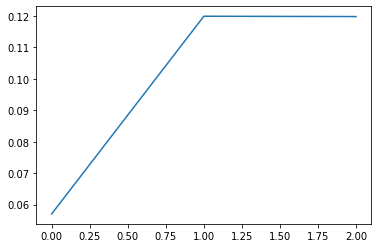

In [ ]:
plt.plot(loss_values)

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

# Test Sentences

In [ ]:
next(iter(prediction_dataloader))

NameError: ignored

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(validation_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in tqdm.tqdm(validation_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Calculate the accuracy for this batch of test sentences.
  tmp_eval_accuracy = flat_accuracy_batch(logits, label_ids)
  # print(tmp_eval_accuracy)
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 14,430 test sentences...


100%|██████████| 451/451 [00:43<00:00, 10.44it/s]

    DONE.


In [ ]:
def flat_accuracy_batch(logits, labels):
  regular_list = np.argmax(logits, axis=1)
  pred = regular_list
  regular_label_list = np.argmax(labels, axis=1)
  labels_flat = regular_label_list
  return np.mean(np.array(pred) == np.array(labels_flat))

In [ ]:
def softmax(z):
  '''Return the softmax output of a vector.'''
  exp_z = np.exp(z)
  sum = exp_z.sum()
  softmax_z = np.round(exp_z/sum,3)
  return softmax_z

In [ ]:
# [list(softmax(i).argmax(axis=1)) for i in predictions]

pred = []
for b in range(0,32):
  for i in predictions[b]:
    # print(i)
    pred.append(softmax(i))
len(predictions)
len(true_labels)
np.argmax(predictions[0], axis=1)
# [list(np.argmax(i, axis=1)) for i in predictions]


array([4, 3, 0, 3, 5, 0, 4, 3, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 4, 4,
       1, 3, 2, 3, 0, 3, 0, 5, 1, 2])

In [ ]:
regular_list = [list(np.argmax(i, axis=1)) for i in predictions]
pred = [item for sublist in regular_list for item in sublist]
len(pred)
regular_label_list = [list(np.argmax(i, axis=1)) for i in true_labels]
labels_flat = [item for sublist in regular_label_list for item in sublist]
print(labels_flat)
print(pred)

def flat_accuracy(logits, labels):
  regular_list = [list(np.argmax(i, axis=1)) for i in logits]
  pred = [item for sublist in regular_list for item in sublist]
  regular_label_list = [list(np.argmax(i, axis=1)) for i in labels]
  labels_flat = [item for sublist in regular_label_list for item in sublist]
  return np.mean(np.array(pred) == np.array(labels_flat))

flat_accuracy(predictions, true_labels)

[4, 1, 0, 0, 5, 0, 4, 3, 0, 3, 5, 0, 0, 0, 5, 3, 0, 3, 3, 0, 4, 4, 1, 1, 2, 3, 0, 3, 0, 5, 1, 2, 5, 3, 1, 0, 6, 1, 0, 3, 0, 5, 5, 2, 0, 0, 3, 1, 3, 0, 3, 1, 0, 3, 4, 0, 0, 0, 3, 0, 3, 3, 2, 4, 4, 0, 3, 0, 4, 0, 0, 2, 3, 0, 3, 4, 4, 3, 3, 3, 0, 3, 3, 1, 3, 0, 3, 0, 3, 5, 5, 0, 5, 3, 3, 5, 0, 3, 0, 0, 1, 0, 0, 3, 3, 3, 5, 0, 4, 3, 0, 4, 2, 0, 6, 0, 5, 0, 5, 3, 5, 0, 0, 0, 0, 3, 4, 0, 5, 0, 3, 1, 5, 3, 0, 3, 0, 3, 1, 3, 3, 3, 0, 3, 0, 3, 0, 1, 0, 1, 5, 5, 0, 3, 0, 3, 1, 0, 0, 0, 0, 1, 3, 4, 5, 3, 3, 1, 0, 3, 3, 1, 0, 4, 0, 1, 2, 5, 0, 3, 0, 0, 0, 0, 1, 6, 4, 3, 0, 0, 0, 3, 3, 3, 0, 3, 3, 5, 5, 0, 5, 2, 5, 0, 3, 0, 5, 2, 0, 0, 0, 3, 5, 5, 5, 0, 3, 3, 0, 0, 1, 3, 3, 0, 4, 2, 0, 1, 0, 1, 0, 0, 0, 1, 3, 0, 3, 2, 0, 3, 6, 3, 0, 4, 2, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 0, 2, 3, 0, 4, 2, 5, 3, 1, 3, 2, 3, 4, 0, 5, 1, 4, 3, 3, 1, 0, 3, 3, 0, 3, 1, 5, 3, 3, 0, 0, 3, 3, 6, 0, 0, 3, 0, 3, 0, 0, 3, 3, 6, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 4, 3, 5, 2, 0, 0, 3, 3, 0, 1, 3, 0, 0, 5, 3, 3, 0, 3, 2, 

0.7722106722106722

In [ ]:
# Create sentence and label lists
sentences = traindf.discourse_text.values[-5:]
labels = traindf.labels.values[-5:]
# sentences
# labels

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
# print(input_ids)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
# input_ids

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

labels = to_categorical(list(labels))
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# # Set the batch size.  
# batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_flat, pred)

array([[4309,   61,   68,  293,   56,  260,   58],
       [  77,  891,    3,  159,   58,   97,   13],
       [ 116,    7,  376,   32,    8,   18,   35],
       [ 565,  166,   29, 3514,  168,   45,   54],
       [  74,   34,    7,  108,  635,   48,    0],
       [ 254,   54,    8,   18,   38, 1175,   15],
       [  95,   13,   16,   35,    4,   20,  243]])

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

roc_auc_score_multiclass(labels_flat, pred)

{0: 0.8587128216304785,
 1: 0.8304652369422345,
 2: 0.8128342245989304,
 3: 0.8543071876735086,
 4: 0.8381670260963584,
 5: 0.8571585928945816,
 6: 0.7789630528098611}

In [ ]:
 print(classification_report(labels_flat, pred, target_names=traindf.discourse_type.unique().tolist()))

                      precision    recall  f1-score   support

                Lead       0.78      0.84      0.81      5105
            Position       0.73      0.69      0.71      1298
            Evidence       0.74      0.64      0.68       592
               Claim       0.84      0.77      0.81      4541
Concluding Statement       0.66      0.70      0.68       906
        Counterclaim       0.71      0.75      0.73      1562
            Rebuttal       0.58      0.57      0.58       426

            accuracy                           0.77     14430
           macro avg       0.72      0.71      0.71     14430
        weighted avg       0.77      0.77      0.77     14430



In [ ]:
# print()
print([i.argmax(axis=1).astype('int')[0] for i in true_labels])

[4, 5, 4, 0, 5, 0, 3, 4, 3, 0, 3, 1, 3, 0, 0, 4, 5, 3, 3, 5, 3, 0, 3, 0, 3, 0, 0, 0, 3, 4, 3, 5, 3, 5, 0, 3, 0, 2, 2, 0, 0, 3, 3, 0, 1, 0, 1, 0, 3, 3, 5, 3, 3, 0, 0, 6, 0, 3, 3, 3, 0, 5, 4, 3, 3, 0, 0, 0, 4, 3, 6, 0, 5, 3, 1, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 4, 1, 3, 5, 0, 3, 3, 0, 3, 0, 5, 3, 5, 2, 0, 4, 0, 0, 1, 3, 3, 0, 3, 3, 4, 0, 3, 3, 5, 0, 3, 3, 4, 4, 6, 3, 3, 3, 3, 3, 3, 0, 1, 0, 5, 3, 0, 1, 4, 3, 0, 5, 0, 1, 3, 3, 2, 0, 1, 3, 5, 0, 0, 5, 0, 0, 0, 5, 0, 4, 6, 3, 1, 3, 3, 3, 0, 6, 3, 0, 5, 0, 5, 3, 0, 4, 0, 3, 3, 5, 0, 3, 0, 0, 0, 0, 3, 3, 0, 3, 2, 0, 0, 3, 1, 3, 3, 0, 5, 0, 2, 5, 0, 0, 3, 1, 3, 0, 5, 5, 3, 5, 0, 3, 3, 0, 5, 0, 3, 1, 5, 0, 3, 1, 1, 5, 0, 6, 3, 0, 3, 0, 3, 4, 1, 3, 5, 0, 0, 3, 1, 3, 3, 0, 0, 3, 3, 5, 0, 0, 0, 3, 1, 0, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 0, 3, 5, 0, 0, 4, 3, 0, 0, 5, 0, 0, 0, 3, 3, 1, 0, 0, 0, 0, 5, 0, 3, 0, 3, 5, 0, 0, 3, 0, 4, 0, 5, 3, 3, 1, 5, 5, 0, 4, 0, 1, 0, 2, 0, 0, 3, 0, 4, 3, 3, 4, 3, 4, 3, 1, 1, 4, 0, 0, 3, 3, 3, 3, 0, 1, 0, 2, 

In [ ]:
validation_labels[]

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))